### Imports and helper functions

In [1]:
%run helper.py

In [2]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from itertools import cycle
from scipy.optimize import linear_sum_assignment
from IPython.display import display, HTML

In [3]:
def visualize_points(pts):
    plt.plot(pts[:, 0], pts[:, 1], '.', alpha=0.5)
    plt.axis('equal')
    plt.grid()

    return plt

In [4]:
def create_ellipse_points(mean, cov, n_std=1.96, n_points=100):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    
    t = np.linspace(0, 2*np.pi, n_points)
    ellipse_x = n_std * np.sqrt(eigenvalues[0]) * np.cos(t)
    ellipse_y = n_std * np.sqrt(eigenvalues[1]) * np.sin(t)
    
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    
    ellipse_points = np.dot(np.column_stack([ellipse_x, ellipse_y]), R.T) + mean
    return ellipse_points[:, 0], ellipse_points[:, 1]

def plot_confidence_ellipses(distributions, n_std=1.96):
    fig, ax = plt.subplots()

    cmap = plt.get_cmap('viridis')
    colors = cycle(cmap(np.linspace(0, 1, len(distributions))))
    patches = []

    for idx, dist in enumerate(distributions):
        mean, cov = dist[0], np.array([dist[1], dist[2]])
        x, y = create_ellipse_points(mean, cov, n_std)
        
        color = next(colors)
        
        # Create polygon
        polygon_points = np.column_stack([x, y])
        poly = Polygon(polygon_points, closed=True, fill=True, color=color, alpha=0.5)
        ax.add_patch(poly)
        patches.append(poly)

    ax.set_title('Confidence Ellipses')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(patches, ['Distribution {}'.format(i) for i in range(len(distributions))])
    ax.axis('equal')

    return plt, ax

def plot_distributions_with_points(distributions, points, n_std=1.96):
    fig, ax = plot_confidence_ellipses(distributions, n_std)
    
    ax.plot(points[:, 0], points[:, 1], 'ko')

    return plt

def plot_distributions_with_colored_points(distributions, points, points_to_distribution, n_std=1.96):
    fig, ax = plot_confidence_ellipses(distributions, n_std)
    
    # Plot all points in a default color (black)
    ax.plot(points[:, 0], points[:, 1], 'ko', label='All Points')

    # Use the same colormap to get consistent colors
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(distributions)))

    for dist_idx, point_idx in enumerate(points_to_distribution):
        ax.plot(points[point_idx, 0], points[point_idx, 1], 'o', color=colors[dist_idx], label=f'Point to Distribution {dist_idx}')
    
    ax.legend()
    return plt, ax

In [5]:
assignment_problem_html = """
<!DOCTYPE html> <html><!--
 Page saved with SingleFile 
 url: http://localhost:3001/001-assignment-problem.html 
 saved date: Mon Sep 30 2024 23:37:54 GMT+0200 (Central European Summer Time)
--><meta charset=utf-8>
<meta name=viewport content="width=device-width initial-scale=1">
<style>html{overflow-x:initial!important}:root{--bg-color:#ffffff;--text-color:#333333;--select-text-bg-color:#B5D6FC;--select-text-font-color:auto;--monospace:"Lucida Console",Consolas,"Courier",monospace;--title-bar-height:20px}html{font-size:14px;background-color:var(--bg-color);color:var(--text-color);font-family:"Helvetica Neue",Helvetica,Arial,sans-serif;-webkit-font-smoothing:antialiased}h4,h5{white-space:pre-wrap}body{margin:0px;padding:0px;height:auto;inset:0px;font-size:1rem;line-height:1.428571;overflow-x:hidden;background:inherit}.in-text-selection,::selection{text-shadow:none;background:var(--select-text-bg-color);color:var(--select-text-font-color)}#write{height:auto;width:inherit;word-break:normal;overflow-wrap:break-word;position:relative;white-space:normal;overflow-x:visible;padding-top:36px}body.typora-export{padding-left:30px;padding-right:30px}.typora-export p{white-space:pre-wrap}@media screen and (max-width:500px){body.typora-export{padding-left:0px;padding-right:0px}#write{padding-left:20px;padding-right:20px}}img{vertical-align:middle;image-orientation:from-image}*,::after,::before{box-sizing:border-box}#write h4,#write h5,#write p{width:inherit}#write h4,#write h5,#write p{position:relative}p{line-height:inherit}h4,h5{break-after:avoid-page;break-inside:avoid;orphans:4}p{orphans:4}svg{break-inside:avoid}p>.md-image:only-child:not(.md-img-error) img,p>img:only-child{display:block;margin:auto}.md-math-block{width:100%}.md-math-block:not(:empty)::after{display:none}[contenteditable="true"]:active,[contenteditable="true"]:focus,[contenteditable="false"]:active,[contenteditable="false"]:focus{outline:0px;box-shadow:none}@media screen and (max-width:48em){}@media screen and (max-width:1024px){}@media screen and (max-width:800px){}mjx-container{break-inside:avoid}:root{--text-color:#1f2329;--bg-color:white;--side-bar-bg-color:white;--active-file-bg-color:white;--rawblock-edit-panel-bd:#f5f6f7;--window-border:0 solid white;--control-text-color:#1f2329;--primary-color:#3370ff;--primary-btn-border-color:#3370ff;--active-file-border-color:#3370ff;--primary-btn-text-color:#3370ff;--item-hover-text-color:#3370ff;--meta-content-color:#3370ff;--search-select-text-color:#3370ff;--heading-char-color:#3370ff;--mermaid-theme:default}#write{line-height:1.68;-webkit-text-size-adjust:100%;max-width:960px;margin:0px auto;padding:1.6rem 3.2rem;font-family:-apple-system,BlinkMacSystemFont,Helvetica Neue,Arial,Segoe UI,PingFang SC,Microsoft Yahei,Hiragino Sans GB,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-size:16px;color:#1f2329}#write *{-moz-box-sizing:border-box;-webkit-box-sizing:border-box;box-sizing:border-box}#write>*:first-child{margin-top:0!important}#write>*:last-child{margin-top:0!important}#write p{margin-top:8px;margin-bottom:8px}#write h4{font-size:18px;margin-left:0;margin-right:0}#write h5{font-size:16px;margin-left:0;margin-right:0}#write p{margin-left:0;margin-right:0}#write img{max-width:100%;height:auto}#write .md-rawblock{margin-top:1em;margin-bottom:1em}#write *{-webkit-font-smoothing:antialiased;text-rendering:optimizeLegibility}#write h4,#write h5{line-height:1.4;font-weight:500;margin-top:1em;margin-bottom:0.37em}mjx-container[jax="SVG"]{direction:ltr}mjx-container[jax="SVG"]>svg{overflow:visible;min-height:1px;min-width:1px}mjx-assistive-mml{position:absolute!important;top:0px;left:0px;clip:rect(1px,1px,1px,1px);padding:1px 0px 0px 0px!important;border:0px!important;display:block!important;width:auto!important;overflow:hidden!important;-webkit-touch-callout:none;-webkit-user-select:none;-moz-user-select:none;-ms-user-select:none;user-select:none}mjx-assistive-mml[display="block"]{width:100%!important}mjx-container[jax="SVG"][display="true"]{text-align:center;margin:1em 0}mjx-container[jax="SVG"][display="true"][width="full"]{display:flex}g[data-mml-node="mtable"]>g>svg{overflow:visible}mjx-container[jax="SVG"] use[data-c]{stroke-width:0}</style><title>001-assignment-problem</title>
<meta name=referrer content=no-referrer><link rel=canonical href=http://localhost:3001/001-assignment-problem.html><meta http-equiv=content-security-policy content="default-src 'none'; font-src 'self' data:; img-src 'self' data:; style-src 'unsafe-inline'; media-src 'self' data:; script-src 'unsafe-inline' data:; object-src 'self' data:; frame-src 'self' data:;"><style>img[src="data:,"],source[src="data:,"]{display:none!important}</style></head>
<body class=typora-export><div class=typora-export-content>
<div id=write><h4 id=problem><span>Problem</span></h4><p><span>For each point we can calculate the likelihood, that this point belongs to one of the distributions. How can we determine what the most-likely mappig from point-to-distribution is?</span><p><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA6IAAAOgCAYAAAAnMMuMAAAAAXNSR0IArs4c6QAAAERlWElmTU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA6ABAAMAAAABAAEAAKACAAQAAAABAAADoqADAAQAAAABAAADoAAAAAAfwiaCAABAAElEQVR4AeydBYAcRdbHK+7uHmIkxCAJsSO4B/mwC8chx+F2h8NhB4cf7nC4Ewju7iQhCXHi7u4ufPWrzeup6e2Znd2d3Z3dfe9u01Zd8u/uof71rMwfVoyKIqAIKAKKgCKgCCgCioAioAgoAoqAIlBICJQtpHa0GUVAEVAEFAFFQBFQBBQBRUARUAQUAUXAIaBEVF8ERUARUAQUAUVAEVAEFAFFQBFQBBSBQkVAiWihwq2NKQKKgCKgCCgCioAioAgoAoqAIqAIKBHVd0ARUAQUAUVAEVAEFAFFQBFQBBQBRaBQEVAiWqhwa2OKgCKgCCgCioAioAgoAoqAIqAIKAJKRPUdUAQUAUVAEVAEFAFFQBFQBBQBRUARKFQElIgWKtzamCKgCCgCioAioAgoAoqAIqAIKAKKgBJRfQcUAUVAEVAEFAFFQBFQBBQBRUARUAQKFQElooUKtzamCCgCioAioAgoAoqAIqAIKAKKgCKgRFTfAUVAEVAEFAFFQBFQBBQBRUARUAQUgUJFQIloocKtjSkCioAioAgoAoqAIqAIKAKKgCKgCCgR1XdAEVAEFAFFQBFQBBQBRUARUAQUAUWgUBFQIlqocGtjioAioAgoAoqAIqAIKAKKgCKgCCgCSkT1HVAEFAFFQBFQBBQBRUARUAQUAUVAEShUBJSIFirc2pgioAgoAoqAIqAIKAKKgCKgCCgCioASUX0HFAFFQBFQBBQBRUARUASKDIHtO/8wF7w82fz30znmjz+KrBvacClG4JtJq8ygJ8ebqUs2lmIUCn/oSkQLH3NtURFQBBQBRUARUAQUAUVgFwLT7eT//dHLzINfzjXvjV6quCgChY7A0z8sMD9OXW0GPTG+0NsuzQ0qES3NT1/HrggoAoqAIqAIKAKKQBEj4GtBV6zfVsS90eZLIwI7d72EqzduL43DL7Ixly+ylrVhRUARUAQUAUVAEVAEFIFSj4C1zA1kzaYdwX5J2Hll6GLz+LfzzaatO0zHJtXM9Ue1Nl2aVS8JQytRY5DFkC3bdxb6uBau3mJOfnKCad+oirn7pPamfvUKhd6HompQiWhRIa/tKgKKgCKgCCgCioAioAgY0UYBxYYtJYeIfj9llbn6rWnBE16ydqvh3Jn7NDW3HtfWlC0TXNKdIkZgh7cawn65Qnw4z/+00ExfutH9dbKLFVce3qqI0Si85tU0t/Cw1pYUAUVAEVAEFAFFQBFQBEIIeBzAlC1BM9Pr35kRGmnWIcTjZBsYpyi0b5Ed0pN2MSQGQtkyhbtCMG7++qDxWcs3B/ulYacEfe6l4XHpGBUBRUARUAQUgaJDYNWGbQYzssVrtsZN3BL1aOayTWbsvPXG1zaEyzIZ/3LiSjNq9trwJT3OUATeGrnUHPXQGPPTtNVp6eG2HTFzyBqVS4ax3nLr68r7L9KoZkWzT/vacuiwO+7RcUpGA0SKdkfewfJWE1rIPNRMXRyL1OtbBxQGIun+lnPb55Lxted21FpeEVAEFAFFQBFQBFJCYMbSTYaIku/9tsys3RwL5MGE7chu9c2dJ7Q1dapl92l697el5qJXpgRtUKaxnYxXr1zOVCpf1hAUZNm6rYbgNKTvQLo1r24+uWwvNVkMUMvMnevenu5MaK9+a7r55bpe+e7k1u0xdVS1iiVDRzJ7eYyEtmlQxfx4bS9HcPzvYszcdQYy+vaF3UyVEjLufL8MRVSBvIOFaZLLUFmkw2RbpLCDJaX7W5ZxpLpVIpoqUlpOEVAEFAFFQBEoRQig/fz3+zPNEKv9ihLI4wdjlhnMyqLIyKNfz4+7jfr4SybUtd1qxypaoqqSuQhs35FFHCFb2+x+hXI5mzJOWrTB1LTazmZ1KmUbmG+iWr1SyZiazlsZM7E8d79mgZbtuB4NbVCaqo6A4g+bRUbHmncv7q5kNNubUXgnRCNatVK5wmvUtuRrQ2mYxTmRZN+MlMnvNi/fcn7b9O/XX3ofDd1XBBQBRUARUAQUAWdO2+/2kdlIKFrQJrXjiQRkZP6qLdlQWxBxLluh0ImWdSsrCQ1hkumHG2002JzkisHTzEH3/Gb2vvVX8+qwxdmKb/UilVatVDKmpotWxwgFZrm+EDX3+2t6OmLOeRZgLnp1sl9E9wsZgS27tPKVKxTu+zfaasV9Ef/UnL4Z/5507afyLaerLamnZCw7yWh0qwgoAoqAIqAIKAL5QmDYjDXm+MfGxdWxR9Nq5sIDmpuj92zgtF+fjV9h/v7870EZVvGbe5qudZt3xJnxPvLX3U3DGhVdVMgZ1m8OP9NVG7abtZuyTH25t2frmuZvf2oS1Kk7mYuA7/P76bgVpkHNCmaWfa4sPmyzmnI0nzzTU/o2doMYat8pkavenGY6WI3g3rvVlFNxfpIlRSO6cmNM+1+7avbpdlO7oPPhP7ubQ+8b7cbPNzVhwXpN7RK8FYW7I1r5ahULVyO6wP4W+tKgRpabQ07fjH9PfvZz+y3np62oe7N/GVGl9JwioAgoAoqAIqAIlHgESCHw5yfGx43zpbM7m4P3qBucw5/JT0nBBSbQe7WsEZT52QtigynmCT0bumsDOsSCtQSFdadYIIAZ6dQlG814zKd3+fTS8csHT03Y/xZWw80zP6xzXfPU9wuCcrxjU+/sH5j0Yt4rUq2EaESxHhCpWSV6uo2J7p0ntAswnGKD1miOUUGtcLfbdmnl8WEvTMFH3pdGtbK05zl9M/49ud3Pz7ec27ZyKh/9ZeR0l15XBBQBRUARUAQUgRKFAGTgL09NCEgGE+l3Lu5mellNpQhmuAMfGpvN1xPzstP6xbSZX/6+Um4xB3SsE+zrTvFCgKivg2yakbyYWbMAsZsN0oP8+9g25vCu9cy9n801w2eucQFaVlmNIVpyZMu2WNTckqIR9YPe+FonN2Dvn56tYws4aIpVigYBCVZUvZB9RDd77z4jb16nsgMgp28mCiUWCSdbX2zMwlvWq2z6t6sVFEvXtxxUmKYdJaJpAlKrUQQUAUVAEVAEijMC30xaGUc4Xj+/SxwJxXTw3BcnBUQ12Vi/nLgiuLxvh+JPRAmytN5qBNHw5SSzV2w2r1s/SAKNrLGmx/gHEjX12L0aGJLVJ5OVth0mkfWq2wjDuzQjycqHr6GpxOy5no1QXC0NE+prh0yPeyfC7ckxEZH/ZCe9/drWcu9Mu4ZVswXe6dOmlnnrwq5yS9x2ncVWpFqKGql0j1XaT9fWD+CULBIqWlFw2bLtD9PVRo0ujoIp/hu/LjaY9ZO2prbVALewROgQa0kxwH7/nnI4Y4cnprmFrRENE9E9W8QWJpJ9MwCJYQLWJ0NGLjGf2N9nNJ2+ECTrZrsIhKTzW/bbyO++EtH8Iqj3KwKKgCKgCCgCJQABzAJ9YUJEECLye77w8yKnyZLrpF/pYifNUbk/Jy3c4CajUlZyJxKQZtKijWbOik1OI9a6fhVDGwWZs+/zCSvMMz8sNIvWbDFtLRk83poID+xe3/hmk9LP8JZJ3mA7ub7l/VmBvyvk7qBOdc1lh7Y0uzfOrr3CdPWwXT5/4foe/mqeOcJqBe8/uYOpFTLV/HHqanP3p7PNb3NigUvA55b/a+Mm8+G6wsdEaL3x3ZnmC28BAL/e422E1gusb28qGKPVftE+ZybGFx/U3JmI+iaz4Tbl+PXzupj9ds/fYoP4ClNnThqpdIxV+p7KlgAupC76zL5LkHwiOjez/p2HWHNjFhf4Fnwhv+o4mzvX14iusqmKksmf2hWMyTpk/aEv55lp9r1s27CKufKwVgnfhd/td0sgKczs11tiyWIICyf4+Ua96zIeyM/AB8c4/285J9vnflzoFmGePXOPpHVI+XRs6U9V6+eZyjvvtydEtEYaFnD8enPa3+QF++J3KRX3BRa7XvllkXn91yXZrFP89n6dFcvNXFjfst9+KvtKRFNBScsoAoqAIqAIKAIlHIF2dqLqS/t//eIfBvuQuVstQWIFPoqIDh6xJCjLzhXWhxAC6udVlAKYb75lcyi2ttqTdMqmrTvNKf+bEEeeMU3DZLj+uxXMHdYv7yhLSBMJfT3J+jGGTVKZ5JKy5pNxy22gmT1N9xYxDdZSG7CJCblMaKPq/tRi9vO0Eealczqb3ruC9Tz69Txzx8ezsxWnD2c8M9E8+JcO5s97N8p2XU7c/cls85AluWGBWPy+cJYZM2+d+d8ZnYLLH41dbq6xms79LXmkbjR3I+1iw/E2n6X4fjK+n21+0PsGtXemudx8WJd6htQjXZtVMwfaCLjgiTTYZV7rDvL4j09EayTRiOZ2rHnsTnDbYDvRv+HdGdk0TaRc+dhidKWNBnyMJaP/sd9DXasVZrIviwmCJZVd9PJk88S31U1nuzjAAgF/mOFG5d8NGs/FDosmxzw8xuWjvPfP7d3CAOf+9uxE882kVUFNaPZ5931ZZMn1VW9Niysn13+y2jZyCKPRv/qIVuYYG6wsLHwn+JYnEt6TA/47ytx+fFtz5j5NI4uB22prqh1+l7DC+G7KKnN6/yYOs8ib7Um+ybs+mRP3G8MCQWf7rr5wVmdT35LqZOKTtBqhRaJk96VyjQW4R7+Zb76yvz0s0tW1ffm7xYEx8a5v8kxzcWPwNelR9WNlcbhd7PJzOvvliGpexwbHYrHr8sNaBpcK61sOGkxxR4loikBpMUVAEVAEFAFFoCQjANFACxdFGBn3njYYEZNcJtGIn+/OjzQJAfIF8pVIIHqQt2HX7+0mZYnK5fb8GXYCji9ilGA6iIkxPljnWdO1sKBxO/z+MXETPdF6CcmEZPzng5nm7Yu6Bbc/+e2COMICTpglVypfxqXnQOvJfUwg/++Rsea9S7qbH+wk+/4v5gZ1RO1c/84MF+zJ17BJuds+nGUe/3a+HLot5MbP1wrxJMCQmH0yaef6u78tNefv38wQvdX3DaYS+nn1W9MN2s4RN/aOq58DNGRCRJkYpyL4Sb49aqnTsklf5D7MnkUEazmWbV7GKvfmdss3cP5Lk91zS3YvOL1jx/Tt5FXmA/s80TqyuBJewKAc5JU/XxhrJ/uenNavsVtsiHrGfvlE+2hqhQCjeUdDfe9nc7KRSywb8OWmzT8sUX3q+/nmjo9mBwsQiernWTs8rKb3hqN3C4p9b99ff0wQPiJrQ4Lm2u8IiwQxF+U9Xrp2mzUZL+vIO6maEJ7r/2wgKzCC0J+9b9Y3yXtKm8hLVvs3/Ia9s5nG21vMP16b4p6BK+j9w7cKJhfaRYBHT82K2u1djttdZ79JkZw08lIulS2ay5MtUQcLEYj/7R/Ncn3++qoecQtXWGv4EvXNYLUQJqGQz4us5QP3h1MFSX0sJqTrW5Y607FVIpoOFLUORUARUAQUAUWgmCPAJPgjm07ibqtZ+MhqeyArmIodbE0QLzmoRVxUXIbK5Fekc9OYZpAJD5qUsJDSg4A1BLD51NZP7kSEdv719nTzqE3xkg4ZYc3Rotpn4svklIAeyC3vz3RarJN6ZUX05RyE6PAH4kkohPXsAU2tqV8Z88JPC52GjLKkV0CTggaD7fP2mgik/ZNL95RDt4Ww/eeDWeb14Yvd8avDFpm3RiyNK3OFNZ08dq/6BtLKxB1hIr9oTXx6HM4zefdJKOTwmb/t4cgQk91jLNkVQgQZFfLXpFYsDyzP8AI7UReyQL0ikAzMUjFzDEstLx3J0l14hsuEjx+xmt//fjrHmbJOu6t/nHk0Gmwkkcl0Xsca7kOqxxe+MiV4P+Ue+nbXie3MPjYKMKauaOskJyrvMFq/dy0Z/chqyjGzfnfUsjiSIfX4W95HIahP2IWMH67t6V9Oed8nH/hrQvgf/DJ6gWOIvXZj093Mr7PWuPcx3Aim9NcftZtbQOEdf9qatsviFO/bTEvSn7OmtshjVtMnAqn+8V+94szOIVLPWPPcu6zGn7F+PYkUNRvMo1/PN5Pv6OdM+IWEUs8D1owYIop5sJBQqf/5nxaZm46JkWC+udOtxQDvqQiEbG8bXK2VtbDAQgGNNr8FB1sN/uib+8SZS8s9bOX9Y7+G/Z1KhzDeE2waLL7FKMGHHILvL9yFSXDUN4MfdljQrne3vzn+exAuk+g4L99yorrycj49aOelZb1HEVAEFAFFQBFQBDIKAcwL7z6pnfvLqWNLLDkSqVMtNp240WpMmAjOshPWOlUrOLM+Iu+iLRKB2F7y6hSnleMcWqW77SQ/HQF2Xrd+nWHp0aqGeeuCbnYiasxRNuovE13kijemWu1R7SB6613WzBVSIfLM3zqZI7tlaSnQvgiJ5TrExP7fCfUx8RR55JTspBotEeZx/7X4zl+12Rx872gp7saNdkS0RAT7+WX6Gmf+GRTydtDqokkSgYR+bImvkEbM/TbuIneUwa9RZNO2mPbxzOd+l9Nue+2Rrc0DVkMrY/lhymq3eBBXyB74hDFZRFj/PjF/pO65VlPEgoXI+i1ZGqlKFWL9lGv5GavUkdvtTh62J2iZRePJaZ4TvsJXWXPVs56f5EzU0eihaR9pNcj3D+pg/tqnsTn64bGuFhZh8LstaxczZlsfacjYhFAanJxMMr3uZNv1A97wLvJtiZAOpoN9P/jGkI/togTfaGiI7hq5giGh4l/Z0fqIYk6L9vwiS84RCDg+s//Xo4ELTuRO2n/uOKFtHAnlPItbWB3wx7eT5YO6wWn0OIZsgpvIDksuSWdy4mPj5VSwpQ8+ET3b5jEWEsr7+OTpHYNvlZvQ/kJEEd6h14cvMadazXOUsOAiko7fIOq61X6fPgllEY7fhWW2L+OsuTzPDO2mvwjEeyG/N9QR9c2Qf/cG+4xus1pVEXDgD034bce1jfutlTKJtnn5lhPVlZfzsf9y5OVuvUcRUAQUAUVAEVAESiUCKzzC5vu6MZEjQE4ygcDhn/jL9NUBucOXMR1BW8bOzSKZfvtPWx/JKhWzSM7L1j+z720jHNliEoxW8qIDmxtMcgmu4svZL0xyhAnz1YnW5NgnqUwIxZSSe0WY+PukW87LlnvmrdwSNwF97dwuAQmVckzsW9WvbNpbUtrcmnv6glmwP4En0FTnG4aZbtZnFWIoZppyj58HFvPIKMGPFL9ZiCJkFBHz23B5SXXBeb8f4XL+cRWPZM5eHk9ERSMV1ghxf37G6refm32Im2jsmah/dcVeBm1bWEg/8441z97z5uHu3YB4TFm8wUDgGnma592bVLVEtEX4diNRkitVKOPM4rMVSPHEivWxRSH/FszD37ukm1s4+GD0MvesxJIh7BP+d6v1981u/XrwDSbyr2jp8QNnAcd/9n+xxDuZoK2r7C2I4P8sGMt9O6y9MOmCwqanXIe40h7P48uJK52/t9yHH+iBnerIodu+b8fry512kWlQ70aRPpj+ok3NJD7Kfn3J9jF7fnVobEEMcs9vDMLvIz7xBIK79PWpcdW8Z/uML65Iom/mQlsXQY3Os0RetNXcAxkdcNdI58vNIkkqvvd5+Zalf+nYZl96SketWocioAgoAoqAIqAIlGgEVm6I+VU1rJE8GEgUEGiATvTMYgnkkQ7BbNIXTNl8EsGE+F8DWwdFpHwiX03IGOZ9PgllMvyQp/X0k9JXtD6hOYloZCmHFgNSGxYCt6D5YPLsCyaHQ0bGm/RyHQKJWXKYhOITGA6q5NfHPloUCd5EZF8Rog1HyR/MtHeJP5GVc5g9n/r0hDjMfGI2fpdGWsoLodlqNWK+5Hesfl252fef4Il7N4x7f8L18B438VLtoH1D/PeAKLRRggUCAXXQgPuaqaiyyc4tXZd9cQF/zfetqTBacjTipAJBwBpNG6bmvlxhI0EnE9LMiOAf7n//cj432zAJ5V60g76pKj7KPb08xkKiMT0WQYsfJqGjrG9o2Eec7/fJ7+bLbXHbnd77LFrIuAK5PGBsYlVA5GEhoX41BHELC6TS16Im+2Ywtf/JmkKjCe4WSvuD9rj/7SPMOXYhLVkgKdrPy7cc7nd+jpWI5gc9vVcRUAQUAUVAESilCKzcNeFm+OFol6lC4gemaWUDJeVXmMgKqZG6IJrhyaU/qRazPMwNRYiIi/lilJkek74f7ATQ11Lil5cbwURThImib54n5xNt0WyJQC6+u6ankRQ5cp4t2F5nCTd+jb74QaY4j7YUbZgI2jwRTAWjBA2xiK8Z5xwLCk9Z/1Witb5i04GINLYLACLf2eA+vmzZFTl0XSjwUX7H6reR1/3GNWNjjarjZ6vV98kT2lTET9HjB6uJqiO/53yTcanrNUvi/PfXX4zw+yvlfasGOSdby13jTMHRtPoBpqRcXrYESIuSV87JSgu0h/c+zreWBIi/kBMmeZBVfEej5B7ro+wvGkkZ37SZxY/8Cppukf1tJNywEIkZP3ARXAdEXrSBmUSSfTOUsethLpLxZ5fvZX68tlfcwh7Xiey8712j4nx5Oe9LXr5l//787qtpbn4RzLD7X3nlFTNt2jRzzTXXmKpVY6tXGdZN7Y4ioAgoAopAMUcAMzoRf8KLJuLez+bayJj1zal9mwT+ZlJWtkSUfN76SImgOcivhEkR9aGhIo3Fi2d3dloniOoTXqRZiCjaEtFgMCHvaSeG/BE4hUk75Kqe1fpyDi1WWPyJLIGFchJfg0FAoX3uHOki1PokMFEdv9sgJyKDbFoXApW8eUFXZ7pI4BuCIoFlZ2sizEQ1LL5vL2T1sVM7xhVBM4fWGHJDeh4es8ebXdlmdSoH9+Dv6ctPlpiJ+M039IioH2mVsuWtVhHh2fAcZIEiv2N1lebhn3ae9g9z7TP+1CRbIBgWNwi0QwRUkWuObB34GzMG3iXeLRYa+PO/E7knHVvfPJP6MO/ERNwXiXbNOUziebfpo7z3RNm98vBW/i1un9y451nfV8kzzJgw4Z1lLQV8YZzJyKxf1t/HD/vge3/zT7n+i5bTz2H6+8L1pn+7+GA9pJc5f//mziT9DesTerPVxsvCDu8yuXjFpJj36/AHRjtNsU/AfP/cKFIf17kUDnwNq7/wQ7+usCl/iAgsQqTggdYPved/fnWnXrBBma45orX75pJ9Mzzz2tYHv/auwGG4AzxsrTTQEN9jn6X4x1Ip7yjkmMW1sOTlW6YOnveVb05zqbmOs/7CBFqL+r0Jtxc+ViIaRqSYH99///1mxYoVpkIF+0Nxww3FfDTafUVAEVAEFIFMRYDoq2jzCMTiC+kj0BLxh5/UMzbCpq89pCwBT/5ug42IYEbomzfK+dxuV3nmwv69pNfoYn0ou7es7kilmE9ShqAzG7zAPkywmDyi5WWCiibJ1yb59cr+1h2xQEXLLIHDT1P8R6WMv+1rzYUJ1iM+mEx+yc1JQJPDbRodzHUTRcD0zTx/nb3GnNwny3SX8qTgSSaQJ19jjB9qVN5ONK1MlikLEcd81JcmtWPazZ+t2bIt5iahRAIlHYiI3x//+QrxlHL1q8fqI0DSITZSM5KfsUrdedmS4/HOXbld8VfEp5ixgAP+rBOtaTHvlI/lWVar/M+D4/1AO1rtKJFnkcnWj5eFjIIQP3Ix39JFB8b3gzZ550ToO37cjBMih2Ca/o09T35b3n00i1/b3Je+NhciTVAsfGOn2vH4wrvcM2KRxi8T3ic4kk+QuY4p/aWHxMyEeRfQICK/WtNzCDTEjYiyCJGo7/t8bkA+3Un7D30lwBSpagiaduErk90lFn72u3uUW7zZy0aaRcBMxOVdPU6O8rb132fM6EfOXueijoOn7/9KXlbGg/DNsYjHdZ4PRDzZNzPQBl3jt4o6CIImixwQ7AdO7mCutMTwpvdmGEmfxeIbZvcEjvMlL98yuVH3sZpW2kfwKWdxzf/e/TaS7atpbjJ0iuG1zZuzViZXr46tSBbDYWiXFQFFQBFQBDIcAYl6Kivy0l1fe4avFL5K5Pp73KZ6wGSTnJU+CeW+l60ZXjLiJnXnZotv5SHW7FSECR7mcD4JZUL7tz81NY09Hz/KE/EyrwI5WRbhsxeu78N/dM8WoAaCTgCTvWzwm92u/tkcaXOsMtEmH6OYFAru1DfEBlqasTReMxVuxz+GWENyEfJdntw7OsAMGg6RLyZmzwPb3NeI2kBNPW8Z7sjaQZZMi4aNdnwT6Jo2arBoOuuFCEu7RjHzzDdtIByR/IxV6sjLFrNa0vaIMCaIOeSUtChfWkLhk9BzbVTYW62fbVgO8Mwy0+UDHW6D42P3ahD4mN52fNvIgDwQFDGDlfRGlx/WMk6LiaZatLykI/JJKJGCIXaJAuDMCGlIo/pZwfOfxm8bDTIi/YIQPvf3Pdw5+aeFbVeuT16URX4xx5V3iXKiAZV70MwShRoSihDhF82jCOXJX3z3J7PdKV/ziKbRH7fck5ttF7tgIcSQ+6gTv02fhBKN+InTYtYIkEkRUjshib4ZrBSEBPJedrlxmNN6jrV5XvExRfuJVha/bx8nR7KlkV3bvHzLPGtpX6r7MSJll1xLtlUimgydYnxtzZqsFbhiPATtuiKgCCgCikAGI3DJLu0PkyVf7j6xfZyWlAk7WgHSDRDERlIucA8Tz3cv7pajxtGvP9V9JoJE07zcBmEJB4KB4JC39GlrFghx5jopJkToL6TDsz6WS8EWLSDmioxnn3a1g/NMgsPENrjo7VDu26t7OJO2cP8oBvmBGBBghTQrXW8aZlN/bHYaFCkPtuQL5XwygcSOtGa2pIQhajBRPIn26i8a+Pej2RDCGhVICXNJAuyIoNH1J++M7aFTOsjlYIsGDundJl4r42Pv+86hLcrPWIOG87BDn8iXSbAc6YNfDcQMHCff3s/c7JFWv8yJvRoF97aom9zX1L8vt/toud6x3xGaMDRkiUSIjwQAgnDzDuIjHKWBh8SwmPOeJaDDbtg7IHbUz3vhk62o/JbhfvgLQ0RpFpPYD+yiDH3/wfo5+r61cj/BtHgGQv75zSHnKvl6faEMmt5h1++dLQo17xLBv3yR4FgEdPqbNb8W+cnz35RzudmyqPaQjQoeJXwb/PbcbhcM/O+P3yQh5pUrxHL3Rn0z3CfBp2iD3wpyuh5hzY4x8YWY9rFafFLuyMIQ5XxzZI6RvHzLPrnNqsVkC5gk53PalrHRkuxPqUpJQWCPPfYwGzZsMAMGDDD4i6ooAoqAIqAIKAIFhQCmcnWsj5Kv+aItgvdAoMjlF1455zoTRtI9MIGXtCqcz6+gEWAyhqClEoLABBbTwYpWI8hkzM+rKW3iK9rj5l/jtBZoYq46vKXZq5U1V7SkeYHVNkAOP7Maym9tMB6Z5BEsiIns49b8DR+tqOBB0k7UFrw+tJqNX6wZJ+Z5mA9Gyec2KAnRMtFa4QvnC6ahaEDwM8UEF9PJbyevdKZ5YgJM+a+u7JHNHNKvR/bBjHyaUVhRZpjt6/GPjZPibgsxwZ/yMmta6ZMUvxB9gfSEr39k81tCQvexaSmOtuMQKYyxSluJthYGR7QJqkSuU0iofYVTEkxc0VCFfTZTurkACqENDGMvzfCtYjGAaTm+g1Fm21KWLQsxN1qzWTS/OaVskvt4r7Zt/yPX3z3fGgQvvCjAIsh8q5VHwxpFtKRd2ZJq6Sur0W5Vr0pctF3G/sjX8x05PH//ZnkOwCbtsEU7OcRG+KWPmDO3tumYjuhaPyDgflnZH21/XyClPiGP+maEfD5iXSHkd0jqiNpCXBMtPuX2W+b35cznJrqAZLRFftb/nhTT6Ea1n+icEtFEyBTT80JE99tvP/PSSy+lZRQLFiwwY8aMMf369TN168bMnNJSuVaiCCgCioAiUGIRYKmb/KAEvSGITwMb8AfSClGLWlXPLxA+EcX/LFFexETtoFk8wZIrP4VCorL+ebRQpFFIl+CHONbihmkzf0ST/Zs15fNNPfGLu+/zOblukpQPvslrrivwbuC5EiAGOdKaOaNFTZWgedXkuJsJY82xk1pAESgCBFhYwIx6mF3AmmRNl/FRh7CziEAwI3xwMbXPyX8zL98yi3dl7P/ys5ioRDSXL82kSZPME088Yfr3729OPvnkXN5d8MVbtWrlGhk4cKB5/PHH893ghAkTDHUh1apVM5dccok5/vjjTaNG8XnN8t2QVqAIKAKKgCKgCOQTAZ+IEknzpmPiTfFSqZ6J3dVvTXc+XTmVx8/yxJ4NzRU22mhYU5PTvem4jq/i1TZyJRqXZELf+tloo9cN3K1AzKCTtZ2ua6VprOnCTOtRBDIdgYwmovg5Qn7Kl8/yPyEAD+Rq9913NxCumTNnmiVLlpjKlSs7clSvXvJocel4GFdffbUZPHiwq2rcuHGmVq1YFLJ01J/fOoSInnTSSebee+/Nb3Xm6aefNrfddlu2etq0aWP22Wcf07t3b/enxDQbRHpCEVAEFAFFoJARQKNJcCTkeEsQ8cXKq0DuXrI5/cZbjeR0GxBom42Mi+kf6VJ6WzO3A605Yj0v2mZe28nvfWidCSiEuTA5U9E8V7M+bwQAIgfjATYqMNFBC0JTmd++5/b+0jTW3GKj5RWB4ohAfISBDBrBl19+ac4++2wDuezVq5fr2ciRI11qkqhuQg4//PBDU6VKLPJaVLlE57Zv3+7yb7Zsaf0aLPlNJDt3xkK0T5482fTp0ydR0eD80qVLzfr16w3krSCFMYikK4do+/bRNt8sAvAn5r88o2OPPdYcccQRpkGDaEf5Dz74wNSvX99pk6WfulUEFAFFQBFQBNKFQFMv+m1uzWvDfcCP8aqIvIrhckV9TOASzO5yMr0r6n6mo/3SNNZ04KV1KAKZjkBGRs1du9bmCbIkFCEn5ueff+7+2E8k06ZNc8Qo0fVk54nXhLnp4Ycfbvbee28zY0ZWvqKoe3bs2BGc3rQp55Dp3333navzgAMOMDfffHNwb0HsbNuWlc+HutNFRPE1vfbaa3PsLosEN954o1s0uPPOOyMXDO644w7zl7/8xcyaNSvH+rSAIqAIKAKKgCKQWwQIrCMmsmgHVRQBRUARUAQyF4GM1IhCotBKEv01kaCpa9GihalQoYJp3ry5Oeigg5zJbqLyyc5v3brVjB071hWhTUjwe++9F2l26xPRYcOGuTLz5s0zixcvdv2l3zVq1DDHHHOMGwNBfkSef/55065dO3PqqafKqbRufSKaTKubm0bL2OXH008/3dx1113BbYMGDTJHHnmkGT16tPn444+dJjm4aHeefPJJ94dpMCbCYfn111/Nbrvl3m8nXI8eKwKKgCKgCCgCYQSIdDt96UYX/XOEjeoblX4kfI8eKwKKgCKgCBQ+AhlJRPEJffPNN83w4cMdySRS6wsvvGA++ugjh9CZZ56ZVu0i7aH5+/777139mJzecMMN5pFHHnHHmLzOnz/fTJ8+3fz+++/BUyJoEX9RsmrVKnPhhRc6/0n/+vXXX+80pPi5plt809y8mihH9Qmi7gtjwDd2//33N5dddpmBiA8dOtT88ssv5osvvggWEK688kqDX+8555zjbmfRAMG3FjKroggoAoqAIqAIpBsBktff+9kcVy2pP5SIphthrU8RUAQUgfQgkJFElKF16dLF/ckwMXEV6dq1q+ymZVuunE16bYkufqnPPfecQdM5Z84c849//MN89dVXAbFKtTH8Wnv06OGKE12X+tCG4iO5aNEiQzqUgiCiBaERZRCzZ892Y+Gfvn37ZtMUo5nm789//rPD6r777jPPPvusu4dAR+D797//3VSqlJXMeerUqUF9mbIDdnPnznVmwyxM8P7hz6qiCCgCioAiULwQON4jop/bAD4qioAioAgoApmJQMYS0TBc69atC05h3ppuKVu2rDnssMPcH3W/8cYb5pprrsmxGUgn0WMJ1tOtWzfTtm1bZ5rr39ikSRNz3XXXuT//fLr3fVPmdPmI0kefOBIlN5lgEvyvf/3LLFy40Hz66aeuKCa6p512WkBg0aBmguBz/PXXXzvzYn+hg77xXD/77DPTsGHDlLuKb/PGjRtN48aNU75HCyoCioAioAikFwFMc/mbvXyT2b7zD0M6lmqVyqW3Ea1NEVAEFAFFIN8IFBsiunz58mCwkqIkOJHiDmajmPtiInrRRRdlI4x+Nb520T/v75PKhXrSLUTmxRyWtDS5EZ+IpstHlPZ9c+TwIgD9xGwZrSkmzZjdhrXIkDq0jDVr1nTDQSucDskrTrwHn3zyiXn33XcTdgOSit9vTkSUPkC48aFFo4qw8HDooYc6LXDr1q3dOf1HEVAEFAFFoPAQeOP8Lubm92eaY/dsoCS0gGGH7F/y6hSzmyX/RBkmsq2KIqAIFA4C81ZudnmP/9q3sTmqe/Gz5Cs2RBQNGwLBql27dtKnS67Rt956y5x//vmBLyI+p1dddVVw36hRo8zrr78e5CgNLuzaIcjOiBEjzPjx482+++7rNKXdu3c3zzzzjLn//vtdKXxX0yUQOvqISSuETgRSM3DgQBeRVs4l2hYUEZ0wYULQJObKaDzJG4pPqpCvoEBoh+f1v//9z/6HqUwc1twLORUhCJRoSllooHyU5Ben1157zfU/qm762rlzZ/d+EUwJDXcywcT6ggsuCAJdSVmI9osvvmiGDBli3nnnHdOxY0e5pFtFQBFQBBSBQkCgZd3K5rkz9yiElrSJ6TY68fujlzkg2tvcpcf1SN2SSNFTBBSB/CHw6fgV5vspq9zf6Jv7GNJOFSeJMYEM77WYh3bq1CnHnkIwIUi33HKLI6JEd/VJKBUQuRWSgF+jCOa/aMsOPPBAU6dOHfPwww/LpWDrR3slN2iqAqndsmWLM+MN34NJ51lnneX6FL4GqYH8olU899xz48hbuCxmoSLpClYEQSQ1iy8QXp8s+9dkH99YzHiJECx5RX0NL1gIEUXbfd555wXtkI80Cvt04ITPalhYsCB1D8QTf9ZUBG3pySefHEfEeUaIpBkCJwJePfbYY6lUqWUUAUVAEVAEFIFih4DNgBfIivWxNHLBSd1RBBSBAkNgp/cBrtm0Pd9EdLn9hmtVKW8qlItWCKV7IMWCiEJARNuHD2ZO0rRpU0cQuAeTUUhelBA8yCeikFXMLI877jjz4IMPRt1iqlevHpz3zYWDkxE7kyZNMieeeKK78s033zg/Uim2bNky5z9JGREi+KJFIy0NPoz4L959991m6dKl5uabb5Zi2bZ+XtN0meai9UsmLAzwTPhDk9mhQwfDOSGZ/r1hIkofGTdRkH1z3ffff98RQ1LEiKQLJ/x5yUsrgsa5WbNmrs+pklAIP/lQfW3wPffcY0444QSnySX1D9GEESI9P/TQQ5F4SB90qwgoAopAJiKwZO1Wc/tHs8yPU1eb1Ru3myEXdjU9W2e5WPj93bbjD2cG+8m45aa8nbzs0762uW5ga9OgRvFamffHpPupI2AtcwNZsymWaz04qTuKgCJQYAhYD7FA1loimh954Iu55h4bcRwf+1fO6WzaNKiSn+pSurdYEFEImAhEJyfxCdnxxx8faKggHaRUufHGG10VP/74oyO4QtrEL5Qot4nEJ1h+TtFE5Tnvp1XBh1LI9ObNmx0RFu0iBI4cnK09v0LfP5PIu+Q4haBGCfWJpCtYkfSNesEJ7SERZcESf1FJySLtJtv6Wlo0ophH83yihPQ5EHLaTCdOd955p4taLObGEGDeB8y5CU5F/tecCOnTTz8dpxF++eWXnfk248Bn1F+goP+JzIyjxq3nFAFFQBHIBAQmLthgjnpojNmyPWuWU75sGeMTDr+Pd3482zz/08Lg1OBfl5i3Ry419w5qb/68d6PgvO6UTAR8jQyBoVQUAUWg8BBI5/c3em5WYFgCve1/9yjz/j+6m71a1ijQwZQt0NrTVDnaMJFU/O184ipmkhAn/EZPP/10c/DBB0t1cZo40dhBToSUBgV37fjnIR2piKQtoSyBfUQgnUL0MOt85ZVX4kgoBBatrS+PPvqofxi37xPwdBHRGTNmBG1A4vERxXQZ0pwbEkolgi/75B31SWibNm1c3VxDJKIt++nECZzRuEJ0feGZX3rppc4XGK14okUGTHLFR1juJyIwPsVgc9BBB5nbb79dLpkDDjggR2IbFNYdRUARUAQyAAE0oT4JHdChthl/a9/IfJyswD/5Xey/a9J9Athc+vpUc9/nWUHc5LxuSx4C/gKFTUCgoggoAoWIgP/9lbMLhvmRM/7UJLid3/AznploNm1NjesEN+Zyp1j8ZPhmm5hR5iR+eSkLySPXJQJZEPG1V37ajenTp0uRuO0fni02Wr2w4GOKL+eUKVOCS+I7yAnfBBdCJIK2M5y3ksA6YpIs5fB/9euQ82x9YuxrYf0yud33sYQs5kd8zaCYrlIfCwOkSrniiiucxlXaEN/UdOOEVvucc85xPrm06T+fadOmuT7QJxYBwjjynKIEn2P6KQsLlEEbetNNN0UV13OKgCKgCGQsAme/MCnQhLZrWNWaaHVxPkNRHf5m0qq403va1XPfnOu+z+eYW2z0WpWSi8C2HbGJao3KxcLQLuHD2GotAO76ZLY59pGxZum6rQnL6QVFIFMQwDVCJL9pqg7qVNe8em4Xqc7gL3rrhwX7+10siKg/uc8pYm5UAKEHHnjAmZEKsrvvvrvsGoiHiE9IhATJNdlK4B2OV62K/w8wJPXaa691Poh+sB2/z/h7QhiJ/irjQsNIRF5fMFsVE2L/PPto3HxCLNd9Yrxy5Uo5na+tT0R9bXBeKo16NnvttZd54oknjGiNfW31L7/8UiA4Sd+J/IsWk5Q+RPZFyyvCs7nkkksMgZP8xQq06iKQZ3x30baHhWdKGhvaUFEEFAFFoLgg8NO01WbU7LWuu5jjvn5el6RBK2Ys2xQM7cx9mppPLt3T/HBtL/P3AU2D8099v0DJaIBGydvZut2bCFcsFtPKhA9h3sot5uGv5pkRs9aah76cl7CcXlAEMgUBFk9E8ktEqeeAjnXMWd7v9ws/L3KEVNpI9zbjfzEgXN9++20wbsgJE/w33njD+fURVIi0J2KCGw6uc8QRR8SZgFKRH/mWaLYiPskcO3asnI7b+nklfTNbCs2ZMyfoh38TPodCctFwSpoSKUMAI9Fych1i5putQlJ9UopvK/6MYWLom8qmi4j69RD4KT+yevXquNvRGGJqXLFiLKCFT8hZJJDnyo3pwgmzW6IwC5kHt8MOO8wFqnruueecD6x0FF9SgleRPoigWdIftMMQVyLn/vTTT27xgefGe4kfMJpTgmapKAKKgCJQnBC47cNZQXevPqKVaVanUnActTN3RYyInrNflsUS1mG3HdfWPPiXWEwHyCh5PUuTTFq0wSxYld1yqqRhIH7EjKt6pZhGFE3NqDnrzLrNxcdvdIdn9UaQrlSkOI4zlXFpmeKBQPz3Vy4tnb7myNamUvkYRXz064JblIn9YqSl6+mpZM2aNc5sEk0VUWNFc0jt+ClGCUQCrVZYSxn2BeRe8n9CJKgXEgExgSz6RNQndX57vvksZBVyUrNmTUPqF8ihiG/+yzkCDAmJoW7I1/7772/QkCKkD2nZsmVcJFbODxgwwDz11FPOzBPNHGQHGTx4sCNHEDnRuMqW62DXr18/dvMlPp6+v2heKg3fj69lOPASuAwaNMiNjzbGjBmTdpzQZPIegfd9993n0szQFqbDPDe0mZhY33XXXe4dITruv//9b+OnfuHdARvS/GDqi+9yKv7LtKOiCCgCikAmIrBo9RYzbn5WWjImIWcNSMEVZk3MfLFhjQpxwyJQUf3qFc2pT09w5/9nyShmu6f3z25FEndjCTi4YvA08/rwxW4k9/y5vSHZfEkVXyNTtVLW5BU+1/+OEY6Io1n/7PK9zB5Nq2U8BDs8h7tN23Im0MV1nBn/ILSDKSMQ9/1VTA8RrV6pnLn00Jbmbmumjjz340LDwmTVNNXvKt31T4zu+meLeB/TU6LDhqOTJutWr1693GW0VO3bt3f7F1xwQTaiI3UQHRWBHEqOUtKPiPiEU86xhUSKdpNjyOQZZ5zhtGgSbRdTzaOPPprLgUikXE5AXpArr7zSbeUfPx0I54466iiDhg7NIXL11Vc7kuYO7D9oRsnXCelE/P6//fbb7lx+//EjyIb9JXNbtx9EiuA+kO8o4bmJEDU43TgJzmzpB/6iLEhwzCIIfxDkfffdV7rhiKn/3Lmg+UEDeHRHEVAESgACb9lItyIXHdjcVEnBzHLlhm1yS+Qk5cBOdcxjp8bcYW54Z0bC6LtBRSVgZ+iMNcEornpzmjP1DE6UsJ14jUyWfmPztp2BNpigJyc9Md7470qmQuDHoFxiF1l+tSa6H41dbh77Zr654d0ZTqt/r01v8f2ULNes4jrOTMVf+5V7BDan2TRXenDOvk0DrSjf8BvDl8iltG4zkoiGTVf9EUPK+vbta0455RRz6623miFDhjgiSYAgpFatWk6bhjaLKKiJhDQkaMQgjRIACZNdiB3SrVu3RLe6vJdyESIrWk05h9YyrFGF8CAQZUlj0rVrV0POyXAQIIg0ms5HHnkkzmy1bNmy5o477ogjo5jyShAg/C2FkEOqlizJ/0uDRlZk4MCBspunrWizIXS+qXG4Mp4D5B7BRzXdOMkzlnbRfv71r3912meeO+bB5DB94YUXpIh7VyDl5JoVYaEELbyY+Mp5f4s/MCbN+Bz7vqZ+Gd1XBBQBRSATEHjDpl0ROTHFtCtouxDfjEvqkO1xPRqaY/Zs4A6Z0CxfH9OiSpmStj2sc924If3ZEjE/qEjcxWJ+4I+r2i6NaMXyZeI0oKvsgsV5L07O2JFCkn+evtq8tkuLTUd5V//PBi0698VJLp8uWiG0+vfbXIt/eWqCe57FbZwZ+wC0Y3lGwPfRrmDzOKdL0H6yICnySAGZ55axk2hrQJFZQsRaAgzRNQILkYoEwodWES2hELn89prgPpiCCpGjPojDrFmzHDn0z/ttEXQHbZmY2nINggzZRJvnR9/178PfkjGFNWucEx9ENHE1auScswefUvwXe/ToEeQlpS38Kj/66CMXgffUU0+NG5vfl1T3yeHJs+jcubPLsZnqfYnKgS2LBZhHJxOwhdCDs2gm04kT+DGuzz//PFk33DWeLblCe/bs6XKaHnLIIXEm1JB/nvsee+zhtN0sAEyePNl8//33rn55Twh85AexyrFhLaAIKAKKQCEhsMamYel0/VDXGuRy7r37pNTykQ+OMWNs7rmc7mESj0YJwjr1zv5JAyCl1HAhFLI8xLwydJGZsXSTufSQFqZOtXjT46guQF4Q8Bg+c42597O5bsu5kf/ubRrWiMVE4JwvpM2ZbP1KF63ealrWq2z6t6vlX87Y/deGLTZXWq0v8uUVPUznZllWXEAxZOQS8+jX8830pRtNy7qVzbAb9s6YcXw2foW55LUpJi+5T/u1rWXeurCbYR0m08eZMYBrRwoEARZK0Nrn9Bucl8b9/y5w/+fWxL5r8+p5qSrhPRlJRBP2NoMuoN0iMA3ksnfv3s5E18+TmUFd1a4kQWDixIku7QrpdvjD55eFAsynWVDo06ePC1bkE2cWDTDnZSEgN4KW9z//+U9ubtGyioAioAgUCgL4h/b8z6+urdxMaEhzQYRRZMF9A+zip9vN9g8E7ZNxy017mw6mU5p8BVlGf3/0MvPVpJWWvG0x5a02ALKz9241zVHd60eaCmfrWJIT5EAl/QxyRNd65tkz90hS2piZNoIwSeAZ64c2EXzP1jWTlofA/GyjFEPWPrGkKEyIzrXBn24+tk3SOjLhoh8V+Zfr9zatLYlOJjy3h76aazo2rmYOsKbbybTpyerJ77WWV/7knlVO9bSuX8X8yS4KQD67t6hhWtevbPKbrzGnNkvr9dkrNpvX7cIGgb4gQY1qVnR+5cfu1cB0apL5PsZF8dzQzmMqTsTcaXaRzxf5TclPNN3zX5psPhizzFVbEL9JGRmsyAcxU/fxIb344osztXvarxQRQNPLX26EaLiYhN9zzz3m2WefzfFWTH3xGT7zzDNzLKsFFAFFQBEoCgQqVYh56kCkiPaaKGLuYus7d9C9v5mNW3YYP7jL2s3bE+YbhdyKea4/PrSAr9qJ5zDrU7nC5qyrWaW8JZOVzIm9Gpl92tdOSGyp44o3p0b6LVHf9dYX9ZFTdjeHWwKZVxk9N4tgc//P02I+n4nqu+m9GQGx+WDM8oRElMn2K78sMq9bU2hMVhMJ/omJZK2dpDO5TCchwsQWy6OKXrTMRO375+mLCEFOcpJvJq80//00i+BTFk0zga4a16pkmtau5Iheh0ZVDTlsW1nSx7uTqkDuN9sgQ+kKqsLEPj+TeOk35PvbyavMW3bRYY59/gSYYawsmpzcu5FpkERTLnXIlu+T1DLTlmw0bRtWMVce1irpdyL35WZL/sgHv5zrFkpYKBjQobYLuAUpTySrN243tavmnVZMteM57L7RQQ5jvx1S6rAYdP/JHbL9xkBaH7Dm0r8v3OCIK9/8Sfb3Iz998dvO7f7GrTvMe78tM59NWGEW2gUyvqdm9lkfYs31IdS5WXhZZnPZMjaex8Bu9d394f5A2JHwt8ci3QUvZ5nDXzewtbn4oBbhW90x2L5sLT94B//zf21Mr9AC2gUHNA+I6DujlqZ9cSzvb0zkcPSkIlA6EMA8/KabbjIXXXSR8/PFFJdIuqTUgaji9wsBxZ8ZU2QVRUARUAQyGYHaVSu4CT+TXIQV9lMSRHqduHB9JIHqc+sIZ7aFaSYRUtFgQCaigh5t2rrT3Gu1jU98Oz8bLMNtlhcCJ9WsXN6cbQNmXGajN4YJF9EckwXPQBPw9+d/txPShubeQR3yZArskwNINtAk4kRMhr+ZlBXAhgEx6YwSJo2H28k29UVJEzthrWMn87UsIb/8sJZRRcxXv680pz8z0V07tV9j89+TsgI0RhVmIgsBSqQhZiHg7k9nm3dHLQsIAMSvhm3/Sts+uWFzEp+I1qicMxFlUu4LZJy/KYs3+qeDfd6l12w+20RmzQRLwnfzye8WxL2XEMjDutQzj/41FiwrqNTuPP23Tuafr011ZtBHdqvnFkogL11uHOaKgUM6SOhIm5f3H7ad2ctjqY5oAOLEs7zz49lO23qLJQFdmsXMHnnfjnl4jOEZ3WsjL++3ex33Dv7t2Ylx7xrY3XFCO9fndPzz5cSV5iz77chvAXUSTZuATcf3bGhusVr6etXjzdT/88Esi/989xvy0CkdDH7hiWTiApvGcOXmuEWipfY9HWjN/P3AV+H7P7VWAz9PG2FeOqez6W0JPHL7R7Ncv6QsVgkECrvV9oeor/88uEW23w4pWxDbwXZxCRcE0URKG7gvfGwtQq600bSPsWQUwlfXM/Vnceqkx8c5Iv34aR2dZQcLc4fa3wqeP4L5LT6gR1pC6sv6XemRwu+q7/M/cvY6/5Zgn8WMu+xvKcLiI7/HYcuP7i2q2+jnFRwZhhBPsu9tuqxaaFeJKCioKAJ5RAAz3rPOOiuPd+ttioAioAhkBgIQrL1a1QjMbJ/7aWFCIrqnNU+MEsgVAV/48wVC2adNTUOeUbSckNwLX5kSRxr88rJPfQSG+dGar752bpeAFJCXkkmxiNO22sldC5vzdK29hiYCU10EQjt35Rbz7sWJAxBKPeEtmiYmliJz7eQ5kdnpXZZMiHSzPlSME23x21aDACEXv6oXbXL4MAmFfF5ktQ4DrTkxpog5CaRLBJKZTE54bLzzz/zcYhKeYI6dt94F4wlP/iEgkJt/vzfTaZWSkQraXm9Jv0hY24OWDC3K0XvWD7R+HS0ekK6Xf1lsFq3Zkm3SLnXJFsJ29ydzzH2DshNu+nn0w2OdWbSUly1kgLbB9NojW2dbjICkTr4je5o73leeETigyUxkbi7tsI0aJ7gQJfrNEbF3yL/H34c8QTqes+bfosVHm/abzcOKoLWCtSeDYQAAQABJREFUiBKx11/w4NoL9p06rV+TtJCD0ZYwnWGJbiIBT8zJv7yyhyMnUu6ZH7LeSTBjLIneGZ7XEQ+MdtiygMJCCvLktwvi3gMWH/btgNl2GUeCyelK3TwXAki9d0l3M9JaDPi/A9IXtpQFq9/mrDUvntW5wMkoiwyYsEr6K78v/j79AkO+2w/sGNBoI79YTCGC/H1gNZkXHdjCPQchoVLHRfZ3c9pd9eKsBDZYDSwS1ojOsqRc5BJLyKOE3wVferaKdidAc89CAMI7kk4iGrPF8Xui+4qAIqAIKAKKgCJQqhD4P0vmRJj8f2hX4KMEbcjHl+5pSM2SijB5/NJqfogce5MlN/g0MSH1BbLwutV64WNIuhcm3SL4oO7/31FB+o+XrVkrEzqRty7s6rReJGG//fi2ZtRNvc3LVmsCwUMw+cuLYJrs5//81QYfihImZoxP5OFdGjiiTF76+lSr1Rob9Bc/w7Bghtq9ZY2USCj3osUQ4d5EgvaCIEHIsJnxZr4/2Ynv0Q/Fa6DoGzlebzx6N0f6wZiJb05ECu02EmVCC6lBQ3Txq1NcGfnnnH2bmR+u7el82ubZwFi//buP86vlfJSEJ9mUYbHhwHt+iyOhEBjy1151eKtAu4iW5x82KFGqUs3T6q7aGP+eJqojapyP28WSKOzO37+5G/sH1o/4cqu18zVZaPEJ7IX4ixIsvrCogblslAyx19IhN9pnFSUsrIhAjiCTsoCB5s7/HtsneSe/n5JFKKlLFqwwCX/eLnyJ7Gm/ha8s0b3pmN0M3/SrdhFq/K19zV/6xHLxTrEWCPdYohkWsPS1ypD2f9pvsKCFhbUwCeV7QJNNgC5+j/zfEn7/DrC/aaN2LTRgli6y2lpNXD54arAIIefZgvnQ6fG/Q6QQQmrYBRRfWMgQ2ctiGiW8UyJg97d9mshh3LZPm9jv1qyQZj+uYB4OlIjmATS9RRFQBBQBRUARKGkInGQn8P6k+B+WPDDJjBImNq+c08VcaSf8IkwA0XRBAjDha9Mguz9ZFFlhtf2nf/Vy5BONI9oUSOkXV+wVRKpFU4D5H+KTPvxO/UmS9OWgTnUdIf39tn7mm6t6yOlcb33z5GERRJRJ9NkvTArqxZRVyKGkNWHyONea3iGM9YajdgvKs4OGGFIIQSdCb07ia0n8yW34PvxuRXbYfoqwyMCigJCHP7WrbSbf3s+8fVE3c9eJ7Qw+Yb7cYnGXsv552V+/JcvM2PczlmuCgWj25Ly/xey6ca2KZoGdOL9kFxnCgkb5qiNi7xnX8cM72DNbhLR9d01PR2Ae/EsHZ86ND6YI/nKYbaYiWAeI+D7Qci5qGzXOnahTQ4LGE4KFyTq+eHw/Ey3JIgiMCMQdEiEEg/MTFqw3l3hknm+Nb0zk4wSLRnI9lS3kKOo5vXh2Z/PmBV3NS3Yr4n+PYZPjE7x+SXnZCvnkGD9ZhLEJqeUY3+6wYKqORpxFi+GW2FW1aYL8eyiPJhtNLb8bPp5oIMOav3D9+T3e6S2MURd+z99e3dNZlRBAjd+jeywpHXNLn8B3nG+KiLe8Jvg1i7CA4VtiQMB5X0Qw8fUFX33E/+0GG/lmMav132m5F3Ng3xweP9JEvtWiueXe7d5vidSVn60S0fygp/cqAoqAIqAIKAIlBAG0Ts9YvzkRJjN//d+EbBM+uc62sWdKip8dGi18OvHLg1zOt5F00XZ9etle5tcbe7tJuK/p2b1xVTPEpsHwJ1FSP5Pt9y+JmdRCJhBMZEXQ4CUTfP789pKVjbqGGbKYm34ydoXz0fPL3WF91MQMmMknkzmRKl4AqNnLY32+0ObmIw1COPALhHTAXSOdFpJJYpSE5rumRwJTOojRdW9PD6rwCbVPnMH4jfO7uCBRUhiTXd/HDYLyytDFcjnbVjSiUVpLwYD6hHiEK2Cx49SnJzjTRp9cMIF+/NSOjlyG6779o9mBVp3nw/slCwDUz/i/sdGUfZGFDP9c1L4/0Q7jHVWec1Hj9PtDGUxExeyWYxGC2RAd+dDOscBa+AOuSJBvF63ve/a7uN8SM1nY8bVfUm9utxOs72ZYBtlASofsUdedPthu/UUK0vZA1H3TbL4B3/fRr49FFgKJici3i7+oCO+jT3rkvGxZtGhhid3vC2NWAXLt7pPaBabzNx3TJi6P7TM/xDSuUj6d2w72d0yEZ/KVJcNR48DP+R274ANOCL8dUxZvMEvXRS/4sbAFAb/XM0sPL6jIYknNKjH/bH+xqqH3Gy19ZPuvIbHfB34j5Xn4ZWTf/z3wfeflen62SkTzg57eqwgoAoqAIqAIlCAEMIn1J5uYmx1rTUvRQEWJrwXDfDAsrMSj7SLgRXNr6hoWSGuyJOyYrMlkG5ICwfCD4yS7N9xWXo7xDyTFCIKJ8deeCS5kgdQlImiMfELdyDO3G2+1Pr7gMwpRf/L0jgafUl/e/W2p6X/7CHOO1bSKaa1/3d8XrYd/jv2HrAknprkipBxB0GSJBovJMJrncCCom9+fKbcF21vsOX8yGlywO9KHrRGaEjGPpvxEq4kNC6aBvWzaIN/vkeeN1vC3m/uY/+vRINJH871dixLUxxh4x3x53JrjSr/k/BcTVzj/NjlOZesTY8rzjv/t2d9dVGb//qhx+r6lXE8UwErqabfLX5Djpdb8NYqcQM7ft76FaK4gsGINwFhFKyv15XYbNi3l/r+HglWx0CILM2CDb6z//via93D7/3w93jy61a4IvL7VRUXrE5qKjLOLJb7wzvhRufnd8YNU5fQd+XXlZd/v9Yl7NwzcAqLq4jerife+8p0SVCwsLADgaoCgPZffQaKW+yLv+dbt2TXwlPPxlftY9OJP5L9WW+s/RzkvWz+Cd30b4TqdokQ0nWhqXYqAIqAIKAKKQDFHAB9BUiWIMEEloiWTzrDUsdF2RaZ7votyLqdtTtpKCJVMtCjLJG7LLp+onOpO1/WjbRAhkavfmubyG2LeeuGu1Ahcu8IGNuppgz354muLv4sIKsRkmcnzZ1Y7+uO1vWzKmpipJfVggrfvXaPiArJwj0927/9ijt+k22eCSZAnX0Qb+bv1rRM53QaKCUc/JXfq8AgTZEgHwV+iRJ7HOi+Ni5Tzny8BZ0TmW0JMDlrMTX2yR5RjzBfxo5SJt9wjW8qLjzEkvm/I75Z2iKocJUQtjbCYjSvq9zk8iX912CIDocWnEc2xiH+PP86o63LO3zIePwgVWk9fqyVliR7sP38WeER4J/MjvmZS6hlvv31fICuyqMH5TfZb9BeYWKyRnJP+fUQGDpv9yjsZtYDl3xu1H+4rvxHzVsU0q9zT1jNnFa19VF3pPte4ZvYFN78NzJP9Z4U2NUwunTWAjZ4rwncvWlcWkqI09T6ZbeItgvEesWgmgl/qaU9PlEOnORatd3DS2+H5vOpZRET5uXvFc72rRDTXkOkNioAioAgoAopAyUbgydM7Bb5MjBRfor1v/dV8tityooy+U5OYSdq0FPwbuc/3Hb3LRkON0uQwMScKpR8Vk7QGiBBT9om6WtACWWRiiDCp62rTexxs86hKP3pYAkrQmbD4JnGkb/CFyaRP7DHje9j6xo20gZYwh/SFFBW3fjgrOEUEWhFS2EBgVlq8mMxifoqvaVhet+UQO58NBDNJIVqYAqPpu8+m1BFh3OSPFEH7+6gNwBSW8nZxAAEPn1RyztdU/jory2cVAofGlyBUImjZ8O17yGKQyLRTyvpbFkkIFoWgKb/N4jToyfFBEQJOXXpI7NmQZof0J0KCgoLejp8/F8Lsi08yIQciUeNs0yD2bfD8fwkFmZF78XnufduI4H3CZ5d8k6K5lnJXWz9ZTFd9gbCK/BKKVi3nU936REbuudaab/oLE4zB9yvcZC0lWtWrEpdz+GIbuIfFEKwoSPWBeT+Bu8IifpC+L+yikLYvfI8c+9+OnMNygzQwIn5qqPB7CVne586R5rhHxxnSyeRX2nkBmgg2FbWIwO8cv2cnPR57PwnGhLlu+Fk///c94hYc6J88a76zyd6CkvTdb5MFO/9dwReV31P+8EeX3y7u9f1ppS7ZYgXBvYIfdWIanU6JD7GUzpq1LkVAEVAEFAFFQBEolggwkXnbRqM9/rFxgSaDSQlRPQlGhEktgskhmismNkymUkl3QWoCUjwgTHL7WlKyvzUJbmuDG62whIprYeLGxCxqJX56iuTXNZbHf9AC3Xpc2yA5vD+JQzuFSa5vhinN+OZ3Qtbk2sCHxjqtHmQPHzDRchFg54GTO9gcnq1shOEZQcoEJtVoqTHRu+aI1mbIiKXBZBJT2ihzWrR0MjmFgGGeCIbyvDAJ7HrTMNd22OyWAClE/IQkHGRJt0yU77CarZn2Od99YvvApLp+9ZhZ7A82KqpvguprZjAlRd6zpsc+hpxjonv285OMmP1BRnkfmOCz3c3+idYR0sqEmCA3CNp6SbniTuz6hyBHpO2paQPdLF67Jcg7C/E74oExZrANwCMLDP59fpCjH6faQFK7NOKYEUu6HJ5XZ48URo0TbSVBZsQs9ESbJ5JI092aW79j6z88wz6PLyasjEvnw7hePTcr3QjmuSL0k+8mLL42mL75ZvXhsjkdR5E7nhNkjX5hNutrNTHtbmWDi/Hu32a/jzOf+901wT1RiyFc9N9JAlNdbwN3bd2xM+jaMjtmfB6TmYlSOMpVgHe91y2/ugU0FlgEd8rv6y2o0C4EG8Hf8hxLtH65rpc7zus/+Fei9UXQCve1CwukByKnMtrYifZd5fn47/1ZA5q6PKfcs8zzEeU3oaf9zsPSv21tM8Smo0KwsBBiyrvI98tYyFNMYCcE83aCkolEaaq5NjCUl5RzLMA8a1PyvGnbE+sDzrMYkm5RjWi6EdX6FAFFQBFQBBSBEoAAxIHAGmECSNqEkbNj2iwiwYqEzePkvL9lMu6nZyFgx+vDF5vbrOYPwuWTUCZZpHNhUoeEzSr9VCZ+G+neR0MlOQ+lbibiX1otXiINHgRI/Onq2bIijEEmd0wOu1gNK1pPNIVggXaTiKtHWQIk93Ov+FEymfcjCku9/pbJ7C/X7R2nFUGbDZ7/9DSE3BMmof+0OQchxxCMKhXLmo/+2T0ggZRHC4tWWEhuu0ax6MjhdCW+3yOaHySRRoUgVBAd/r6yZBEN7FVvTnOLIXvdPNy0/9cvQWqT23b5zrkK7T9M/n3hnf3ksj2DIEz3/rlDEHSHchDzHrZOwdS/t6UlVyIEaSLNRsfrhsZFrWUxxteIRo2TOh46pYNU5ba0RwoWTIchFX6/SZHyjiXOQth558Q8mfGyOBQWSLMEvSIlT37E8r9ACKwkbXMS0u+TUN7LF8/aI+gr3yf+zv49QWW7djD5/9pGsJZ3mvcOguYLRM0nZf61qH201xAuEe5nccsnoeDjB/uRfJhyD4ssovGTc7ndQv7+bQNOiVAf3zbklOfN4odPQtFCsrgl8tdd+VQ5/rc3HrnO9sA96gT4furl/2QxQMQ3weV98vskZfwtZfhN8IVvD4sFvj/5neI6C2EErEq3KBFNN6JanyKgCCgCioAiUEIQYFJM6oaT+8Sbi/7g+fuxso8wwUwU/j8MB5NYIoX6ZrpShsksvn9ETJ1k04qQzkUEcuSTWDSphSV3WS0gKTMgoGgsSAsjJCBRHyQSZe82MbLOGCTIDPcxacVkj9yMPW3gHohpH6tRIYenP0H2NXUdrbYPLQ6kUTCkX+TQJCIvpAASOdhGxCUaK8+G/IzIFYe1dBqsMGlAg0hOVswFfYFo48fqm6yikaq4ixid56Ue8U1XqYN+EhkZ6b1rweI0qz2CKOdWIC6kNoFoUBd9Zcy+oDkkTcZbNhKzEB6uQxqftVp13xcOYsCzCMuJ9hn72GCK6hNGSO7ZoXynUeOkXtIckROTSXx4ws91+k9kVPLn8p350YHRfkNM0ZAnw+uJXSbrUVo02siL7Lt7bfO5XWQRrZvUAS78FvDu0T9f6ONX9psgpZA8F76Pi2yUaCJno63lXXrPBlviXeT5QKL8/MXc55s5+/VH7VMH/sRE+5Y2pRzHpMf59uoexo/0Ku+tlOOd8d8VOZ/bLd8B6Xl4Dv77I/WQxgUNMKmS+O3zhXsJrkQKJT/wlV+GhZwbLJlH9vM0vCyKiPgBiDhHvbxXfIO8f2jo/b4d7/22Sh34gvukmfP8Bj/6145SJK3bMn9YSWuNWpkioAgoAoqAIqAIlDgEWOG/wgZ7gRCw0u4TELR5DW00xUSTqGRgYLq2YPVml5+OyaOYYCa6h3QR17w13ZnwoS3NyYwvUT2FdR6TOcbkExEhn498NS+ObCbqE8QV7XQUcUp0T07n8VlDo4z2tb01gc1pMo7JJNoS/PggVv5zQhMDCd3HTpDFlFXat7c5nzaIrt9/Jrv4ECZKVcP9a2yALPAjlQlRZNEKPmX9lyHZCDPYOSvs9Q3bnQkv6XpyEoK1jJ6z1vS3vphhoiX3EuwpHJxJSNUp1mzZH4fck2iccp0tGu919v2FGENMRPvpl8nLPt+k/37lpQ5McMUfdK7N1ymEBTNXzIQb2Hc4ypQ5L22F7/nEBuYi0vG1dhEELV1O0vLKnxxZgmCRr1OEIEYEUMJUukbleE2flEE7eYld5GFxgd8bFmswPU6n8C6g4SeQF2bYPGueeTok6lnju813yUKUH8Aqqj20+7KwMvXO/nGLH5Tnt/XloYvcrSzcXG7dBHKqM6qdVM8pEU0VKS2nCCgCioAioAiUcgTQhOEHiHltuibRpRlSJpVEYB1mtXyTFm00+MhBrJlE17YRiSFKx9kUJmKaXJqxKuyxv2N9Qr+xvnhEPz7Bakk7eYGBCrsvhdGeT0QX3j+gMJrMcxtCRPk+0DjnRTCBT2RWn5f6isM9ROsl0BqCmS3+7VFC0CfcCQpjkS/npaOoHuo5RUARUAQUAUVAESh1CGB6e7jVhqmkBwG0WBcf1ML9padGrSVdCGCGzV9plFQCBmUCLvmx6SxtJJTnRaRsEUyoE4n4cye6ns7z6iOaTjS1LkVAEVAEFAFFQBFQBIoJAqTjIJqrn7almHRdu5lmBOpWi+mmiKicySK+6FEpZzK530XZN0zhX9tFRDHDP6gAAg/lZXyxty4vd+s9ioAioAgoAoqAIqAIKALFCgEI6P1fzAlyW3J8hfUFUym9CPj+3fiE+j7AmYYKaX7wc4xKOZNpfc2U/hAtWIKf4UsqPsBF3T/ViBb1E9D2FQFFQBFQBBQBRUARKCQE0H6iBYV8ivRvV0t2dVtKEWhuU6GITLVBrDJZJIIzWj78GVVyRuAF64sucsafmshukW+ViBb5I9AOKAKKgCKgCCgCioAiULAIxMxw58Y1RDqXITbdiUrpRoDIySIE0Mpk6eD19aWfsyK8ZnJ/i7pvkPWhM7IWnojgmyhadFH0U01ziwJ1bVMRUATShsCwYcNyXVffbvG551wF25P8x6x8DquHFULXK2TlVcx1x/QGRUARUATSjEDYDDdcvZrkhhEpncf7dqjjzDXRMv5mU9yQVqe1zfOZiULu0Wd/zCLLz/yw0JmVR6XUycS+F0WfxDeUtk/olVkBuJSIFsUboW0qAopAyghANB988EFXfujQoSnfl5eCfXvFfKT69YztU1ffXi2DKvuGrplNwaXoHSGmPqEV8irXou/Us4qAIqAI5BkBzHDv+zxeA+pXpia5Phqle58crQd3rms+s76EyAejl5l/HNwiI0Hp0aqmqVm5vPMTxVd03Pz1BZrrMiNByEWnXvS0xqRtySRRIppJT0P7oggUUwSSaSXzSx6FhBYGNMNGzgma8ffdyaeCS3E7Ql594iqkNSCs23aZOcmWGqLIK6Q0TFaVqMbhrQeKgCKQMwI5aUGpAZNc1YbmjGVpKvGX3o0DIprJvpdoP9HsiQmxRs9N/JaSO3SJDT4lkklmufRJiag8Gd0qAopAQgR8ogmxHD58uCubX5KZsMFidEEIq2xd1yNIK4Q1KVnlRohqIrLqk1TVphajN0S7qggULgLhQETh1pWAhhHRY0HgEKsR/fexbcy4eevNFYfGrIDkeiZtbzpmN7Ntx05DPtCDOmWWli+TcKpqcxWLkLaFv0ySMn9YyaQOaV8UAUWg6BEQc1glmoX3LMKa1Wxa1URdCRNU1aAmQkrPKwIlGoGczHCVgJbox6+DUwQSItDxuqHOjLlPm1rm3YszKzCZEtGEj00vKAKlDwHRfA4aNKhIBy+kjE4E5q1JejRsVMykNlwsTlMZvliMjn2Nao4k1SenVXsWo1FqVxUBRSC3CORkhosf6OWHtjLqD5pbZLW8IlAyEBg9d52ZZlPyHGg1x/WrRwRrLMJhKhEtQvC1aUUgExAQ7Sd9KQwNaJhk9usZM//xrxU0NskI6tBRiYN7hElvsnoKegxSf5ikRpL3KrsIKWa9qjUV6HSrCBRrBJJpQZWAFutHq51XBEoFAkpES8Vj1kEqAjEEIJ7i51kQxNMnkxAiIZr++VhvSuZemJyGia1PZsNl04lIUoIqxFQ1pumEXOtSBAoFAckJGtWYEtAoVPScIqAIZCICSkQz8alonxSBNCIg5rZEn00H8fQJZWklmml8PNmqEmLqk1chrnIt2025OBFJTpWU5gJBLaoIFB0CycxwlYAW3XPRlhUBRSBvCCgRzRtuepcikNEI5NfcVslmRj9e1zkhpUJY80tWLztvX1dvnwHHZUX3VU1p5r8E2sNShUAyM1wNRFSqXgUdrCJQYhBQIlpiHqUOpDQjkFdzWyGcqtkseW8PRDU/JJV3o+8+lpT262f69u1b8gDSESkCxQSBZFpQJaDF5CFqNxUBRSASASWikbDoSUUgsxHIi7mtIxal1Gczs59m4fYuTFBFs5pTLyCkffr0ccUuu+yynIrrdUVAEUgDAolygqoZbhrA1SoUAUWgyBFQIlrkj0A7oAikhkBuzG1F03nZuQNc5XKcWktaqrQhkBdyeumllzqYlJSWtrdFx1sYCCQKRqQEtDDQ1zYUAUWgsBBQIlpYSGs7ikAeEBDymVOQISGaEE/Zz0NzeosiECDgk9MHn/ohOJ9oR4lpImT0fElBAHI4dMZqc8VhrQpsSInMcJWAFhjkWrEioAgUIQJKRIsQfG1aEYhCIDfkUzWeUQjquYJAQIgpQZFyMudVUloQT0DrLEoE/EBBBeGXqQS0KJ+utq0IKAJFhYAS0aJCXttVBDwEhHxyKpn2E22naj094HS3yBB44KkfXds5aUuVlBbZI9KG04SAT0KpMt1ENFy/dDvd7Ui9ulUEFAFFIFMQUCKaKU9C+1EqERACquSzVD7+EjNoJaUl5lHqQEIIhEliOslhuG5pGjPcIRd2k0PdKgKKgCJQYhFQIlpiH60OLFMRUPKZqU9G+5UOBMSENxVNqQY6SgfiWkdBIRAmiukioWqGW1BPTOtVBBSB4oaAEtHi9sS0v8UWgZwIqJrdFttHqx1PgEAqmlJMd5WQJgBQTxcZApBFUqeIpENLmYiA0ka6SK70V7eKgCKgCBQHBJSIFoenpH0s1ggkI6BKPov1o9XO5wIBSGkyLan6kuYCTC1a4AiE83cuvD8rFVZeGk5GQDUabl4Q1XsUAUWgpCCgRLSkPEkdR8YhoAQ04x6JdigDEFAtaQY8BO1CUgTCJrn4a0IYcytKQHOLmJZXBBSB0oaAEtHS9sR1vAWOgBLQAodYGyghCKSiJVWz3RLysIvJMMIkNK8ms+F6/OHntU6/Dt1XBBQBRaAkIKBEtCQ8RR1DxiDwwAMPmAcffDBbfy49b19z2Xl5N+3KVqGeUARKCAKpBDdSP9IS8rAzfBhh8pgXwhiuwx+ymuH6aOi+IqAIKALGlFcQFAFFIP8IJNKCqg9o/rHVGko2Anwj/IlE+ZH6izuqIRWkdJtOBDCjve/zuUGVuSWhycxwqTS39QUd0R1FQBFQBEowAkpES/DD1aEVDgJRWlAloIWDvbZSchAIWwyECamS0ZLzrDNxJPd/MSfoFprLKw6LLY4EFyJ2ciKgqgWNAE1PKQKKgCKwCwE1zdVXQRHIIwKJtKCD/3dqnIYnj9XrbYpAqUZA/UdL9eMv1MGHzWlTiZCrBLRQH5E2pggoAiUUASWiJfTB6rAKFgFI6KBBg+IaQQsKCVVRBBSB9CGQjJCq72j6cC6tNYVJaComtOHULmHsUqkjfI8eKwKKgCJQGhFQIloan7qOOV8IRJniajCifEGqNysCSRGAjA4bNccQ2ChKlJBGoaLnckIgtyQ0XD5cv5rhhhHRY0VAEVAEkiOgRDQ5PnpVEYhDIExC1Rc0Dh49UAQKFAHVjhYovKWqckxr0WyKJNNi5mSGSx3J7pc2dKsIKAKKgCIQj4AS0Xg89EgRSIjAySefbIYOHRpcV1PcAArdUQQKDQElo4UGdYluqOnlPwbjQ5M55MJuwbHspEJAE90rdehWEVAEFAFFIDECSkQTY6NXFAGHQFRQIjXF1ZdDEShaBAad+0qkqW6/fv0Mprp9+/Yt2g5q6xmLQNjHMxycKFUCevmhrQxEVEURUAQUAUUgbwgoEc0bbnpXKUEgKiiRktBS8vB1mBmPgGpHM/4RZVwHw36eaEKFTKZCQBmQmuFm3GPVDikCikAxRUCJaDF9cNrtwkGgVav4XHJKQgsHd21FEUgVgWRkdPDgwaoZTRXIUlAuTEJ9Qhm+FgUHhFW1oFHI6DlFQBFQBPKGgBLRvOGmd5UCBNQntBQ8ZB1iiUBAyWiJeIwFOogw0RQSihbUD1qUqBO+5jRRGT2vCCgCioAikDsElIjmDi8tXUoQCJNQhj3nt+tLyeh1mIpA8UMgGRmdMyc67UvxG6X2OC8IRJHQfm1rm/u/mGMgoslECGuyMomuUbeY/SYqo+cVAUVAESjNCJQvzYPXsSsCUQiQosWPjksZTHJVFAFFIHMRuOy8Aa5zDz71Q7ZOsrD0xhtvZDuvJ0o+AmESCjEcOmONue/zuUkHn1szXCG0Q2esdvXLMY2oNjUp1HpREVAESjECqhEtxQ9fh54dgXCeUEqoX2h2nPSMIpCpCCTSjBJNV8lopj61gulXmISm2koqWlCIZhTpjGpDiWgUKnpOEVAEFAFjlIjqW6AIeAiEgxNxSU1yPYB0VxEoBggkSu1S2oIX7dy505QtWzbHJ7Zjxw5Trly5HMtt377dlC9fPAypIIqp+H76g47SgopmU0gn5eWcf2/UPvX1a1vLRtmND3oXVVbPKQKKgCJQGhEoHv9FKY1PRsdc6AigDQ2LmuSGEdFjRSDzEbjs3AFm0MjsfqEPPvhgRmtF//jjD7Nt2zazdetW98d+mTJlTMOGDeNA37Jli1mzZo1ZtWqVWbt2rSOH69evN/xBKlu0aOHuh4g2aNDALFmyxCxbtszVtW7dOlOrVi2zYcMG11b79u0N9VFu6dKlrhzklXrr1q3r6uR6p06dDPc2btzYlaOvq1evDurauHGj6dixo+nWrZtrj7rof8WKFV0dtEe/ONe1a1fXv82bN7s+1ahRw23jBpmPg9ySUCGM+I1COPEdRVIlnNJV6kE0sq4goltFQBFQBJIjoBrR5Pjo1VKCQJRJLkNXbWgpeQF0mCUOgUQmukWlFYWoQRQhZIm2kDvI2sqVKx3JhGhC/hDIpPxRV+fOnePIJvXKH5pL7t20aVPwXCGX1M21atWqBWWpC+LrS8uWLd256tWrB/2lHCRXZLfddnN1QWplbNQDORVp166dadasmesHfUPrynXGRP9OOukks/vuuzsSzDXag/RCdiG1lStXdsSVvqeisaXd3JJQ6Wtetko884Ka3qMIKAKKQAwBJaIxLHSvFCMQRUTVN7QUvxA69BKBQJSJbrp9RSFOQizDJFPOh7fhcv5xSQAeLS6kOjcC+UTzi8YUAde+ffs6rWz//v1No0aNHBGmHOQ3kTS9/MdEl/J8XggnZrZoTRE5l+dK9UZFQBFQBBQB9RHVd0ARAAH1DdX3QBEoeQgMs+a5kNGwpJLOBbNWNHwQosWLFweaQZ80QjCFZPrn/X257msTw/0pScfNOjQ3qxavNBvXbkw6rDJly5gq1aqaCuXKm00bN2XTynJzhQoVAmLaq1cvR1SbNm3q/F7r16/vtMJoTtkH3we/mp9jNNxEnRJiCdlElHAmQkrPKwKKgCKQPgTURzR9WGpNxRQB9Q0tpg9Ou60I5IBA317RQWKGDRvmtG3cjuZu/vz5jghBPNHIscWsFfNRzGSHDx8eSUQhnJRNp1SqWsmUwRS1fDlTvkJ5U75iebNm6Wqzfdv2oBlIXPXa1U35ShVNxSoVTeWqlc3mDZsZjVm1aKXZujmrT9xfzZWrYCpWrmgq2XJbNm42KxYsN1s3bQnqo1ylapWdn+bmDZvM9q2xtoJCKe4smDo/x5IHn3ioadl1N7N68SqzecUGs8qa69apX9fs2LLdbFm72WzftM1MnTrV+aJikkuApJEjR8bVW69ePVO7dm33vFhIPOOMM0yH2m3jyoQPIJu+VpPrQkDDZfVYEVAEFAFFoOARUNPcgsdYW8hwBMgxGM4bqr6hGf7QtHuKQIoIRJnnPvHEEwbNGgF18LscPXp04Jcp/pnim5liMzkWq1qzqqnVsLYjg1VqVDXV61R3JHHz+k2mrCVbEEEIJds1S1c5Alq9Tg1XhsohlNxfu0Fts27VOkckIZ0Q6cr2nm1btpkKlmxWsMS1mr2vli233pajfojszh07Xd07LKGF1FatWc0Szm1m6RwbVMgSV9rdtHaDWbt8jasHIrxhNcGPdrr6Z42ZYZbNXeLq5hp/f1it8eolq7JpP/HpRKOcSCpaAl2tbnXTqstuplqt6qZBwwamUYOGZvVy288yO03z5s1N1726mzWLVpnZY2aaGXNmmKnTp5pyZW2fVq03c+fG5wCV9tq0aWMq9jjFjP+jY1zTkE0NIBQHiR4oAoqAIpARCCgRzYjHoJ0oKgTQjAwaNChb80pEs0GiJxSBjEdg0+ZtZv2GrVZ7af02N24102ctN6PGzjcvvTkq6Dv+ixCXVE1l0VBWsMQJzSSaw3K7tuwvmbXIEq4/HEGE+AlRZFurQa3Y+UZ1nEaSTqyYv9wRQKkHMljOmqBCJitXy9KGBp0t4J0d23ZYHeofblzhpiCwG9ZscFpSSCoa1QqVKjiiumj6AquB3eKI6BarWd1uSTBkd5O9Z4vVzC501zc7sgrWlFk6e3G4iWzH1evWMHUa1TVl7f9q1KhuajapbZp2am7atGtj6lWqa+bPm2eWz11mylUrb2qUr27G/zzW/PTTT64eNKc80x37XW921u/kztXZttD0r7nIHLpnM1OlShVz1FFHOQ0qJr8qioAioAgoAkWPgJrmFv0z0B5kGAKasiXDHoh2RxGIQGDB4jU2Wqs1o7Vkaqs1JWU7dMQcs2yFjUxrSSiEdOacFW7fvx0NYioktGy5so5ItuvZwdRv3sBpJEWLiXaSP7ScaDdzI/Wa189N8QItW65C4tyhlatXMfyFpWb9WoY/XzDlxeQXk2LINBreTes2WkK6MEurajWw61eus9fLmLm/zzEb12w0Y74caWpY4klZCC4kljL8IRDYsuXLmu3vZ5kJg32HPnuYcmXKmrYd25mKDauYVn3bmgPPP8yM+m6kqbettvn8q8/Nqk2zzbbV5c2ORePN+t/fMd9a0vn7d40coZ49e7are+DAgaZSpUpOK+5O6D+KgCKgCCgCRYKAakSLBHZtNFMQ0Gi5mfIktB+KQGIE0HSuWrPJzF+4xixYtMYsWbbOTJpqzWrtdtXqTWalJTZst1kymluBTHbZf0/Ttkc7Z87qtJoN65ga9WrmtiotnwMCEFbMhStWqeQ0wGhdf/t8pNM2YxIMeV08Y5EjrOO+Ge1qQ4ONGbDvI8txk3bNrHnyVpfipXqD6qbdXrubY4861gx5d4jZMGet2bZjq1m5dpWZMmxS0CtymopP7wknnGAGDBjgzIB79uzpiG9QUHcUAUVAEVAECgUBJaKFArM2kqkIRBHRwf871SQKcpKp49B+KQLFHYF167c47WWWhnOH02YuWrLWjJ24yMxbuNqRzJmzV5g16wjKkzvBTHbH9p2OBHEn2kxMTdHi1W1a3xz9z+NN5wFdc1eplk47An9YM+d5k+ZaP9pK7tmsXLjCLJy2wCyaPt+sXLjSBWSqZDWu8ybOiUsPAzHdsT1rEaL30f3NNmvu3KheA1OmZnmz2JpPV7Qa19FfjAyCOPkd7927t8tZ2r17d3P44Ye7XKb+dd1XBBQBRUARKDgElIgWHLZaczFAIIqIqn9oMXhw2sUSgQCBcNBkLrSEc9S4+Wb23FVW85ml3Vy4eK1ZuXqjgaCmqumEwNS0vpp1m9SL+Wdaf80GLRs6c9Jqtaq58+tWrjXzJ80zs8bOcFFnexy6t2nQqmGJwLQkDYLASuWsL67IuG/HOM3l4hkLLWGd4/YnfD/WmfViykvmUgIoibTo1MoFTcJvtXX3tqZO47pmxIdDzRobFKl+vfqGgFSbN2ctbLRs2dIQiZfcpaeddppLCUOd6k8qaOpWEVAEFIH0I6BENP2Yao3FCAElosXoYWlXSwQC+HAuXrLOzJq70nz78wwze94qa3K72ixdvj5X46tSo4ozpa1tAwG167W7adm5lYtIC9mo27RerurSwsUPARf8yJrtEnBp7Yo1Vmu60Pz22a82mNJaG3ypXBA8SUaGLy+Boeq3aOCu7dllTzNz5kwXxAhCunz5cle0WrVq5qCDDnImu/vss4/Zc889DedUFAFFQBFQBNKPgBLR9GOqNRYjBMJRczHJxTRXRRFQBPKHANFk8e1cZvNEzrAmtfMWWH+96cvM3AWrnZ/n8pUbnLYzlVYIcoMpbY16tZxWq07jOqZV1zam8W6NrQaU6LR1nM8hAYZUSh8CpKaRZz9txBRLTNfa6MTLLDldYFPOLLUpapbYAEkbIoFp166dWbt2rTP1JeXMihUrjETgxXf06KOPNh06dDCkhmnSpElkHXpSEVAEFAFFIG8IKBHNG256VwlBIExEGZaa5paQh6vDKFIEps5cbn6z5rbjf19kho6cY1av3WxWWPKZW0HzSb5JItd26NPJNGlvU3HYaK5oQlUUgWQIrFiw3KxanJVrlbQvQ9/9ycwZP9MFS7JGvDY40qbg9qpVqzozXjHVDS7YnVatWjmT3d1339306dPHdOnSxb+s+4qAIqAIKAJ5RECJaB6B09tKDgJMMnxRIuqjofuKQGoIbLQpU8ZNWmyGWdL59Y/TzDhLQPMi5OdsZDWdLS353N0Sz479OxtSd6goAvlBYOvmrWanDWi0fN4yM23kFKspXWamDp9ko/Fuc+dSqbt27dqmX79+5tRTTzWY7aooAoqAIqAI5A8BJaL5w0/vLgEInHzyyWbo0KHBSDRqbgCF7igCSRHYbk0iCTD07c/TzYjR81yk28VLbS5Im8OTfJ2pCMSzQuUKpnHbZi6vZMvOrU2LPVqZhq0aObPbSjbVh4oikG4EVi9ZZWaOnm79RrebBVPnu8BVM0dPy7GZypUru/yjBDY68cQTDWlgNKBRjrBpAUVAEVAEIhGIhaOLvKwnFYGSj8Cll14aR0RL/oh1hIpAehDYvm2nef+zCWbwe2NdTs+81Np5325O47nvKQeZChUrOAJqyuSlJr1HEUgdAUy7exy+t7sBbelCS0Yx4x379Wgz8uNhzucU39OwYLpLkKPZs2ebadOmmWXLlpmjjjrKkKO0WbNm4eJ6rAgoAoqAIpAEAdWIJgFHL5UeBHytqAYsKj3PXUeaNwQ2b95uCDY0Z/4qc8Odn7oIuCkqQJ3ZbetubU3HfnuY7gf3cEGI8tYLvUsRSC8CaPHX2UBHyE+DvzPD3v/Z+o3+YVZbgpqTHH/88ebss882nTp1cmllciqv1xUBRUARUASMUSKqb4EiYBHwgxYpEdVXQhFIjACRcL/5cbr5cfgsM2bCQjNtxjKDiW6UVKhUwfDXtENzF1yoRcdWpvkeLU2DFg2dGW4FGwlXRRHIZARGfDTMTPxxvFm5cIWZO2GW9SndnrC7++23nznjjDNM//79XVqYhAX1giKgCCgCioBDQImovgiKwC4EfK3o4BeuNn27VVBsFAFFwCJAzs+167aY198dbT74bKLZYAMT5SSVq1V2UW7J29jtgL1MbZtypVbD2s78Nqd79boikGkIzPhtuvn5re/M5g2bzYzfppkNq6Pz3nbv3t0ceOCBzn+0efPmmTYM7Y8ioAgoAhmFgBLRjHoc2pmiRMDXitIPDVpUlE9D2y5qBFat3mR+HT3XkdBfRsxxgYiWLFtntm7d8f/svQd8ndWV9vtIOuq9d6tLlty7hRu2wZgWCCWYIUCADExmchM7MJOZO/O7Mzd3MnO/yceHh9ybEIZUmARCCS0029i4yXK3JUuWrd67jnqXvr22OQd1yVY75dn8Duc977vfXf77tX2es9Zea9yhBUQEqlyfPlh52xqs/dpN2uo5bmVeIAErI1CVX4n+vj5cOpyF4+8c0blKHRwcRgXm8vf3R1paGu655x7s2LED8pmFBEiABEhgNAEK0dFMeMZOCYwUohKm//WXvwn0VtopEU7b3giIi21tXRuuFNapHKAV+OJ4ISqrm1UO0M4xBairhxtEfEao3J5xyxJ0vk/fUD/4BPrC4MJYePb2/NjLfNsaW9HR2oGynBJ88fsDKL9cip7O0V4CYWFh2k1X0r2sWLGCe0ft5QHhPEmABKZMwOlfVJlybVYkARsmYHKjEkEqpby8HHBNRvoy7mOz4WXn1IYQkD2fr/z3Sfz818dVSpYCSCoWccPt7/8qFYuDo6O2dIbGhiJt02KsuWMdlu9YjZS1CxG0IATu3h464uiQZnlIAjZFwEWlFPL089KBt9I2LtYCs6OlA2Id7ensNs+1ra0NRUVFyM/Ph+QgjYiIYKoXMx0ekAAJkACDFfEZIIFRBIbuFZWLe777EHY/mTiqHk+QgLUTaDR2KItni7Z+/ur3J7Ub7kRzErfbtXenY/mtq+Eb7KutoRPV5zUSsBcCdaW1OPHuMZz5+CTqy2qHTdvJyQkxMTF48sknceeddyIgIGDYdX4gARIgAXslQNdce115zntcAiNddKUixei4uHjBygh0dfehQaVeKatsxnsfZ6t9oGWoa2hDc0vXqJm4qKi2CxbHIm3jEkjQoaQ1Kcoa6jOqHk+QAAkArcplN/dYNiryylB8sVAHNRrKJSgoCA8//DC+8Y1vYMGCBUMv8ZgESIAE7JIAhahdLjsnPRmBF154AXv37h1WjWJ0GA5+sCICkh+xpa0bpSrvZ1FpE46fKkZZhREXL1Xq86apiGuhuNaGKLdbH2XxjFkUi1i19zMqJVqlYXGBizvd1E2s+E4C4xHo7e5F0fl8HPrvA7j4+blh1dzd3XUQo2effRYhISHDrvEDCZAACdgbAQpRe1txznfKBEa66MqNu3fvxp6nkhjAaMoUWdESCNQrC+i7H2Xj7Q+z0Kb2fIogHav4hwUot9tVSP/6RiU6XbUVdKx6PEcCJDAxAfnxp7akBldP5eH1//t3oyp/61vf0q66YhmVH4BYSIAESMAeCVCI2uOqc85TJjCWZVSL0Wc2A51nptwOK5LAXBPo6xvA6QtleOk3J5TbbSfOZlWMGoKDowOiUxcgcVUKFm1eipT1qaPq8AQJkMCNE+hWwYvylRh99R9/BTnuU9ZSEalSdu7ciR//+McQl10WEiABErBHAhSi9rjqnPN1EaAYvS5crDzPBErLjejp7cfr757Dn/flokalY+lXaVlMxTvAW6VWcdbCU/Z8hiVEwD/UX7vkijBlIQESmFkC/X39cDI44b0X3sLZT06hqaYJA+qclMceewzPPPMMTFHbZ7ZntkYCJEAClk2AQtSy14ejsxACY4lRGdoeZRnd/cwmCxklh2HPBJqaO3HmQjk+PnBZi89LedVoMnZq64sITJ8gXx1oaNGmJfBTLrhi/QyKCmaqFXt+aDj3OSdw5PWDOPfZaZ17VFK++Pr6YuPGjVqMLlu2bM7Hww5JgARIYD4JUIjOJ332bVUExoqmKxOgq65VLaNNDVY8/JqaO9SeTyNOnCnFh/tycPlqLXqVRXRoiVuegFufuB0BkYEqEFEYJBouCwmQwPwQKL1UjIx3jiLr0HkYlXVUAhjJntEnnngCoaGh8zMo9koCJEAC80CAQnQeoLNL6yZA66h1r58tjf7S5Wq89LsTOHg0H60qKq6p+ClXW08/TyzdugJrv3YTghcwOqeJDd9JwBIISN7Ro388hMz3jqGtqQ2JiYnaKvrggw8yeJElLBDHQAIkMCcEKETnBDM7sTUCIkYzMzORkZExamp01x2FhCdmkEBVTQs++CxHR8AV66epuHq4ITIlCmHx4YhTKVcikqMQGBkET18vcO+niRLfScByCIgYPfVBBjL+dBSt9S0IDw+HCFHZM+rm5mY5A+VISIAESGCWCFCIzhJYNmsfBMazjsrsKUjt4xmYi1m2tXfjYk41jmYW4Xx2Ba4W1qNBpWTpHxiEm6cbAtVez9glcViiLKARSZHaGirClIUESMCyCTRWNeDQq/vx+e8+05bQiIgIfPvb38a9996LgIAAyx48R0cCJEAC0yRAITpNgLydBIQABSmfg5kmMKBEZqOxAwVFDbhwqRKHT1wToUNdcH1D/LDpGzdj7T0bEBDOL60zvQZsjwRmm4BEz60prsHHP38fZz89pbvz8fHBo48+ir/7u7+b7e7ZPgmQAAnMKwEK0XnFz85tiYCIUSl79+4dc1piIZXCKLtj4uHJEQSKShvxx/cu4L1PLqGiqtl81c3LHTGLYpG0NlXtAV2mXXDNF3lAAiRgdQQG1Y9O9eV1+M0PX0ZJVpEev7OzM958802sWLHC6ubDAZMACZDAVAlQiE6VFOuRwBQJTCZIpRkRpetXL8D6VTFTbJXV7IFAW3sPzl4sV9bPQhzOKEJe/ld7QA0uBrUHNBpr7kpH2obF8A32hXa/ZepPe3g0OEc7IHDpcBZ+9dzP0d1xLfBYUlISfv7znyM+Ph5OTk52QIBTJAESsDcCFKL2tuKc75wSmMhlVwayfnUM0pUYpZV0TpfF4jrrUelWsnOr8cZ75/G5ioDb2NSBvr4BvWfMK8AbC5QFdEFaDGKXxiNWBSLy9PW0uDlwQCRAAtMj0Nfbhz/8829x/sBZdLd36caefvppyCs4OHh6jfNuEiABErBAAhSiFrgoHJLtEZhMkMqMTaKUllLbW//xZiT7QMXtdv/hq/jk8zxcyqs2p2FxVBYQ2fe5YsdqrL9vI0JV/k8WEiAB2yZQlluK13/0O7OLrkTS/ad/+ids27YNHh4etj15zo4ESMDuCFCI2t2Sc8LzSWAqgtQ0Pu4pNZGwzXcJOpSt8oB+fOCyFqKVSpAODplqqnK/vf2v7lYW0Hg4OjoOucJDEiABWyUwODiI3yuraOZ7xzHQ36+nuWPHDvz1X/8194va6qJzXiRgxwQoRO148Tn1+SMwlX2kQ0dHa+lQGtZ9LF80G5Tr7WeHruAP75xDTl4N+voH9KQkB2j8iiTsfOYuBEQEWvdEOXoSIIEbIpD57jHs+9XHqC6s0vf7+vrqKLpPPvkkAgP598INQeVNJEACFkmAQtQil4WDsicC12MlNXGhMDWRsL73c1kV+Nmvj+OISsfS2dWrJyBpWJbcvBwrd65BeEIEvPy94eDIKETWt7ocMQlMn0BznREHX92H/b/6xNxYamoq/uqv/krnFzWf5AEJkAAJWDkBClErX0AO33YIXK+VdOjMTcJUzjHw0VAylnNcrNKxvPbWWbz1wUU0NXfqgUkqlujUBVi2fSXEFTcoKghOzgbLGTRHQgIkMC8Esg9dwK//9hfo7rwWQdfV1RU7d+7Eiy++OC/jYackQAIkMBsEKERngyrbJIFpEpiOKJWuhwpTBj+a5mJM8/a6hnYcUMGI3vlzFi7mVGkrqJPBSaVf8UNKehpW374WMSoarpun2zR74u0kQAK2QqCutBZv/4/Xkf3FBfOUEhIS8F//9V+QdxYSIAESsAUCFKK2sIqcg00TmK4oNcEZKk5pNTVRmd33sgoj3lQW0Pc/uYRyFYyoV6VpcXBwQPSiGGy4fzOWblsB70Cf2R0EWycBErA6An09fchSVtFf/uBn5rG7ubnhoYcewo9+9CPzOR6QAAmQgDUToBC15tXj2O2OwEyJUhM4ilMTiZl971ZfIotKGvH+p5fw7keXUFHdrDsQ0bn2rnRs2rUVQdHMCziz1NkaCdgWgasn8/CfT/0HhobT9vHxwZkzZ+Di4mJbk+VsSIAE7JIAhahdLjsnbQsETpw4gYyMDGRmZur3mZrTUHFKt97rp9rR2YsTZ0qUCM3BkYxC1De260YCwgNx67fvwKZv3AwwDtH1g+UdJGBnBKryK/DiU/8TrQ0tw2b+8ssv4+abb4bsG2UhARIgAWsmQCFqzavHsZPAEAIzbS0d0jT3nA6FMcFxR2cPDqtouP++93MUlzXqms6uzohZEqcE6FYs3roMru788jgBQl4iARIYQuD/f/p/4cqpPPT39pnPPvroozqvaEREhPncfB7Ij6Lr16+fzyGwbxIgASslQCFqpQvHYZPARARmy1o6sk9aT78i0tzShf/3p5/j92+fM580uBh0WpZtj+1ARHIkXD0YkMgMhwckQAKTEvjgxXdw7M0v0NbUZq57xx13YM+ePUhOTjafm48D+Xdm7969Zo+c9PR0rFu3To9tPsbDPkmABKyPAIWo9a0ZR0wC103AJEzlRvniMNtlqECVvmzdxbenpx9P7v6jyg1a+BVa5X6buDIZX3/uG9oi+tUFHpEACZDA1Agcf+sw9v/6E9SW1JhvSEpKwrPPPovbb7/dfG6uD8QDZ7x/S9544w1aSOd6QdgfCVgpAQpRK104DpsEpkNgroXp0LGOJVLl+vpVMUOrWc3x5au1+NUfTuFPH2VBBKmpJK1JwbbHb0PaxsWQdC0sJEACJHC9BPJPX8FHP38fVzJzzbeKS+53v/tdPPLII+Zzc3kwkQg1jaOkpMR0yHcSIAESGJcAM6ePi4YXSMB2Cch+HtOeHnHxkmLaYzrTwY9GUjxxugTyMpdfmI/0gQhVKelDhKlYVIeW+RatEoxISk1dG36tROily9XoUalZTCU0Lhy3PX0XElcnU4SaoPCdBEjgugm4qvzCI3MM9/T0oKmp6brbmssb5N8T078tc9kv+yIBErAuAhSi1rVeHC0JzBqBsb40DLWczrZANU3MJFJN7/r8CLFqqmt6N4lX0+ehItZ0brL3jC/F5Vj1ho1lrApDznn5e+O2v7wTccsSYHDmX7FD0PCQBEjgOgk4q33mQwMVye29vb3zKkTl34LJyr59+yhEJ4PE6yRAAuC3JD4EJEAC4xIYajk1VRoqTuXcePuETPXn4n2kUBz5eS7GIH2IC+62x3dg0ZalKjARo+POFXf2QwK2SsDg4qwCFbUOm15raysOHz487Jylfbh06ZKlDYnjIQESsEACFKIWuCgcEglYMoGR4nSoJVVEqhTJb2oqc2VJNfU3n+/p923Cuq/dBE9fz/kcBvsmARKwEQKe/l5wGuFZ4eDggJCQkHmb4e7du4f9HT9vA2HHJEACVk+AQtTql5ATIAHLIWDad2p6H2tkIy2qpjrjuXsNFbWmujfyLqkFxiuScmBoGa+uzGv//v3493//d+Tn5w+9BdFpMVi2fQV8Q/yGnecHEiABErhRAu5e7nBxc4GDowMGBwZ1M/39/UhNTUV3dzdcXefe82Kiv99N8xSxykICJEACkxGgEJ2MEK+TAAnMKAH5EjOVL+3agXkAAEAASURBVDIz2ukMNdbZ2YmCgoJRIjQoOhg3/8V2pG5YPEM9sRkSIAESuEZABKijoyP6B74KiCYBi9rb2+dFiMqoRGiOty1Drg31lOE6kgAJkMB4BChExyPD8yRAAiQwhIBYIWTf06FDh4acBSQ4kbjkrrx97bDz/EACJEACM0Ggt6cX/X1fiVBpc8uWLQgICJiJ5m+oDZPQHCpGxZNERKi1/tB4QyB4EwmQwLQIUIhOCx9vJgESsBcCdXV1+PWvf43jx4+bpyzBiSJTorHhgc1wdnU2n+cBCZAACcwEgZb6Zri4j3a/bWlpmYnmp9WGiFGTIJ1WQ7yZBEjAbgk42u3MOXESIAESmCIBsYaePn0aH3744ag7Vt+xVltFR13gCRIgARKYJoHyy6Xoausa1sry5csRGho67Bw/kAAJkIA1EqAQtcZV45hJgATmlICTkxN+//vf631aQztOXpeKhemLMDh4LYjI0Gs8JgESIIHpEhjoH0R3x3AhKlFzZY8oCwmQAAlYOwEKUWtfQY6fBEhg1gn89re/1ftDBwYGzH0tWByHm795C7wDfSBfDFlIgARIYKYJdLS0oyq/YlizgYGBGBnpe1gFfiABEiABKyFAIWolC8VhkgAJzB8Bd3d3yGtoWXnbaiSsSITBhVvth3LhMQmQwMwQkABFI3/kkgBFq1atGvX30cz0yFZIgARIYG4JUIjOLW/2RgIkYGUEDh48qIMUVVVVmUceEBGIiKQouKkcfywkQAIkMBsEOls6UHShYFjTbm5uuP/++4ed4wcSIAESsFYCFKLWunIcNwmQwJwQkPx98uXPVDx9vbBix2qExYebTvGdBEiABGacgKuHK0SMmorsVV+zZg0DFZmA8J0ESMDqCVCIWv0ScgIkQAKzSaCoqAjnz583dxGRHIll21dCrKIsJEACJDBbBCR/6IUDZ83NS/TuiIgIdHUND15krsADEiABErAyAhSiVrZgHC4JkMDcESgtLcXFixdhClIk+0H9wgIoQuduCdgTCdgtgcN/OAhHlavYVESESpAisYyykAAJkIAtEKAQtYVV5BxIgARmhYAEChkaLMQvNABr7lgHv1D/WemPjZIACZCAEJAfv3KOZKkcop1mIMnJyYiOjoazs7P5HA9IgARIwJoJUIha8+px7CRAArNKQL4M7tu3T/chgtTDxwNpm5bMap9snARIgATO7zuDNmObGURMTAy2b9+O4OBg8zkekAAJkIC1E6AQtfYV5PhJgARmhYCI0Pr6ejQ3N+v2HZ0ckf71TbPSFxslARIggaEEis4XoLa42nxKXHJvvfVW+Pr6ms/xgARIgASsnQCFqLWvIMdPAiQwKwQkWm5OTg5cXFx0+4Pq/6vuWDsrfbFREiABEjARKMkqQlV+hekj/Pz8kJKSgvBwRuo2Q+EBCZCATRCgELWJZeQkSIAEZoPA1atXYTAYdNObH9qKQWUlZSEBEiCB2SJQW1KDw3/4HJczcnQXkjoqPT0d69evn60u2S4JkAAJzBsBCtF5Q29/HZ84cQK7du2C7HWR1wsvvKBf9keCM7YWAhUVFeju7tbDXbJ1OTz9vKxl6BwnCZCAlRHo7uhGwdmrOPfZafPIxQr6zW9+E4sXLzaf4wEJkAAJ2AqBaz/128psOA+LJSCic+/evcPGZ/qcmZmJ119/fdg1fiCB+SaQlZWFpqYmSO6+kJhQDKh3FhIgARKYLQJtTa345BcfoqerR3ch2wOioqKwcePG2eqS7ZIACZDAvBKgRXRe8dtH52OJ0KEzz8jIoGV0KBAeWwSB/Px8NDY26rEM9A+gfUgES4sYIAdBAiRgMwT6+/pxJfMyGsrrzHOSvaH/8A//YP7MAxIgARKwNQIUora2ohY4H5Plc6KhTaXORPfzGgnMNIGOjg5UV1+LWikuue4+njPdBdsjARIgAU3gSmYuDr22b1je4ieeeAJJSUkkRAIkQAI2S4BC1GaX1vomJntIWUjAEgg0NDSgpKQEnZ3Xksl3d3aju73LEobGMZAACdgYgdJLxTj46j5UF1VjcFDicwOPPvqofpmidtvYlDkdEiABEtAEKET5IFgMAUYFtJilsPuBiAA1ueUKDBGh3R0Uonb/YBAACcwwgbrSWhx5/SAKz+Wjv7dPt3777bfj29/+Nvz9/We4NzZHAiRAApZFgELUstaDoyEBErAAAq6urjAajeaRdCkhKi8WEiABEpgpAq2Nrch87ziyD180//0iP8iKS65ElmchARIgAVsnQCFq6ytsAfOTHGiTld27d09WhddJYM4IeHt74+LFi+b+xBra1X4tjYv5JA9IgARI4AYJ9Ch3//P7zuDMx5lobWjRraSmpuKRRx7B8uXLh+0VvcEueBsJkAAJWDwBClGLXyLrH+BkIlOE6p49e6x/opyBzRCQJPKm/aEyKYmae809l2LUZhaZEyGBeSIgEXIvHcnC8bcPQ1xzpUialvvvvx9btmyBeGSwkAAJkIA9EKAQtYdVnuc5iquRBH4ZKUhFgL7xxhvMITrP68PuRxOora1FQEDAsAtd2ip6LXjRsAv8QAIkQAJTJCDWz4O/24f3XngLZTkl+i75u0b2hd55553w9fWdYkusRgIkQALWT8Bg/VPgDKyFgFg9afm0ltWy73FK1Fxxzx1ais6rvKKVDfAN9ht6msckQAIkMCUCjVUN+PQXf8axt77Q9Q0GA8LDw3HLLbfgwQcfRERExJTaYSUSIAESsBUCFKK2spKcBwmQwIwRcHZ2HhWxsq+7F21NrTPWBxsiARKwHwLNtUb86Sd/RPYXF/SkHR0dER8fj4ceekhbQyMjI+0HBmdKAiRAAl8SoBDlo0ACJEACIwhI7r6Rrrm1JTUovVSCtA1L4OTsNOIOfiQBEiCB0QRkf3lFXhne/V9voehCAXrVD1oODg7a+vmd73wH99133+ibeIYESIAE7IQAhaidLDSnSQIkMHUCIkRH5vCTRPPluaVoqKhDSGzY1BtjTRIgAbslcPKDDB0dNy8zBxi8hkHiIzz77LNYuXKl3XLhxEmABEhACFCI8jkgARIggREEfHx8kJycPOIs0NrYotxz25QQHXWJJ0iABEjATKCjpR1Zhy5g/68/QW1RtVmELlmyBC+++CKCg4PNdXlAAiRAAvZKgELUXlee8yYBEhiXgIeHB5YtW6ZTKpSXl5vrVeVX4sS7xxC/ItF8jgckQAIkYCIgqVlkP2j2FxfxyUvvo+XLHKExMTE6ING9995LEWqCxXcSIAG7J0AhavePAAGQAAmMRSA0NBQhISEYKkT7evtgrGlEV1sn3Lzcx7qN50iABOyYgOwDPfTqflzOuISu9i4EBgZi48aNuOuuu7Bq1apRLv92jIpTJwESIAG65vIZIAESIIGxCMge0YULF+Ls2bPmy/1KiOYczcblE7lYtm0FHBwdzNd4QAIkYL8E6svqcPSPh5D5/nFIrlApKSkpWoBKepaEhAS4urraLyDOnARIgATGIECL6BhQeIoESIAEnJycsHXrVnz44Ydoabn2xdJE5ezHJ5G4MgleAcNzjZqu850ESMA+CIjozDp0HhnvHEFJdjEkSq649icmJuKRRx7RqVl8fX3tAwZnSQIkQALXSYBC9DqBsToJkID9EFizZo12qzt48CA6OzvNEz/76Smsu+cmpKSnweDMv0bNYHhAAnZCoLnOiIIzV5GXmavdcI3VTVqEent7Y/Pmzfj2t7/NqLh28ixwmiRAAjdOgN+gbpwd7yQBErBxAuKe+/DDD6OsrAxZWVnDZnvhwDkERYcgNI6pXIaB4QcSsFECYu0UC2i5ygt69eRlJUBz0FBeh061Z1ysnrfffrsWoElJSTZKgNMiARIggZklQCE6szzZGgmQgI0RWL16NXbs2IHq6mrU1dWZZ5f9xQVEJEXCJ9gX7gxcZObCAxKwRQIiQmuLq3HqwxM4/VGmyidcr6fp5uaGTZs24fHHH9eWUO4DtcXV55xIgARmiwCF6GyRZbskQAI2QUD2e+3cuROFhYX405/+ZJ5TS30zLhw4qy2iqRsWm8/zgARIwLYI9HT1IOvgeXz2ykeoUNZQKbKHXAIQ3X333fqHqtjYWAYjsq1l52xIgATmgACF6BxAZhckQALWTSA+Ph5r167Fu+++i8HBQfNkynJKcPbT04hIjoJvsJ/5PA9IgASsm8DAwADKc0vxxe8P6Jyg7cY2PSEHBwedkmXdunXaFTc9PR1BQUHWPVmOngRIgATmiQCF6DyBZ7ckQALWQ8BgMEC+eEoy+g8++AB9fX168JIn8IoKVnIhdQE2P7zNeibEkZIACYxLoLGyAef3nca5fWdRebUc3erPuUmARkdH6wBm99xzj7aIOjo6jtsOL5AACZAACUxMwEH9uv/Vz/sT1+VVEiABErBbAtpCUl6Ov/3bv8WJEyfMHJwMTghLiMBd370XS7YuN5/nAQmQgPUQ6OnsRlVBpXK9LUfRhQJcUbmCm6obIX/upaxcuRLf+973cNNNN9EF13qWlSMlARKwcAK0iFr4AnF4JEAClkFALB8RERH4m7/5G1RVVaGkpEQPrL+vX1tNPnjxHfiF+iM6LcYyBsxRkAAJTIlAa2Mr8k7k4Phbh7UI7e3uNd8n+0AfffRR3H///fDx8TGf5wEJkAAJkMD0CdAiOn2GbIEESMCGCbS0tOgE9R0dHejt7dX7wy5evIjnnnsOV69eNVtMBMHyW1fhm//6JNw83WyYCKdGArZBoKaoGode248zn5xER3O7eVKBgYHYsGEDtm7disWLF0Pccd3d3c3XeUACJEACJDAzBChEZ4YjWyEBErBCAj09PWhoaNAC08XFBfX19QgLC0NeXp6OinnlyhXU1taiuLgYXl5eaG9v13vFJECJiNEDBw7oe/r7+/XsXdxdsXnXVmz/1m3w8veCA/ePWeFTwSHbMgHJA5pzNEvtAT2LstwStNQ16x+T5M+/CM5FixZh+fLlWL9+vd4DKulZWEiABEiABGaHAIXo7HBlqyRAAhZGQMSi0WjUgYYqKiqQm5urX+JmK/lBJRiJuN/W1NTo43K1HzQgIACNjY2QL6kiWocWcdPr7OzUInboeRc3Fyy7ZRW2Pb4D4QnhMLg4D73MYxIggTkmIK62kgNU9n4WZxWh+GIh6stq0ddzLeiYt7e3tnw++OCD2goqf+5ZSIAESIAEZp8AhejsM2YPJEAC80CgtbVVi055z87Ohlg3xbIpwlKEaHV1Nbq7u0cJyakM1dHRSVlR+uGocgkOfGkNHXafA5B602Lc8sRtSFiZRDE6DA4/kMDcEOjvVT8+1TSi9FIJzqucv3kZl9DWdC0Ni4xAXHAl+u2dd96J0NBQbRGdm5GxFxIgARIgASHAYEV8DkiABGyCgFg8Ja1KaWkpZD/nRx99pIMKiWVTBKicEwvmRMXg7IK+3h54+gZot1q/4Ai0NzcqN9treQIHBwfgHRCKdmM9gqLi0dXWAndvPxhrK1Bbmo/WxtprzatY5LnHspUANWBwYBBxyxLgyn2jE6HnNRKYMQLtar9ntYqAW5JdjCOvf4660i//XKoePDw8dATcW265BZIfWKLgOjvTa2HG4LMhEiABErgOArSIXgcsViUBErBMAtl5+SgtvIpMlVYlKytLC0/Z+zlRMbi4wsXNA54+/sqyaUDMotXobG9GUGQ8vJXwjEpZrq2eAeEL0NpQo8RpIPr7e5X7rgGefgHobDHCJyhMidIGLVqvnDqE4+/9BmWXzw/rNmZJHLY8vB2LNi9R93kNu8YPJEAC0ycgLrbG2iY01xpx8fNzWnhKFNzujm7duJPyXAgPD8eyZcu01XPHjh1ISkrSaVhcXV2nPwC2QAIkQAIkcEMEKERvCBtvIgESmE8CkttP9nIWlZbjwJETOHvmFC5kHlMi0WFMV1sRmmLl9AkMhZuXtxaVQRExCIlNQWTSEiVIPeGsvpC6enipL69tcPfyve7pyX2luWdx/N3f4HLmgWH3h8WHY+czd2H1neuHnecHEiCBGyMgKdAl0q3k/myqatQBiIxKiFbklUH2hPZ29eg938HBwToA2V133YXbbrsNEnxI3HBZSIAESIAE5p8Ahej8rwFHMMcETiir2d69e5GRkWHueffu3dizZ4/5Mw8sj4ApsXx+fj5OnTqFzMxMXLhwAXX1DWhvazUP2MHBUe/ddPP0Vnk9I+HlGwTf4DDELV2PiMTFcHX3hJPBGR4+ftoSar5xBg76lVtvfUURjr79Cs5//q5285VmJWBRRGIEFm1ZhrV3pyN4QcgM9MYmSMA+CYgIbaxsQNbB8zimcn+K8JTgQ0OLBB7bsmULvv/972vLZ1pa2tDLPCYBEiABErAAAhSiFrAIHMLcEXjhhRe0CB2rR0nJ8frrr491iecsgMDBgwdx5MgRnTZFIt62tX0VdMQ0vMCIWITFJqtotWkIjk5ERNJiGAwueo+nuOLORZF9pJ1q76iI0bP73kZzXaW5W4OzAYmrk5UYvQlrv5ZuPs8DEiCByQmU5ZTg6qkryP7ivHrPgwjSkSU5ORmPP/64tnpKHlCDgaEwRjLiZxIgARKwFAIUopayEhzHnBCIiYmZsJ833nhD54+bsBIvzhkBSZkiQYaOHz+OH/7whzrKrUS6HVp81T5NXxVUKH7ZesSkrdKWT9n7aQk5PMuvXMR7L/4TKq5eHPal2S/UHzc/cgtufvSWa1+UVZRdFhIgga8IdLR0oE9ZOq+ezlO5Po0oOJevAxCJ+21X2/CgY0FBQZAfEtetWwexfMr+T3d3dwYh+gonj0iABEjAIgnwp0KLXBYOajYIiDV0siLuupLInMUyCEjk208//RSnT59GS0uLHpTk+3RSVk6foFAkLEtH7JJ1iFuyFm6ePiqC7fXv7ZzNmUYlL8WDf/c8Trz/KgrOH0NDZTH6VWRfY00TPnn5Q2UtNWLLI9vhr4Spk7KWspCAvRPo7uhSbreNuHLysk69knM0S6dcaW1sxUBfvxmPRLqVvZ4JCQlYvXo1JApuYmKizvlrrsQDEiABEiABiyZAi6hFLw8HN5MEJrOGSl90z51J4jfeVl1dnd4H+p3vfEcHHDHtD5UWg6LisHjj7UheczNCFiTpIEQ33tPc3Zlz/DNcOvYp8k5+rlPCSM+OTo6QQEZ3f+8+RC+KgZeft075MnejYk8kYBkEaoqqVPqjVhxXez6zDp1HZ+twq+fQUYr7raReufvuu7F582b4+PgMvcxjEiABEiABKyHAn+CtZKE4zOkRkABFLNZBoKmpCS+99BL279+vBywi1Ent85LItqFq/+djP/qlEmuucHZxs44JfTnKtJt2aOHsHxqFc/vfRmN1GQb6B1B5tQJv/4/XkbphMRbetAjxyxPgHcgv1la1uBzsdREQ19pO9Sq9VKyff9n7WZ5bipaGFvT19I7Zllg/d+7cibVr12LFihWIjIwcsx5PkgAJkAAJWA8BWkStZ6040mkS2LVr17BIuWM1R4voWFTm7lxpaSlefvllvPrqq8M6XbH9XiQs36CCEC1S0WcXDbtmbR9aG2vVntFsneJF0rzI54H+ay6HYQkRWKIi6yatXYgFacpCGuBtbdPjeElgTAL9yq22tbEFxuomFF8sRG1xNUqVAG2oqNfWz5ECVPJ7iqVTPFk2bNigxWdKSgoCAwO1+6246LOQAAmQAAlYNwFaRK17/Tj66yAgKVqGpmy5jltZdY4I/OEPf8CBA1/l4PRRgYgkANGDf/uCRQQfmgkM3gEhSFy5Uc1rJZZuuQvH/vQr5J89ip6ujmvBWNT+0csnclTQJbX37c51iF+ROBPdsg0SmBcCzXXNaCivw+WMHJ3rs6m6Ec0q4NB4xcXFBRJ8aOHChVi1ahVSU1P1HlBfX8va/z3e+HmeBEiABEhg6gQoRKfOijWtnIAEISopKcFEKVwk6iLL/BCoqKjAz372M3Pnkuvz5of+GkmrN9uMCDVNzuDsAnnFqUBL3gHByFTuuqW5Z9HaVKcCtFRAXBXrSmpQkl2EBYtjkbgqGctuWanu4V/ZJoZ8tywC/b392t22s6UdVYVVqFGvutIaFKpot2NFuh1r9P7+/vj617+Oe+65R1s+o6Ojx6rGcyRAAiRAAjZCgK65NrKQnMb1ERhLjIrFdM+ePdfXEGvPCIF+5Zr6k5/8BD//+c91e2I1XLhuK+7b8x8z0r41NNLe3ICswx8p6+gR7a5bmntOBzMyuDjDw8cD2x7bgUWbl8LF3QX+YQHWMCWO0U4ItKq9nRVXylGSVYTGqga937OpphE9Hd3oau8ak4JYPsPCwhASEqL3fkZFRWHTpk3w8vIasz5PkgAJkAAJ2B4BClHbW1PO6DoImIIYMWXLdUCb4ap9Kp2JuEw/88wzaG9v162vveNhrLl9F6JSls9wb5bdXH9/n/oiX6qsouU4/u6v1T7Sz4cNWETp2rvT1R5StVcuMgg+gb4Iig4eVocfSGA2CfSq3J51pbXoUJbPqyrFypVTl9FhbNdCdLJ+Zd+n5PeUvZ7h4eHYtm2bFqKS+1OuublZVwCyyebL6yRAAiRAAhMToBCdmA+vkgAJzAGBX/ziF/i3f/s33VNwxAI8/Pd7Eb5w1Rz0bLldVBepL/itRlw6+gky3v8tBlX04KElWQU0cleW0uW3rFKRRvuw5q51KpqwMzCoajGOy1BUPL5BAhJgSIRni9rnWV9ei5b6Fh1oqCq/Am0q1YrkwR3P4jmyS7GA7tixA8HBwfiLv/gLLTynklJrZDv8TAIkQAIkYDsEuOHIdtaSMyEBqyVw7tw5SIL63t5ebNx2K4JVqgZ7L2FxCzWCcPXuExiqxWh/b48Sp80qym4frihrlJTKKxXo6+3Dxy+9j6VbV2DTrq1w83SDp58Xc5JqQvzf9RKQtEKF5/PRpXJ5Sm7PK5m5KsJtsf7BQ6LcTrWI5VMsneLtcMcdd+icwFO9l/VIgARIgARsnwAtora/xpwhCVg0gZMnT+Kf//mfkZOTA28fX/z4P3+BjvDVGHRU1j0WTaC/r1flUnVG9pGP1D7SP6vgLxWoLVFCoaN1GCFHJ0edm3SxSgGz/NZV2m1X0lyExIQyN+kwUvzQ29Wjf8CQHzHqy+pQfrkUbU1tWnQaVeTmJpVmZWRKlYmoicutiM4lS5Zod9ulS5di0aJFOuiQ5PyUaywkQAIkQAIkMJQALaJDafCYBEhgzgl4e3+VK3PHjlvh4BNGETpiFUSESlm86Q79Krt8HsVZJ1FdnIfCCxlamMp1sWRJyf7ign5FLVygLaNeyjoamRKtxWi0yk8atTBapYvp0W68EvyIxb4IyNpf+uKidq1tN7bpfJ7VBZX6mWhralVu4OLfPfUSEBCAjRs3IiIiArfddpt2v5VAROLlwEICJDA9AhLLgnEspseQd1suAQpRy10bjowE7ILA4OCgtobKZPuUa26Pi79dzHs6k4xeuBzyalJBjerL70F1UR4uHHpfBYy5qNwfnTAw0K+bFyuXqeQp90pnV2fIvr+w+HDELI5TFtMQJVCj4OHrCS9/LxWd19NUne/WSEDpR7FwyqulvhmdrSo3rUqj0qL2crYpwdmuLJ7yHDRVNd7w7EKV27zk9Ny+fTskyJCkvJJzLCRAAjNDwBREce/evebc5xLVPz09nYJ0ZhCzFQsiQNdcC1oMDoUE7JGABCr66U9/itbWVmy+9Q7s+rvn0TzoYY8obnjO3R1tKmhMKxoqi9Ve0t+h/MoF9HR2qMimTWO2Ke668gOAFIm+m6DylHpqMeqN4AUh2oqasj5VXxfrmdQXEcti2QTKckuVm22tFpyyp7NZggypz51qr6eI034V1ErW07T2k83GyckJnp6eWmhKmpX4+HgsX74c4mobFxcHPz8/7XIrzwcLCZDAzBAYL4iXCNHXX399ZjphKyRgIQRoEbWQheAwSMAeCUjqFrGmyLsUdxcDWpqNgIoGyzJ1Aq4eXpCXBDWKX5aOxuoynD/wDsryLigxakR/bzcqrmabGxwqRCT4jCkAjauHm85RKpZpEZ4hMWHKjXcBgmNCtFuvWEzFbXPBohhzWzyYGwLiQit7NyVSrbHGqN+ba0e/z8RoxMVW8np6eHjofZ7iFijpVkSMijWUhQRIYHYISI7z8YqkORORWlJSMl4VnicBqyNAIWp1S8YBk4DtEDAYDOjp6dHRNB0dHVFTU4Og4FDUddvOHOdyJg6KoZSAsGhse+T76GxrQdnlc5pvg8pPKvtJa0vzlbtmLpzU/r1+JTiHlu6OLnWtUp8SK1d1QRUuHDirP4swXXjTIh05NTQuDHHLErR1LSIpUrv5yr2SykNSyIh11d6LpNvRbrI9/VrUG9SPLGOV7s5uiMgUt1l51y608lmOvzwnx5VXK7S77VhtXO85WVsJLiSiMigoSFs4/f39tcUzNTVVi1ARnWINZSEBEpg7ApmZmZN2tmvXLlpGJ6XECtZCYOx/Ga1l9BwnCZCA1RMQMSqWl/b2djgqV8DmOiWEfKKtfl6WMAF3Lx8kr96ihxKv9o0mrdyk3WxrSq4o992LuHjoAyWS3FSQo34lWpsV+yrzsIdaTeWk5JPMOnheX889lo3co9no7ujWYqu9uQ1bHt6uRap/uL8Sol5K6Dopa2wHvAN8tGAV8Rq7JE4LLZ17UnkG9ygRJsfegd7K0gpIHRFsIuBEfEl+VKnj4u6qLbF+oX7XcqV+Ocqezh50d3apOj26HRe3a4GXfEP8YDqWqtKGjLVLieVu1Z+zqidizDfYV1mS3b5sDbqNni/rybhEfDupSMTegb5w93bX9SQglAT0kbnJGOWzvExCXNLmuHu56z5NolJcXIWfWDOHWjENrgaVasf9S8GqXGfVvK+J12vv4kqrP6vz1xtAyDypIQeBgYHapVYi2CYmJkJEp7jZRkdHQ/J8+vj4YGjwsCG38pAESGAOCIjVk4UE7IkA94ja02pzriRgYQRE7Bw7dgxPP/20FqIyvJ+8k4kB7zBcZ+BOC5uZZQ9HghlJUCMpNSryruwtbTc2KrHUpdx5z2tr6cVDH6rPnVqourp7qvylRi1YpzozEYNQYlNEX0+XEqxKiIl4kyKCMyRWrbEIOCX4RLR2tSmRqARja0MLRHA6u7ogIDxQmoCbh6sWswPqoRDxJ2LOQ7lvOxocVZ0gldrGUd8vEYBF8ElAJhHHLm6SMmQQfiEBENEnfZkEpohcSU/S3tyuBaekvvENVgJWiV6pYxpXf2+/alPlb1X1jKpfCQIk4/JUwZ2kDcnZ6mRQ4xeRq+bQq9qU+7vaOmWqExYRwyMF/4Q3TOGiCEqxdIqFUwSmvIvYlHQq8i4utrK3k4UESMDyCIy3P3TkSOmeO5IIP1srAQpRa105jpsEbIRAbm4u/vEf/xFnzpxR4sIfO7/1A6y56zEbmZ31TUNEqZOTsxJIA2hpqEFl/iUo8yGKs0/C4Oyq3XzF5ddRWbLbGutQWXBJWQOV6HP3UIJRLJIDSrR2aJE2m7N3cFQibpJfK0QgingVN9mJiohQaWumReFEfU7nmojN4OBgbcWUFCny2fQSsbly5UrtcpucnKzPi8eBpFhhIQESsGwCUxGiDFpk2WvI0V0fAbrmXh8v1iYBEphhAhKJU1wFxX1Rorw21dUo61KrEjVf5Red4S7Z3AQEAiNizVf9QtX+z0Wr9ef0r137caCtqV65ptYpN2qDdqUW196uzkpU5OUpK3aDWjujsmo2KyHarwRqI5rrq1ClclSKJVOKuMKKBbRXRW8V6+WNlslEqLQrltGpFLHMWnoRl1kJ7CUvsXQuW7ZMWzvF4ikvEZryLq7uLCRAAtZJQETmZO65kjKJhQRshQD/xbKVleQ8SMBKCYgIvf/++3H58mU0NjaiJOeMEimdFKIWsJ4ODteCHw0dipd/kMo5GjT0FHwGwxG64JpgdXDqVgK1U/2oIMF2GvVeSSdn5QbbZ1Q5T6+ovah1ynW1D03VyhW4q1ftgZQAPU06zYi4vUoRl1XZ4ykCUVxdbbmIRXOokBRBKQGExKppEp7yzsBBtvwUcG4kcI2A5AudSIjK9T179hAXCdgMAQpRm1lKToQErJeAfPkW90ERok0q9UipEqOLNt5uvROys5GLcDSVwX5X9KuXq5vKMRkepU87OPQrF9l+RMTu1G6+jgYVmMq5Ve+jNKpIyZ1tbcottgtuXmofZ0cHii6eVsJV7Ve9VKrcgxvUHk5HlQuzTV13g+w9rS6sQl1JjRasUF3LftIBZf2U6xJpdmQRa7u8JELzTJSh7rByLG1XVX0V6En6kCjQIiAl+qy4zZosl6Z3kwVT9nOObE/qSwoVFhIgAfsiIKmSZP+nKY3L3r17zQAoQs0oeGBDBLhH1IYWk1MhAWslcOXKFXz3u99FnnLvlPLAc89j6Za7lMD4KqKptc6N454CAYcBODhKLtlBJSgdlMC8Fv1WBKyjc7uK8HsG5/fvQ1XRZRUQqEXlSa1WwY5CtWtvjRKlARGBaCiv17lOm+uNWLpmGeLCYuHl5aVdVQsLC7VFsb6+Xu+t7FdRgiVKs1gZ3dzcUFxcrEVtfn6+WTyKuJSgPi0tLbodSXdSUFCgRaUpGJBJVMp7r0qFI6JzqBXTNHN5vk1i0/QuYlOO5cVCAiRAAiRAAvZIgELUHledcyYBCyPQ3NyM//zP/8Qvf/lLPbLYxWux6//8KXyDwixspBzOfBKoKshBTsZnKDh3RFk+69FUU6lce4dbOcU66xXgraPvpqSk4JFHHsHjjz9uHrYEJCotLYWIUhGiIlZFdIqYFFFqKiJeZb+lWOnFWi/1RDRKPe7DNFHiOwmQAAmQAAncOAEK0RtnxztJgARmiICIg/Pnz+Nb3/oWjEZJzeGvrKL/E6nrtmtXzhnqhs3YCAFjbQVyjn+G3Ix9OvepUeWeldQz4xWxUj766KP45je/qYXkePV4ngRIgARIgARIYO4IOP2LKnPXHXsiARIggdEExIol1iZxYRT3yP6+PpWrcQFiF68x57scfRfP2CsBN08fRC9cgbQNO3TgpLrSAhXwqH5cHOKGe/z4cbzyyivawilRZ2WPJgsJ2BqBEydO4LnnnsOzzz6rpyZRWFlIgARIwFIJ0CJqqSvDcZGAnRHoU+Lz5Zdf1kEaJKiMpA2RvaJBkbF2RoLTvRECJz/6PTI/fO1a3tNJGpAfPr73ve9h586dSEtLm6Q2L5OA5RMQASqBbUZGXGXOSctfO46QBOyZAIWoPa8+504CFkRgYGBAp3C5/favouXe8tgPsOHrT0AsYCwkMBUCOcpd98QHv8PV04cnrB4erlLOKJfdVatW4bbbbgNz802IixctmICI0IceemjCEUokVhYSIAESsDQCdM21tBXheEjATgmIlSo4OBjiNnnmzBl0dnZiUKX8SFmzTaXloBC108fiuqcdHJ2AFdvvQ0TCIpXypRmNVWN/AW9TKWOqVfRdCVwkX9JbW1tVCplBLU7lWWQhAWsh8Oabb0LE6GSFbrqTEeJ1EiCBuSZAITrXxNkfCZDAhAQkKumxY8e+zMs4qPeKhifQfXJCaLw4ioCXX5DeRxq3ZB0cnQxoqCzWuUxHVpQfPESIXr16FeXl5folruFBQUFMrTISFj9bJIFdu3ZNOi75ceWBBx6YtB4rkAAJkMBcEjDMZWfsiwRIgAQmI+Dj44MVK1bg7NmzMNZWIuO93yBx5Ub4BIZOdiuvk4CZgLu3L+TlHxYF+SEjODoepblnUZ53AZ0qF+nIYhKhYllatmwZHnvsMcTFxWkLqaRvYSEBSyQwFUuoJY6bYyIBEiABIUCLKJ8DEiABiyLg4uICEaOXL1/WrpOtjbUwuLgiPD4Nzq7uFjVWDsbyCRicXeDpG6CfH//QKAQoYeri5oE29VyNzEEqsxELaXFxMT7//HM0NDTo3KLx8fGWP1GO0C4JyA8ob7311qRzF2soXXMnxcQKJEACc0yAQnSOgbM7EiCByQlIIJnc3FwtRiWabruxQVu1AiNiJr+ZNUhgDALOrm6Q5yc6dSU8ffzQ29MFB0cH9PV0jylIxT1XnsH3338fdXV1iIqK0u66YzTNUyQwbwTkuZQymWX0jTfemLcxsmMSIAESGI8Aheh4ZHieBEhgXgl4eXnh4sWLWgR0tjXDLzhCiYgVcDI4z+u42Ll1E3B0dEJgZBwWb7oDgWEL0KIsow0VxRNOKisrC5mZmaitrdUBtQIDAyesz4skMJcExNIpz6dYR8cqu3fvpjV0LDA8RwIkMO8EKETnfQk4ABIggbEIREZGQgJsnD9/Hh0dHagpzoO7l69ysUzVwWfGuofnSOB6CARGxGL5tnuxYOEKdHe2o768cNzbxU1XIuwajUbtsivBjOTHEhYSsAQCpkBEQy2jIlCff/55PPjgg5YwRI6BBEiABEYRYB7RUUh4ggRIwFII9Pf34/vf/z4+/vhjiItuZPJSfP17P9bvljJGjsM2CHR3tOH0p3/EuX1voyI/e8JJpaam4r777sPGjRuRlsaIzhPC4kUSIAESIAESGIcALaLjgOFpEiAByyAgFqjjx4+jt7dX5YU0IjA8RgtRcbFkIYGZIiBBjXyDQuEbHA7/0Ej09/WivblR5RYdGNVFfX09jhw5ol3H3d3dIcKUhQRIgARIgARI4PoIUIheHy/WJgESmEMC4po7ODiIc+fO6f15A8pCKvkgRSyExiTP4UjYlT0QcPP0RljcQv1ydnFT7rpt6Gpv1QGNxpq/7Bn95JNPcOnSJci+0YiICDg6Oo5VledIgARIgARIgARGEKAQHQGEH0mABCyLQFhYGG677Tbk5OSgrKxMWUWbtaVqwcLlOi2HZY2Wo7EFAq4eXohKWYaFa7dhcGBA70+W6LrjFdk/2tjYqIPFBAcHw8/PT+9vHq8+z5MACZAACZAACTCPKJ8BEiABKyDg5OSE9vZ2ZGRkQPaNNtWUo/zKRZXSZRF8AkOtYAYcojUSkHyjCSs2YOP934aLuyfqSgsge0lHlu7ubuTn5+t0QwNKuK5duxYGg2FkNX4mARIgARIgARIYQoAW0SEweEgCJGCZBORLvUQpFWtTXl6eFqW9XZ1wdb8mFCxz1ByVrRCQ/cjBUfEICIvSuUd7uzu1y+7I+XV2duLMmTP4zW9+o4VofHw8ZA8pCwmQAAmQAAmQwGgCFKKjmfAMCZCABRLw9fXVQvTo0aOorq7W+/aKs09hQAWVCU9Ig7Mrv/Bb4LLZzJBc3NwREpuMgNBoFcwoCj1KjLY31UP2LY8sElhLUr00NTWhq6tL/4ji5uY2sho/kwAJkAAJkIBdE6AQtevl5+RJwLoISCAYsTqJGDUViWwaHJ2gX6ZzfCeB2SDg4OCoA2VFq/3JvkFhqK8ogbG2YsyumpubkZWVpYNsiTU/MTFxzHo8SQIkQAIkQAL2SoBC1F5XnvMmASsk4OrqijVr1sDZ2VlHKpW9eR0tTaguzrvmOhm+wApnxSFbI4EAlUZIghmJpVR+DJHXyCL7mSXA1gcffICKigpERkYiJCRkZDV+JgESIAESIAG7JEAhapfLzkmTgHUTkEi68sVe9otKaTc2aMtUaGwKgxdZ99Ja1ehd1B5lCZblp9IJ+SgLaU9XuxKkTWPOQaI+nzp1SkfTDQ0NhZeX15j1eJIESIAESIAE7IUAhai9rDTnSQI2RED2i8bExOhIpSJIpbQ21ekcjilrt9rQTDkVSyfg4eOPiMRFCIlJhIP6ryzvPPrVvuWxiqR5kdyjIkLT0tKYc3QsSDxHAiRAAiRgNwQoRO1mqTlRErAtAuLimJKSgitXrqCqqkoHjSnPu4DOFqMOXiS5IFlIYK4IuHv5Im7JOqSuvwWDgwOoyM8es2sRogcOHEB2drYOvrVgAd3JxwTFkyRAAiRAAjZPgELU5peYEyQB2yXg4+Oj02TU1NRoS5PMtKu9BUHR8QhZkGS7E+fMLJaAl38QolOWq+i6UZA0L23KbXygv2/UeIuKilBZWYmenh5tIfX39x9VhydIgARIgARIwJYJUIja8upybiRg4wQkaNHixYvh5OSE8vJy1NfX6+BFV08f1vv2DC6uENdJFhKYSwKyd9Q/TKV5CREx2oGW+hr09XaPGoI8s4WFhdpFd+nSpToI16hKPEECJEACJEACNkqAQtRGF5bTIgF7IiB77iIiInS6jNbWVv2lv7G6FE4GF8QsWm1PKDhXCyEg0XSDouKQuHKTClAEVBVdVrlvu0aNzmg0IiMjA2fOnIEEMZK9zywkQAIkQAIkYA8EKETtYZU5RxKwcQJ+fn5ITU3VuRpzc3MhQWHaVPCi/LNH4OLijtC4FIh1lIUE5pqAs4sbIhIkmFGSdtXtbGvW7yPH0djYqPc6y7sE4woICBhZhZ9JgARIgARIwKYIUIja1HJyMiRg3wTEMtrU1ITTp0+bQXS1tyJ64XL4qvQaLCQwHwTkR5AA5arrFxIJFVhXpRpSe0O7OoYNpbe3F6WlpTolkfywsno1LfnDAPEDCZAACZCAzRGgELW5JeWESMB+CXh4eGDjxo3o7u5Ge3u73jPa0lCDiitZcHX3hLu3L9w8ve0XEGc+bwScDM563+jCtdvg5uGNurICdLYaR41HntuTJ0+ioKAAgYGB2l3X0dFxVD2eIAESIAESIAFrJ0Ahau0ryPGTAAmMIhAWFqa/xEuaDCmSY7RJ7Rn1C4lAaGzKqPo8QQJzSUDcdMPUcyj5RiWybmdby7Du+/v7dRRoEaWJiYn6WR5WgR9IgARIgARIwAYIUIjawCJyCiRAAsMJyP46iUIqgtQUTVfEaF7mQfirtBqMpjucFz/NLQEngwGBETH6WZSgRk015Trt0NBRdHZ2IicnB/v27dPpXUSQGtR9LCRAAiRAAiRgKwQoRG1lJTkPEiCBUQQk6ItE083Ly4NEJ5V8jmIZlRK3ZN2o+jxBAnNJwEftW45flo6A8AVorC5TaV6qR3Xf0dGB4uJiSDTo4OBgyP5RBwnDy0ICJEACJEACVk6AQtTKF5DDJwESGJ+ACFGJppuSkqKtS5JnVCyjBeePq9yjBnj7BzPP6Pj4eGWOCAQo62hY3EJgcFA/nz2d7eaeB9U5iaQr0aAloNHatWtVJGgX83UekAAJkAAJkIC1EqAQtdaV47hJgASmTMDT0xMS8KWsrExH1ZUbJVCMsaZCWaTWw+DML/ZThsmKM05Ank2/4HD4qldXewsq8y+N6qOrqwvnzp1DUVERvL29dRAjZ2fnUfV4ggRIgARIgASshQCFqLWsFMdJAiRwwwTc3d2xcuVKLF++XH+Rr6io0JanivxstDc3Ijg6gZbRG6bLG2eKgE9gKNLSb1X7R2O1m25Lw2hX3ZqaGr3v+aabbtL5Rmeqb7ZDAiRAAiRAAnNNgEJ0romzPxIggXkjIOkwxIoUHh6uXXUlOqlYoNoa67Q1yjsgZN7Gxo5JwERAnkMPXz+d+7am9KqOrmu6JqmJJN/o4cOHERsbC39/f7i5uZku850ESIAESIAErIYAhajVLBUHSgIkMF0CTk5OSEtLQ3R0tLYqFRYWqtQZzRDLqFFFLo1ISIOXX9B0u+H9JDAtAi5uHgiPT9VBjFoba1FTnDeqPYmqW1VVpV104+PjR13nCRIgARIgARKwdAIUopa+QhwfCZDAjBOQ9C4SgdTLywvV1dVoa2tDR4sRPR3t6OvtRmhM8oz3yQZJ4HoJePoGYPGmOxAQGq2t9i0NtaqJQd1MX1+ftox++umnSEhI0M8zLaPXS5j1SYAESIAE5pMAheh80mffJEAC80ZArKLJycmorKzUbrp9Pd3aMiopNLz8gxAURSvTvC0OOx5GwMPHD36hkSjJOYPujrZh1+RDU1OTTu+yevXqUdd4ggRIgARIgAQslQCFqKWuDMdFAiQw6wR8fHywfv16REZGQlK71NXVwVhbiQsH39ORdF3cPMF9o7O+DOxgEgJunt4IiUlCyrptGBwYVFF1s1Wml2uW0YGBAW0ZPXnypM4vKm66EiWahQRIgARIgAQsnQCFqKWvEMdHAiQwqwRcXV118CJxa8zLy0NLS4vur1kJUtmf560imUo0UwcHh1kdBxsngckIePr4q32j0XBVe0i7lGW0zVhvvkUCb5WUlOgfVBYtWkQxaibDAxIgARIgAUslQCFqqSvDcZEACcwZAbEgLVu2DNu3b9dujgUFBWhTaV2qCnJQdvmcFqKS4oWFBOabgKdvoA6q1dvdhZJLp5SFdMA8pNbWVu1mbjAYsHjxYkbTNZPhAQmQAAmQgCUSoBC1xFXhmEiABOaFgAQviomJgVhJxVVXrKNidepsbVbBjJrg5uGt0mr40zo6L6vDTk0EnN3cEbd0Hdbe8QiqC3N1Ltz+3h59WVx1JdeopHZJSkoy3cJ3EiABEiABErA4AhSiFrckHBAJkMB8EXB0dERISIhO8SKuuKdPn4a4PDZWlagUGldUvNJBJCxLh4Oqx0IC801AnkOfwBAMDPSjSglSU2lubsb+/fu1GA0LC6Nl1ASG7yRAAiRAAhZFgELUopaDgyEBErAEAuKqu3btWh3IyGg06iBGLcYG5Qp5GpczD8BLpdUICF8ARyeDJQyXY7BTAk7KBTcwMhYJy2/SaYfqywsh0Z9NRZ5dsezLs8w9ziYqfCcBEiABErAUAhSilrISHAcJkIDFEfD390dQUBAiIiJw5swZZXkaQFd7mw5iJIGMDC5u8PILhKOjk8WNnQOyHwJOzi4IjIiBh5cvnF3d0VRThv4v84zKcys/rKSkpMDFxcV+oHCmJEACJEACFk+AQtTil4gDJAESmC8Czs7O2r1RAhlJuoz8/Hy0t7WiqboMFVezIAFjohcuh6uH13wNkf2SgLZ2eqiIupFJS+Hh7Yv8c8fQ09muyYhruex1Fquo/KjCQgIkQAIkQAKWQoBC1FJWguMgARKwWAIiSBMSEiD77WQfaVNTE9pamlU+x0s4d+BPkDyP/mHRyhrlZrFz4MBsn4C46gZFxSM0Jhndkt6lqU657Pagurpa7xlNS0tDdHQ03XRt/1HgDEmABEjAKghQiFrFMnGQJEAC801AIuqKe6N8kW9ra0NRURH6lPvjQF8vWupr1Jf+enS3t2pRSgvpfK+WfffvExyGgNAolOWeR6sSo1LkWZUfUTZu3Aj5YYWFBEiABEiABOabAIXofK8A+ycBErAaApKfMTIyEjt37tTRdauqqlCjrE0tDTUozT2n9uaVw0kFMAqMiKV11GpW1fYGKs+gnxKi6+56BO5q32hVYQ46WluQnZ0Niagrz3F4eLh6Vrm32fZWnzMiARIgAeshQCFqPWvFkZIACVgQgcWLF+Pmm2/WVqbGxkblrtuI5voq5J06qCyk1QiKjIOXP/fkWdCS2eVQJJiWh4+fctVtVc9nNUpKSlBbW4vbbruNwYvs8ongpEmABEjAcghQiFrOWnAkJEACVkbAx8cHwcHB2kra1dWlU2WIC2SjCmbUoFJpSIAjg8EZnirdCwsJzAcBdxW8aEHaKrWfOUv/UNJibNRu5ZIjV/Y8SwAjRtOdj5VhnyRAAiRAAhSifAZIgARIYBoERIguWbIEMTExqKysRHFxsUqd0YuGymL1KkVTbTmUItWRdbl3dBqgeesNExhUaYckoJZE1i28eEK3Iy66FRUVkABGoaGhN9w2byQBEiABEiCBGyVAIXqj5HgfCZAACQwhILlG7733XqxatUpH1RVB2mas15F168tVYKPeLoTFLYSzyj3KQgJzScDBwUHvGZU+K1XaoTZjA3p6elBaWopPPvlEi1E/Pz+4ufHZnMt1YV8kQAIkYO8EKETt/Qng/ElgjgicOHECUVFRc9Tb/HUTEBAAyTsqcxV33bq6Or03r/B8Bq6cOqQG5oCo5KXzN0D2bLcEvAKCMaDyipbnnUdfT7fmIO7jkt5FIukuWrTIbtlw4iRAAiRAAnNPwEH9IzQ4992yRxIgAXsgIOIzIyMDmZmZ+j09PR2vv/66PUxdf7m/cOGCnm9BQQHKy8vRr0SAlLC4FGx68Bmkpe/QLpN2AYSTtAgCHa1GHPjdCzj+3m+Gjcfd3R3/+q//irvvvhuurq7DrvEDCZAACZAACcwGAVpEZ4Mq2yQBEsCuXbvwwgsvQMSoiDAp8r537159LKLUlovkHU1MTMSGDRsgQY2EQ29vr55yd2e7TqnRWFkCB5Xb0d3TBy5uHraMg3OzEALOrm6IWbQaHc0NqC3N1xZSGdqA2kfa3d2NW2+9lS66FrJWHAYJkAAJ2DoBClFbX2HOjwTmgYAI0LfeemvcnkWUiRC1B1ddT09P7ar71FNPafdH2Tva0mxER4sR9SqyrlHlHm2qqUBXewtcXN113sdxwfECCcwAAYOLK1zdPbWruPwoIkWco+TZlD+b4qLLAEYzAJpNkAAJkAAJTEiAQnRCPLxIAiRwIwTEGjpZkYidDzzwwGTVbOa6wWBAXFyctpBK8BjJPWpUuUeblBAtzT2jBGmFTq/hrXKPOjg60UJqMytvmRNxcnaBWOSriy4PG2BbW5u2iK5btw5OTk7DrvEDCZAACZAACcwkAQrRmaTJtkiABDQBk/vtRDiio6PtSogKC3HXDQ8PR2BgoLYGS2CjpqYmyJf/loZqlF0+r62kkv5FxKgUsVyJcGUhgZkkIKmEwhPSlBDN1T+GmNqWaLpZWVk6t+jy5cspRk1g+E4CJEACJDDjBChEZxwpGyQBEpiKEJX9onv27LE7WCIqJdXLihUr9Lt88e/r60N9fb1mIRbSq6e/UJFNL6CnqwNiuRoY6Iezctt1pIXK7p6X2Zyw5BZtbapDyaXT5r2i0p8E1bp69ar+wWThwoVwVPuYWUiABEiABEhgpglQiM40UbZHAiSgo+SaAhRNhMMehehQHrIPb+vWrUhOTobRaIRE1zWVNiUQii5mouDcUXS1NWsh6u7tp/KQMqKpiRHfp0dAfhTxDghFQ0WRssQXaet78uot6G5vRVNDnbbWS15cseCzkAAJkAAJkMBME6AQnWmibI8ESEAHKppMiO7evVsHLCIuIDIyEl/72teQkpKiI5cWFhaasXQpUSAuuznHP8WgslQFRydA3CpZSGAmCHioHzdkf3LF1Wz09nTByy8QgRExqFOBtMRK39LSgqCgIO1SThfxmSDONkiABEiABEwEKERNJPhOAiQwYwQkCJHkDh1PjErE3AcffNAuouZeD9Tg4GDtsispX2TvqAgBcduV0t/bg+Lskzj69itoqa+Bb3CYsmaFXE/zrEsCYxJwdfdAZf4lNFaX6gjOBpVHtLe7S7mGd6K2tlZbRNevXz/mvTxJAiRAAiRAAjdKgEL0RsnxPhIggQkJmCLiyhdYsaRIcCJ5Pf/88xBrqD2kbpkQ0BgX3dzc9Jd+cdkNCQnRjDw8PLRVqrOz03xHZX42Tv7591o8qMQb6Onu1Ok3XJSgcHDgfj4zKB5MiYD8oCE/bBRnnbyWRkg9QksWpeofQ5qbm+Hu7o7Vq1frfLhTapCVSIAESIAESGAKBBxU7rDBKdRjFRIgARIggTkm0N7ejgsXLmD//v04cuQIqqurtSgdOYyQmCSkpd+K5LVb4RMYql5h3Es6EhI/T0rg1X/5S+SdPAg3VxfcfffdaGhowL59+/R927dvx09+8hPuF52UIiuQAAmQAAlMlYBdWEQlQTetL1N9JFiPBEjAUgi4uLhoK/KmTZsgVlKJXirWZRGovb295mG2Nzcqt91TuKKi7Xa2GGH4MtKuRNyVYxYSmIyA/CbdqyzrRVmZ6Ghr1c/bPffco93rxUVcnrclS5YgNjZ2sqZ4nQRIgARIgASmRMCmhagI0Oeeew4vvPCC3q9WVlbG4Cj/DlqBAABAAElEQVRTeixYiQRIwJIIiPhMTEzEjh07kJCQoMVBaWnpqCH2dLaj4spFZB/9GBJ111G56Q6q/yTti4tK/8JCAuMRkGfMxc0DtSVXUa+i6HZ3d2t3XPkB5Pjx49oSL9GdFy1aBGdn5/Ga4XkSIAESIAESmDIBm3TNFeE5UR7DkpKSKQNiRRIgARKwRALyQ9trr72GDz74YMLhJa3ajLSbdiBq4fJrbrsMcDQhL3u/eOTNl/D5f/8UXR1teOqpp7B8+XL8x3/8B+SH3LS0NLz00kuIiYmxd0ycPwmQAAmQwAwQsEmL6K5duyZEI9E8TYFUJqzIiyRAAiRgoQRku8Edd9wBCQbV1taGoqIiHbBo5HAbq0rUvr/PUVWQgz6VnkNykrYbG+Cp0nQ4GQwjq/OznRNwMjij+NIpbVHv6enBE088gZycHC1Ea2pqtHtuUlISnJSVnYUESIAESIAEpkPA5oSoWEPFUjBRkZQSe/bsmagKr5EACZCAVRDw9/fH0qVLIftIJbppZWUlurq6Ro29paEaBeePo0ilgGmqLtO5I2VPoJuXj3LJpNvuKGB2esLg6obqosv6hwtx141Re0JTU1Nx7NgxiDD18fHB5s2bIfuXWUiABEiABEhgOgRsTohOZg01waIQNZHgOwmQgDUTEEEQGBiIiIgI7Tq5detWiDiViKdGo3HU1LqVy2V9eSEqrmapnJHlWpB2tbfAWYlRdyVKWeybgKOykveoZ0Si57a1tiJp6RoE+vsi6+IFnc5FfuxYt24do+fa92PC2ZMACZDAjBCgX9aMYGQjJEACJDC/BEQgxCrrlbjsyuv222/XVixJvyEpYEYWEaRiIS28oKKKpyxDREKaEqNuSF1/K+KXpY+szs92QsDJyaDT//gEhSrLeTk+fOcN/P0//V9mK7v8wNHf328nNDhNEiABEiCB2SRgc0I0PT0dGRkZs8mMbZMACZCAxRIwKItWZGSkfokgFbfdP//5z7h48SJyc3NHjXtwcABll8/pl5faN1p4PgPhSpSmpu/QuUkdVMoYFvsikLhyI1zdPPWkB5xcYOzoVfuR78Qrr/yX3ocsaYRYSIAESIAESGC6BGxOiO7evXtSISp1WEiABEjA1gmEhIRAXiJIxSoqYlRectzX1zdq+m0qiJG8xGW3PO8Czu57UwnSW7WV1NM3YFR9nrBNAp2tzYhMXorq4jzUV5Wjx+CD6vomuCmLuUSdz8vLQ0pKim1OnrMiARIgARKYMwI2t0dUvnBJGS9gkVhMn3/++TkDzI5IgARIYL4JBAQE6IAzIh7k78jo6Gi4urrqPaSSL3Jk6evpRntzI5rrqlBdmIvDb76MxqpS+AWHwzsgWEXf7Va5SW3ud8yRGOz2s8HZReUTzUNJzlnInlE3H39EhAUj89hhiMVd8omuXr0atIza7SPCiZMACZDAjBCwOSEqVERsShkpRsUSShGq0fB/JEACdkjA29sbiYmJWLx4sXkvqZeXF9rb23UKmJFI+pXVtKPViN7uLh3cKPPP/62jqfZ0tmNwYADKTxOu7p6Q6KostkRgUK15J7KPfgLZSxySsBS+Xu4oK8hDR0cH4uPjsWXLFqZwsaUl51xIgARIYB4IOAyqMg/9sksSIAESIIF5JiDpOEzuurJ/tKCgAGfOnJnSqEJjk/U+0pQ1N6vgNqH6ZXBxndK9rGT5BIqyTuJPe/8edWUFCI2Ow+7/50X841P3YkAFKnr00Ufxgx/8AGJpZyEBEiABEiCBGyVA36obJcf7SIAESMDKCUjqF3GxlJfs/WtV6TqysrLw2Wef4fPPP59wdjXFVyCvs/ve0kGNklZvVhZSIErtLfQJCpvwXl60fAJefkFm92vfkGh88sGf9GexfTc1NVGEWv4ScoQkQAIkYPEEKEQtfok4QBIgARKYfQIxMTG6E9lDunLlSjz44INakIooFdfd8UpLfTVOfPAqTn/6R0QlLdVCVALdRCQuQkhM0ni38byFExgc7Ffu19fStBRezISXfxCcDM7oVvuD165da+Gj5/BIgARIgASsgQCFqDWsEsdIAiRAAnNEwM/PD/ISQbpw4UI88MADkFykhw4dQnFx8bijkABGxZdO6ZfkJBXh4hcapa2lKWu3jXsfL1gmAUdHJ7WGwagtzYenXwB6O1oge4NlT3FgYCAG1B5hBiuyzLXjqEiABEjAWghwj6i1rBTHSQIkQALzQED2kTY0NCA8PBzvv/8+XnvtNWRmZk5pJB4+fnrvqIQiWL71Xqy7+5tw9/JFf1+vtq5NqRFWmhcCEqToZ9+7R+8RdXbzQELyQtRVlECeBwn899RTT83LuNgpCZAACZCA7RCwyai5trM8nAkJkAAJzC8BJycnSLRdKZL+RVx2161bp/OQynm53tnZqS1kI0cq0XYlL2m7ehWcP4ajb7+CjpYm9PX2KDHaoyxqTnBxcx95Gz9bAIHm2kqUX7mIuvJCuHv7wjMwEuUFuZB0P/fddx9iY2N1KhcLGCqHQAIkQAIkYKUEaBG10oXjsEmABEhgvgmUlZVpt11x3W1sbNSW07q6uikNK2HFBqSuvwXOLm56P2lUyrIp3cdKc0Ogt6sT/9//8TWVT/QKAsKi4ebpg8qCS3p/6I9+9COdl3ZuRsJeSIAESIAEbJUAhaitriznRQIkQAJzRKClpQWnTp3S6V9KS0tx4cIFnRZmKt0HhC1AVMpShCxIUntKI/WeUndvv6ncyjqzSKDw4gm89i9/ic62lmG9PPTQQ/jOd76DuLi4Yef5gQRIgARIgASulwCDFV0vMdYnARIgARIYRsDHxwfbt2/Xr4qKCm0ZPXfunI66e/ToUV1XAttIgJuRpbG6FPISi5uXf6BOB5OwfAPSbtqBoKh4dLW3QFKJsMwtga72VuWS6z9MiIaEhCA5OZkidG6Xgr2RAAmQgM0SoBC12aXlxEiABEhg7glERkZCXhJ1V9J8yB7SN954AydPntRpYGpqatDW1jZqYCI45dVUXY6y3HPY99vnkbRqMyQ/aeziNfDw8oN/WJQ5t+WoBnhixghIoCJxzW2sKhnWpr+/v94bOuwkP5AACZAACZDADRKga+4NguNtJEACJEACUycgAY0kJ6nsJ+3v70dubi6Kioqm1EBY3EK1j3SxEqGOiF64Qrnv7tDpYaZ0MytdN4G60gLsf+0FXDz0gflesWhLftm3337bfI4HJEACJEACJDAdAhSi06HHe0mABEiABK6bwKVLl3DlyhUdbVfE6cGDB3UbLi4uOj3IeA06u7rpdDA+QaEIi12Ilbc+AK+AYGV1dYa3emeZPgHJB1t4Qe0P/dHTkKjHpiLpe5588kk8/fTTplN8JwESIAESIIFpEaAQnRY+3kwCJEACJHCjBIxGo04HIhbSP/7xjzrAkQQ7EvddCYA0Xhm633RB6kqk3nSrdt319PVXrrxbVEoYD50ixuDsMl4TPD8OAUnXcuydXyLzw9fMNTw9PXH//ffjhz/8Iby8vMzneUACJEACJEAC0yFAIToderyXBEiABEhgxgj09vZq190zZ85Aji9fvozMzMwpte/lHwx3Lx/4BoUhLD4VIlAl2JGI0sCImCm1Ye+V+vt6ceTNl3H0nVfQ3txoxpGeno5nnnkGW7duNZ/jAQmQAAmQAAlMlwCF6HQJ8n4SIAESIIEZJ1BVVaVzk4obr0TePXbsGCQ6b21t7ZjBjkwDcHQyYKC/T3+MX7oevsERcDIYdBTe1PRb9fm+3m4YnF1Nt/D9SwK5Gftw5rO3cOnYJ2YmYn3+6U9/ik2bNsHX19d8ngckQAIkQAIkMF0CFKLTJcj7SYAESIAEZo1Ac3Mz3N3d0dHRgf3792sraU9PD86ePYusrKwp9evu7asto2LxW7NzF8IT0wCVSSYwKhb/m707gY/rqg4/fmxLXmTJq2x5l3fHexLbkZR9IWRfIAl2WFKWklBCqN3Q8G9poS1LSwiVKLSFJOxQ4hJIgRAgIfsiOfG+xPESW/Imy5Y3WZas1f97rnxHT+OZ0UiaGb2Z+V0+8sy8efPevd87Jj46dxk3ba7N/mUNGSZ9+vSN6nqpdpK6vFP2vDz93X+WmiOHAoH8tGnT5IYbbpAHHnhABg4cmGrNpj0IIIAAAr0sQCDayx3A7ZNToKysTEpKSqS0tNQ2YPny5bJixYrkbAy1RiDJBDRbevjwYbtf6VNPPSW6Z6kWPaar80ZT8vJnSLMJwAYPHSnTL7hEpp5/sdk6Zo+cV3CN3be0of6UDBg0OJpLJfU5Jw5X2tVxy57+qdmuZY9tS4bJIJ85c0Yee+wxu1KubttCQQABBBBAINYCBKKxFuV6KS9QXFxsg9Dghs6dO1eeeeaZ4MO8RgCBOAtoYKqr7x44cMBmTnUo765du2wmNdrANMssdDRo8FDJHDDAbhUzYdZCM6Q3U4bnTbD7mdYcqbJZ1YGDc+LcmvhdXlfB1ZWHdb/WuppjdnXcXRvLZNubL5jXx+2N8/LypLCwUK677jq56aab4lcZrowAAgggkPYCBKJp/xUAoCsC4YJQ7zXIjno1eI5A4gR0yG51dbVddVcfdeSCDuHV4zt37pTTp00glplpF0IKV6s+ffrYbKC+P2z0OHuaSQ7arOngoSNkoFkQadrCIvt46vgRmWLmoerCPhrg6cJIfik63FYDaX3ULVk0kC7f/JYcOVBuAtGTcmDnFjl+aL+cPHrIVlmHP+vw209/+tPyoQ99SAaYgFwzoxQEEEAAAQTiJUAgGi9ZrpuSAsuWLQsMx43UwJUrV9qsQqRzeA8BBOIvsHv3bpsd1QB069atNjDVLWJqa2tFH7tS+vbrJwOysqX+5AnJmzzLfPSMWZF3shneO8IO6T1++ICMnTrHBrAa4I2fMd9uI9PS1ChZQ4bbAFcDXS3N5ljw9jJnzrR2aZ7qmVZzvllMSBdn6tO3n5yorjRZ3SGyf8cmqTVBsgaaDWeDzpPHD8v+7Zuk/6Asaayvs3Vwf2gGdOHChXLJJZfYx2HDhrm3eEQAAQQQQCBuAgSicaPlwqkmoNmVpUuXRtUssqJRMXESAgkTaG5uDmT4dG73vn37RPcv1QWQnnvuOdEhqQ0NDaJ7m3al9DN7lWqgKdLHzC0dYQNA3T5GV5utPVYtM5dcKRowapmysFDOmHs2NZ6WEWMmSfbwXOmnq/yaAFSzq4OHjZRqs4+nBrOaeT1de8LOYT1+6IAJZIfZ4bQtJujUTGeNmds52Hy+fOObonWoKn9HTtfV2s+3mrYeLN9mr6FB55nWlkCW11bk7B+6Cq62+6GHHpJrr71WWk09td4UBBBAAAEEEiFAIJoIZe6RMgLRZkQJRFOmy2lICgvoiryaGdVhqK+88opd7OjUqVPy5ptvBp7rdjEasPa8aCb0jM2M6vYxGiyOnT7XDo3N7D/QZEgbpL62RgaajKsGntPM4km6YFDdyeM2y3m0skKyR4ySuhPHTNbUDB82/6uprrJDb7VubhiuZkhd4BuuziNHjrSLEC1atEh0j9Dp06dLdnZ2uNM5jgACCCCAQFwECETjwspFU1Ugmjmi2vaKiopUJaBdCKS0gGZEdWiqDuN9+eWXbZCmGdOXXnrJzi/VeZQ7duywBt75pH5HGTVqlIwfP14WL14sS5YskXnz5smECRP8Xm3qhwACCCCQwgIEoincuTQtPgKdZUXJhsbHnasi0BsCuuruyZMnZfTo0fL666/LkCFDZMOGDbJmzRrZtm2b5Ofn23mnmjXVn6NHj9pq9maQqhleHWasmU9dhEiDT50HqtnPESNG2Db0hiX3RAABBBBAwCtAIOrV4DkCUQhEmitKEBoFIKcgkOQCOnx38ODBNujUob1VVVV2iO+LL75ogz9dBGn16tUyefJkKS8vt/ud6nxMnZeqAaounKQr+XpLVwPXfmbhJA18NUOrRQNl3Ue1oKDABpuTJk2SadOm2SBU3x83rm0FYH1OQQABBBBAwA8CBKJ+6AXqkHQCwUN0NdOgQahmHSgIIJBeAjqXUwNJLZo9zcnJkWPHjtlAdezYsTZ7qgGrZlc3bdpkz9WtUTTDqhnLrKws+7n+/fvLu+++K/qogW5NTY3o548cOWIXFdIFl3QxIc10auZ16tSpogHuggUL7DxXDXz1uhqAunqkV0/QWgQQQACBZBIgEE2m3qKuCCCAAAJJK6CBpQaeWnQRJB1Cq8c06NQAUoNQfV+PaTCr2U4NXidOnCgHDx6U3NxcO+RWM6o6RFiDW82EuuINiN0xHhFAAAEEEPCrAIGoX3uGeiGAAAIIpJ0AwWTadTkNRgABBNJWgA3D0rbraTgCCCCAgN8E3BBfv9WL+iCAAAIIIBBrAQLRWItyPQQQQAABBBBAAAEEEEAAgYgCBKIReXgTAQQQQAABBBBAAAEEEEAg1gIEorEW5XoIIIAAAggggAACCCCAAAIRBQhEI/LwJgIIIIAAAggggAACCCCAQKwFCERjLcr1EEAAAQQQQAABBBBAAAEEIgoQiEbk4U0EEEAAAQQQQAABBBBAAIFYCxCIxlqU6yGAAAIIIIAAAggggAACCEQUIBCNyMObCCCAAAIIIIAAAggggAACsRYgEI21KNdDAAEEEEAAAQQQQAABBBCIKEAgGpGHNxFAAAEEEEAAAQQQQAABBGItQCAaa1GuhwACCCCAAAIIIIAAAgggEFGAQDQiD28igAACCCCAAAIIIIAAAgjEWoBANNaiXA8BBGIuUFZWJsuWLZP8/Hz7U1xcLPpDQQABBBBAAAEEEEhOgYzkrDa1RgCBdBHQIHTp0qUdmltSUhJ4vWLFisBzniCAAAIIIIAAAggkh0CfM6YkR1WpJQIIpKOAZkJLS0vDNr2ioiLse7yBAAIIIIAAAggg4E8Bhub6s1+oFQIIGAHNhkYKQhVJz6EggAACCCCAAAIIJJcAgWhy9Re1RQCBIAHvMN2gt3iJAAIIIIAAAggg4FMBAlGfdgzVQgABBBBAAAEEEEAAAQRSVYBANFV7lnYhkCYCBQUFadJSmokAAggggAACCKSOAIFo6vQlLUEg5QQKCwtl+fLlKdcuGoQAAggggAACCKS7AKvmpvs3gPYjkAQC4VbO1SCV7VuSoAOpIgIIIIAAAgggECRARjQIhJcIIOA/geCsaFFRkaxcuZIg1H9dRY0QQAABBBBAAIGoBMiIRsXESQgg4AcBt1WLDtmlIIAAAggggAACCCSvAIFo8vYdNUcAAQQQQAABBBBAAAEEklKAoblJ2W1UGgEEEEAAAQQQQAABBBBIXgEC0eTtO2qOAAIIIIAAAggggAACCCSlAIFoUnYblUYAAQQQQAABBBBAAAEEkleAQDR5+46aI4AAAggggAACCCCAAAJJKUAgmpTdRqURQAABBBBAAAEEEEAAgeQVIBBN3r6j5ggggAACCCCAAAIIIIBAUgoQiCZlt1FpBBBAAAEEEEAAAQQQQCB5BQhEk7fvqDkCCCCAAAIIIIAAAgggkJQCBKJJ2W1UGgEEEEAAAQQQQAABBBBIXgEC0eTtO2qOAAIIIIAAAggggAACCCSlAIFoUnYblUYAAQQQQAABBBBAAAEEkleAQDR5+46aI4AAAggggAACCCCAAAJJKUAgmpTdRqURQAABBBBAAAEEEEAAgeQVIBBN3r6j5ggggAACCCCAAAIIIIBAUgoQiCZlt1FpBBBAAAEEEEAAAQQQQCB5BQhEk7fvqDkCCCCAAAIIIIAAAgggkJQCBKJJ2W1UGgEEEEAAAQQQQAABBBBIXgEC0eTtO2qOAAJdFCgrK+viJzgdAQQQQAABBBBAIB4CGfG4KNdEAAEE/CawbNkyKS0ttdVavny5FBUVSWFhod+qSX0QQAABBBBAAIG0EOhzxpS0aCmNRACBtBTQLGhJSUkgCPUiaEC6YsUK7yGeI4AAAggggAACCCRAgEA0AcjcAgEEek8gPz8/4s0JRiPy8CYCCCCAAAIIIBAXAeaIxoWViyKAgB8EiouLO62GZkspCCCAAAIIIIAAAokVIBBNrDd3QwCBBAloEBptkMkiRgnqFG6DAAIIIIAAAgicFSAQ5auAAAIpKaCLEVEQQAABBBBAAAEE/CnAHFF/9gu1QgCBGAh0Nj/U3aKiosI95REBBBBAAAEEEEAgAQJkRBOAzC0QQKB3BHQhos5KNOd0dg3eRwABBBBAAAEEEOiaAPuIds2LsxFAIIkE3NYsoeaKTpgwQe688062b0mi/qSqCCCAAAIIIJA6AgSiqdOXtAQBBEIIuGBU31q1apU9Q7OghYWFIc7mEAIIIIAAAggggEAiBJgjmghl7oEAAggggAACCCCAAAIIIBAQYI5ogIInCCCAAAIIIIAAAggggAACiRAgEE2EcgLvwX6ICcTmVggggAACCCCAAAIIINAtAQLRbrH570PFxcWiW1UsXbpU9DkBqf/6iBohgAACCCCAAAIIIIBAmwBzRFPgm6CBZ6hVQVeuXMmCLCnQvzQBAQQQQAABBBBAAIFUEyAQTfIeXbZsmZSWloZtRUVFRdj3eAMBBBBAAAEEEEAAAQQQ6A0Bhub2hnqM7qmZ0EhBqN5GA1UKAggggAACCCCAAAIIIOAnAQJRP/VGF+vi9kSM9LHOAtVIn+U9BBBAAAEEEEAAAQQQQCAeAgSi8VBN0DULCgoSdCdugwACCCCAAAIIIIAAAgjEToBANHaWCb9SUVFRwu/JDRFAAAEEEEAAAQQQQACBngoQiPZUsBc/X1hY2Ondly9f3uk5nIAAAggggAACCCCAAAIIJFKAQDSR2nG4V2eB5ooVK+JwVy6JAAIIIIAAAggggAACCHRfgEC0+3a++KQGmuGCUd1HlIIAAggggAACCCCAAAII+E2AfUT91iM9qI9u56LFzR2NZuhuD27HRxFAAAEEEEAAAQQQQACBbgkQiHaLjQ8hgAACCCCAAAIIIIAAAgh0V4Chud2V43MIIIAAAggggAACCCCAAALdEiAQ7RYbH0IAAQQQQAABBBBAAAEEEOiuAIFod+X4HAIIIIAAAggggAACCCCAQLcECES7xcaHEEAAAQQQQAABBBBAAAEEuitAINpdOT6HAAIIIIAAAggggAACCCDQLQEC0W6x8SEEEEAAAQQQQAABBBBAAIHuChCIdleOzyGAAAIIIIAAAgj4SqCsrMxX9aEyCCAQXiAj/Fu8gwACCCCAAAIIIICAvwU0+CwpKZHS0lJb0aKiIikoKJAVK1b4u+LUDoE0F+hzxpQ0N6D5CCCAAAIIIIAAAkkoUFxcbIPQUFVfvnw5wWgoGI4h4BMBAlGfdATVQAABBBBAAAEEEIheIFIQ6q6ycuVKKSwsdC95RAABHwkwR9RHnUFVEEAAAQQQQAABBGInoEN2KQgg4E8BMqL+7BdqhQACCCCAAAIIIBBBID8/P8K77W9VVFS0v+AZAgj4RoCMqG+6googgAACCCCAAAIIIIAAAukhQCCaHv1MKxFAAAEEEEAAgbQT0AWLKAgg4E8BAlF/9gu1QgABBBBAAAEEEIggoNu0dFbYwqUzId5HoPcECER7z547I4AAAggggAACCHRTQPcKjVTIhkbS4T0Eel+AxYp6vw+oAQIIIIAAAggggEA3BMrKyuynSktLA59etWqVaJBKNjRAwhMEfClAIOrLbqFSCCCAAAIIIIAAAggggEDqCjA0N3X7lpYhgAACCCCAAAIIIIAAAr4UIBD1ZbdQKQQQQAABBBBAAAEEEEAgdQUIRFO3b2kZAggggECQgM4nc3PKgt7iJQIIIIAAAggkUCAjgffiVggggAACCPSKgAafJSUl4l3QZOXKlVJYWNgr9eGmCCCAAAIIpLsAixWl+zeA9iOAAAIpLlBcXGyD0FDN1O0dWFkzlAzHEEAAAQQQiK8AgWh8fbk6AggggEAvCkQKQl21yIw6CR4RQAABBBBInABzRBNnzZ0QQAABBHwooEN2KQgggAACCCCQWAEC0cR6czcEEEAAgQQK6Mb2FAQQQAABBBDwnwCBqP/6hBohgAACCMRIwLs4UbhLFhQUhHuL4wgggAACCCAQJwEC0TjBclkEEEAAgd4XKCoq6v1KUAMEEEAAAQQQOEeAQPQcEg4ggAACCKSTAKvmplNv01YEEEAAAb8IEIj6pSeoBwIIIIBAzAV0e5ZIpbP3I32W9xBAAAEEEECg+wJs39J9Oz6JAAIIIJAkArqNiytuASMNQgsLC93hlH0sKysLtC0d2htoLE8QQAABBHwtQCDq6+6hcggggAACCHRPQANQ3ZrGu2ATe6Z2z5JPIYAAAgjEXoBANPamXBEBBBBAAIFeFdAMcLj9UQlGe7VruDkCCCCAwFkB5ojyVUAAAQQQQCCFBCIFodrMcAFqChHQFAQQQACBJBAgI5oEnUQVEUAAAQQQiFYgPz+/01PJinZKxAkIIIAAAnEWICMaZ2AujwACCCCAgN8EyIr6rUeoDwIIIJB+AgSi6dfntBgBBBBAIM0FCgoK0lyA5iOAAAII9LYAgWhv9wD3RwABBBBAIIYCRUVFMbwal0IAAQQQQCA+AgSi8XHlqggggAACCPSKgO6PGqlooLpixYpIp/AeAggggAACcRcgEI07MTdAAAEEEEAgcQKFhYUSKSvKsNzE9QV3QgABBBAIL8CqueFteAcBBBBAAIGkFQi1eq5mS8mGJm2XUnEEEEAgpQQIRFOqO2kMAggggAAC7QJlZWVSWloayJBqtpSCAAIIIICAHwQIRP3QC9QBAQQQQAABBBBAAAEEEEgjAeaIplFn01QEEEAAAQQQQAABBBBAwA8CBKJ+6AXqgAACCCCAAAIIIIAAAgikkQCBaBp1Nk1FAAEEEEAAAQQQQAABBPwgQCDqh16gDggggAACCCCAAAIIIIBAGgkQiKZRZ9NUBBBAAAEEEEAAAQQQQMAPAgSifugF6oAAAggggAACCCCAAAIIpJEAgWgadTZNRQABBBBAAAEEEEAAAQT8IEAg6odeoA4IIIAAAggggAACCCCAQBoJEIimUWfTVAQQQAABBBBAAAEEEEDADwIEon7oBeqAAAIIIIAAAggggAACCKSRAIFoGnU2TUUAAQQQQAABBBBAAAEE/CBAIOqHXqAOCCCAAAIIIIAAAggggEAaCRCIplFn01QEEEAAAQQQQAABBBBAwA8CBKJ+6AXqgAACCCCAAAIIIIAAAgikkQCBaBp1Nk1FAAEEEEAAAQQQQAABBPwgQCDqh16gDggggAACCCCAAAIIIIBAGgkQiKZRZ9NUBBBAAAEEEEAAAQQQQMAPAgSifugF6oAAAggggAACCCCAAAIIpJEAgWgadTZNRQABBBBAAAEEEEAAAQT8IEAg6odeoA4IIIAAAggggAACCCCAQBoJEIimUWfTVAQQQAABBBBAAAEEEEDADwIEon7oBeqAAAIIIIAAAggggAACCKSRAIFoGnU2TUUAAQQQQAABBBBAAAEE/CBAIOqHXqAOCCCAAAIIIIAAAggggEAaCRCIplFn01QEEEAAAQQQQAABBBBAwA8CBKJ+6AXqgAACCCCAAAIIIIAAAgikkQCBaBp1Nk1FAAEEEEAAAQQQQAABBPwgQCDqh16gDggggAACCCCAAAIIIIBAGgkQiKZRZ9NUBBBAAAEEEEAAAQQQQMAPAgSifugF6oAAAggggAACCCCAAAIIpJEAgWgadTZNRQABBBBAAAEEEEAAAQT8IEAg6odeoA4IIIAAAggggAACCCCAQBoJEIimUWfTVAQQQAABBBBAAAEEEEDADwIEon7oBeqAAAIIIIAAAggggAACCKSRAIFoGnU2TUUAAQQQQAABBBBAAAEE/CBAIOqHXqAOCCCAAAJRCRQXF4v+UBBAAAEEEEAguQUykrv61B4BBBBAIF0EysrKpKSkxDa3qKhICgsL06XptBMBBBBAAIGUEyAjmnJdSoMQQACB1BcoLS1N/UbSQgQQQAABBFJYgEA0hTuXpiGAAAKpIqDZUAoCCCCAAAIIpI4AQ3NTpy9pCQIIIJCSAjon1A3JTckG0igEEEAAAQTSUICMaBp2Ok1GAAEEEEAAAQQQQAABBHpTgEC0N/W5NwIIIIAAAggggAACCCCQhgIEomnY6TQZAQQQSCaBVatWJVN1qSsCCCCAAAIIRCFAIBoFEqcggAACCCCAAAIIIIAAAgjEToBANHaWXAkBBBBAAAEEEEAAAQQQQCAKAQLRKJA4BQEEEEAAAQQQQAABBBBAIHYCBKKxs+RKCCCAAAIIIIAAAggggAACUQgQiEaBxCkIIIAAAggggAACCCCAAAKxEyAQjZ0lV0IAAQQQQAABBBBAAAEEEIhCgEA0CiROQQABBBBAAAEEEEAAAQQQiJ0AgWjsLLkSAggggAACCCCAAAIIIIBAFAIEolEgcQoCCCCAAAIIIIAAAggggEDsBAhEY2fJlRBAAAEEEEAAAQQQQAABBKIQIBCNAolTEEAAAQQQQAABBBBAAAEEYidAIBo7S66EAAIIIIAAAggggAACCCAQhQCBaBRInIIAAggggAACCCCAAAIIIBA7AQLR2FlyJQQQQAABBBBAAAEEEEAAgSgECESjQOIUBBBAAAEEEEAAAQQQQACB2AkQiMbOkishgAACCCCAAAIIIIAAAghEIUAgGgUSpyCAAAIIIIAAAggggAACCMROgEA0dpZcCQEEEEAAAQQQQAABBBBAIAoBAtEokDgFAQQQQAABBBBAAAEEEEAgdgIEorGz5EoIIIAAAggggAACCCCAAAJRCBCIRoHEKQgggAACCCCAAAIIIIAAArETIBCNnSVXQgABBBBAAAEEEEAAAQQQiEKAQDQKJE5BAAEEEEAAAQQQQAABBBCInQCBaOwsuRICCCCAAAIIIIAAAggggEAUAgSiUSBxCgIIIIAAAggggAACCCCAQOwECERjZ8mVEEAAAQQQQAABBBBAAAEEohAgEI0CiVMQQAABBBBAAAEEEEAAAQRiJ0AgGjtLroQAAggggAACCCCAAAIIIBCFAIFoFEicggACCCCAAAIIIIAAAgggEDsBAtHYWXIlBBBAAAEEEEAAAQQQQACBKAQIRKNA4hQEEEAAAQQQSD6B5tYz8lc/fUce/kOFnDmTfPWnxggggEAqC2SkcuNoGwIIIIAAAgikr8DOqjr5zbrDFmBG3iB534Wj0xeDliOAAAI+EyAj6rMOoToIIIAAAgggEBsBbxb0SG1TbC7KVRBAAAEEYiJAIBoTRi6CAAIIIIAAAn4TMCNzA+VEfUvgOU8QQAABBHpfgEC09/uAGiCAAAIIIIBAHARaPSnRUw0EonEg5pIIIIBAtwUIRLtNxwcRQAABBBBAwM8C3oxoX/7F4+euom4IIJCGAvzfchp2Ok1GAAEEEEhvgcbmVvm3Z8rltm9vkEMnG1MWo6mlNdC2nIHpuT7jwRONcv/PtsmnfvJOwIInCCCAgB8E0vP/lf0gTx0QQAABBNJSQEeLlr57Qk6ebpb1e07KmoqTsuXAKakzQ0cvzM+Rmxbkyh2LR8vQQfH7T/Teow3yH3/ea/2/9dxe+er7p6VkXzQ2t08SHdw/fr97/+36w/Kr1Yfkc9fny/wJ2edYNpjA/3hds4zO6S99+pzzdlwP/GFTtTy19pC9x/suHCXXzRsZ1/txcQQQQCBagfj9Vy7aGnAeAggggAACaSKgmciP//BteWHrsZAt1gBVf/7pN7vk8zdOlk9fNSEugUuLZ+7kq9uPh6xL8MGmljOycV+tzMzLkpyB/YLf9uVrDQBdyR4Qv3/yPLhyh+gc1OfePipPfWaBFEwd6m5rH//6f7aLBquDB/ST//2r+XLBpJwO78fzRYtnfPIbO0/ENRDdc/S0/Lz0oDzwnomSbdralbK18pQMMVnr8cMHdOVjnIsAAkksEL9fDyYxClVHAAEEEEAg1gKaEbuheH3YINR7v2YTPHz16d1yqxk6ezgOQ2e9wUl9U+eL+GjcevHX3pJbvrVe5v5DqbxtMrjJUDTwdyVrQHz+yVNV02iDUHefT/5oq3h99fgzG6vt2xqs3vvjre7UhDya3x8ESm2cF2x63gTi335+r9z/064NA9ZA/ppvrJUlX35Tfl52MFBfniCAQGoLxO/Xg6ntRusQQAABBBIkUFBQIKWlpQm6W3xuo9nEa7+5VvYfazjnBp+4bJzcev4o0RVet+w/JSXP7ZHqs3terimvkSsfXiuv/91iGZYVu/9kt7bHZ1Jl5hC+ubtGDpmAquLIaak80SAZffvYjNaSKUPkilnD5XRTa6DuGiTf9d+b5NX/t0hGDM48pz1+OpCIjKj2kbdo372247h10+Mn6ptFzVzR74DO2xwztL87FNfHFk8kuraiRlab+u6uPi17TfZS91YdmNnXZrhvXpgr00dnxaQuL74TOuMf7uI6CsCVv/3fHTbrrt89CgIIpLZA7P6rltpOtA4BBBBAAIFuCxQ/uycQyHkv8tNPzpVrZo8IHNIhnfdcMlb+7smdgczQsVNN8uHHNstvP3u+mPiwR+WouZYOgXxm45HAdTRIut1kXsOVim9cKv0z+siccYMDmVCt030/fkd++en54T7mi+P6CwBXBscpI7rJDFcOLr8xw3A1gNeyNUT2eP/xhrgGohr3Vpp7aOZahwu7su1gndz6H6H7+nfrq+X5v73Qndqtx/4ZbVln/U7pMN1JIwZGdZ3r5o6Q7728P3DuB8wvOrb/68WS2a+HX/jAFXmCAAJ+FCAQ9WOvUCcEEEAAgZQRePdQvc1yeht0z8Vj5e6CMbJw4rkL22g28hsfmGHnyj38hwr7sbVmQaMv/3aXfOm2qd7LRPX8j5uOyAP/s63D8NGoPmhOKpo2VPqZ+mgA/OyDF8qTq6vkO8/vk52H6mxGLdrr9NZ5DSaT60q85oiGGqasQd2/L51pb/1/6w67KgQemzxDhgMHY/DkK7/bLd9/9YB4M8HRXFa/c9fP7/kiRi4Q1Xtq0BttIKrfa73/I3/cI6t2nbBDm4/VNdnFnaKpP+cggEByChCIJme/UWsEEEAAgSQR+CvPfDn9B/+T9y+Qi6IYdrj82kmiCwm5YYuaMdJVWXXBm64UnZPoHRoa7rOTcwfJJdOH2uBz4cQcmZw70Aah7nwNRj+wJM/+uGN+fzzpmRM5OE4LLL1tMszBReeCrjMrIs8bny2/WtO2Yq33nHisnKsB8X+9uM97m5DP9Tuo2e1LZgyTQvOLhnnm+dhhnS8QVN/YKuXV9TLIrD6cP3JQyEW0hniMQw1DD1mhswd1NIDfM+yR6s97CCDQdQEC0a6b8QkEEEAAAQSiEti8v1b0x5XHPjo7qiDUnf+dD82SRf/ypnsp75igZ9Hk9rlzOsxWh/1qEJI3pL/NKt21OK/L80l3mGGQXQ1wA5VKwBMdYnvGzKH1ZtyiuW2NmZ/pSldXcXWfi/Sow1/DBVy/MZnQUrNKrQalPSnRtt07DDnc/TQA/dPfXNDhFwzhznXHy828Yc3GP7flaOAXGrq67f3XTJAHrpnoTrOP3i2Hqsxc43gWDfB1LqoOG//iLVO7/J2PZ924NgIIRCdAIBqdE2chgAACCCDQZYHXTSDiimZ8urqH45ihHTNV540d7C5nV9X9zxfaM2C7Dtfb7OmXf7tblr93kvy12UJDh9Vq8Kvbh0waOVBuXDDSLoykCx/N+8cyey3NkMUrCNU5qRoAegNIXblVh5BOHz1IPnbpuLBBka5G+/U/lMtTaw4HhppqXXPM/qqfu26S/WwAI8wTbyAajy1nnj67Gq67vWYWNTjV8uPXK89ZPdedp4sERSrdabsO877/6gnyI3Nf3R7mtgtGybVm7uWGPbXyF9/fYm+ni0vpdyLaohn5Dz26ORCAus/VmD1w//X35bKzqk6+9cFZ7rBkeOZ01pkManDRucUa2E4dNSjqfXK/bL4rT7xZZYLeCfKpKyfYS+rogH82Wxy58uauGnnp84vsIlvuWPCjmurfETWYNSY2izIF34PXCCDQNQEC0a55cTYCCCCAAAJRC7xhVk915a7Fo93TqB/fOdg+7FODRRcw/pcJQL1BqPeCOgz3kT9WiK6Q+uNPzLXB7ztfK/KeYp9rVksDCj1ft2eJZriobkHza5OJuuX8XBmV077q6582HxENMO9Y1NbGHSZA+dgP3rb/8M/NzpTX/36JXZlV5y7eaLaw0TmmWjbrKsF3t82ltAfO/rFhb61dQCl4rqPWVYOZL/3fLpsBe9+FkU2925UMOLuQjvc+PX2uWU9XdP/LR8zc3ru/t9keCq67O08fdbGicKUnbf/CzVNEf7xlhifo8gbm3nNCPdeVf5d+d1OotwLHfrn6kHzGZEVnmL1ltegKvK4Ebwv0qAkedX9cLfoLhZVmP1Wdg+yKbnmjWc7Z5pct8ye0z53WfUn1e/q1p8ttIKp7oXqDUP28Bpg/MHNj771ivLtc4FE9dSVe78gEHT3wP/fNs/cKnMgTBBBIuED7/2Mk/NbcEAEEEEAAgdQWqDTbdLgSzTw8d657fNL8Q98V9492Her5DRNoBhcNUnVOoisvbD0mf/2L7e7lOY/eOZO6MEw0RTNr//DUu/KZn2/rcPqnfvKOPGCOuT0gf2aCBw0OtOh2Jm4fTV1p1wWh+t7/vlVlA1h97ooGQLpfqTeQ07brAk//eMsUG4xrQHr/z7bZz7vPhXrUeY1aNPCJddEtWHQRKVeWXTRGLps5PPDLAnfcPS4ryHNPZfdZm8CBs09i2XZ3be+8zcOdZGLdZ3QboQ+eDajdMd3e5cWHFskPPjZH9JcYrrxltv5xxRuIuoyo9tVnzWJZLgjVc/XYfWbusnc4se4/utx8X3VVX33fldEmaNSix3QBJM3QhiorTdbUWzSw1QD0huJ1HYJQPUezoysi/N3wXofnCCAQPwEC0fjZcmUEEEAAgTQX0CGIrnQlG6Wf0X8sP+bZ0kKHWmp5fuvRDkGaHtPA4LnPXWhWtr2gQ1ZIs5earQxVvLGZ/qM9muICB28App9zn9eFlXSfysdead+Kw72v+6M+u+XcuvzZzD10Ree66tYdLhC5ZPoweeerRfIrs8DTv905Xf7qqrahme78fzbDkN257pj3sbahbY7oAE+mzvt+T55rhs9b7jAZbzW9L0RWToPomxbkBk7fZAK94BLrtrvrZ/Zr/6dea5T9/LAZEu11/eHH58ijfzHbDmnV1W3/8daOWVd3r0GZ7Qtp1Te22EBzqelP7y9U3Ln6C4rvmODTFffd0l9A7DHDd13xZlav//d1ge++/uLloRvy3Wl2WyL3d0wz/JqZdr8YcSdpVlyzoVoyz2bIv/5MudzxnxsDvyxx5/KIAALxF2j/f6f434s7IIAAAgggkFYCOg/SlZe2HXNPO33Uf5Tr0FYXDOg/nm89vy0Q1aGGweXrd02XyWYOqJYv3jrVrorqznn8lQPuaYfHZs8em1HGJzLobECnWdnGEFuQ6OIxH350S4f76ItnNlWL24om+M3NB9rb85c/2hp4W7O7T3xqngwxc0Jd0bZ7F//RYbqafQ1XXEY01gsVaf/88LV21/PNnEzn/1kzN1eHI3vLp83czfyz/aPHddGp4BLrtrvre/vJ/cLAvRfqUX29e4/+3U2Tz5nbrKsn6xDgB6/Ll7vMc1e8GdGTp1ts9tKt+qzn6HdYV2d25XsvtQfz7rul75VXtweiOhzcFZcl1yD0jysuEF1ZWu1d2Xu0bcjzd17YK5pddkX7Q1fkfffrl8i6fypo++WGea0LMH3rz3vt3GrN6lMQQCCxAgSiifXmbggggAACaSSQ7/lHtw4dDLfCqpfk0MlGed93Nsh6s/2HKzqPMvPsQjAbgwJRHXbqglQ9X7NyutquK96hsO5Y8KP7B747rkHER7//tnzh1++6Q/bRO7x4i8leBhcNDHU+X3DRYcKu6KJNmuF0xQ1TVRvdHkTLcLOgzC/MHL7ghXW8wzvd53W+oDc4dcf10QXyjZ6g2/t+d5//wAShXjNvplYXZvpfM//RzUnVBXZ0P03d8sQVra8auxKPtrtre3Pdjc3eV21nbNpXazOCT6yqsge82UhtQ/DKuHqSfhd1YaQHzaJR7nupx73zjDUQ9AaDmlX97j3nyW8eaO97/a4cODtfNs+zMNcmz0rTofr2/z6zUKad/SWPN9N8sKYtEP2uJ8DVubu6kJFm190oAP3lhvaTd4h7Vv/2bK62hYIAAvEXIBCNvzF3QAABBBBIU4H3mlVLvfMT32uGFobKhjkeDQYW//ObHeYeaobtilnD3Smy92h7tkgParC191jHY9NGt68K6rKCgQucfeKGKOrL4FVcf15WaYfRatbPm4H1fkZXVI1UvJkvd55mrzRI8y5G47JY3v047ykaIyODsorf/NMeWbWrfRVid00NCHVxplCloaltjuhJzzYuoc7ryrF3D9XLV81Krq5odu5GM1zVW3R14zf+frGs/VKByVC3DWPVgO3C/Pbs3euejF082u7qM9IE9a7UmeGyweUrT++2GcGHfrnjnEWr1DaaX2S4a9Z4gmt3TB/1FyNuxWhd5Mq7aq3LmI45O2RWz3/JZNa1nAjRb1953zSZO7599WhdLdgVnduqw3K9/T3d/F3QlXKDiw4V9y5gdNXs9r9jwefyGgEE4iNAIBofV66KAAIIIICA3aLiI2Z+oCuaMbz6G2vtgj+6zYcO8dTA9L9f3CeX/9sa+ZuV2wNZPP3Mxy8bJ//vxsnu4/bRO1TRvXGbWeBFM6mu6PVc8Wbu3DF91EyRK/tMNtJbvEGmyyLp+2OGts2v0+dv7j43KNTjWq42/6i/1ays6y06j/Xnn5xrM2g6VNZlDHWFXS0mkRsoOrfPBce63YdmZ7/5p/ZgUzPAl80cFjhft/Pwzjd0b7jtRDRYD+fgzo3mUbNzN5Ws79BHbpuc4M9r9tjrpe9fO7c9YP3N+vYVd+PRdlcfzVK6xYXUwRvc6ffPO99Xz9Vtfry/PLn64bXyuw3V7nIRH70BoDvx/WYlZf3xlvfMGRF46bLlblEifcONBvAO0dXjS6YMsX8n9LkrMz2rAmsGVtugWXdXXjZD4nW+qP5SRRfH0oW25pqti4KHin/ODDOmIIBAYgXaJ14k9r7cDQEEEEAAgbQQ+Hszx05XFvVmX3SrCf0JVzRIe9Ts/3mt5x/s7txQWS1d2EgzqYsmD7EBnDeLdbknYHPX0MdxJlBy5dXtx+QWsyqqFt1CQ+d6atFs31zPSrxjPcMnvXuD2pPP/qF1L7l7ljwetGDRz++da4fcunN1j8unTYCjAaIGwroyrgZAGizpQjbzv1hm7x88NPPugjF2m5TTJtt5zSNrA8N5v2b2tdxlhvZ+/c4ZgeGiudntgfMr247bfTXd/bvzeMpkFL1Dj7Wtn7js3C1Dwl1b+1MXx9Hyx01HAhnIeLTd3uTsHxrkuXprJvZGs3CSBqGff3JHYFjzlee1ZQR1iOo9l4wNfD+1P3SF20fNd+smsw/tNbNHmD1gszoMw3X38n7v9JgG499cOsO9HXjUOaZu+yE3d3qs55cc7hcI1bXtv1zRDxcvmxm4hnsy2mRYdSi3/pJH/57pPNiv3jFNrvz6GneKaDCqP+GKDtt1Q33DncNxBBCIvQAZ0dibckUEEEAAAQQCAhrMPf3XC+WGoOGbgROCnug/ild/8aKQQaj3VM1oumGfelwDBh266g0GdHjsIyECAT1fM1+u6II/Vz28Rs77+1K7DYs7/rfX5wfm1ekx7+JLGgC44p3LqQsn6eIwF3gWkfmn26baINmdr49uz1F9vs3sl6pOf20Wn/GW4CBUs48a2GjWa1D/vtbVO1xYhzbPN9kuDcy1TM9rn5ep2bCeluFZmYFMrl5Lh01rPaItc8YNDmzvogH4W2aFYS3xaLu3ThNHtP/SQRdFutFkdad9/nVx80L1XG/m/V9unybBe7SuMXX9F7NK8RUmwMv/29dsBv/BlTtsllGz1lr0Fwje8hOzj63LfHuP676jmjXXogGk9rPO23TnuuHE+h1yCz/p9jfeVai917v97IrSarrezKGeaa6vc4zd9bznhnr+mWs6rsYc6hyOIYBA7AWi/3/P2N+bKyKAAAIIIJAWApo9/L7Zf/H3y8+Xj106zq4cqsGHZgA1kNK5g7oC6HMPXmhX9wyeHxkKSf+RrQvhPG4yp5oR8hZ9/TkTRL740IWic/JClTvNcEnvEEzdo9FlzfR8zdL95eUds30699HN77vIDJN0RTNsWi6dMUw026VF5wRqMKBzQu8NsaWJDlPVDK4Wt4KvLn6jcwC99dL3Z5v76qqnnw8apqxz//74Nxd0GGasGeP+Zxd28m6l4h1urNfsTtF5nt8+uxCU/mJBV8PtarnFM2T5X00W15VYt91dVx+Ds7Y69FV/ceGK/sJBg2RXdDj2f354lvzXh88757ul5+hn9Rcev1h10O79efFX37IB6S0LRwWGAesiR965nO7a7vEr75/unsr+swsW6TY3Wi6a2va90P7VbYn+wazQq9+LcEVHHejwY/07NTW37RcsOq+69AtLAtv+6D6oOqRbF1nSFX+9Rb/rFAQQSLxAnzOmJP623BEBBBBAAIHoBIqLi6WkpKTDycuXL5cVK1Z0OJYuLyZ97jUbCGhA+OJDiwLN1kWM6s1wVR0+mzMwuhVA//3ZPecs9KNZVP3H+gfNEFjNPAYXjV90XqsGh973Naulwzq9x4I/G+q1fk4DCG/RYaM6d7TV/BNFs2edZbZ0OOaf3z4qlScabebZmyXV4b8ahF5qhii74cfeeyX6uS6oc+031wZuqwG2ZsFdiWXb3TX18RYzj1izmt6icyk1CL14evhATIPO542tDm1dtavG7tfpvYZ7rtl5/cWI/iJAf6mxcGJOh2y6O8/7qHOBdd9ZDTLdd2DX4Xr7yxn32nt+pOe6KJduHxPN92+dCcR1rq8W/b7rwlIUBBBIvABzRBNvzh0RQAABBBDosYB3OKxebKLZIqSr5W/eO8nuf/mCmROqq5bqcNnZnsxYqOtptsybPXPndDVwiPQ5zTyGuof7TPCjWrhVWYPf00yY/vilaJZQt+P5nBnWqkFecDoglm33tvlXJuDVRZ00EF4wIVvuWDzaBnzec0I91+y02jpfDfrfqawzqymftPOe95hfgGj28S/PzpXVX0Z4h2WHuqY79qHCMaI/3hJu+K33nFDPuzJEWoNdVwqntWf23TEeEUAgMQIEoolx5i4IIIAAAgjEVCA4gOnuxUOtatrda/G56AR0+LIGxzX1LeesrBvdFbp+lg4PD7UnaFevpEG/BtORht129ZqJPn/n2ZWa9b6FnhV2E10P7odAugswRzTdvwG0HwEEEEAgqQQ046TlsGe7lqRqAJW1AtqPwdu7QJMYgZ1mL1hXLiIQdRQ8IpBwAQLRhJNzQwQQQAABBLovkJvTtjBRqP1Eu39VPolA+gi4laV17vFkz+rR6SNASxHwhwCBqD/6gVoggAACCIQRKCoqCvNOeh7WbVu06PzCQ2RF0/NLQKs7FTB/PeT5rUflP/681+6t6/1AeXXbdjO6WjUFAQR6T4BAtPfsuTMCCCCAAAJdFtA9El35yeuV7imPCCDgEfjGH8rlI49tkX97plze++/rzHzcZvuu7jGr+41qWeLZgsge4A8EEEioAIFoQrm5GQIIIIAAAj0TuP2CUYELPP7KgXNWXQ28yRME0ljgObPljCuVZp/S2769Qaprm+Qxs3KwK91dodd9nkcEEOiZAIFoz/z4NAIIIIAAAgkVuDB/iAwZ2Lbofc3pZtm4rzah9+dmCCSDwJ1mexpv0b1NF3yxTP7rxX2Bw3PHZQee8wQBBBIvQCCaeHPuiAACCCCAQLcF+ph913bzaAAAQABJREFUPHUPSFdYPddJ8IhAu8B9V0yQf7h5iug+qKHK2GEDknoLmlBt4hgCySbAPqLJ1mPUFwEEEEAg7QW+eOsUaWpplRGDM+Wa2SPS3gMABIIF9Bc2n756grzvwlHykce3yNsHTnU45Z9um9rhNS8QQCDxAgSiiTfnjggggAACCPRIQLedePiuGT26Bh9GIB0ENPP57IMXyuOv7Jd//X25tJjldD9/42S5ZWFuOjSfNiLgawGG5vq6e6gcAgggkJoCxcXFoj/xKnrt/Pz8uN4jXnXnugggEFsBHZ177xXjZctXCmXzlwvlfpMppSCAQO8LkBHt/T6gBggggEBaCZSVlUlJSYlts+4RWlhYGNP2axDqrr9q1aqYXpuLIYBA8gpk9e+XvJWn5gikoAAZ0RTsVJqEAAIIJIuACxjjVd+CgoJ4XZrrIoAAAggggEAPBAhEe4DHRxFAAAEE/CfgDW5XrFjhvwpSIwQQQAABBBAQAlG+BAgggAACCRXQobg6JFdLaWmp6FDdWBXvvNPly5fH6rJcBwEEEEAAAQRiLEAgGmNQLocAAggg0HsC3mxo79WCOyOAAAIIIIBAZwIEop0J8T4CCCCAQMwFvNnKWAWP3myoVphhuTHvNi6IAAIIIIBAzAQIRGNGyYUQQAABBKIV8K6Uq8NzY1G8Aa030I3FtbkGAggggAACCMRWgEA0tp5cDQEEEEAgSgE3T1RP7+k80eDPkw2NshM4DQEEEEAAgV4SIBDtJXhuiwACCKS7gDdr6c1mdsfFm1X1Xrc71+IzCCCAAAIIIBB/AQLR+BtzBwQQQACBEALBw3ODs5ruI97z3LHgx54GssHX4zUCCCCAAAIIxFeAQDS+vlwdAQQQQCCCgHd4rjerGeEj57zFIkXnkHAAAQQQQAAB3wsQiPq+i6ggAgggkLoC3mG0q1at6nFDvdfr8cW4AAIIIIAAAgjETYBANG60XBgBBBBAoDMB77BbzYiGG54b6ToMy42kw3sIIIAAAgj4U4BA1J/9Qq0QQACBtBHwDs/talDJsNy0+ZrQUAQQQACBFBMgEE2xDqU5CCCAQLIJeIfTdjUr6h3O6w1ok82A+iKAAAIIIJBuAgSi6dbjtBcBBBDwmYB3eK5WrSuLFnnPLSgo8FnLqA4CCCCAAAIIhBMgEA0nw3EEEEAAgYQJeLOZ0Q7PZVhuwrqHGyGAAAIIIBBzAQLRmJNyQQQQQACBrgp4h+fqZ6NZtIhhuV1V5nwEEEAAAQT8I0Ag6p++oCYIIIBA2goED8+NJivKsNy0/brQcAQQQACBFBAgEE2BTqQJCCCAQCoIeIfndrZoUXCg6v1sKljQBgQQQAABBFJdgEA01XuY9iGAAAJJIhA8PDc42IzUjOCMaqRzeQ8BBBBAAAEEel+AQLT3+4AaIIAAAggYAQ0mvZnNzrKiDi04gHXHeUQAAQQQQAAB/woQiPq3b6gZAgggkHYCwUGlmwfqDVDTDoUGI4AAAgggkIICBKIp2Kk0CQEEEEgVgWiG565YsSJVmks7EEAAAQQQSBsBAtG06WoaigACCPhfIHh4rtY40lYuwRlU/7eQGiKAAAIIIICAChCI8j1AAAEEEPCVQHBwGU1W1FcNoDIIIIAAAggg0KlAnzOmdHoWJyCAAAIIIJBAgWXLlombHxrpthUVFZHe5j0EEEAAAQQQ8KkAGVGfdgzVQgABBNJZIDgrGsoimnNCfY5jCCCAAAIIIND7AgSivd8H1AABBBBAIEgg1FzRoFN4iQACCCCAAAJJLMDQ3CTuPKqOAAIIpLKALlK0dOnSsE1kWG5YGt5AAAEEEEDA9wJkRH3fRVQQAQQQSE+BSFlR9hVNz+8ErUYAAQQQSB0BAtHU6UtaggACCKScAPNAU65LaRACCCCAAAJWgECULwICCCCAgG8FwmVFCwoKfFtnKoYAAggggAACnQsQiHZuxBkIIIAAAr0oEJwV1WG5DM3txQ7h1ggggAACCMRAgEA0BohcAgEEEEAgfgLBWVENTPUYBQEEEEAAAQSSV4BVc5O376g5AgggkFYCxcXFNhNKEJpW3U5jEUAAAQRSVIBANEU7lmYhgAACCCCAAAIIIIAAAn4VYGiuX3uGeiGAAAIIIIAAAggggAACKSpAIJqiHUuzEEAAAQQQQAABBBBAAAG/ChCI+rVnqBcCCCCAAAIIIIAAAgggkKICBKIp2rE0CwEEEEAAAQQQQAABBBDwqwCBqF97hnohgAACCCCAAAIIIIAAAikqQCCaoh1LsxBAAAEEEEAAAQQQQAABvwoQiPq1Z6gXAggggAACCCCAAAIIIJCiAgSiKdqxNAsBBBBAAAEEEEAAAQQQ8KsAgahfe4Z6IYAAAggggAACCCCAAAIpKkAgmqIdS7MQQAABBBBAAAEEEEAAAb8KEIj6tWeoFwIIIIAAAggggAACCCCQogIEoinasTQLAQQQQAABBBBAAAEEEPCrAIGoX3uGeiGAAAIIIIAAAggggAACKSpAIJqiHUuzEEAAAQQQQAABBBBAAAG/ChCI+rVnqBcCCCCAAAIIIIAAAgggkKICBKIp2rE0CwEEEEAAAQQQQAABBBDwqwCBqF97hnohgAACCCCAAAIIIIAAAikqQCCaoh1LsxBAAAEEEEAAAQQQQAABvwoQiPq1Z6gXAggggAACCCCAAAIIIJCiAgSiKdqxNAsBBBBAAAEEEEAAAQQQ8KsAgahfe4Z6IYAAAggggAACCCCAAAIpKkAgmqIdS7MQQAABBBBAAAEEEEAAAb8KEIj6tWeoFwIIIIAAAggggAACCCCQogIEoinasTQLAQQQQAABBBBAAAEEEPCrAIGoX3uGeiGAAAIIIIAAAggggAACKSpAIJqiHUuzEEAAAQQQQAABBBBAAAG/ChCI+rVnqBcCCCCAAAIIIIAAAgggkKICBKIp2rE0CwEEEEAAAQQQQAABBBDwq0CGXytGvRBAAIGeCpSVldlLlJaWyqpVqwLP9cny5culqKhICgsL7fGY/dF0oP1STZXtz5vN84yxba+zFrUf5xkCCCCAAAIIIJCGAgSiadjpNBmBVBQIDjo1+IxUSkpK7NsaiLrPhjo/0nX6aHB5tpSeDXrd60iPfTLHRXq7R+8VFBR0+fMrVqzo8mf4AAIIIIAAAggg0BOBPmdM6ckF+CwCCCDQGwIaPLpMZ6RgsTfqloz3dBlirXvMs8TJCEKdEUAAAQQQQCCuAgSiceXl4gggEAsBl7F0WUwCz1ioRncNHb6sxZtpjcuQ5uiqw1kIIIAAAgggkCICBKIp0pE0A4FUEkiGbGfh4vxzyAsXtR8rWjTpnPfjfaB0zR4p+d4r8b7NOdfXwDQ4UNWTyKyeQ8UBBBBAAAEEEDgrQCDKVwEBBHpVwGU7YzXM1gWILih0AWE0QZr7rILo591n7esQgWevwkVx87LVFWHPUg9vKVvTfm6kz3k/E81zb5BKJjUaMc5BAAEEEEAgPQQIRNOjn2klAr4QcEFnT4bYumAxONB0xyM1tPh7rwbeTvYgM9CQBDxxgakLXl3Q6o53pwoEqN1R4zMIIIAAAgikjgCBaOr0JS1BwHcC3R1i64JKb1bSHfNdI6mQaEAaiyDVG5yyki9fLAQQQAABBFJbgEA0tfuX1iGQUIGeBJ4r7r3M1pWAM6FdFvebuSy0ZlG7k0HV1Xy1MKw37l3FDRBAAAEEEEioAIFoQrm5GQKpJaCBZ3eG2WqwSeCZWt+FrrTGBaf6ma4uruS2mWEhpK6Icy4CCCCAAAL+EyAQ9V+fUCMEfC3ggs+ubKFC4OnrLvVF5Vxw2pXMKUGpL7qOSiCAAAIIINAtAQLRbrHxIQTSR0ADTy2a+Yw2+HTDazXr6Z6njxgtjYVAVwNTgtJYqHMNBBBAAAEEEidAIJo4a+6EQNIIdDf4ZLht0nRx0lXUBabRDOXVoJTFjpKui6kwAggggECaCRCIplmH01wEIgl0dditG3JL1jOSKu/FWiDaoFQDUi0EpbHuAa6HAAIIIIBAzwUIRHtuyBUQSGoBgs+k7r60r3w0QSkBadp/TQBAAAEEEPChAIGoDzuFKiGQCIGuBKBkPhPRI9yjpwLRBqVkSHsqzecRQAABBBDouQCBaM8NuQICSSPQleBTG0UAmjRdS0WDBDQojTSflHmkQWC8RAABBBBAIMECBKIJBud2CPSGQFcCUILP3ugh7hkvgc6ypASk8ZLnuggggAACCEQWIBCN7MO7CCS1AAFoUncflY+xQKQsKQFpjLG5HAIIIIAAAp0IEIh2AsTbCCSjAAFoMvYadU6UQLiAlEWNEtUD3AcBBBBAAAERAlG+BQikkAABaAp1Jk2JuwABadyJuQECCCCAAAJhBQhEw9LwBgLJJVBcXCwlJSWdVpo5oJ0ScUKaCUQKSFlhN82+DDQXAQQQQCBhAgSiCaPmRgjERyDaLCgBaHz8uWrqCBCQpk5f0hIEEEAAAf8LEIj6v4+oIQIhBaINQPXDKx/9sN2KJeSFOIgAAh0EQgWkRUVFonNICwsLO5zLCwQQQAABBBDongCBaPfc+BQCvSqgQejSpUs7rYNmQTUIpSCAQNcEQgWjegVW1+2aI2cjgAACCCAQToBANJwMxxHwqUA0c0EZhuvTzqNaSScQLiBduXIl2dGk600qjAACCCDgJwECUT/1BnVBIIJAtENxl993uay477IIV+ItBBDoikC4YJTsaFcUORcBBBBAAIGOAgSiHT14hYAvBaIZiksW1JddR6VSRKBsdYUUP/qq6KO3EIx6NXiOAAIIIIBA9AIEotFbcSYCvSIQzVBcsqC90jXcNA0FQmVHWcgoDb8INBkBBBBAoMcCBKI9JuQCCMRPIJoglBVx4+fPlREIJRAqGNXzmDcaSotjCCCAAAIIhBYgEA3twlEEel2gsyCUFXF7vYuoQBoLEIymcefTdAQQQACBmAgQiMaEkYsgEFuBzoJQhuLG1purIdAdAZ0vuvTen53zUTKj55BwAAEEEEAAgXME+p5zhAMIINCrAgShvcrPzRGIWiDcqATd41cXGKMggAACCCCAQHgBMqLhbXgHgcQLNB2Q/OlFYe9LJjQsDW8g0GsCoTKjuoDRE0880Wt14sYIIIAAAgj4XYCMqN97iPqlj4AJQku+8fmw7dVFidgfNCwPbyDQawKhMqOlpaWioxsoCCCAAAIIIBBagEA0tAtHEUisgAlCy178Tyn+3ish76uZUP3HLgUBBPwpoH8/9e+pt5SUlDBE1wvCcwQQQAABBDwCBKIeDJ4i0GsC9WtNEPpqyNszHDckCwcR8J2AjlgIFYz6rqJUCAEEEEAAAR8IEIj6oBOoQpoL1K0R0YyoWYEzuBCEBovwGgF/C2gw6h29oEN0WbjI331G7RBAAAEEekeAQLR33LkrAu0C9WukJEw2lDmh7Uw8QyBZBFbce1mHquoQ3USX+vp6qa6ulvLyctmyZYvs2bNHdu/eLU1NTR2qUltbK1VVVbJr1y45cOCA7Nu3TxobGzuc09raKidPnpQTJ05Ic3Nzh/e8L86cOeN9yXMEEEAAAQQiCmREfJc3EUAgvgKaDTWldE3obGh8b87VEUAgHgKaEdUfN8pBs6KxKqdOnbKBowaP+nPw4EHJyMgQDSiPHTsW+Jk8ebJoYKjH9TPZ2dn2UQPJI0eOyKFDhyQ3N1fmzZtnq6bnDBkyRE6fPm0/p9fKysoSvU7fvn3tdfT8vLw8e52WlhYZNmxY4B5jxoyR+fPn22vV1NTYYFbvpffXe0+ZMsWeryfU1dXZa+i9+vTpI9nDcyQ7a7Bk9On4T5Lm1mZp6dMqzWda7HX7mnMzpJ9k9sm0r90f9eY60veM9O/f37zbzx3mEQEEEEDA5wJs3+LzDqJ6KS5Q87Qdlpt/4Vc7NJQhuR04eIFA0gkEb+mycuVKKSwsDNsOzVRq8Ld//36bmdQgU4NFb8CpzzWwCy4jR460AZ1mMt2PZjE7KxoERspiDhgwwAahml0NLhqEjhgxQvQ+Wic9R4PZ8ePHy/Dhw21Qm5mZaY+5zx4/fty2RwNeDVo1QNV7DB6aLY0NDZIxuL8MHpstp0+dluycbMmfOdkEqOZ1U4NI6xlpPNUgA4cOklFT82TzWxtl3XOrJW9knuQMypG8SWMkZ0C21NfUSb/+GTK4f5YMHDZIzjt/juRmDLftPFV/Ss70OSOZA/vLwD4DXLV4RAABBBDoJYGOv37spUpwWwTSViDM3NC09aDhCKSIgFtFt+TsStjf/OY35dFHH7WB2NGjR22A9s4779ihsBqA6rBXDSJ37Nhhh8F2hUEznN0pkYJQvV6DCQ7DFQ0q9adD6SM2kNZgOlLRYb6hzskaYoLH7EHSWNcgDeanqbHJBKmDZeyMCfZRA9R+Gf1k6KihUnu8VraXbZWmhiYbDLv7DRg0QPLG58mwrGHS1GKGIZsEad2pesmdPEoWzJsvE/MnydARw2TM8DzJ6NtPps2ZIVl9B8rgvln2Ejq42DSDggACCCCQAAEyoglA5hYIhBU48qidHxq8bUvF2i+E/QhvIIBAcggEZ0Ufeugh2bZtmw1GNYuoGU/NImoAGjx3M1Et1MAve7jJTJoArk+/vjIwa6AMGDxQWppb5JQJ9jIyM+zj6brTMmzUMMkali2Z/TMlw2Qdmxub285tapYTh46bTGa91NfWS44Zatu3Xz85Y/7Xp09fOX7wqBw/dCzQJA0m+5usZEtLqzTWhw92Ax8IeqKf1/trsBpNCc78DsgaILMumiP9WzJl9NjR0lB7WmYVzJG8fiPl4jsul+F1OdJq6pY9KicQoEZzH85BAAEEEOiaABnRrnlxNgJxFwje/iHuN+QGCCDQbYHGphapq28ygWSLHKqula3bq6Rin5mrebxeNr5daQIxMcNC2y7/8MMPd/s+7oMaVGkQpgGiDkHVR/daH/uZ13UnTsnJIzUmczhMho42P+5Rn5sfDSQbTACYbYLK/iYA1c80nW6UOjOsdeDgATa4tNc3xwebc7KHDZY+Zp6oFs1K1hw+YbOQjeYzA03QqkGl/mSZ7KUWDRAPvntAao/Vmmv3s9fWug3KzpLqfYftj847rd53SE6bIDB7RI7otepP1tuM58FdB+TA9n0ywATFg3IG2WN6fa3ficPHbZCsgXK0JTjzq/Xb+NK6Dh9/6623pKWuWU79w5dkysKpctHsJTLrUjOsN3O4jMweKdmjc2TB9Pl2qLJ+UOfIahu0PygIIIAAAt0TIBDtnhufQgABBBBIc4GTtQ2yfvMB2brjkAk866Ri7zHZ9u5hOWqeNza2mIV/mgJBaKyoNJCctmiGDSI1SHQ/GlTa5ya7qXMuNesXrrSaIKqludUGsX36di2Q0sBTfyIVvXf+/CnnnKIB4cQ5+TY49b6p80yPHzxmA1H9bF+TmR1khunq84pNu+XQ7oPS3wSltUdr7FDcupN19nytx7539siBHftNgD3UvGcytOYz9eb9Y5VHI85/9d5fn2tw7cruDbtEf+QJkZHjcyV/zCTJHNTfLJKUIbkjc+3CS7oQ0/XXX2+HL+s8V81oz5w5UwYPbgvG3bV4RAABBBAIL0AgGt6GdxDoFYGiRZN65b7cFAEEwgto0Hnw8EmpOnRSytbskU0m21luAs/yvUfDf+jsO3Yoqsk8DjNB5AgT2GjAOHLcSLtozhu/ekWq9x62Z+p5LtOnQ2anXThD8udNkckLpgSymrrCbE+LDpvVn0QXzR5qhjS4aGZxhPEIVaYsnGYylNM6vKWZVs3g9jdBp2ZKMwe0raK7/s9rbYayvuaUDVh1mPAxMyxYs7tv/q7UDrfV8zWbqYsaOesOFw96cWR/teiPKwMHtgXhuuLvt7/9bXu4oKBABg0aZBdq0gWcRo0aJddcc41MmDDBBsNkTZ0ejwgggEBHAeaIdvTgFQKJFTCr5paZrR2W3vuzwH2ZHxqg4AkCvSLQalZoPW0WwTlcfUoOVNXIgYM1JvO5X94tPyqHj9TKQROMnjIruLaY8zorg3KyZMbimTYAnbHkPBkzdawdSquZuwwzRHbvlnLZ9NIGs0JOH9mzebfsXLPdvj+rcI5cd+/NMjp/tN3epLP78P65ApoZ1SG/mQPM0GGT0TxcUWUyqHvt0GAduny86pgNRvdt3WOH/LoraEZW54h2p+TkmK1ozGrAupXMggUL5OMf/7gsXLhQ+vVC4N+d+vMZBBBAIJECZEQTqc29EEAAAQR8LeCG2+7Zf1zeeHO3bN9VLXqs0gSkoYoObR04eFAguBw7fbxMnD3JZD+Hy8zC2TYLqgFnuDJt0cy24apmDuW20q1yyARLQ3KHypUfeo9MPb9jJjDcNTgeWkB/CaA/rmjf6I8rB3dVSoOZ86rzZTVTqq81+1m+cZcc3lPVtnWNmbd60gwJjrboisD6o0VXBtYA9GMf+5hMnTrVbmkT7XU4DwEEEEgHATKi6dDLtNG/Amb7FjFZUe8+omRE/dtd1Cy1BJrNPMnKQzV2YaHfP7fVZjpfLn3Xvo6mpbofZe6EXDmvaK4dbptjFt0ZP2uijJwwyiwIlGG3IonmOt5zXv/ly3Y+5OIbLjILBHVt/qb3OjzvukCz2S6mX0aGdd9rsqQamJ6sPiFHK4/YRZX2bdsjmj11JdrM6YwZM+T973+/zZDm5ubaobu69ysFAQQQSHcBAtF0/wbQ/t4VOBuI6tBc3epBC4Fo73YJd09tgVozpFZXtz1yrM6scHvIDrmtPnJKNpg5n41mOxJdATdkMTFh3pSxkmnmG041czfnXDrfBJoDZfqFM9l4MiRY6hzUVXZrjpywqxFrq/T1+mdXS+XZlYFbzQq+uuDS4T2HIjZag9AlS5bIxIkTZfHixaLzTa+44oqIn+FNBBBAIJUFGJqbyr1L2/wvkDlORH88RQPSwsX5niM8RQCBWAjoIkN/fmW7rDKPuu3Ktp2HQq5qq4vL6F6auriQLg40dsZ4GZ43XCacN8luNTJ8zAi7VYkuLkRJfQGdzzsqa7TIxLa26vzRGUtm2YWRdK7ptrKtdlEiXcH3UHmVXQzp7Vc32ZP1u+S2j6murpY//OEPNgB97bXX7Iq7w4YNs9nSu+66y74eMmRI6oPSQgQQQOCsABlRvgoI9LaAyYqWvfCfgQWLNAhd+eiHe7tW3B+BpBaorDppFxxyQ25fKd0lew8cN5mryAsMTTDzO7PMvEJdLEiDDd3HctSkPDsHNKlBqHzcBZqbms3+p/vtwki6l+uG59fZrWjeMiv2atEFk3QOsLdooKqZ0cbGRvnoRz8qN954o+jWMLolzAUXXOA9lecIIIBAygkQiKZcl9KgpBMIMU9UA1GyoknXk1S4FwWaTZbqsBlyW330lFnd9ois2bDfDME9KRu2mHl+ZrGhU3WNgcyUVlO3R9HAYMTYXLNY0CST8RwhU8ziQGOnj2OV2l7sx1S6tS6EpJl1LaVPvWYXRNq1bqdUmX1RMwdmytuvbZYWE7wGl2nTpsm4ceNk1qxZdl6p27NU9yjV7CrbwQSL8RoBBJJVgEA0WXuOeqeWgFmwaOnHHg7MEyUrmlrdS2viK/COGWK7v7JGfvmbDVKxr21vz3BzPXUV1WFmmK3u0ZlrFhUaM22s2VJlnM18anDKcNv49hVXN+sAbC63mdK6E7WybdU7dtseXam3j9lPtfG02RbIDBt3ZcqUKXao73nnnSczZ86UO+64w66+q9vEaNaUggACCCSzAIFoMvcedU8dAZMVXbpsWSAQ1YaRFU2d7qUlsRXQxYW2muBzzYZ98sobu+Tt7VVSfzrMIkPm1jqnc6iZ77ng6gtkutkuZZTZmzNnBHPxYtsrXK07AjqEV1dH3vzKJtH5pptfWm8C1d12QSTv9VzQ2dDQIFdeeaXcdtttMmnSJLvFzIQJE2T0aDOHlYIAAggkmQCBaJJ1GNVNXYGyF8080Y8+3KGBrKDbgYMXaSqg26wcO1Fvsp4nRLOf6zcfkHd2HJJ9Zs6nHtf3XckckGmH3Y6aNNouLjRm6liZPH+qDM0bZoLPHJOJYoEhZ8Wj/wTeXbNDNr64zm4ds/+dvXL80LGwlZw9e7YNQHUuqT6fPHmyaOaUggACCCSLAIFosvQU9Ux9gRBZUYbopn6308LIAk0myNyw5YC89Pq7NgO6dUdVyH0+Mwf0lyG5Q2TS3Ml2L88J5000j5PahtyenacX+U68i4B/BHRRIx2uW7lzv2x9fYvoirzhSl5enowYMUJ0v1LdFkaH81588cV2PmlmZma4j3EcAQQQ6HUBAtFe7wIqgEC7QOmrv5ZlH17RfsA8Y4huBw5epIHAcZPl3LP/uGzaWinf//mbdvGhUM3W+Z6j8/NMwDlBLrr1YhOIDrWvQ53LMQSSUeDU8Vo5euCI3aN01W/fMAscbbLDcVvM3qXBJSsrSwYNGiQamOpcUl3saM6cOTJy5MjgU3mNAAII+EKAQNQX3UAlEGgXWGbmipaWti33744yRNdJ8JiKAk1mcZajx+vl0OGT8vyrO2X1hr1mq5UTUn2kVmpPNQaa3C+zn+SYfT1zTMCp8z11waGR43PtkNv+g1i4JQDFk5QT0K1hTlbXyPY3t8qbvyuT/dv2Su2xkyHb2dcsetTa2moD0A984ANy3XXXycSJEyU3Nzfk+RxEAAEEekuAQLS35LkvAmEEysrKZOnSpR3eZYhuBw5epIhAQ0OzVB6qkT37jsurZbvtPp+r1u6Ro8fq2lvYR2SQWc12mNleZdyM8TJ5wVS7+ND0xTPZZqVdiWdpIOC2bqmrqZM3fvWKrHt2tc2W6iJH4UpGRoadN6pDda+55hopLCwMdyrHEUAAgYQLEIgmnJwbItC5AMFo50ackdwCGoQ+/dxW+dETq6WuvlF27q4+p0G6lcqMi2bJvMvPlxlLZtq5n+ecxAEE0lDgTOsZObBjn7xT+rZsfnmD7HhrW6cKixYtkquuusr+6JBdzZxSEEAAgd4UIBDtTX3ujUAEgeLiYikpKelwBpnRDhy8SDKB1jNnZPPWg/K9n5TJn17cJjokN1QZO328XH731XbI7cL3XCh9+pi0KAUBBEIK7Fq3084ddYsaeeeP6rYuQ4YMkT179khjY6Nd1EjnkN50003ykY98RIYOHcrfr5CqHEQAgUQIEIgmQpl7INBNgVDzRVfcd7ksv++ybl6RjyGQWIHGPv1k56F6WfPyFlm1ulx27KqW8n3H5LRn309ddEi3XdHhtlMvmCETZk2UcTMnSP+B/SWjf0ZiK8zdEEhCAZ0veuzgUdnw/Dp5/Zcv2z1JtRnXXnutTJs2TbZs2SLr16+Xkyfb5pVqAHrLLbfIJz/5SdF9SHUILwUBBBBItACBaKLFuR8CXRAINURXP04w2gVETk24wBlzx9rGVqnYe0w27zoqr22olA2vvS379x+Tlpb2PT8HZA2w8zxnXzLPLDo0UuZcOl/GTB0nuigRBQEEui5Qd+KUrHtujbzw4z9J9d7DotlR3dJFFysaM2aMvPvuu6L/XampqZH+/fvLlVdeKZ/4xCdkwYIFoqvuUhBAAIFEChCIJlKbeyHQDYFwwagO011x72WijxQE/CJQ06e/nDzdIn9atU9+/csy2bZ2pzSaOaDBRRcees/HbpC8qWMlb/IYGZg9MPgUXiOAQDcEmhqbZFvpVnnhJ8/avUgb6xvsCroFBQU2O9rc3CwvvfSSbN261V59yZIlcs8998ill15qh+5245Z8BAEEEOiWAIFot9j4EAKJFQgXjGotyI4mti+4W2iBuj4Zsn5fvfzPk6vlxd++FXJriaGjh8n571lkV76desF0u/VK6KtxFAEEeipQvnGXHaa7rWyrHK08Yi+3cOFCufvuu2X48OHyox/9yGZHdTXeGTNm2NXab7jhBjtUt6f35vMIIIBANAL9/smUaE7kHAQQ6D0BncNTVFQkTz755DmVKFtTIX3M/8iMnkPDgQQIVB1vkLK3D8v3f7ZKvv+952VD6XY5fao+cGcdfps/b4rMvXyBXHRLkSy5uVAmzZ1shuRms0hKQIknCMReYFjecLvXbrbZe/d41TGpqT4hJ06ckKqqKhts3nHHHVJbWyt79+61x3bs2GGGzrfIrFmzGKYb++7gigggEEKAQDQECocQ8KNAZ8Fo2Zo9ctctC/xYdeqUYgKt5hcfxxrOyNrtR+TJpzfJr3+7Xla/+a4crjohrToH1Kxyq4sPDRk1VOaaeZ+XfuBKueA6M09tTr7kjBwiui0LK+Gm2JeC5vhSQBf8ypuSJ7kTRsmp47VycHelVFdXy77K/TJ22ni55+6PmNWrm6SiokIOHz4s+/btk9zcXJk/f74v20OlEEAgtQQIRFOrP2lNigtECkb3HTghJd97lexoin8Hert5Dc2tsruqTv68tlJ+/qt18vxzm2Xf7kPS0NAUqJpmYmZfPFcuuHaxXPnh99gM6KDsQayAGxDiCQKJE8jIzJAR43NFt0VqNYsX7Xm7Qo4fOy5vb9wiw4YOk3v+4h4ZOHCgbNq0SY4fPy4HDhywixvl57P+QOJ6iTshkJ4CzBFNz36n1SkgEGqfUW+zmDvq1eB5LAR0K5YX11fKT1euli0b98jRA23zzty1Bw4eKPOuWCjXfuJGGT9rgjvMIwII+EDgTOsZOXKgWn7zzSfNyrqrbY0y+2fKl7/1Vbnp0hvka1/7mvziF7+wx+fNmyePPPKInHfeeYxe8EHfUQUEUlWAjGiq9iztSnkBnTOqRRcyClV07qgO191vMqXMHw0lxLFoBerqm+SF13bK3/7jb+Txx16WPTsPSv3Jtnmg/Uy2ZeLsSfKej18vN3/mdjMHtEhGjBsZ7aU5DwEEEiSgw+GzhgyWCedNsnfcv22fNJsVdv/8++dk0qRJds/R8vJyOXjwoP3R+aOFhYUyaNCgBNWQ2yCAQLoJEIimW4/T3pQS0GBUf/bv32/n9gQ3TofrsphRsAqvoxVoMsNw39haLY88Xio//skbUrHvaOCj+o/a4WNH2FVwL7/7KplnFiMaaYb/6dxQCgII+Fdg8LBsO1/76P5qOWJ+dK9RXbDoimuukAvOv0D27d1n54vu2bNHWltbZfr06ZKdne3fBlEzBBBIWgEC0aTtOiqOQJuAzhu988477YtI2VE3f1SzpGRI+fZEEjC7Ocj+yhPy1DOb5Yf/86asfmu3nKxxGdB+duGTyQumyoXXXSSXfOAKyZ87RTLNoigUBBBIDgFdzXpWwWwp37Rbju4/YhcwaunfKpdddbnk5Y6WHdt3SGVlpWzfvl1ycnJk6tSpZEaTo2upJQJJJUAgmlTdRWURCC+gmdEVK1bYEyIFpJohdUEpAWl4z3R9p+Zkg6zduE+e+L/18uvfb5adO6qkyQzfc0UXIbr9b+4yQ3FvkOmLZtqhfmaFLAoCCCSZgP7yaMCgATYrevJIjZnGcUAG52RLweKLZHDWYDvKRofp6mq6OnRXM6MUBBBAIJYCBKKx1ORaCPhAIJqAVKvpDUg1kJgwbpgPak8VekugxSxkcuhwrfzpxW3y6E9W2Tmhx0/Ui0mO2jJuxnh53+c+IDf81a0yevIY6du3b29VlfsigECMBPLM3+WM/hlStcts67L3sFRXHpbJkybbuaG6pcu2bdvk2LFjdt9R/W8Lf+9jBM9lEEDAChCI8kVAIEUFuhKQPvm7jSxslKLfg2ibtWHzAfnmf78sP/3lGtmz/7iZG9YWguo80EvvukJuuv92mWmG8jEHNFpRzkPA/wI613vIiCHSUNdgtnUpl+pDZs5oS4tceOGFMnToUNmyZYucOHHCDsudPXu2jBo1yv+NooYIIJA0AgSiSdNVVBSB7gl4A1L9R4duWB6quIWNdNguq+2GEkrNYxX7jsl//7BU/u0/XpSNb1eaze1bbENHTRothbdfKld+8BpZcPUFMnLCKOnbjyxoan4LaFU6Cwww2y4NzB4oh8qrpHrfYbuXaL9+/eS2226T+vp6Wb16tQ1GNUDV/55kZGSkMxdtRwCBGAqwj2gMMbkUAski0NkepN526DzSokX5svy+y7yHeZ4CAn9+ZYd898elsnFLpTQ0Nku/jH4yLG+4jJsxQeZcNl/mX7nQvk6BptIEBBCIINBY3yCbX9kkK//lJ3LqxCmZNm2aPP744zYAvf322+0nx40bJ9/97ndl4cKFEa7EWwgggED0AgSi0VtxJgIpJ6CLGpWWlkpJSUlUbXNBaeHiSVJoglNKcgrU1DbIcy9tl8d+WiY7y4/YLKhmOyfOybdZ0IXXXCBDcocmZ+OoNQIIdEug/mSdPPXI/8obv3rVDsX96Ec/Kvfff7988IMflI0bN9pj3/rWt+S6667r1vX5EAIIIBAsQCAaLMJrBNJYQDOlWroamOpnyJiqgr9Lo8l67qo4KpoJffq5rbJ1e5WtcPbwbFl8U6FcfvfVMjo/z9+NoHYIIBA3gYNm0aKvve+L0trSKiNHjpQf/OAHUlVVJQ888IA0NDTI/PnzZeXKlTJ48OC41YELI4BA+ggQiKZPX9NSBLok4LKlUr/WbPfyStSfdVlT/QCZ06jZ4n6iBqHrzIJETzy1Xl4t2yWHj5yy9xw6api895M3yRUfvDrudeAGCCDgf4FHPvhV2ft2hbQ0t8i3v/1tueKKK+TWW28VXUX3jNlk+Pnnn2crF/93IzVEICkECESTopuoJAK9LFC3RkrN/qNlrz5lK6Jbv5StruhSpQhQu8QV05NPn26S1Rv2yeM/WyUvvv6uvbZuaL/kliK5fNnVkjtxlPQ3ewpSEEAAgVefeFGe+/4f5GjlEbnqqqvkC1/4gvzsZz+TX//611JTUyOPPfaYPZ6ZmQkWAggg0CMBAtEe8fFhBNJQoOmASFOlSHOllJn5paVr9tg9SbsamDo5AlQnEZ/HpuZW+c0fNsuDX/qdvYGunKwr4l77iRtl+uKZ9nl87sxVEUAgGQVqqk/Ib7/1a1n/7Grpe6avfPazn7XDc3/3u99JdXW1fOYznxGdP8pWLsnYu9QZAX8JsAa3v/qD2iDgf4HMcSL6Y0rhdTdL4WVr2upcv0aKzdYvWroylFcD2EAQ+722S+mfGqBq0RV7tTDM1zJ06Y91m9r2Bn1t1e7A52ZfMk/Ov3aRFNx2MduxBFR4ggACTkAXKpt43iR5540tcrzqmBw4cEBycnJkwIAB9pSjR4+aBc6a3Ok8IoAAAt0WICPabTo+iAACIQXMMF5bTGCqAWZPM6Yh72EOejOpeo4GqvaR1Xytw2//tEX+/b9fkfK9x+y8ruzhOTLhvIly8wPvs6vj6lYtFAQQQCCUwK71O+W5x5+RTS9tkIKCArt/6Lp16+Tll1+Wa665Rh588EGZO3duqI9yDAEEEIhagIxo1FSciAACUQlkLWo7zTwWmlX+AxlTz1BePaE780y99++QSdU3PNlUfRmcUW071has2ucpGrBWVtXIH1/YJk/833rZs/+4DUJ1Puild10hV3z4PZIzIkebT0EAAQTCCuROHC3jZk60gWh5ebnk5eUFVsrds2eP7N69u9cD0dUHN8jiMexpGrYTeQOBJBAgEE2CTqKKCCS1gAtMTSPsUN6rz84x1UbFODj1Ornhvu7RvhcUrLrzQwWt+p7LsgbO83nwunN3tV0V91mzR+j+gyekxWzBoOX6+26RS+68XLKGsuWC60seEUAgvMCg7EFmBEXbL+7q6+vl9OnTMnRo297CtbW1oj+9VTQA/e76n8rqyg2BKnzq/I/Ipy64J/CaJwggkBwCBKLJ0U/UEoHUEfDMMdVG2eDUZE7FLYKkB02AWvydlfrMlp5mT911wj26YNU9Bs4LE7i6910A6167+azutfcxOKj1vueeF/Yg0NUg9Ke/XCtPP/u2VB9t25plxLiRcvEdl8tFtxYRhDpkHhFAoFOBzAGZMm5G21oAGnSuXbtWbr75Zvs5DUx7a8Xc7677iQ1CgxtgA9OqjfL49Y8Ev8VrBBDwsQBzRH3cOVQNgbQX0OBUi67Sa4puIdPHBKmlpWX2tf4R7yA1cKMkezJk5BC5+i/eK1fd815hPmiSdR7VRcAHAg11DfLIB78ilTsPSN++fWXx4sXy5ptvSkZGhvzxj3+UGTNmJLyW5//w2oj3fPyGRxiuG1GINxHwlwAZUX/1B7VBAAGvwNnVed0qvUWXtc0/Lbzq/razggLVslVtAWq6B6ojxuXK5XdfJRe//zKCUO/3iecIIBC1gM4tHzF2pFTtPiitZpi/BqFampubZcSIEVFfJ1YnajbUW66ec6l9+cLbrwUOa2b08euZNxoA4QkCPhcgEPV5B1E9BBCIIBAUqBZeFTlQdVdyAau+9gatgfdN5tWVc4brujd8+jh4WLYsun6JGY57McNxfdpHVAuBZBGYcv50Kd+4S06daBvur/XOysqy+4mOHDkyoc1YPNYEmCbQdOWqOZfYp7sPm8WTzM//b+9NoOO8zjPNF1sBqEIBhX3fCYIkSADcN1GiKIq0NkfyIiteFI/tOOmcM/Z0eiaTWU6302f6nDlnEs+kO3ZO7HTG47ZjR47tWJYtx5IlUaK4r+ACAsRC7GthLxQKQAHzfReqEkCQIiUChVree/Lr/+vf7r3PrdB469vYSIAEQo8AhWjorRlHTAIkcL8EbhOqvsd8glU/+62r+sFnYdVjbe+5BC98WP5fdRX2NXUZXtzuJGDnY3MX3/JAx8PDw3j11VfR399v3hMdE4OMwgzUPLYdez/xENQ1l40ESIAEHoRAak4aEuzWJUK0srJyzeuIlma+nwFdBWnrsQUhujiB0YPMm8+SAAkEhgCFaGA4sxcSIIFQIOATrr6x3v7Zd/69vc9V+LbT5uOeR+909sHPaSH58+fP49vf/rZfhEZFRcGR7cChF49i8yPVcpz64B3xDSRAAhFPwD0xCe/M7BIOZWVlsNvXtgyUWkDfvP4uSjILzX7JAPmBBEggZAhQiIbMUnGgJEACJACo6PyzP/szdHe/l8hJoMzPz2PXM3ux/9MPm+vkRAIkQAIrQSA2LhZR0VH+V2m23KqqKhQXF/vPBepAa4aqe67P6rk4NtQ3Bi3jwkYCJBA6BKJDZ6gcKQmQAAmQwN/+7d+ir69viWtcZnE2Dn7uMEUovx4kQAIrS0B++JoYGve/c9OmTSgpKfF/DvTBBwlN1hIN9GqwPxJ4cAK0iD44Q76BBEiABAJC4Kc//Sl+9rOfYXp62t+fNdmKj3/9E9AMl2wkQAIksJIE9N+XGc+M/5VaQzRG4tHXqqlVVAWnZsfVphbSHdnVC3u5xkYCJBBaBChEQ2u9OFoSIIEIJXD8+HH88Ic/REdHB+bm5vwUnvg3H8eGvZsQl2Dxn+MBCZAACawEgZRMx5LXOBwOHDx4cMm5QH/4460vQjc2EiCB0CdA19zQX0POgARIIMwJdHV1Qa2h169fX+KSe+gPjmD7k7uRKFkt2UiABEhgJQlMT02jq6HD/0pNUHTkyBH/Zx6QAAmQwIMSoBB9UIJ8ngRIgARWkYCWafnVr35lismrW5yvbT26Aw///iGWafEB4Z4ESGBFCcTERKPxzA3/O10uF2Znl2bQ9V/kAQmQAAl8BAIUoh8BGh8hARIggUAQ0D/6zp49a6yhnZ2d/i5zynJRK/VCM/Iz/ed4QAIkQAIrSWCkf8RYRDVTt7YvfvGL+IM/+IOV7ILvIgESiHACFKIR/gXg9EmABIKXwNDQEM6dO4cbN963SqRkObDnuYew5VFJzPF+VYXgnQRHRgIkEJIEOurboe65Wh5K27PPPgurlWEAIbmYHDQJBCkBCtEgXRgOiwRIILIJaEKi/v5+NDQ0+EHEWuJQVFUiNUP3wZLILLl+MDwgARJYcQLN5xsxNTFl3nv48GEkJSWteB98IQmQQGQToBCN7PXn7EmABIKUwNjYGP7hH/4Bb731ln+EcZZY1B7ehuSMZP85HpAACZDAShMY7BhAb3M3PJMLQnTfvn0oLS1d6W74PhIggQgnQCEa4V8ATp8ESCA4CWitPs2U62/ihltauw6bDlT7T/GABEiABFaagMftwdW369Db0mNevWnTJpSVlSE6mn8yrjRrvo8EIp0A/1WJ9G8A508CJBCUBL73ve8hPv5991ut53fw84ehBebZSIAESGC1CPQ2dePy6+cx3Dtkuli/fj127dq1Wt3xvSRAAhFMgEI0ghefUycBEgheAi+//DI8Ho9/gAUbipBTnouY2Bj/OR6QAAmQwEoSmJHkRC2XmnDz7EJsurrjPvnkk7DZbCvZDd9FAiRAAoYAhSi/CCRAAiQQZAR++ctfLhGhabnp2LR/MxKsCUE2Ug6HBEggXAjMeefQ2dCBq8fqzJTsdjseffRR7N+/P1ymyHmQAAkEGQEK0SBbEA6HBEiABCwWy5IyCeXbKrBhXxWsKbRK8NtBAiSwOgQmhsbx1g9+h4ZT1xEXF4e9e/fihRdeYLbc1cHNt5IACQgBClF+DUiABEggyAhcu3YN9fX1ZlQJSYnILM5GUpo9yEbJ4ZAACYQLgXkpF6XuuOdfPW2mpOWjvvKVr6CysjJcpsh5kAAJBCEBCtEgXBQOiQRIIHIJOJ1OuFwuP4CskmxTO9RGa6ifCQ9IgARWlkDr5Rb84ze+53+pJijauHGj/zMPSIAESGA1CMSuxkv5ThIIOgKui4Buk7JZtwJZXwq6IXJAJKAEtH7owMCAH8bc7BwS7Yn+zzwgARIggZUk0CVxod//X/5eaoYuJEfLz8/Hiy++CC0hxUYCJEACq0mAQnQ16fLdwUHg1n+/IEJ9o1FBOvAPgE0Eacl/8Z3lngSCgoDX60V7e7sZi9bt07ItGiPKRgIkQAIrTWCgrQ8//6ufwNk1aF6dkpKC559/HkeOHGGm3JWGzfeRAAksI0DX3GVIeCKsCNwuQhdPTgVpvwhSNhIIIgL6h2BUVJQZUbwtATue2h1Eo+NQSIAEwoXASN8wXv/ev6L5/E3Mz88bC+jRo0fx3HPPISMjI1ymyXmQAAkEMQFaRIN4cTi0BySgIlPFpq9ZchaOLNnAxOWFY3XVZSOBICLgcDhw9epVM6Iplxs7n94TRKPjUEiABMKBgGtkAqf+5V1cfv0CZjzTZkrl5eX42Mc+huLi4nCYIudAAiQQAgRoEQ2BReIQPyKB20Vm2hFAt6QawCdKVaguFqsfsSs+RgIrRUDLJiQlJZnXqWvu2ODoSr2a7yEBEiABjPaPGBF6+hcnMDE8bojk5OTgi1/8Ih577DESIgESIIGAEaAQDRhqdrTmBKZ7F4ag1lDfsZ6hEF3zpeEA3ifQ1NQEdc/Vll9ZAPeE+/2LPCIBEiCBByCgP2ydfvkE3v3JMQy09/nfVFNTg8997nP+zzwgARIggUAQoBANBGX2sTYEMr+0tN9p+R9dFaA+t1zfVWbQ9ZHgPggIqBD1xYjOTs9CXejYSIAESOBBCMzPzWPcOYYrb17C2//4O/RLkiJfKy0txR//8R/7PnJPAiRAAgEjwBjRgKFmRwEnoFlxdfNZPG8XoDqg28VqwAfJDklgKQF1x7Varebk7IwI0WEK0aWE+IkESOBDEZgHRvqHoa64p3/xrhyPmMc1DKC2thZf+cpXoBZRNhIgARIINAEK0UATZ3+BJaBC0yXlW+7U9BqtoXciw3NrSMDtdmNiYkF8zkzNYJQxomu4GuyaBEKfgGdyCr/97q/xzj+96Z+Mel2sW7cOf/EXf4GysjLWDPWT4QEJkEAgCVCIBpI2+wo8gdutojoCPaciVPdsJBBkBKamptDV1WVGNdw7hParrcCnHwmyUXI4JEACoULgu//2W2g4Vb9kuLt27cJXv/pVbNiwgSJ0CRl+IAESCCQBCtFA0mZfa0Og5L8s9Otz0aUAXZt1YK/3RUBLJxQWFqKlpcXcP9w7DM+kB/HW+Pt6njeRAAmQgBLobuzEG9//7UKdUIkR9TUVn1/60pdw4MABilAfFO5JgATWhACF6JpgZ6drQoACdE2ws9MPRyAzMxM2m83/0GBHP/paelC0ucR/jgckQAIkcDcCwz1DuPjbszj36zPoaeqSOqEz/lvz8vLw2c9+Fvv27UN8PH/c8oPhAQmQwJoQoBBdE+zslARIgATuTCA1NRUWi8V/UbPmatIiNhIgARK4F4Gepm68+8/HUPfGRZOUaG7W639Ey0I999xzOHr0KJKTk/3neUACJEACa0Ugeq06Zr8kQAIkQALLCagQXWypmBybRF9rD+bm5pbfzDMkQAIkIASm3R60XWnF2z9+A+fFEjrU7cRiEZqUlIQnn3wSn/jEJ5CTk0NmJEACJBAUBChEg2IZOAgSIAESWCCg2SzVbU7/cPS1N/6/32JsYNT3kXsSIAES8BNQEdp4pgH/+t1fiQg9jfGhMf81PVB33D/5kz/B17/+dZMpd8lFfiABEiCBNSRA19w1hM+uSYAESOBOBPbu3Yuf//zn/jIuPc3d6LzRgaRUO2It/Gf7Tsx4jgQikYDGf944WY/X/uuv0Xq5eRkCLdHyp3/6p3jqqaeWXeMJEiABElhrAvyLZq1XgP2TAAmQwG0EtmzZYmr7aebc+fmFbJeNp+uRV5GPtLz02+7mRxIggUgk4Bpx4cwrJ/HOj95Af1vfEgRWqxX6g5Zmx92/f/+Sa/xAAiRAAsFCgEI0WFaC4yABEiCB9whojOju3btx9epV9PT0mLNtUk9U/9ikEOXXhAQim8D01LSpC6pW0JaLTctgaNbtZ599Fl/5yldQUFAAdfdnIwESIIFgJEAhGoyrwjGRAAlEPIHHH38czc3N+NGPfmRYaMKipnMNKNxUDFvK++VdIh4UAZBAhBDQ5ENdUhv0xM/eMVlxxweXxoJGR0cb4XnkyBFToqWsrCxCyHCaJEACoUqAQjRUV47jJgESCGsCRUVF2LFjB37yk59gdnYWE8MTuPp2HfLXF2Lr0R1hPXdOjgRIYBEB8c4f7hvC1WN1uPz6ebRduwW3ZNO+vVVUVOALX/gCHnvsMeTm5t5+mZ9JgARIIOgIUIgG3ZJwQCRAAiQAqHVj/fr12L59O06fPm2Q9Lf2mpiwkuoypOamERMJkECYE5hyTaGroQOXf3fBWEGdXYOYn1uIG/dNXV35i4uL8Yd/+Id45plnkJCQ4LvEPQmQAAkENYEoSYSx9F+0oB4uB0cCJEACkUWgqakJzz//PJxOp5m4uuUe+uJRHP1DZsGMrG8CZxtJBPRPM9fIBK6JF8S7P3kb7WIFnZ2ZXYbAYrHg4Ycfxhe/+EXs3LmTInQZIZ4gARIIZgIUosG8OhwbCZBAxBOYnp7GD37wA/z1X/81RkZGTOIRTVj0R3/zNZNFN+IBEQAJhCGBjvp2U5Ll+jtXoFbROzV1xdWERB/72MfgcDjudAvPkQAJkEBQE6AQDerl4eBIgARIYIHAN77xDfzwhz+EClNtRVUleO5/fB5lW9chJjZm4Sb+lwRIIKQJODsHcVKSEb3707cx7lyajMg3MY3/VBfcF154AeXl5b7T3JMACZBAyBGgEA25JeOASYAEIpGA1hTVwvRXrlwxyYuUQdWBLXj+f/880vMzIhEJ50wCYUFgctSF3pYe1L15CWoB1ThQz+RyK2hKSoop6/R7v/d72LNnD9LS0kwseVhA4CRIgAQikgCFaEQuOydNAiQQigReeeUV46Z76dIluN1uxCVYsOuZvTgsMaMZhVmIima9wFBcV445MgnMeGbQJwnINA608XQ9um92YnxofBkMTUaklk/Nhnv48GGTxMxqtS67jydIgARIINQIUIiG2opxvCRAAhFN4De/+Q2+9a1voa6uznCIi4/DI599DAdeeJSW0Yj+ZnDyoUJAs95OjrnQeqkZ5149gxsnr2HiDngpzZAAAEAASURBVAJUM2dr7Oe2bduMK+6BAweQnp4eKtPkOEmABEjgngRYvuWeiHgDCZAACQSGgKYwV5umVmdQ46Zvv7h3dcnzJTDSsi5qVXn9e7+BZtlUQZqUZodFLKVsJEACwUnA2T2Is6+cwul/eReDnQN3HWReXh6ee+45fPrTnzblWe56Iy+QAAmQQIgSoEU0RBeOwyYBEgg9ApOTk1CXuvHxcSQmJpqSLK4pD6KtqejraEXphmq0d3bCGm/ByKQHXveEXEvGxEA3ynJTMdDfb+JD1TW3ra0NJ0+eRFdXlx/Euu3r8eiLR7B+VyUS7XTd84PhAQmsMYGZqWk0nLmB1/7+12i+cPMDR6OuuI888gi+9rWvYcuWLR94Ly+SAAmQQCgToBAN5dXj2EmABIKWwNjYGDwejxGbWmD+3LlzcLlc0KRDmmSkvb0dKkxv3LgBi9UOz/QMxkacKNlYi+7ODiTbkzAmgnV+2o3YBBsGu9tRlJ9r3qcWURWzsbGxJlmJL5OuwsguzcHBzx1G7ePbYU9PDlo+HBgJhDuBubk59EsM6KXXL2B0YAR1b1zE+OAY9PydWkxMjLF+qguulmTR//9mIwESIIFwJkAhGs6ry7mRAAkEhMDMzIxJHjQ8PIzU1FScOXMGp06dwrVr1+D1etHd3W3cafv6+mCz2Ywg1UL0iwXkkoFGiV+uuNp+1Kbuubs/vg9bDtZi3Y71H/U1fI4ESOAjEHCPT0LrgLpGJnDptfNoFEvo7PQs9PydmpZjOXTokMmEq/GgGRkZ0B+v2EiABEgg3AlQiIb7CnN+JEACq0JABaZaMFR0qmXz1VdfNdZKdZXVjLatra0fqt/omFipBxqLBLGOusaGULC+Bv3tN5FXXgWP22XOJTkyMObsQ3puEUYHezEmW2KyQ+oN9i/rS2uLltaU49EvPI6aw9uWXecJEiCBlSWgcdqa9faKWD7f/ckxuCfcphTLnPfOFtCkpCRs2rQJR48eNRlxi4qKzL8pKzsqvo0ESIAEgpcA/T6Cd204MhIggSAl0C+xmpoo6K233kJ9fb2xfPqGGiXWTP2D9G4t1hJvLs2Le15KRg4SkpJhT81EkiMdueuqEC9C1JGZKzGeDuSUbsBAexNyyjaiu+mqeW9SaoZYWoYkSdEURvo7xdLiERfcHNy6ehpNF98VcdouItUJ76wXTecb5Q/jMTk3in2fPICYOP6Tf7d14XkSeBACnTfaMTE8gWM/fB0Np+oxLTGhd2vqDaFW0L179+ITn/gEampqaAG9GyyeJwESCGsCtIiG9fJyciRAAitJQGM81Z32z//8z02iILWEqlvu/bTktCwUVNYgNbdQhGcWrMmpSM8rRoqIzujoGCSnZ4tQXMh2qyI1Sko33LOp4BXhOzfnNe+YnZlG/al/xslf/Bzt9Zfglc/akjNSUFRVgj3PPYTybRWwpdgQHXMf77/nAHgDCUQugeHeYXG9PYeepi7jfjvYcfcMuD5K69atw5e//GU88cQTxo3fd557EiABEohEAhSikbjqnDMJkMCHJqAW0Ndffx1vvvkmbt784KyXVrFmWhJtSM3OF4tnCkqqdhjRWVBZa4Snd3ZG9GO0iMGYDz2O+3mgtU5KQ/zqh2g8J+6B46PmkVixhqqltubwdjz6+cPI31DIMi/3A5P3kMB7BLRU0rhzTLwU+tEpMaC3rrSg/dotsYSOGwuo1ge9U8vMzMThw4dNLVDNgpuczCRid+LEcyRAApFHgEI08tacMyYBEvgQBDQ7rWa41VIKzc3N5sk7ud6qy22cbLnlm1D76O8Zd9rskg1y/7yxbsZZApt8pLelXkrCnJWSEb9Fw+kLmBxz+WdduXsjao/sQFZxtrgD5xmLqf8iD0iABJYRULHZerlF3G6vo+1KK3qbu00M6LIb3zuh5Zm0DmhFRQX279+Phx9+GPn5+YiLi7vbIzxPAiRAAhFHgEI04pacEyYBErhfAmoBvXDhAk6cOIGLFy8ue0zjQTXJUGp2AQo3bkXV/qPIKChDdnFwZKqNjpnCcP8V3Lz4Gs688ht0XG9bMoecsjzsfHoPtn1sJzKLspZc4wcSiHQCY1Jqxdk1iJtnb+D4S29hqNt5TySa7Vaz3mrcp9YC1WREJSUlsNvt93yWN5AACZBApBGgEI20Fed8SYAE7klAYz+17qfGgmoW3Ls1jfms2n8EZTX7ULQxODPTRkXPYNozgPYbx3D8n/+bJDASt+L5OczOzJppObJTRUQXIVtE6ZaDNSaG9G7z5XkSCGcCM5JgyClis/tmJ1ovNaH5YhNGJA5UraF3y3y7mIfWBz5y5AgeeughbN26FQUFBYsv85gESIAESOA2AhSitwHhRxIgARJ455138Dd/8zemFujtNOLiE5Bgs6O8Zi92PPH7yJNMt4kSBxrULWpesuhOwTXaL5l1f40rb7+KrsZWE+/mG3e8NQHZpTko3lyC8u3rUSuxpLEWZtn18eE+PAlodumxgVGTWbqjvg0tl5rR3dhpLKF3q/u5mIS64O7evRuf+cxnjPCsrq5efJnHJEACJEACH0CAQvQD4PASCZBAZBHQ2qCXL1/GN7/5TagYvVPb9eRnUX3wGWTkl5rEQ3e6J3jPSbxqzDSm3Ndw7tVXcPXtM+Ju2Ca1ScfMkKMlU6+KT2uyzdQf3XywWpIuxSM1Jy14p8SRkcBHIOBxe0zCoYG2PuN2OznuRv+t3vt6k9YPLi4uNgmIdu7cCc2Eq/GfWpZF3fXZSIAESIAE7o8Ahej9ceJdJEACEUCgrq4Of/mXf4ljx44tmW2iPcWUVykTK+gTf/i/mqREUjdlyT2h9sHrnUZ/x3m0Xfsdrr1zFk0XLi2bgorSnU/vxfqdlcgozEJpbfmye3iCBIKdwJyUQ1IX296WHhGfbVJndxQNJ69juGcIKkjvp8XGxhqhWV5ejsrKSqgAPXjwIHJycu7ncd5DAiRAAiRwBwIUoneAwlMkQAKRR6CjowPf+c538P3vf3/Z5DUJ0YFPfdUkIrKlhJd1MCbeKVlAGzA6dF1i4t7CqV8clxDS5WUoKnZukIzAeUaMbj26A1oOho0EgpWAxnS6RiaMi+1w7xCazjWi80a7Kb0yOz0jWaQnP9TQVXRqEqIXX3wRmzdvhlpF2UiABEiABB6MAIXog/Hj0yRAAmFC4JVXXjFCVF1zfS0lMxc7jn4aJZt3o7R6N2Jiw7f0QnSsC6MD/SJE/xknfvF9SWbkkbjSGRGlcz4cZp8pllGrw4aN+zbjkc8egsUab0RpTCz/MF8Cih/WhECH1Pec8Uzj199+GR7XFNqutt5XoqHbB6uZbm02G55//nnjhrt3715oRlw2EiABEiCBlSNAIbpyLPkmEiCBECXgdDrxd3/3d0aILq4Ruv3xT2LXU59D0abtITqzDz/sKdeYKUlz7fhvcP61f8TESLe4NQ4uc2HU5Ebe2VnJtFuLPc/uN3GkaXnpSEhK/PCd8gkS+BAENMHQ7PSsJNsahVtiO9XldlzinFsk021PU7fJcqvWUF+zJlvhmfTAnpYs3+dx86zvmm9vtVqhiYeqqqpM0qEDBw4YAVpUVAS9RguojxT3JEACJLByBChEV44l30QCJBCiBN58800jRE+ePGlmEG+1STbczfjqX76EeSl1EhUVHaIze7BhG7fda++g/sQpiSdtljqkjWI1HbnjS0tryrFx/2bjvltcXYq03PQ73seTJPCgBBpO1UuSrUHcqmuVRFujkmSoD1MuNyaGxuXHEa//9Zo4KC4+DlqiaKR/GPrjiWbCVRHrayows7KysGfPHiM8tfSKJh5KT09HfHy87zbuSYAESIAEVoEAg3xWASpfSQIkEDoE3G63yZSriYp8rWTzLuz9+IvmY6SKUJ2815OOgnXPSo3Uwxjuu4SmS2+it/kmWi83S/mXTh8us9dzuqUXZKJgQ6EIUvljPj8DWSXZpjapd8aLmDi67y6Bxg93JaAxnOpa6+waNO61KjybLzTJ96/bXwP39oc1u7MmH7I5kuDIchjraLy4jmsd0Gn3tNl8z2iNT0009MQTT+DZZ5818Z++a9yTAAmQAAkEhgCFaGA4sxcSIIEgJdDa2YPG5la4XC4zQs2QW1K1A+u2HQjSEQd+WHMz8od95g7UHiyCe0efCMuzuHXlnCR+6UPT+ZtiMYZxfdSROTsHzNZ4+obUW00wokEFwiOffcwkOlILlZ5PtFsDPxH2GNQEpqemjcVds9m2X7uFwY4BaHmVfvmeTYkLropMTULki0fWHzYSbIkiMD1SdijOlE6ZFhfcqQm3eU4nqyJUXW6zs7ON2Ny0aRN27dqF2tpacy4lJchrAAf1inFwJEACJPBgBOia+2D8+DQJkECIE2jqHcV/98JzaG9tNjOp2H4AD3/6jyhE77KuUVGzmJ3rF5flHsQnyR/6o404/k/HJD6vwcTpqQXr9qYukhp7myJWKo0pTcl0iNXKhsJNxVCXXrbIIaCxmsY9dmbWlE8Z6nYaK2d3U6e4105hsH3gru7fSik1Nw3peRkYlB88vPIOa0oSxofG5FhccuU7trgci4rMzMxM1NTUYMOGDSgsLERFRQXy8vJM3GfkUOdMSYAESCA4CdAiGpzrwlGRAAkEgIBbQsWuXrmCnu5u01uM1AosWF+D/PXVAeg9NLuYn49FTHSOWJ8yMe+ZhSMtBR//2iYREb24/MYlKZFRj66GDpM4xjdDXwKo0f4RHH/pLXNaLaNFm0uNC2VyRgpy1+Vj3ycPGOuWR9wo7Wl23+PchzgBtWKOSe3OoR4nusWlu0fcazWZkFo+9TvhGnMZN1y9T5vWr9XyQPq9ySrOgSYb6hfLqJZdUXfv0YFRjPQNm3vHJS50cVPxqbU+NenQc889Z6ygxcXFi2/hMQmQAAmQQJAQoBANkoXgMEiABAJPIEH+Bbx49ToSk5Kl5INbxE+WuIymyGe6633gasxHi0iQDXHwjK8TUepFbGImth+uxo6P9Yrb7g2MDNzEzbMNRlAc/8lbRlwsThIz45lB8/lG002iZtoVq+lL/8cPcPDzj4ub75RYTmtgT082Lr/l2yoQFS3+v2xBR0DXcdIISXGJFYumrp0KzJ7mLiM2VXC6Rl1GOKqr7f20uHiLcd/W5/R9auWclGPtq+Vi04J7riQZSkpKMiVWSktLsWXLFlRXVxtrpy/ZEDPd3g9t3kMCJEACa0eArrlrx549kwAJrDGBsalZ/Ofv/wzf/U//kxlJTmklfv9/+zayitat8chCt/voWLeIxmkpAePGqPMmbOlDkrk0Fsd/8g7O/OI4omNFwIrlS61iizOc3mnGG/ZVGdGRUZAhsX4TJulRVHQ0dn98r7l9RixkGi9oTbb54wbv9B6eWxkCKjSHxaqpPyjMilus7tVS2XGtDVMqGOW63qNxmWoB9d2nLrQr2bS+Z4nU+dTanhr7qQJUraDqhstGAiRAAiQQOgRoEQ2dteJISYAEVphAvLj/Wean/W+NibWIoOE/i34gH+FgblbriCbCixTY7A5Ezcxhbs6D/c9uwcHf/yT6bnVLHGA/OuolA2pLi1hC56CJjVyjC3Uf1fI5Pzdver5x4prZN55eGIjWifSK+PkXKauTXZYjLtSFJktvUqodaXlpRowWbiw2saj6hLp2zooVLVrEqi/BzcKb+N97EdCsteo2q+V6zF7Kn2j8b19rr9TiFCvne5vPnfZe77vf6xpPrJZOi0WsogkJUGunuttu27YNaWlpRmxqjU82EiABEiCB0CfAv7hCfw05AxIggY9IICZqHmkVO2BLSRMhNCRWHo/shyUZSslHfCMfW0xg3psg7ruAEaeeVMy4ipDicCM1fRLrd3hE1HSJEB3HIy+40Vp3De6Jbtw4eQWjfeNS6iVeXD6HxcL2fgyg1on0tZ6mblOew/c5uzRX6kTGw5JoMWU6csvz3hOpSWYfKxlWo8WdU+MNNeGNWlF9TYWvitbomPCvF6sZZpcITIm31M8jiwSnftYMtoFusfIjkJZUOXTokBGdqampJtZThakmGFJxqhsbCZAACZBAeBCgEA2PdeQsSIAEPgKBmTmxvsyOiIBJMkJ0cmwE9tSMj/AmPvLBBN6P71RRumA1BdKy8xAV44HYQJGW+bBYLuPx2Ge9aLl8DkPd/RjqbReLpsQeTo6JKB2RMh5NYlFtMF3FxlmMePTOzpjPfa09S4bQfbPTuIb6TiZJ8qMMqXFqT0tGXEIc4qTch0PKymgZGY1RzS7NMXVONRZRLajR4gKswjSzKAuO7FTzGnUx1ayv6n6qbsXWFJv8iPG+oPX1pUl1pqcWxiUGvruWqtGYR7Uo+lxX9X13amp9nByfFJfmedP3lMtt+k+RJE/qIqvjzZNkT4sF5ohYMBd/9lk21dK5Fk0FZFxcHLKysvyxnSow1dKZnp4OFZ2PPfYYVIyykQAJkAAJRAYB/osfGevMWZIACdyBQKL8C1iclYKUJCuG5Lo12QFndxtScwrvcDdPrQaBeW+8sZrGxSeY189JOGFJ1QHZ3u9tzNkn1tJR8bWFCLExDHa1SozpdVmrW2L9FIEm1kzd9B6fUPUlRlIr6JzXC7WmLraoalZWtZ6qoFRx6WsJIkozCjPlx4kEIxDVVXhqYsokysmryBcX4AwTCzk/PwebuASrxNZyJJbEeHO/IzvNxEvKgJAkotfUuJS+1PVYk/DMiKVRy9iomFVLbGpOqnF11fhKrYXpE4wqPpMzkk1srApbtSyn52f64zD1vSqUNXZW360COpiaxmxarVZjwVQBqkJTNxWeuvclGlJLp7rgqlClCA2mFeRYSIAESGD1CVCIrj5j9kACJBDEBApFOCQ70s0IRwd6RD8slJAI4iFH3NCS07Ohm7a5OS8KN27F9iOfNp/VdVeFqUf2ek2Fqe7brp8Xy6sk02m/aazdMbFxIubE/TY6RjK4don4GzTWRPMSkZMq6lSwTk240VnfvnB60X81dnGwo3/RmfcP9dkEmwpXL7zyDp8Ifv8OGAur1k41CZrkXSo875WsSYWpWktVZGtrvbRQ63bxe9f6WOM3NWGQb1OLp7rXar1OTR7kE6DMYLvWK8X+SYAESCD4CFCIBt+acEQkQAIBJJCR5kDVhnW4euGU6bVdBEzF9ocDOAJ29WEIqJBc3BJsdqn9urTuq7rrVmw/gPjEJMngG42Z6SmJR23A+FC/WB3jxW120ghSa3Iqhvs60Svuvh7XBJouvINZeXZieEDE5PtWUu3PJwZVUKnb7szMguutXlP32nu5vM7NzUn/78e46nP3amoJXemmgtoXa+l2u2W+d85om5iYaASlCkufyFy89wlOvY+NBEiABEiABD4KAQrRj0KNz5AACYQNgXhxCdy4fp3549wtVrX2+osYkFjETJZwCdk1Vuunbr4WZ0lAQWWN7+OSfb6I2NpDz5pzMyI+xwZ7pVblu7jwu59hsLPVWE4XP6AWTxWj6lqq1j6tWanlRNQy2NbWZkRqfX29ua6upnpNt5GREbS3S8zrIuGngtDnoqrCdnBQrLSLrvv6VbGn71AxrH3rcwMDA/BI/OzipuNRN1ff/fqMvl+3/v5+TE9Pm+s+K+Xk5KR5r1owbxecOh82EiABEiABElhNAhSiq0mX7yYBEgh6Amoh0ng2tQ5pa71yGj2tNyTTaqmxmgX9BDjAByKgSY98LU6spel5xXBk5SOrZD26GuvQqVvDZQx0SqmZ95oKOt1UlOr3x+FwYMOGDXjhhRf8WV5v3LiBxsZGIxxVEE5NTRmRqYl51LLodDpx/fp1Iy5VKI6OSvZa2fRdKgr1fhWcfX195jmfmNVzKiS16b36LpfLZcYRHx+P3t5e//0+kavPapym3W43z7w3De5IgARIgARIYE0JRMkvrAvBJ2s6DHZOAiRAAmtHoLW1FV/72tdQV1dnBrHnmS/g6Jf+Z4n7s6/doNhzUBDQpEgLgvSyEaVdN68uG5ev7IiKwn379uHxxx9HTc2dLbC+h9VVV11879ZUiGpTAXmv+Eq1ouo9KorZSIAESIAESCBUCMR8Q1qoDJbjJAESIIHVIKB/wJ87dw43b95ceL18LqvegySWclkN3CH1TntaJvIqNhtX7dTsAqRm54vbr2bBdUps6EJ8pYrKsbEx9PT0GPfcM2fOQN1z1bKp253avUSjilvdPkis+t6r99zrfb57uScBEiABEiCBYCFAIRosK8FxkAAJrBkBjavTGLqLFy+auDtNbpMmJVwKN9Su2ZjYcXARsNodyCndgJyyjaa8T0pGjiQ1GpRESB6/INURq5usutPqpnGc3d3dksV3zgjS+xGVwTVrjoYESIAESIAEVo8AhejqseWbSYAEQoiAuja+8847GBoaMhlTJ0acyF+/xV82JISmwqGuIoH4RBsyC8qQv26LqTvr9c5I6ZcYiRedXZJpd2JiAr440c7OTuimyYU0rlN/+GAjARIgARIggUgnQCEa6d8Azp8ESMAQUDfIjo4Of5yoZ3ICDnHDLK7aQUIksIxAXHwC8tZtxpaHnzY/VkRJjVLxj8WMxy21P6f996sgbW5uxtWrV9HV1WUEqQrR5ORkk4zIfyMPSIAESIAESCDCCFCIRtiCc7okQAJ3JmC1WqHlLC5fvozx8XFoLco+qS9pT8007ph3fopnI52A1inNKqpA1f6PIUMspWMDPXB231qGRa2hWt7l0qVL5vulFnjNFahlUu6VjGjZy3iCBEiABEiABMKAAIVoGCwip0ACJLAyBDIzM9HU1ISGhgbzwmm3C7aUNBRIrUl1yWQjgQ8ioHHFtY89h9Itu8UyOoX+tveSXy16SEu+aFmXX//616bUSmlpqSnBojVEtcwKGwmQAAmQAAlECgEK0UhZac6TBEjgngR8lqlf/epX/nunXOPIyBexULzef44HJPBBBFSQbnn4KbOpu25X4xW5fXmltJaWFvz4xz/G6dOnoS686h6u30EK0g+iy2skQAIkQALhQoBCNFxWkvMgARJ4YAIqAtavX28SFmkpl5mZGbjHR9B18wrSc4uM6+UDd8IXRAyBJEc6Nuw6hPU7H5XMuV6M9ndJlt2F+qCLIWgio3fffRdnz541dUO3b9+++DKPSYAESIAESCAsCVCIhuWyclIkQAIPQiAtLc2IAnWX1OaeGJX6kQXIr9iCOAsznj4I20h8NjEpBbnlG1EpgtSa7DA1SN3jo8tQDA8Pm8zNL730kokdLSkpYUKjZZR4ggRIgARIIFwIUIiGy0pyHiRAAitGwGKxmAynmljG1zTmr7CyFimZub5T3JPAfRGIiY0TAZqK5IxsZBVXoLx2P7xSf3RaMuzqjxy3N7fbDbXIHzt2zNQlLSwsRGJi4u238TMJkAAJkAAJhDQBCtGQXj4OngRIYDUI6B/9GrOnrpKaSVfb+FA/Om9ckljRCmMdXY1++c7wJhAdHYPEpGQ4svLkO5SPVIklTUrNwJwkMJoYWbC+K4G5uTmodbS3txfd3d1Qy/zY2BjsdjuSkpLCGxJnRwIkQAIkEDEEKEQjZqk5URIggQ9DoLKyEhkZGbh+/boRAfrsxIhThGglMgvLEBdPC9WH4cl7lxJITs822Zgz88tEkBYYS/us1B91jTolr9FCYiPNsDswMICLFy+a+qP6Bv2RRJMZxcXFLX0hP5EACZAACZBAiBGgEA2xBeNwSYAEAkdAazw2Nzf7y7lESQbUWXGptEkSmqyidZIQNSpwg2FPYUlAywPllm1CTkmlZM21QEsGRcfEmqRGainVpvVG1Tr69ttvo7W1FQUFBSgqKgpLHpwUCZAACZBA5BCgEI2cteZMSYAEPiQBdYV0Op04d+4cPB6PeXpEMp+ODnQjb91mqFWLjQRWgkCCzY6ijdtQsf1hk9BoVrLrjjn7jNvu4vd3dHTgZz/7Gerq6pCXl4f8/PzFl3lMAiRAAiRAAiFDgEI0ZJaKAyUBElgLAtXV1cbyqS66mkRGm7roatPkRZYEqznmf0hgJQgkWJNQUFmDqoc+Bou4fw92t0Jr2d7e1GW3q6vLxDInJCQYN/Lb7+FnEiABEiABEghmAhSiwbw6HBsJkEBQENByLipE29razHjmJZnMYGcL4kWElmzeGRRj5CDCi4Bm2tXv1kOf+DJSswowNtRnLKS+WU5PT+PWrVsmu67GklZVVTGzrg8O9yRAAiRAAiFBgEI0JJaJgyQBElhLAhorqjF6Fy5cwOzsrBmKVxLLtF0/jwRbMrJL1kOFAxsJrAaBvHVV2PXk7yPJkQH3+AhGB3v83Wg2XXUd11Iv2mpqavzXeEACJEACJEACwUyAQjSYV4djIwESCAoC0dHR2LRpk3GDvHHjhl+MznlnMTU5jrLqPdCkM2wksJoEUjLzULJlF/IrtphyLxpD6mta4qWxsdF8N/XHkvT0dGbW9cHhngRIgARIICgJUIgG5bJwUCRAAsFGwGKxQF10L126hL6+9wWAJi66ceZNk/lUy3CwkcBqEYhPtEmCrCwkZ2TDLvVHHVn5JsPuxLBTao96TZmh+vp6U+pFs+oykdFqrQTfSwIkQAIksBIEKERXgiLfQQIkEBEEsrOzcfToURMv2tnZacpq6MS9MzMiCGKwbutDRhhEBAxOcs0IqCDNKd1gtjT58SM1eyFzrtYgnRgfMyVe3njjDUxOTmLjxo3QZEZsJEACJEACJBBsBChEg21FOB4SIIGgJqBuukNDQzh+/Lh/nOqi29VYZ2pAasbTOMl2ykYCq00gXjLsZhaWi6tuNVScTk9Nwj0xghnPlMnwfPnyZRM/OjExYWqPWq3M8Lzaa8L3kwAJkAAJ3D8BCtH7Z8U7SYAESACxsbGYEQuoxuD5ymf4sAz3tksNyFTklW+GClY2EggEgVhLPHLKNmLLw0+ZH0GGetoxKUmNNFZU3ch7enqg5V7mJNtzamoqLaSBWBT2QQIkQAIkcE8CFKL3RMQbSIAESGApgcLCQpSVleHtt9822XR9V6en3Bjt74bH7UJiUopkOU33XeKeBFadQHR0DIo2bsW2xz8BLTGk2XUnx0eNCD1//jyGh4cRIy7kOTk5oHV01ZeDHZAACZAACdyDAIXoPQDxMgmQAAncjYDG4C120dX7Jkac6Gm6htScQmjZDRUHbCQQSAIxcRbY07KQkp6NKLHMTwwPYFbLDUkd3Ndeew3t7e3GMqoJjdhIgARIgARIYK0IUIiuFXn2SwIkENIE4uPjsXPnTuPmeO3aNUxNTfnn45WY0TFnL+a9cyjcUOs/zwMSCASBqKgoJElW3cINWyXDbg5GxErv7L7l77qpqQknT55EcnIyNBu0upmzkQAJkAAJkECgCVCIBpo4+yMBEggrAhkZGbh16xb0j3tfm5+fw/jQAHpabyBZLFNZReuMZcp3nXsSCBSB1OwCbDnwJBIksdHYYB9co0Om6/HxcfO91R9Q1M1cRSkbCZAACZAACQSSAIVoIGmzLxIggbAjoMlf1q9fb+al2Uk1Ds/XPJMTmJJtYqgfGfklsEhmUzYSCDSB6JhY2MVNN05cdof7OzE5NmKGoNmfz507B82uq9/h3NzcQA+N/ZEACZAACUQwAQrRCF58Tp0ESGBlCKhVtKKiwpR1uXTp0pKXagbTnpZ6k003v2ILLaNL6PBDoAho8qziqh2m9ui4WEb1e+lr+uOJ2+0239/NmzdDXXvZSIAESIAESGC1CVCIrjZhvp8ESCAiCKSkpGD37t0YGRmBxozOz8/75z3jcWO4twPpeSViGS31n+cBCQSagCMzD9kllYiJizNJjKZc46bMS319PTweD0pKSpCXlxfoYbE/EiABEiCBCCRAIRqBi84pkwAJrA6BOPnjXt0bNWZUM5MubpNjw2i/fh6ZBWWSUbeAltHFcHgcMAJq7UxOz0JabiFmpj1or7/g71vjRgcHB1FbW8uYUT8VHpAACZAACawWAQrR1SLL95IACUQkgczMTKSlpUFddNU6urhNe6Yw7Z6UpDG9JpuultZgI4G1IGBLScP6HY9A3cUnJLHWcF+nyfysbrpa1kV/VGE23bVYGfZJAiRAApFDgEI0ctaaMyUBEggQAXVv1O369etwOp3+XufnvOhvb0Jf+03YpbxGdnEFLaN+OjxYCwJJKelIcqSj5fJJTE+5obVx1aKfmJiIHTt2rMWQ2CcJkAAJkECEEKAQjZCF5jRJgAQCS0DLYWhG3ZmZGfOH/eLeNZuue3wUrpEhpOUUIl5Ka7CRwFoQiItPkPJCFajY/jBmxVW3p/m6SVp0/Phx9Pb2IicnB9nZ2WsxNPZJAiRAAiQQ5gQoRMN8gTk9EiCBtSFgtVpRVVVl3Bxv3ryJnp6eJQNRV8ieluv+bLrR0TFLrvMDCQSSgD01E1pz1JJoNT+SaExzf38/xsbGkJUltXBlYzbdQK4I+yIBEiCB8CdAIRr+a8wZkgAJrCEBjRmNjY01VqUbN27A6/X6R6PZdDsaLsHZ1YoUyWaaLLUe2UhgrQjY0zKRW7YR7okxtF07B5fLZTJAq4u5ZtJVd3M2EiABEiABElgpAhSiK0WS7yEBEiCBOxCIiYkxllH9Q14tTE1NTUvuUnfIkb4uxFriUbplN6LlfjYSWCsClkQbijfvlPjl9XCNDWHc2S/W/G7jrqtZdfPz82Gz2dZqeOyXBEiABEggjAhQiIbRYnIqJEACwUtALaNPP/20yajb1tYGzU7qaypGtYxG180rsCWnGctojFhR2UhgLQjExMQiOSNbYpdtklzrJlyjQ9DvbHNzMwoLC7Fhw4a1GBb7JAESIAESCDMCFKJhtqCcDgmQQHAT0NIu2rS8y+zs7PuDnZ/HxPAgpsQtMi2/GCkZue9f4xEJBJiAJjFSN90tB56Q0i4dGOpplx9PhqDu5RorqjHQLO8S4EVhdyRAAiQQZgQoRMNsQTkdEiCB4CaQkpKCPXv2oLq62liY+vr6/AP2zkyb8i5Xjr0iJTUykJZbbFx2/TfwgAQCTCDWkgCLbKPOXowO9mB4aAiafEuzQrO8S4AXg92RAAmQQJgRoBANswXldEiABEKDgMbZaVmMgYEBdHd3Lxm0d3YGM1LTcbS/G7nlm6DWKTYSWAsCUdHRyCwsR+WuQ5h2u9DXdhMjYhk9efKkiRVV62huLq33a7E27JMESIAEQp0AhWioryDHTwIkEJIE1LWxsrIStbW1cDqdxsq0eCJDve3obKzD/JxXhMA6JLDW6GI8PA4wAUuCFbaUVLHUp2N0oAeTYyNoaWnB1NQUDh06FODRsDsSIAESIIFwIEAhGg6ryDmQAAmELAF11dWyGHa73ZR50cy6c3NzZj5z3lncunrWJDGy2h3QTQUBGwmsBQGNW86v2IIZz5T8SHLZuOlevnwZg4ODKC4uRmpqKmuNrsXCsE8SIAESCFECFKIhunAcNgmQQHgQiBbXR3XR3bRpk4m7a2xsNKUyFs9uYmhAEsZ0SrxoAtLzihg3uhgOjwNKIDbOgnRJpjU22Ive1hum7yGJG9W2bds2xMXFmWP+hwRIgARIgATuRYBC9F6EeJ0ESIAEAkBAXXU3btyIp556ymQk1eyk6vaobU7cc0ckXrT+1Otwj48gI79U3CQXsu8GYGjsggSWEEiw2qXW6C6JY55Ef0eTWEadOHPmDC5evGh+UNFSRWwkQAIkQAIkcC8CFKL3IsTrJEACJBBAAipId+3aha1bt2JkZASjo6Nwu93+ETi72+DsumU+JybZkWCz+6/xgAQCRSAuPlGs86WwJqWYWGZNsOVyuaCu5rt37w7UMNgPCZAACZBACBOgEA3hxePQSYAEwpOAuuuqVSkvL8/EjWrNUV+blRIvA50tGOrtMLVGc0o3+C5xTwIBI6DZcjV5kX7/tPZt760bcE2M48SJE0hISDAuuupyrvexkQAJkAAJkMCdCFCI3okKz5EACZDAGhOIjY1FYWEhHnnkEaSnp6OtrQ3Dw8P+UY0P9ePq8VfRffMqHNkFcGTm+a/xgAQCRUBLCyWlZsCW7MC4xDJPjg3j1q1bzKYbqAVgPyRAAiQQwgQoREN48Th0EiCB8CegFqWamhqTCEbrNfb29hqXXd/MtdbooFhINcNujIhXFQVsJBBIAsnp2ZJNt3ohm27DJZNNVzPp6g8nmk03OTk5kMNhXyRAAiRAAiFCgEI0RBaKwyQBEohsAurmWFAglk+HAxkZGfB6vab+qApQzair7rpaViOjoBSJErfHRgKBJKDZdDMLy+AacaK76RrGx8fR3d1t3MurqqoCORT2RQIkQAIkECIEKERDZKE4TBIgARJQy5JaR0uk7qged3Z2+t111SWyvf4C2q+dE8uoBXnlmwiMBAJKwJJoQ+HGbRh39mFAsumOSrKturo65OTkoLKyMqBjYWckQAIkQALBT4BCNPjXiCMkARIggSUENGZUs+pu2bIFk5OT0NqjvjYmIqDx7FtiIW2G3ZEJu7jqRsfE+C5zTwKrSsAi2XQtkqyo/vTvMDvtMZl09QeT0tJSE/O8qp3z5SRAAiRAAiFFgEI0pJaLgyUBEiCB9wlozOiTTz6Jj3/848Yy2tTUhPn5eVN3VJMZjQ32wuOegD0tE1r7kY0EVp2AxDSnS53b0i27pMxQKyZGBtEjLroejwf79u0zGXVXfQzsgARIgARIICQIUIiGxDJxkCRAAiRwdwLqpltUVGTcdS0WixGlrvFRcY9sRmdDnXmwoLIGGsfHRgKBIKBuuimZuRjp68JIf5ex2nd1dWHTpk0mzjkQY2AfJEACJEACwU2AQjS414ejIwESIIF7EtC6o5rMSP/I15IvGbmFmJqLxujwENwTo2i9chrv/vwfEG9VcZAn+6R7vpM3kMCDEIizJCCzoAxDPW3mNaODPRgbGzPfU41zZiMBEiABEiABClF+B0iABEggTAgkJiaaREbbt9bAlpSMgXEP5qKi4ZmahHdm2lhIb54/BteoE6lZBUiw0V03TJY+aKeRVbQOWoKo4cybmJiYwBtvvGHq4mryIq2Vy0YCJEACJBC5BChEI3ftOXMSIIEwJRAnf+BvXF+Bg0efhjU9Dz0dtzDY22Wso6MSN6pZTSeGBqCZdmPEXdeWkhamJDittSYQLy6683NeJMqPHuPD/ZiaGMPo6Ci0pIvGOLORAAmQAAlELgEK0chde86cBMKewImmUfzbHzfif/hRI/7qX9vNfPetc4T9vHWCYoSCVQxORSVl2P/UZ2DPX4++ni5JYNRjaj123Lho3CY1hm/c2Q+LuOvaklMjgg0nGVgC6g6eU7oBzZdOmJq3PT096OjowObNm01N3MCOhr2RAAmQAAkECwEK0WBZCY6DBEhgRQn81b+2GRHaMeTxv/dk86g5jiQxaosDsq1AZnYuUtdtQ3xqjrGMTgwPYGJ4EN1NV03NR9GtiLHES9bdOSm/YYXGnbKRwMoSmJfERZ2SSddphOjQ0JARow5HZPw4tLIs+TYSIAESCH0CFKKhv4acAQmQwG0EVIT6LKC3XYKK0b3lDhSmJdx+Kaw/Z9jjUZKfDXt6DpIy843L7rSUdlH33MnxEbTWnTZJjTyucSNEHZLxVGP72EhgJQhoxub89dWY887Kjx/XMC1xy4ODg8Yium3btpXogu8gARIgARIIMQIUoiG2YBwuCZDABxO4XYSW56UgzZ6AYUnc42udw1N4fme272PE7NVVNyPNgdKKjXAUVhr/3aa6syIOvIaBWwRp+/XzJrGMd3YG2cXrERefGDF8ONHVJ5CYlILBrhYMtDdhamoKmmBLs+impKSsfufsgQRIgARIIKgIUIgG1XJwMCRAAg9K4Ju/bYfPHVdF6L95pho7K7NRnufAucY+83q1hkaiENXJJ6oYFW2ZnWpH4aadKNr3e6a+aE/LdXhnZw0ftVZpPN/xn/49JkeHkJpTyIRGhgz/86AErBKHnF+xReKT20WQtuLWrVviDj6PLVu2wGoVH3I2EiABEiCBiCFAIRoxS82JkkBkEOgYmjLutzrbBStolIjQFJxr6Edzz0KMqArVf3e0ODKA3GWWGjuaL+VEy7JTUFR7AAU7jhhBMNrfbdwm9TGNF+1ouIRTL3/flH+xJafBnpZ5lzfyNAncHwGr3SGZdOfQ23oDLnEN1+RF+fn5pg7u/b2Bd5EACZAACYQDAQrRcFhFzoEESMBPQGNAfUmJ9KSKT7WG/tNbjf579q1LiViLqB/CeweJIkhT4oHC9CSkFm2AxZFtSrpMuyfhmZzw3z7c2yExpKfQ19YoFtR4YyX1X+QBCXxIAipGx5y96Gmux/j4GJKTk1FbWwubzfYh38TbSYAESIAEQpUAhWiorhzHTQIkcBcCUXjp7IILru8Gn0uu77O65UZK5lzfnO+213RE6q5ri49FmiMFFRuqkJ5TgMRM2cQCqhlO1VVXRenYYB+GxaVS40i1/Iu6VGYWlDGp0d3g8vxdCSRIXVGHlHXpu3VDMul2oaurC0lJScZFN1bq4LKRAAmQAAmEPwEK0fBfY86QBCKKgC8b7mKr6GIA/+5oUcS75S7m4TuOlWotahlNt8YgMzcPKWVbxTqaI3Gj05id8RhBqvdOT7kxLqVfRvo60dVYh8HOFsRZEmBNSTOxpr73cU8C9yKQlJpp3HN7Wuox6XKhs7MTJSUlKCsru9ejvE4CJEACJBAGBChEw2AROQUSIIGlBNTa6YsB9QlSdcf9v1+oxGd2RV623KV0PvhTjAhShwjS0mStPZqD/K2H4CiogHt81IhO39Oz0x64JJHRUG87hqU25EhfF9SdN14sXfGJdK/0ceL+7gQ0Bjk6JgZNF49jSsoGjYyMICcnB9XV1UhIiKzySnenxCskQAIkEL4EosS1aj58p8eZkQAJkABwomlUXHFZHuKjfBf0fyDqBoFWyfPUdOMqTv3yBzj76o+WvUrLvBRInciCyhqz15qR6XmRnRBqGSSeuCOBtmvn8PK3/r2pL1paXoF//xf/EYcO7LvjvTxJAiRAAiQQPgRoEQ2fteRMSIAE7kLA5657l8s8/QEENIZU648maNmXzCys23FQkhptNG64w+Ke652ZNk/PeWdNrJ/Gj2piI437mxgeRHR0DNQFk40E7kbALt8PjTnua7sJ1+QkYhOTsf+hh2GJudsTPE8CJEACJBAOBChEw2EVOQcSIAESWEUC8SIItPZokgWwW6KRmp2HjNLNyNuwXdxxJ8StcgwzHrd/BOND/f740WERpKMDPVKuY94I0uho8f1lI4FFBNRFV5Nh1Z96HbPT07h2+TySbVZTziUuTtI6s5EACZAACYQlAQrRsFxWTooESIAEVp6AZtdNk9A9h9UCuyMVKZn5IkrzYc8qQIIt2YhRFaW+Nik1InslEU3frUao9VStpBpbanOkM7GRDxL3xmquYrSn+TpGB3sNkURbEg4eegzWBAlYZiMBEiABEghLAhSiYbmsnBQJkAAJrB4BFaQ5ViA3OQ7Z+UWIL9kOR3YB0qTsS1JKOtyuUZN8xjcCz+Q4BjqaJAbwqhGkVnuKKfkSG2ehIPVBivB9UmoGnF2t6JLvyJzXi1jJxFy7fScKcplcLMK/Gpw+CZBAGBOgEA3jxeXUSIAESGA1CajLbqa47JY7opCWlQt7aS1ScorhFavn3NwcRG0al0vfGNQaOtTTJi6Yv5P40QFESfyoFCM1mVM12RFb5BKIioqWUkEzaLt6Fu6JMYyPjWLj1t2oqixHDN25I/eLwZmTAAmENQEK0bBeXk6OBEiABFafQJyEfaqFdEOq1CHNyEBuzSPILN+C+AQrvN4ZIzRnPFMSJ+o1g9HERn23GnD1nV+LhbTDiNYoEa26sfTL6q9XsPYQIxbylrqTxmruVavo3DT27t2LpKSkYB0yx0UCJEACJPAABChEHwAeHyUBEiABEnifgOhIk9QoS0RppmTYLdi8F/lb9iMxKQWzksxIXS41Kc3i5uxuQ8PpN9DTWi/xo1MiWmPFSDoHtZBqxl22yCGgP1DcPP+2uHG3mElH2dLwxJHDSHU4IgcCZ0oCJEACEUSAQjSCFptTJQESIIFAENBSL8mSYTdbBGl2ajIyK7aibPcRxMRaTPKi6anJZcMYkyQ1zRffxS1xzVSxqiVgJkeHkSjxpHTbXYYrLE/oDxGdDXUm47JOUMu37N65AyUlJWE5X06KBEiABCKdAIVopH8DOH8SIAESWGECWntU3XW1/qgmNtLNbo1H8abt2PHcV2FPzZKSLt2mzujtXWum3bZr54wgHdFMu31dJvGRRdx8E5KSb7+dn8OIgP7gMNDehHapKar1adVCWl1djZqamjCaJadCAiRAAiTgI0Ah6iPBPQmQAAmQwIoTUKtWqpR8SZEqHElSEtImorRoQzVqn/g8sks3YXJ8RBIYtS/rd1aEyJBYRdvrL0jZlwVBOjk6JFbVOFP+ZdkDPBEWBDxuFxrOvCH1aSdNzPBjjz2GyspKxMTQTTssFpiTIAESIIFFBORPAjYSIAESIAESWF0CKkJ10/jRITfgnBK33SNHsf3ho2ioO4fTr/wAF3/382WDmJMER+31F82WU1KJgsoaFKyvRv562VdWL7ufJ0KbQGxcvIkpHh8agMViQWdnp9mH9qw4ehIgARIggTsRoBC9ExWeIwESIAESWBUCCWLYypMkqEaQihg1gnTPDlTV7sCtz3/dCFIVpdHGAra0/EuvZNrVreXyKSNCbY505Fdswaa9R0ws6aoMmC8NKAFrsgMTI07Tp8vlQnd3N/r6+pCdzXqiAV0IdkYCJEACASAQNS8tAP2wCxIgARIgARK4I4Gh9wSpb983PGFKuzSeP4b+tiaMOfugsaO3N0uiFcnp2WbbuPdxI0jTcotuv42fQ4jArStn8Mu//Qt0N101o9YY0V/+8pchNAMOlQRIgARI4H4JMEb0fknxPhIgARIggVUhoMmM0iWOVDPtagypPdEils4qrNv3FFKzC8U6KpmP3vvJdFpiCH3NOzsjAnXECNX+tptoungcwxJPKhVJkZpT6LuN+xAiECWW8Hf++bvwZVb+1Kc+ZRIWxcdLkDEbCZAACZBAWBGga25YLScnQwIkQAKhS0CFqG4+t121kGY/chCb9xxE09ULqD/5GlrqTmJssN9k3J2d8ZjJqiAdlgy7ug20N+ONH/xnlGzeid1Pfx61h57136OJjtiCm4BmTHaNLrjmxsXFGddcitDgXjOOjgRIgAQ+KgEK0Y9Kjs+RAAmQAAmsCgGbZtf1JTYSMTo7B6xL2YbNNdvQ3NKClksnRIz2orOxzmyL3XY1C682rUeq2+/+2/+DbUc+ZZIcObLykJyWjXirBKmyBSUBXddEW7LJpjwzM4P8/HwmKwrKleKgSIAESODBCVCIPjhDvoEESIAESGAVCMRLYqNcm3jliltumrjuFoh+LE0pQ1dFGToHx9HVeBmdDQtitLv5upSBaVs2isGuVvz2//2/oHVIN+6TONJ9R5BVuA5JkugoKTVz2f08sXYE9AcFrSXq+zFBR7Jz5054vV6Wb1m7ZWHPJEACJLBqBChEVw0tX0wCJEACJLASBKKiFiykPktprpSAKU+xYyDvITRV7xWr6GWpO+lCT8sN477beuX0sm415vDyG78wW+WuR6GlYNLzSqQMTDXy1lUtu58nAk8gKioaDWff9He8f/9+ky2XNUT9SHhAAiRAAmFFgEI0rJaTkyEBEiCB8CagiY10S5HcNeUpwJb0GNzM3Iab4pGbU7oR5bX7xII6h7Ov/tiUgklKzRCROulPfqN0Gs68abaMgjJTkzRGYhErth2AZt5Vyynb2hDwyI8JGgfsayUlJUhOTvZ95J4ESIAESCDMCLB8S5gtKKdDAiRAApFIwCvuuypG28cBr8SUTs5KjVLnIBpFdF4XcaMuuh7XBEYGupfh0ZhRLQOTkpGDnLJNkuToc8jIL8XU5DgSrPZl9/PE6hD4zX/9P3Hsn/7WvLyoqAhf/epX8YUvfGF1OuNbSYAESIAE1pwAheiaLwEHQAIkQAIksJIEeieBrgnANbMgSDX7buPZtzDc24Hu5mtw9rSj+eK7y7qMjonFnFcUrLTqR55GsWTeLdq4zV+rdNkDPLEiBLScuXdmGv/pM9sx5ZJfEqQ9/fTTRojW1NSsSB98CQmQAAmQQPARoBANvjXhiEiABEiABFaAwIQIUadbLKRiLe1TcSolSPu7O+GeGEdv6w2xlP7WuILOSTIcS0Ii1DX09pZfscUkOCqQWNK4+AQTU0r33dspPdjnwa5bOCeu1MdeWrCG5uTk4Mtf/rIRog/2Zj5NAiRAAiQQzAQoRIN5dTg2EiABEiCBByag5V/UVdct24iUHm0alc/j43AO9Mm5ObRePoWWK6ekBmmTqU86MbJQx3Jxx8nitptXXmWy7eaUbcCmvUeQmlO4+BYefwQCaoF+5yffxfGf/T0mRgbNG77+9a/jU5/6FNQ9l40ESIAESCB8CVCIhu/acmYkQAIkQAKLCGgZGM3Aq63fZyGVvZw2ArX+9JuSefcaZqdn0NFwybjz6r1R8pC6j2qLjbPAnp5l3HWziipQc/DjyCquwNycV87lmHvNjfzPfRFoOPMGzv3mJVw9/ipsNhs2b96Ml156yfBW7mwkQAIkQALhS4BCNHzXljMjARIgARK4B4Gx6YVY0jnRmeq62yObZ3wIA/396Ghpwq1rZ9Em2+y0B2POPn8M4+LX5pZvwsY9h1Gx42HExlqQllcMq92x+BYe30bAK5bQm2eP4eVv/weMDfbCOzuDQ4cO4XOf+xwOHz582938SAIkQAIkEI4EKETDcVU5JxIgARIggQ9FQN13VYxaYoBuEaMaU+qenIQnxoqOkWkTS9pw6reYklIwY4N9YjG9vOz9KZm5yC5ebxIeqSit2PYw4m12E1tqT81cdn+knhh39qPu7Vdw6uXvm2zG8fHxyMrKwic/+Un80R/9EaxWltCJ1O8G500CJBBZBChEI2u9OVsSIAESIIH7JKBxpdNesZDKNiBJj5ySfbe1qRGTUzO4WX8VHTcumHqlWvpFs71OT4l6labZd63JDhNvWrRpuyQ7ehyl1XvgktjTdVv3izBNNBbWWIsUQ42gpvVdvTMzePlb/wHXT/wrXKNDZva7du3Ciy++iEcffRRJSUkRRIRTJQESIIHIJkAhGtnrz9mTAAmQAAncg4BGh2q0olpM1VI6I9bT4fFJDHqtaOsZRNuFN3Dx+OtIK6hAg5SJ6W66uuyNqTkFEl8aj6TUDGgm3oLKWoktXQdLvBXp4sob7m1ISuY4JTuuWkLP/eafzHTVEmq32/Gd73wHVVVVSEhICHcMnB8JkAAJkMAiAhSii2DwkARIgARIgATuh8CUWEtjohcy8aqldFZqxPT29eNmRy86bl7D9Qsnceq1l+HIyjOW0Vmpk6ktOiZGXHfFxCqttHo3UiTBUZwIsI2ShVfjTEf6u8SammbKyZibQvw/Om/XqBO//NY30HL5hFiCpzEzLcCkffrTn8YzzzyDRx55JMRnyeGTAAmQAAl8FAIUoh+FGp8hARIgARIggUUE1Foq/4cYMZ12jUzBE5WAoe5bOHbsLRw/cRK2uCh0tTSgpaVl0VMLh4n2FMSJm+7c3Bwqdx1C6ZZdGOnrFHH6OPLWbZayJk7YklMRFS3KN6ibEng/023zxXfRevUMmi8ex62r58zI1QKamJiIAwcO4Jvf/KaZc3TQzyuooXNwJEACJBCyBChEQ3bpOHASIAESIIFgJjAtLrwqHac9brS0tksMqQvXrl3D66+/jtOnTyM1NRV9fX3wvmch9c1Fy5bYJe40JjYOyWlZKN68A/EJNiRnZBtx6p4YE6tpalBl5nVPjGJybBhOEd/e2Vl01F/A5bcy5+GPAAAEMUlEQVR+iaHeDiNNfeVvNBmRZsXNz883m2/O3JMACZAACUQeAQrRyFtzzpgESIAESGCNCMxIsp64uDjU19fjrbfeMsJUz128eNGI0sU1SxcPMUGy79oc6YiRREipuUUo3SxW0/5ObBKX3oodj2B0oMfUONV7VrtpUiZNuOQeHzElbVrrTmNsqB8XX/8pLIlWjA8NYF6su57JCTOUjIwMlJaW4tlnn8XnP//51R4e308CJEACJBAiBChEQ2ShOEwSIAESIIHwIzAyMoJ+qVk6OjqKq1ev4tSpU+ju7sbw8DA6OjqWTXixUFWrqGbejY6OQdGmbSIKe7F++8Mo3/qQxJhaTVba8tp94to7KFbJKCNkZ2c8JmnSshe/d0Iz20ZFRcPjdiE+0YapyXFEy+dhcRWOk3d21F8U0dmHYbF0qtDsbb1hRLAvA66+Rseo7raZmZnQjLi67dmzx1hAWZrlbuR5ngRIgAQijwCFaOStOWdMAiRAAiQQZAQ0PlQFnG51dXXGUqouu01NTUac6vHg4CCGhhZKntxp+BpDGp+YJKVkxkw9U3kZNFuvLSVNrKfdJvbUkZVvhGN2cQVyy6vElbZNnrGK4JwwJWUsVpvEtrZJrdRec82elome5nqJ5fSaREre2RnzfJwlwZ90aPFY8vLyUFJSYsTntm3bsGHDBmRnZy++hcckQAIkQAIkYAhQiPKLQAIkQAIkQAJBSGByctJf0uS1115DY2MjpiXrrMaZXrlyxVwbGBiA2+02AtYXh7l4KhpnquJRRakmPFLLZUJSMrT26cTwIOxSTmbU2WfiTdXCqYJT3X81QdK9miYd0r7T0tLMplbP3bt3Y+/evaYsC8ux3Isgr5MACZBAZBOgEI3s9efsSYAESIAEQoiA0+lESkoKent7TdIjdYFVwaouvZqRVoXhiRMnjBusz+1X71fXX216v1pfLRaLEbX3mnpsbCxmJflQUlKSEbtq3dT37ty5E+np6cb6abPZsHXrVmgsqLrjspEACZAACZDA/RCgEL0fSryHBEiABEiABIKQgIrEGKlNqi69PT09RoyOj4+bMjEqNtVyqkJVs9SeO3fOuPqWl5ebGNSioiJznyZO0usal5qVlWWEqr5PLZ3qCrxu3To4HA5UV1ebREvFxcVG0BYWFsLlckGFKBsJkAAJkAAJfFgCFKIflhjvJwESIAESIIEQIKCWTxWqPuun7icmJjA1NWWsl2rZVIHZ1dUFFa8FBQXG0qoCVF2A1RqanJxsrqn109fUBViFKhsJkAAJkAAJPAgBCtEHocdnSYAESIAESIAESIAESIAESIAEPjQBrbXNRgIkQAIkQAIkQAIkQAIkQAIkQAIBI0AhGjDU7IgESIAESIAESIAESIAESIAESEAJUIjye0ACJEACJEACJEACJEACJEACJBBQAv8/H5rlJU6n25YAAAAASUVORK5CYII=" width=550><h5 id=the-assignment-problem><span>The "Assignment Problem"</span></h5><p><span>Let us define a set </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=1.699ex height=1.545ex role=img focusable=false viewBox="0 -683 751 683" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:0px><defs><path id=MJX-1639-TEX-I-1D443 d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D443 xlink:href=#MJX-1639-TEX-I-1D443></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>P</mi></math></mjx-assistive-mml></mjx-container><span> that consists of all points that were in the top </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=1.061ex height=1.023ex role=img focusable=false viewBox="0 -442 469 452" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.023ex><defs><path id=MJX-1511-TEX-I-1D460 d="M131 289Q131 321 147 354T203 415T300 442Q362 442 390 415T419 355Q419 323 402 308T364 292Q351 292 340 300T328 326Q328 342 337 354T354 372T367 378Q368 378 368 379Q368 382 361 388T336 399T297 405Q249 405 227 379T204 326Q204 301 223 291T278 274T330 259Q396 230 396 163Q396 135 385 107T352 51T289 7T195 -10Q118 -10 86 19T53 87Q53 126 74 143T118 160Q133 160 146 151T160 120Q160 94 142 76T111 58Q109 57 108 57T107 55Q108 52 115 47T146 34T201 27Q237 27 263 38T301 66T318 97T323 122Q323 150 302 164T254 181T195 196T148 231Q131 256 131 289Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D460 xlink:href=#MJX-1511-TEX-I-1D460></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>s</mi></math></mjx-assistive-mml></mjx-container><span> likelihood values for any of the distributions. We can now construct a matrix </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=2.378ex height=1.545ex role=img focusable=false viewBox="0 -683 1051 683" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:0px><defs><path id=MJX-1513-TEX-I-1D440 d="M289 629Q289 635 232 637Q208 637 201 638T194 648Q194 649 196 659Q197 662 198 666T199 671T201 676T203 679T207 681T212 683T220 683T232 684Q238 684 262 684T307 683Q386 683 398 683T414 678Q415 674 451 396L487 117L510 154Q534 190 574 254T662 394Q837 673 839 675Q840 676 842 678T846 681L852 683H948Q965 683 988 683T1017 684Q1051 684 1051 673Q1051 668 1048 656T1045 643Q1041 637 1008 637Q968 636 957 634T939 623Q936 618 867 340T797 59Q797 55 798 54T805 50T822 48T855 46H886Q892 37 892 35Q892 19 885 5Q880 0 869 0Q864 0 828 1T736 2Q675 2 644 2T609 1Q592 1 592 11Q592 13 594 25Q598 41 602 43T625 46Q652 46 685 49Q699 52 704 61Q706 65 742 207T813 490T848 631L654 322Q458 10 453 5Q451 4 449 3Q444 0 433 0Q418 0 415 7Q413 11 374 317L335 624L267 354Q200 88 200 79Q206 46 272 46H282Q288 41 289 37T286 19Q282 3 278 1Q274 0 267 0Q265 0 255 0T221 1T157 2Q127 2 95 1T58 0Q43 0 39 2T35 11Q35 13 38 25T43 40Q45 46 65 46Q135 46 154 86Q158 92 223 354T289 629Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D440 xlink:href=#MJX-1513-TEX-I-1D440></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>M</mi></math></mjx-assistive-mml></mjx-container><span> (</span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=11.721ex height=2.111ex role=img focusable=false viewBox="0 -893 5180.8 933" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.09ex><defs><path id=MJX-1766-TEX-I-1D440 d="M289 629Q289 635 232 637Q208 637 201 638T194 648Q194 649 196 659Q197 662 198 666T199 671T201 676T203 679T207 681T212 683T220 683T232 684Q238 684 262 684T307 683Q386 683 398 683T414 678Q415 674 451 396L487 117L510 154Q534 190 574 254T662 394Q837 673 839 675Q840 676 842 678T846 681L852 683H948Q965 683 988 683T1017 684Q1051 684 1051 673Q1051 668 1048 656T1045 643Q1041 637 1008 637Q968 636 957 634T939 623Q936 618 867 340T797 59Q797 55 798 54T805 50T822 48T855 46H886Q892 37 892 35Q892 19 885 5Q880 0 869 0Q864 0 828 1T736 2Q675 2 644 2T609 1Q592 1 592 11Q592 13 594 25Q598 41 602 43T625 46Q652 46 685 49Q699 52 704 61Q706 65 742 207T813 490T848 631L654 322Q458 10 453 5Q451 4 449 3Q444 0 433 0Q418 0 415 7Q413 11 374 317L335 624L267 354Q200 88 200 79Q206 46 272 46H282Q288 41 289 37T286 19Q282 3 278 1Q274 0 267 0Q265 0 255 0T221 1T157 2Q127 2 95 1T58 0Q43 0 39 2T35 11Q35 13 38 25T43 40Q45 46 65 46Q135 46 154 86Q158 92 223 354T289 629Z"></path><path id=MJX-1766-TEX-N-2208 d="M84 250Q84 372 166 450T360 539Q361 539 377 539T419 540T469 540H568Q583 532 583 520Q583 511 570 501L466 500Q355 499 329 494Q280 482 242 458T183 409T147 354T129 306T124 272V270H568Q583 262 583 250T568 230H124V228Q124 207 134 177T167 112T231 48T328 7Q355 1 466 0H570Q583 -10 583 -20Q583 -32 568 -40H471Q464 -40 446 -40T417 -41Q262 -41 172 45Q84 127 84 250Z"></path><path id=MJX-1766-TEX-D-211D d="M17 665Q17 672 28 683H221Q415 681 439 677Q461 673 481 667T516 654T544 639T566 623T584 607T597 592T607 578T614 565T618 554L621 548Q626 530 626 497Q626 447 613 419Q578 348 473 326L455 321Q462 310 473 292T517 226T578 141T637 72T686 35Q705 30 705 16Q705 7 693 -1H510Q503 6 404 159L306 310H268V183Q270 67 271 59Q274 42 291 38Q295 37 319 35Q344 35 353 28Q362 17 353 3L346 -1H28Q16 5 16 16Q16 35 55 35Q96 38 101 52Q106 60 106 341T101 632Q95 645 55 648Q17 648 17 665ZM241 35Q238 42 237 45T235 78T233 163T233 337V621L237 635L244 648H133Q136 641 137 638T139 603T141 517T141 341Q141 131 140 89T134 37Q133 36 133 35H241ZM457 496Q457 540 449 570T425 615T400 634T377 643Q374 643 339 648Q300 648 281 635Q271 628 270 610T268 481V346H284Q327 346 375 352Q421 364 439 392T457 496ZM492 537T492 496T488 427T478 389T469 371T464 361Q464 360 465 360Q469 360 497 370Q593 400 593 495Q593 592 477 630L457 637L461 626Q474 611 488 561Q492 537 492 496ZM464 243Q411 317 410 317Q404 317 401 315Q384 315 370 312H346L526 35H619L606 50Q553 109 464 243Z"></path><path id=MJX-1766-TEX-N-7C d="M139 -249H137Q125 -249 119 -235V251L120 737Q130 750 139 750Q152 750 159 735V-235Q151 -249 141 -249H139Z"></path><path id=MJX-1766-TEX-I-1D443 d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z"></path><path id=MJX-1766-TEX-N-D7 d="M630 29Q630 9 609 9Q604 9 587 25T493 118L389 222L284 117Q178 13 175 11Q171 9 168 9Q160 9 154 15T147 29Q147 36 161 51T255 146L359 250L255 354Q174 435 161 449T147 471Q147 480 153 485T168 490Q173 490 175 489Q178 487 284 383L389 278L493 382Q570 459 587 475T609 491Q630 491 630 471Q630 464 620 453T522 355L418 250L522 145Q606 61 618 48T630 29Z"></path><path id=MJX-1766-TEX-I-1D441 d="M234 637Q231 637 226 637Q201 637 196 638T191 649Q191 676 202 682Q204 683 299 683Q376 683 387 683T401 677Q612 181 616 168L670 381Q723 592 723 606Q723 633 659 637Q635 637 635 648Q635 650 637 660Q641 676 643 679T653 683Q656 683 684 682T767 680Q817 680 843 681T873 682Q888 682 888 672Q888 650 880 642Q878 637 858 637Q787 633 769 597L620 7Q618 0 599 0Q585 0 582 2Q579 5 453 305L326 604L261 344Q196 88 196 79Q201 46 268 46H278Q284 41 284 38T282 19Q278 6 272 0H259Q228 2 151 2Q123 2 100 2T63 2T46 1Q31 1 31 10Q31 14 34 26T39 40Q41 46 62 46Q130 49 150 85Q154 91 221 362L289 634Q287 635 234 637Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D440 xlink:href=#MJX-1766-TEX-I-1D440></use></g><g data-mml-node=mo transform=translate(1328.8,0)><use data-c=2208 xlink:href=#MJX-1766-TEX-N-2208></use></g><g data-mml-node=msup transform=translate(2273.6,0)><g data-mml-node=TeXAtom data-mjx-texclass=ORD><g data-mml-node=mi><use data-c=211D xlink:href=#MJX-1766-TEX-D-211D></use></g></g><g data-mml-node=TeXAtom transform="translate(755,363) scale(0.707)" data-mjx-texclass=ORD><g data-mml-node=mo transform="translate(0 -0.5)"><use data-c=7C xlink:href=#MJX-1766-TEX-N-7C></use></g><g data-mml-node=mi transform=translate(278,0)><use data-c=1D443 xlink:href=#MJX-1766-TEX-I-1D443></use></g><g data-mml-node=mo transform="translate(1029,0) translate(0 -0.5)"><use data-c=7C xlink:href=#MJX-1766-TEX-N-7C></use></g><g data-mml-node=mo transform=translate(1307,0)><use data-c=D7 xlink:href=#MJX-1766-TEX-N-D7></use></g><g data-mml-node=mi transform=translate(2085,0)><use data-c=1D441 xlink:href=#MJX-1766-TEX-I-1D441></use></g></g></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>M</mi><mo>∈</mo><msup><mrow data-mjx-texclass=ORD><mi mathvariant=double-struck>R</mi></mrow><mrow data-mjx-texclass=ORD><mo data-mjx-texclass=ORD stretchy=false>|</mo><mi>P</mi><mo data-mjx-texclass=ORD stretchy=false>|</mo><mo>×</mo><mi>N</mi></mrow></msup></math></mjx-assistive-mml></mjx-container><span>) that contains, for each of the </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=1.699ex height=1.545ex role=img focusable=false viewBox="0 -683 751 683" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:0px><defs><path id=MJX-1639-TEX-I-1D443 d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D443 xlink:href=#MJX-1639-TEX-I-1D443></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>P</mi></math></mjx-assistive-mml></mjx-container><span> points, the likelihood that it falls within any of the distributions.</span><p><span>For </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=6.343ex height=1.984ex role=img focusable=false viewBox="0 -683 2803.5 877" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.439ex><defs><path id=MJX-1754-TEX-I-1D45D d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z"></path><path id=MJX-1754-TEX-I-1D456 d="M184 600Q184 624 203 642T247 661Q265 661 277 649T290 619Q290 596 270 577T226 557Q211 557 198 567T184 600ZM21 287Q21 295 30 318T54 369T98 420T158 442Q197 442 223 419T250 357Q250 340 236 301T196 196T154 83Q149 61 149 51Q149 26 166 26Q175 26 185 29T208 43T235 78T260 137Q263 149 265 151T282 153Q302 153 302 143Q302 135 293 112T268 61T223 11T161 -11Q129 -11 102 10T74 74Q74 91 79 106T122 220Q160 321 166 341T173 380Q173 404 156 404H154Q124 404 99 371T61 287Q60 286 59 284T58 281T56 279T53 278T49 278T41 278H27Q21 284 21 287Z"></path><path id=MJX-1754-TEX-N-2208 d="M84 250Q84 372 166 450T360 539Q361 539 377 539T419 540T469 540H568Q583 532 583 520Q583 511 570 501L466 500Q355 499 329 494Q280 482 242 458T183 409T147 354T129 306T124 272V270H568Q583 262 583 250T568 230H124V228Q124 207 134 177T167 112T231 48T328 7Q355 1 466 0H570Q583 -10 583 -20Q583 -32 568 -40H471Q464 -40 446 -40T417 -41Q262 -41 172 45Q84 127 84 250Z"></path><path id=MJX-1754-TEX-I-1D443 d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=msub><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1754-TEX-I-1D45D></use></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1754-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(1107.7,0)><use data-c=2208 xlink:href=#MJX-1754-TEX-N-2208></use></g><g data-mml-node=mi transform=translate(2052.5,0)><use data-c=1D443 xlink:href=#MJX-1754-TEX-I-1D443></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><msub><mi>p</mi><mi>i</mi></msub><mo>∈</mo><mi>P</mi></math></mjx-assistive-mml></mjx-container><span>, </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=6.663ex height=2.236ex role=img focusable=false viewBox="0 -694 2944.9 988.2" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.666ex><defs><path id=MJX-1755-TEX-I-1D451 d="M366 683Q367 683 438 688T511 694Q523 694 523 686Q523 679 450 384T375 83T374 68Q374 26 402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487H491Q506 153 506 145Q506 140 503 129Q490 79 473 48T445 8T417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157Q33 205 53 255T101 341Q148 398 195 420T280 442Q336 442 364 400Q369 394 369 396Q370 400 396 505T424 616Q424 629 417 632T378 637H357Q351 643 351 645T353 664Q358 683 366 683ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z"></path><path id=MJX-1755-TEX-I-1D457 d="M297 596Q297 627 318 644T361 661Q378 661 389 651T403 623Q403 595 384 576T340 557Q322 557 310 567T297 596ZM288 376Q288 405 262 405Q240 405 220 393T185 362T161 325T144 293L137 279Q135 278 121 278H107Q101 284 101 286T105 299Q126 348 164 391T252 441Q253 441 260 441T272 442Q296 441 316 432Q341 418 354 401T367 348V332L318 133Q267 -67 264 -75Q246 -125 194 -164T75 -204Q25 -204 7 -183T-12 -137Q-12 -110 7 -91T53 -71Q70 -71 82 -81T95 -112Q95 -148 63 -167Q69 -168 77 -168Q111 -168 139 -140T182 -74L193 -32Q204 11 219 72T251 197T278 308T289 365Q289 372 288 376Z"></path><path id=MJX-1755-TEX-N-2208 d="M84 250Q84 372 166 450T360 539Q361 539 377 539T419 540T469 540H568Q583 532 583 520Q583 511 570 501L466 500Q355 499 329 494Q280 482 242 458T183 409T147 354T129 306T124 272V270H568Q583 262 583 250T568 230H124V228Q124 207 134 177T167 112T231 48T328 7Q355 1 466 0H570Q583 -10 583 -20Q583 -32 568 -40H471Q464 -40 446 -40T417 -41Q262 -41 172 45Q84 127 84 250Z"></path><path id=MJX-1755-TEX-I-1D437 d="M287 628Q287 635 230 637Q207 637 200 638T193 647Q193 655 197 667T204 682Q206 683 403 683Q570 682 590 682T630 676Q702 659 752 597T803 431Q803 275 696 151T444 3L430 1L236 0H125H72Q48 0 41 2T33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM703 469Q703 507 692 537T666 584T629 613T590 629T555 636Q553 636 541 636T512 636T479 637H436Q392 637 386 627Q384 623 313 339T242 52Q242 48 253 48T330 47Q335 47 349 47T373 46Q499 46 581 128Q617 164 640 212T683 339T703 469Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=msub><g data-mml-node=mi><use data-c=1D451 xlink:href=#MJX-1755-TEX-I-1D451></use></g><g data-mml-node=mi transform="translate(553,-150) scale(0.707)"><use data-c=1D457 xlink:href=#MJX-1755-TEX-I-1D457></use></g></g><g data-mml-node=mo transform=translate(1172.1,0)><use data-c=2208 xlink:href=#MJX-1755-TEX-N-2208></use></g><g data-mml-node=mi transform=translate(2116.9,0)><use data-c=1D437 xlink:href=#MJX-1755-TEX-I-1D437></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><msub><mi>d</mi><mi>j</mi></msub><mo>∈</mo><mi>D</mi></math></mjx-assistive-mml></mjx-container><span>, we define the likelihood of </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=1.878ex height=1.439ex role=img focusable=false viewBox="0 -442 830 636" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.439ex><defs><path id=MJX-1583-TEX-I-1D45D d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z"></path><path id=MJX-1583-TEX-I-1D456 d="M184 600Q184 624 203 642T247 661Q265 661 277 649T290 619Q290 596 270 577T226 557Q211 557 198 567T184 600ZM21 287Q21 295 30 318T54 369T98 420T158 442Q197 442 223 419T250 357Q250 340 236 301T196 196T154 83Q149 61 149 51Q149 26 166 26Q175 26 185 29T208 43T235 78T260 137Q263 149 265 151T282 153Q302 153 302 143Q302 135 293 112T268 61T223 11T161 -11Q129 -11 102 10T74 74Q74 91 79 106T122 220Q160 321 166 341T173 380Q173 404 156 404H154Q124 404 99 371T61 287Q60 286 59 284T58 281T56 279T53 278T49 278T41 278H27Q21 284 21 287Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=msub><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1583-TEX-I-1D45D></use></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1583-TEX-I-1D456></use></g></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><msub><mi>p</mi><mi>i</mi></msub></math></mjx-assistive-mml></mjx-container><span> being in Distribution </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=1.873ex height=1.545ex role=img focusable=false viewBox="0 -683 828 683" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:0px><defs><path id=MJX-1586-TEX-I-1D437 d="M287 628Q287 635 230 637Q207 637 200 638T193 647Q193 655 197 667T204 682Q206 683 403 683Q570 682 590 682T630 676Q702 659 752 597T803 431Q803 275 696 151T444 3L430 1L236 0H125H72Q48 0 41 2T33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM703 469Q703 507 692 537T666 584T629 613T590 629T555 636Q553 636 541 636T512 636T479 637H436Q392 637 386 627Q384 623 313 339T242 52Q242 48 253 48T330 47Q335 47 349 47T373 46Q499 46 581 128Q617 164 640 212T683 339T703 469Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D437 xlink:href=#MJX-1586-TEX-I-1D437></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>D</mi></math></mjx-assistive-mml></mjx-container><span> (relative to the other points from </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=1.699ex height=1.545ex role=img focusable=false viewBox="0 -683 751 683" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:0px><defs><path id=MJX-1639-TEX-I-1D443 d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D443 xlink:href=#MJX-1639-TEX-I-1D443></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>P</mi></math></mjx-assistive-mml></mjx-container><span>) as </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=9.12ex height=2.363ex role=img focusable=false viewBox="0 -750 4030.9 1044.2" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.666ex><defs><path id=MJX-1751-TEX-N-6C d="M42 46H56Q95 46 103 60V68Q103 77 103 91T103 124T104 167T104 217T104 272T104 329Q104 366 104 407T104 482T104 542T103 586T103 603Q100 622 89 628T44 637H26V660Q26 683 28 683L38 684Q48 685 67 686T104 688Q121 689 141 690T171 693T182 694H185V379Q185 62 186 60Q190 52 198 49Q219 46 247 46H263V0H255L232 1Q209 2 183 2T145 3T107 3T57 1L34 0H26V46H42Z"></path><path id=MJX-1751-TEX-N-69 d="M69 609Q69 637 87 653T131 669Q154 667 171 652T188 609Q188 579 171 564T129 549Q104 549 87 564T69 609ZM247 0Q232 3 143 3Q132 3 106 3T56 1L34 0H26V46H42Q70 46 91 49Q100 53 102 60T104 102V205V293Q104 345 102 359T88 378Q74 385 41 385H30V408Q30 431 32 431L42 432Q52 433 70 434T106 436Q123 437 142 438T171 441T182 442H185V62Q190 52 197 50T232 46H255V0H247Z"></path><path id=MJX-1751-TEX-N-6B d="M36 46H50Q89 46 97 60V68Q97 77 97 91T97 124T98 167T98 217T98 272T98 329Q98 366 98 407T98 482T98 542T97 586T97 603Q94 622 83 628T38 637H20V660Q20 683 22 683L32 684Q42 685 61 686T98 688Q115 689 135 690T165 693T176 694H179V463L180 233L240 287Q300 341 304 347Q310 356 310 364Q310 383 289 385H284V431H293Q308 428 412 428Q475 428 484 431H489V385H476Q407 380 360 341Q286 278 286 274Q286 273 349 181T420 79Q434 60 451 53T500 46H511V0H505Q496 3 418 3Q322 3 307 0H299V46H306Q330 48 330 65Q330 72 326 79Q323 84 276 153T228 222L176 176V120V84Q176 65 178 59T189 49Q210 46 238 46H254V0H246Q231 3 137 3T28 0H20V46H36Z"></path><path id=MJX-1751-TEX-N-28 d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z"></path><path id=MJX-1751-TEX-I-1D45D d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z"></path><path id=MJX-1751-TEX-I-1D456 d="M184 600Q184 624 203 642T247 661Q265 661 277 649T290 619Q290 596 270 577T226 557Q211 557 198 567T184 600ZM21 287Q21 295 30 318T54 369T98 420T158 442Q197 442 223 419T250 357Q250 340 236 301T196 196T154 83Q149 61 149 51Q149 26 166 26Q175 26 185 29T208 43T235 78T260 137Q263 149 265 151T282 153Q302 153 302 143Q302 135 293 112T268 61T223 11T161 -11Q129 -11 102 10T74 74Q74 91 79 106T122 220Q160 321 166 341T173 380Q173 404 156 404H154Q124 404 99 371T61 287Q60 286 59 284T58 281T56 279T53 278T49 278T41 278H27Q21 284 21 287Z"></path><path id=MJX-1751-TEX-N-2C d="M78 35T78 60T94 103T137 121Q165 121 187 96T210 8Q210 -27 201 -60T180 -117T154 -158T130 -185T117 -194Q113 -194 104 -185T95 -172Q95 -168 106 -156T131 -126T157 -76T173 -3V9L172 8Q170 7 167 6T161 3T152 1T140 0Q113 0 96 17Z"></path><path id=MJX-1751-TEX-I-1D451 d="M366 683Q367 683 438 688T511 694Q523 694 523 686Q523 679 450 384T375 83T374 68Q374 26 402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487H491Q506 153 506 145Q506 140 503 129Q490 79 473 48T445 8T417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157Q33 205 53 255T101 341Q148 398 195 420T280 442Q336 442 364 400Q369 394 369 396Q370 400 396 505T424 616Q424 629 417 632T378 637H357Q351 643 351 645T353 664Q358 683 366 683ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z"></path><path id=MJX-1751-TEX-I-1D457 d="M297 596Q297 627 318 644T361 661Q378 661 389 651T403 623Q403 595 384 576T340 557Q322 557 310 567T297 596ZM288 376Q288 405 262 405Q240 405 220 393T185 362T161 325T144 293L137 279Q135 278 121 278H107Q101 284 101 286T105 299Q126 348 164 391T252 441Q253 441 260 441T272 442Q296 441 316 432Q341 418 354 401T367 348V332L318 133Q267 -67 264 -75Q246 -125 194 -164T75 -204Q25 -204 7 -183T-12 -137Q-12 -110 7 -91T53 -71Q70 -71 82 -81T95 -112Q95 -148 63 -167Q69 -168 77 -168Q111 -168 139 -140T182 -74L193 -32Q204 11 219 72T251 197T278 308T289 365Q289 372 288 376Z"></path><path id=MJX-1751-TEX-N-29 d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mtext><use data-c=6C xlink:href=#MJX-1751-TEX-N-6C></use><use data-c=69 xlink:href=#MJX-1751-TEX-N-69 transform=translate(278,0)></use><use data-c=6B xlink:href=#MJX-1751-TEX-N-6B transform=translate(556,0)></use></g><g data-mml-node=mo transform=translate(1084,0)><use data-c=28 xlink:href=#MJX-1751-TEX-N-28></use></g><g data-mml-node=msub transform=translate(1473,0)><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1751-TEX-I-1D45D></use></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1751-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(2303,0)><use data-c=2C xlink:href=#MJX-1751-TEX-N-2C></use></g><g data-mml-node=msub transform=translate(2747.6,0)><g data-mml-node=mi><use data-c=1D451 xlink:href=#MJX-1751-TEX-I-1D451></use></g><g data-mml-node=mi transform="translate(553,-150) scale(0.707)"><use data-c=1D457 xlink:href=#MJX-1751-TEX-I-1D457></use></g></g><g data-mml-node=mo transform=translate(3641.9,0)><use data-c=29 xlink:href=#MJX-1751-TEX-N-29></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mtext>lik</mtext><mo stretchy=false>(</mo><msub><mi>p</mi><mi>i</mi></msub><mo>,</mo><msub><mi>d</mi><mi>j</mi></msub><mo stretchy=false>)</mo></math></mjx-assistive-mml></mjx-container><span>.</span><p><span>We aim to find a subset </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=6.415ex height=2.554ex role=img focusable=false viewBox="0 -991 2835.6 1129" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.312ex><defs><path id=MJX-1767-TEX-I-1D443 d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z"></path><path id=MJX-1767-TEX-N-7E d="M179 251Q164 251 151 245T131 234T111 215L97 227L83 238Q83 239 95 253T121 283T142 304Q165 318 187 318T253 300T320 282Q335 282 348 288T368 299T388 318L402 306L416 295Q375 236 344 222Q330 215 313 215Q292 215 248 233T179 251Z"></path><path id=MJX-1767-TEX-N-2286 d="M84 346Q84 468 166 546T360 635Q361 635 370 635T395 635T430 636T475 636T524 636H679Q694 628 694 616Q694 607 681 597L522 596H470H441Q366 596 338 592T266 568Q244 557 224 542T179 500T139 433T124 346V341Q124 253 185 185Q244 121 328 103Q348 98 366 98T522 96H681Q694 86 694 76Q694 64 679 56H526Q510 56 480 56T434 55Q350 55 289 71T172 141Q84 223 84 346ZM104 -131T104 -118T118 -98H679Q694 -106 694 -118T679 -138H118Q104 -131 104 -118Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=TeXAtom data-mjx-texclass=ORD><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D443 xlink:href=#MJX-1767-TEX-I-1D443></use></g><g data-mml-node=mo transform="translate(486,573) translate(-250 0)"><use data-c=7E xlink:href=#MJX-1767-TEX-N-7E></use></g></g></g><g data-mml-node=mo transform=translate(1028.8,0)><use data-c=2286 xlink:href=#MJX-1767-TEX-N-2286></use></g><g data-mml-node=mi transform=translate(2084.6,0)><use data-c=1D443 xlink:href=#MJX-1767-TEX-I-1D443></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mrow data-mjx-texclass=ORD><mover><mi>P</mi><mo stretchy=false>~</mo></mover></mrow><mo>⊆</mo><mi>P</mi></math></mjx-assistive-mml></mjx-container><span> with </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=1.061ex height=1.023ex role=img focusable=false viewBox="0 -442 469 452" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.023ex><defs><path id=MJX-1511-TEX-I-1D460 d="M131 289Q131 321 147 354T203 415T300 442Q362 442 390 415T419 355Q419 323 402 308T364 292Q351 292 340 300T328 326Q328 342 337 354T354 372T367 378Q368 378 368 379Q368 382 361 388T336 399T297 405Q249 405 227 379T204 326Q204 301 223 291T278 274T330 259Q396 230 396 163Q396 135 385 107T352 51T289 7T195 -10Q118 -10 86 19T53 87Q53 126 74 143T118 160Q133 160 146 151T160 120Q160 94 142 76T111 58Q109 57 108 57T107 55Q108 52 115 47T146 34T201 27Q237 27 263 38T301 66T318 97T323 122Q323 150 302 164T254 181T195 196T148 231Q131 256 131 289Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D460 xlink:href=#MJX-1511-TEX-I-1D460></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>s</mi></math></mjx-assistive-mml></mjx-container><span> elements, such that we obtain a mapping </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=9.787ex height=2.262ex role=img focusable=false viewBox="0 -750 4326.1 1000" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.566ex><defs><path id=MJX-1768-TEX-N-28 d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z"></path><path id=MJX-1768-TEX-I-1D45D d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z"></path><path id=MJX-1768-TEX-N-7E d="M179 251Q164 251 151 245T131 234T111 215L97 227L83 238Q83 239 95 253T121 283T142 304Q165 318 187 318T253 300T320 282Q335 282 348 288T368 299T388 318L402 306L416 295Q375 236 344 222Q330 215 313 215Q292 215 248 233T179 251Z"></path><path id=MJX-1768-TEX-I-1D456 d="M184 600Q184 624 203 642T247 661Q265 661 277 649T290 619Q290 596 270 577T226 557Q211 557 198 567T184 600ZM21 287Q21 295 30 318T54 369T98 420T158 442Q197 442 223 419T250 357Q250 340 236 301T196 196T154 83Q149 61 149 51Q149 26 166 26Q175 26 185 29T208 43T235 78T260 137Q263 149 265 151T282 153Q302 153 302 143Q302 135 293 112T268 61T223 11T161 -11Q129 -11 102 10T74 74Q74 91 79 106T122 220Q160 321 166 341T173 380Q173 404 156 404H154Q124 404 99 371T61 287Q60 286 59 284T58 281T56 279T53 278T49 278T41 278H27Q21 284 21 287Z"></path><path id=MJX-1768-TEX-N-2C d="M78 35T78 60T94 103T137 121Q165 121 187 96T210 8Q210 -27 201 -60T180 -117T154 -158T130 -185T117 -194Q113 -194 104 -185T95 -172Q95 -168 106 -156T131 -126T157 -76T173 -3V9L172 8Q170 7 167 6T161 3T152 1T140 0Q113 0 96 17Z"></path><path id=MJX-1768-TEX-I-1D451 d="M366 683Q367 683 438 688T511 694Q523 694 523 686Q523 679 450 384T375 83T374 68Q374 26 402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487H491Q506 153 506 145Q506 140 503 129Q490 79 473 48T445 8T417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157Q33 205 53 255T101 341Q148 398 195 420T280 442Q336 442 364 400Q369 394 369 396Q370 400 396 505T424 616Q424 629 417 632T378 637H357Q351 643 351 645T353 664Q358 683 366 683ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z"></path><path id=MJX-1768-TEX-N-29 d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z"></path><path id=MJX-1768-TEX-N-2208 d="M84 250Q84 372 166 450T360 539Q361 539 377 539T419 540T469 540H568Q583 532 583 520Q583 511 570 501L466 500Q355 499 329 494Q280 482 242 458T183 409T147 354T129 306T124 272V270H568Q583 262 583 250T568 230H124V228Q124 207 134 177T167 112T231 48T328 7Q355 1 466 0H570Q583 -10 583 -20Q583 -32 568 -40H471Q464 -40 446 -40T417 -41Q262 -41 172 45Q84 127 84 250Z"></path><path id=MJX-1768-TEX-I-1D441 d="M234 637Q231 637 226 637Q201 637 196 638T191 649Q191 676 202 682Q204 683 299 683Q376 683 387 683T401 677Q612 181 616 168L670 381Q723 592 723 606Q723 633 659 637Q635 637 635 648Q635 650 637 660Q641 676 643 679T653 683Q656 683 684 682T767 680Q817 680 843 681T873 682Q888 682 888 672Q888 650 880 642Q878 637 858 637Q787 633 769 597L620 7Q618 0 599 0Q585 0 582 2Q579 5 453 305L326 604L261 344Q196 88 196 79Q201 46 268 46H278Q284 41 284 38T282 19Q278 6 272 0H259Q228 2 151 2Q123 2 100 2T63 2T46 1Q31 1 31 10Q31 14 34 26T39 40Q41 46 62 46Q130 49 150 85Q154 91 221 362L289 634Q287 635 234 637Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mo><use data-c=28 xlink:href=#MJX-1768-TEX-N-28></use></g><g data-mml-node=msub transform=translate(389,0)><g data-mml-node=TeXAtom data-mjx-texclass=ORD><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1768-TEX-I-1D45D></use></g><g data-mml-node=mo transform="translate(334.8,332) translate(-250 0)"><use data-c=7E xlink:href=#MJX-1768-TEX-N-7E></use></g></g></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1768-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(1219,0)><use data-c=2C xlink:href=#MJX-1768-TEX-N-2C></use></g><g data-mml-node=msub transform=translate(1663.6,0)><g data-mml-node=mi><use data-c=1D451 xlink:href=#MJX-1768-TEX-I-1D451></use></g><g data-mml-node=mi transform="translate(553,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1768-TEX-I-1D456></use></g></g><g data-mml-node=msub transform=translate(2510.6,0)><g data-mml-node=mo><use data-c=29 xlink:href=#MJX-1768-TEX-N-29></use></g><g data-mml-node=TeXAtom transform="translate(422,-150) scale(0.707)" data-mjx-texclass=ORD><g data-mml-node=mi><use data-c=1D456 xlink:href=#MJX-1768-TEX-I-1D456></use></g><g data-mml-node=mo transform=translate(345,0)><use data-c=2208 xlink:href=#MJX-1768-TEX-N-2208></use></g><g data-mml-node=mi transform=translate(1012,0)><use data-c=1D441 xlink:href=#MJX-1768-TEX-I-1D441></use></g></g></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mo stretchy=false>(</mo><msub><mrow data-mjx-texclass=ORD><mover><mi>p</mi><mo stretchy=false>~</mo></mover></mrow><mi>i</mi></msub><mo>,</mo><msub><mi>d</mi><mi>i</mi></msub><msub><mo stretchy=false>)</mo><mrow data-mjx-texclass=ORD><mi>i</mi><mo>∈</mo><mi>N</mi></mrow></msub></math></mjx-assistive-mml></mjx-container><span> where</span><div contenteditable=false spellcheck=false class="mathjax-block md-end-block md-math-block md-rawblock" id=mathjax-n9 cid=n9 mdtype=math_block data-math-tag-before=0 data-math-tag-after=1 data-math-labels=[]><div class=md-math-container><mjx-container class=MathJax jax=SVG display=true width=full style=min-width:55.965ex;position:relative><svg xmlns=http://www.w3.org/2000/svg width=100% height=6.74ex role=img focusable=false xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-2.804ex;min-width:55.965ex><defs><path id=MJX-1773-TEX-LO-220F d="M220 812Q220 813 218 819T214 829T208 840T199 853T185 866T166 878T140 887T107 893T66 896H56V950H1221V896H1211Q1080 896 1058 812V-311Q1076 -396 1211 -396H1221V-450H725V-396H735Q864 -396 888 -314Q889 -312 889 -311V896H388V292L389 -311Q405 -396 542 -396H552V-450H56V-396H66Q195 -396 219 -314Q220 -312 220 -311V812Z"></path><path id=MJX-1773-TEX-I-1D456 d="M184 600Q184 624 203 642T247 661Q265 661 277 649T290 619Q290 596 270 577T226 557Q211 557 198 567T184 600ZM21 287Q21 295 30 318T54 369T98 420T158 442Q197 442 223 419T250 357Q250 340 236 301T196 196T154 83Q149 61 149 51Q149 26 166 26Q175 26 185 29T208 43T235 78T260 137Q263 149 265 151T282 153Q302 153 302 143Q302 135 293 112T268 61T223 11T161 -11Q129 -11 102 10T74 74Q74 91 79 106T122 220Q160 321 166 341T173 380Q173 404 156 404H154Q124 404 99 371T61 287Q60 286 59 284T58 281T56 279T53 278T49 278T41 278H27Q21 284 21 287Z"></path><path id=MJX-1773-TEX-N-3D d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z"></path><path id=MJX-1773-TEX-N-31 d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z"></path><path id=MJX-1773-TEX-I-1D441 d="M234 637Q231 637 226 637Q201 637 196 638T191 649Q191 676 202 682Q204 683 299 683Q376 683 387 683T401 677Q612 181 616 168L670 381Q723 592 723 606Q723 633 659 637Q635 637 635 648Q635 650 637 660Q641 676 643 679T653 683Q656 683 684 682T767 680Q817 680 843 681T873 682Q888 682 888 672Q888 650 880 642Q878 637 858 637Q787 633 769 597L620 7Q618 0 599 0Q585 0 582 2Q579 5 453 305L326 604L261 344Q196 88 196 79Q201 46 268 46H278Q284 41 284 38T282 19Q278 6 272 0H259Q228 2 151 2Q123 2 100 2T63 2T46 1Q31 1 31 10Q31 14 34 26T39 40Q41 46 62 46Q130 49 150 85Q154 91 221 362L289 634Q287 635 234 637Z"></path><path id=MJX-1773-TEX-N-6C d="M42 46H56Q95 46 103 60V68Q103 77 103 91T103 124T104 167T104 217T104 272T104 329Q104 366 104 407T104 482T104 542T103 586T103 603Q100 622 89 628T44 637H26V660Q26 683 28 683L38 684Q48 685 67 686T104 688Q121 689 141 690T171 693T182 694H185V379Q185 62 186 60Q190 52 198 49Q219 46 247 46H263V0H255L232 1Q209 2 183 2T145 3T107 3T57 1L34 0H26V46H42Z"></path><path id=MJX-1773-TEX-N-69 d="M69 609Q69 637 87 653T131 669Q154 667 171 652T188 609Q188 579 171 564T129 549Q104 549 87 564T69 609ZM247 0Q232 3 143 3Q132 3 106 3T56 1L34 0H26V46H42Q70 46 91 49Q100 53 102 60T104 102V205V293Q104 345 102 359T88 378Q74 385 41 385H30V408Q30 431 32 431L42 432Q52 433 70 434T106 436Q123 437 142 438T171 441T182 442H185V62Q190 52 197 50T232 46H255V0H247Z"></path><path id=MJX-1773-TEX-N-6B d="M36 46H50Q89 46 97 60V68Q97 77 97 91T97 124T98 167T98 217T98 272T98 329Q98 366 98 407T98 482T98 542T97 586T97 603Q94 622 83 628T38 637H20V660Q20 683 22 683L32 684Q42 685 61 686T98 688Q115 689 135 690T165 693T176 694H179V463L180 233L240 287Q300 341 304 347Q310 356 310 364Q310 383 289 385H284V431H293Q308 428 412 428Q475 428 484 431H489V385H476Q407 380 360 341Q286 278 286 274Q286 273 349 181T420 79Q434 60 451 53T500 46H511V0H505Q496 3 418 3Q322 3 307 0H299V46H306Q330 48 330 65Q330 72 326 79Q323 84 276 153T228 222L176 176V120V84Q176 65 178 59T189 49Q210 46 238 46H254V0H246Q231 3 137 3T28 0H20V46H36Z"></path><path id=MJX-1773-TEX-N-28 d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z"></path><path id=MJX-1773-TEX-I-1D45D d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z"></path><path id=MJX-1773-TEX-N-7E d="M179 251Q164 251 151 245T131 234T111 215L97 227L83 238Q83 239 95 253T121 283T142 304Q165 318 187 318T253 300T320 282Q335 282 348 288T368 299T388 318L402 306L416 295Q375 236 344 222Q330 215 313 215Q292 215 248 233T179 251Z"></path><path id=MJX-1773-TEX-N-2C d="M78 35T78 60T94 103T137 121Q165 121 187 96T210 8Q210 -27 201 -60T180 -117T154 -158T130 -185T117 -194Q113 -194 104 -185T95 -172Q95 -168 106 -156T131 -126T157 -76T173 -3V9L172 8Q170 7 167 6T161 3T152 1T140 0Q113 0 96 17Z"></path><path id=MJX-1773-TEX-I-1D451 d="M366 683Q367 683 438 688T511 694Q523 694 523 686Q523 679 450 384T375 83T374 68Q374 26 402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487H491Q506 153 506 145Q506 140 503 129Q490 79 473 48T445 8T417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157Q33 205 53 255T101 341Q148 398 195 420T280 442Q336 442 364 400Q369 394 369 396Q370 400 396 505T424 616Q424 629 417 632T378 637H357Q351 643 351 645T353 664Q358 683 366 683ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z"></path><path id=MJX-1773-TEX-N-29 d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z"></path><path id=MJX-1773-TEX-N-2265 d="M83 616Q83 624 89 630T99 636Q107 636 253 568T543 431T687 361Q694 356 694 346T687 331Q685 329 395 192L107 56H101Q83 58 83 76Q83 77 83 79Q82 86 98 95Q117 105 248 167Q326 204 378 228L626 346L360 472Q291 505 200 548Q112 589 98 597T83 616ZM84 -118Q84 -108 99 -98H678Q694 -104 694 -118Q694 -130 679 -138H98Q84 -131 84 -118Z"></path><path id=MJX-1773-TEX-N-5E d="M112 560L249 694L257 686Q387 562 387 560L361 531Q359 532 303 581L250 627L195 580Q182 569 169 557T148 538L140 532Q138 530 125 546L112 560Z"></path><path id=MJX-1773-TEX-N-2200 d="M0 673Q0 684 7 689T20 694Q32 694 38 680T82 567L126 451H430L473 566Q483 593 494 622T512 668T519 685Q524 694 538 694Q556 692 556 674Q556 670 426 329T293 -15Q288 -22 278 -22T263 -15Q260 -11 131 328T0 673ZM414 410Q414 411 278 411T142 410L278 55L414 410Z"></path><path id=MJX-1773-TEX-I-1D443 d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z"></path><path id=MJX-1773-TEX-N-2286 d="M84 346Q84 468 166 546T360 635Q361 635 370 635T395 635T430 636T475 636T524 636H679Q694 628 694 616Q694 607 681 597L522 596H470H441Q366 596 338 592T266 568Q244 557 224 542T179 500T139 433T124 346V341Q124 253 185 185Q244 121 328 103Q348 98 366 98T522 96H681Q694 86 694 76Q694 64 679 56H526Q510 56 480 56T434 55Q350 55 289 71T172 141Q84 223 84 346ZM104 -131T104 -118T118 -98H679Q694 -106 694 -118T679 -138H118Q104 -131 104 -118Z"></path><path id=MJX-1773-TEX-N-7C d="M139 -249H137Q125 -249 119 -235V251L120 737Q130 750 139 750Q152 750 159 735V-235Q151 -249 141 -249H139Z"></path><path id=MJX-1773-TEX-I-1D460 d="M131 289Q131 321 147 354T203 415T300 442Q362 442 390 415T419 355Q419 323 402 308T364 292Q351 292 340 300T328 326Q328 342 337 354T354 372T367 378Q368 378 368 379Q368 382 361 388T336 399T297 405Q249 405 227 379T204 326Q204 301 223 291T278 274T330 259Q396 230 396 163Q396 135 385 107T352 51T289 7T195 -10Q118 -10 86 19T53 87Q53 126 74 143T118 160Q133 160 146 151T160 120Q160 94 142 76T111 58Q109 57 108 57T107 55Q108 52 115 47T146 34T201 27Q237 27 263 38T301 66T318 97T323 122Q323 150 302 164T254 181T195 196T148 231Q131 256 131 289Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform="scale(0.019042,-0.019042) translate(0, -1739.4)"><g data-mml-node=math><g data-mml-node=mtable transform="translate(2078,0) translate(-2078,0)"><g transform="translate(0 1739.4) matrix(1 0 0 -1 0 0) scale(52.51)"><svg data-table=true preserveAspectRatio=xMidYMid viewBox="10290.2 -1739.4 1 2978.9"><g transform="matrix(1 0 0 -1 0 0)"><g data-mml-node=mlabeledtr transform=translate(0,6.5)><g data-mml-node=mtd><g data-mml-node=munderover><g data-mml-node=mo><use data-c=220F xlink:href=#MJX-1773-TEX-LO-220F></use></g><g data-mml-node=TeXAtom transform="translate(65.2,-1087.9) scale(0.707)" data-mjx-texclass=ORD><g data-mml-node=mi><use data-c=1D456 xlink:href=#MJX-1773-TEX-I-1D456></use></g><g data-mml-node=mo transform=translate(345,0)><use data-c=3D xlink:href=#MJX-1773-TEX-N-3D></use></g><g data-mml-node=mn transform=translate(1123,0)><use data-c=31 xlink:href=#MJX-1773-TEX-N-31></use></g></g><g data-mml-node=mi transform="translate(325,1150) scale(0.707)"><use data-c=1D441 xlink:href=#MJX-1773-TEX-I-1D441></use></g></g><g data-mml-node=mtext transform=translate(1444.7,0)><use data-c=6C xlink:href=#MJX-1773-TEX-N-6C></use><use data-c=69 xlink:href=#MJX-1773-TEX-N-69 transform=translate(278,0)></use><use data-c=6B xlink:href=#MJX-1773-TEX-N-6B transform=translate(556,0)></use></g><g data-mml-node=mo transform=translate(2528.7,0)><use data-c=28 xlink:href=#MJX-1773-TEX-N-28></use></g><g data-mml-node=msub transform=translate(2917.7,0)><g data-mml-node=TeXAtom data-mjx-texclass=ORD><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1773-TEX-I-1D45D></use></g><g data-mml-node=mo transform="translate(334.8,332) translate(-250 0)"><use data-c=7E xlink:href=#MJX-1773-TEX-N-7E></use></g></g></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1773-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(3747.6,0)><use data-c=2C xlink:href=#MJX-1773-TEX-N-2C></use></g><g data-mml-node=msub transform=translate(4192.3,0)><g data-mml-node=mi><use data-c=1D451 xlink:href=#MJX-1773-TEX-I-1D451></use></g><g data-mml-node=mi transform="translate(553,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1773-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(5039.2,0)><use data-c=29 xlink:href=#MJX-1773-TEX-N-29></use></g><g data-mml-node=mo transform=translate(5706,0)><use data-c=2265 xlink:href=#MJX-1773-TEX-N-2265></use></g><g data-mml-node=munderover transform=translate(6761.8,0)><g data-mml-node=mo><use data-c=220F xlink:href=#MJX-1773-TEX-LO-220F></use></g><g data-mml-node=TeXAtom transform="translate(65.2,-1087.9) scale(0.707)" data-mjx-texclass=ORD><g data-mml-node=mi><use data-c=1D456 xlink:href=#MJX-1773-TEX-I-1D456></use></g><g data-mml-node=mo transform=translate(345,0)><use data-c=3D xlink:href=#MJX-1773-TEX-N-3D></use></g><g data-mml-node=mn transform=translate(1123,0)><use data-c=31 xlink:href=#MJX-1773-TEX-N-31></use></g></g><g data-mml-node=mi transform="translate(325,1150) scale(0.707)"><use data-c=1D441 xlink:href=#MJX-1773-TEX-I-1D441></use></g></g><g data-mml-node=mtext transform=translate(8206.5,0)><use data-c=6C xlink:href=#MJX-1773-TEX-N-6C></use><use data-c=69 xlink:href=#MJX-1773-TEX-N-69 transform=translate(278,0)></use><use data-c=6B xlink:href=#MJX-1773-TEX-N-6B transform=translate(556,0)></use></g><g data-mml-node=mo transform=translate(9290.5,0)><use data-c=28 xlink:href=#MJX-1773-TEX-N-28></use></g><g data-mml-node=msub transform=translate(9679.5,0)><g data-mml-node=TeXAtom data-mjx-texclass=ORD><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1773-TEX-I-1D45D></use></g><g data-mml-node=mo transform="translate(334.8,16) translate(-250 0)"><use data-c=5E xlink:href=#MJX-1773-TEX-N-5E></use></g></g></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1773-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(10509.4,0)><use data-c=2C xlink:href=#MJX-1773-TEX-N-2C></use></g><g data-mml-node=msub transform=translate(10954.1,0)><g data-mml-node=mi><use data-c=1D451 xlink:href=#MJX-1773-TEX-I-1D451></use></g><g data-mml-node=mi transform="translate(553,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1773-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(11801,0)><use data-c=29 xlink:href=#MJX-1773-TEX-N-29></use></g><g data-mml-node=mo transform=translate(12190,0)><use data-c=2C xlink:href=#MJX-1773-TEX-N-2C></use></g><g data-mml-node=mstyle transform=translate(12468,0)><g data-mml-node=mspace></g></g><g data-mml-node=mi transform=translate(13634.7,0)><use data-c=2200 xlink:href=#MJX-1773-TEX-N-2200></use></g><g data-mml-node=TeXAtom data-mjx-texclass=ORD transform=translate(14190.7,0)><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D443 xlink:href=#MJX-1773-TEX-I-1D443></use></g><g data-mml-node=mo transform="translate(486,257) translate(-250 0)"><use data-c=5E xlink:href=#MJX-1773-TEX-N-5E></use></g></g></g><g data-mml-node=mo transform=translate(15219.5,0)><use data-c=2286 xlink:href=#MJX-1773-TEX-N-2286></use></g><g data-mml-node=mi transform=translate(16275.3,0)><use data-c=1D443 xlink:href=#MJX-1773-TEX-I-1D443></use></g><g data-mml-node=mo transform=translate(17026.3,0)><use data-c=2C xlink:href=#MJX-1773-TEX-N-2C></use></g><g data-mml-node=mo transform="translate(17470.9,0) translate(0 -0.5)"><use data-c=7C xlink:href=#MJX-1773-TEX-N-7C></use></g><g data-mml-node=TeXAtom data-mjx-texclass=ORD transform=translate(17748.9,0)><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D443 xlink:href=#MJX-1773-TEX-I-1D443></use></g><g data-mml-node=mo transform="translate(486,257) translate(-250 0)"><use data-c=5E xlink:href=#MJX-1773-TEX-N-5E></use></g></g></g><g data-mml-node=mo transform="translate(18499.9,0) translate(0 -0.5)"><use data-c=7C xlink:href=#MJX-1773-TEX-N-7C></use></g><g data-mml-node=mo transform=translate(19055.7,0)><use data-c=3D xlink:href=#MJX-1773-TEX-N-3D></use></g><g data-mml-node=mi transform=translate(20111.5,0)><use data-c=1D460 xlink:href=#MJX-1773-TEX-I-1D460></use></g></g></g></g></svg><svg data-labels=true preserveAspectRatio=xMaxYMid viewBox="1278 -1739.4 1 2978.9"><g data-labels=true transform="matrix(1 0 0 -1 0 0)"><g data-mml-node=mtd id=mjx-eqn:1 transform=translate(0,756.5)><text data-id-align=true></text><g data-idbox=true transform=translate(0,-750)><g data-mml-node=mtext><use data-c=28 xlink:href=#MJX-1773-TEX-N-28></use><use data-c=31 xlink:href=#MJX-1773-TEX-N-31 transform=translate(389,0)></use><use data-c=29 xlink:href=#MJX-1773-TEX-N-29 transform=translate(889,0)></use></g></g></g></g></svg></g></g></g></g></svg><mjx-assistive-mml unselectable=on display=block><math xmlns=http://www.w3.org/1998/Math/MathML display=block><mtable displaystyle=true><mlabeledtr><mtd><mtext>(1)</mtext></mtd><mtd><munderover><mo data-mjx-texclass=OP>∏</mo><mrow data-mjx-texclass=ORD><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>N</mi></munderover><mtext>lik</mtext><mo stretchy=false>(</mo><msub><mrow data-mjx-texclass=ORD><mover><mi>p</mi><mo stretchy=false>~</mo></mover></mrow><mi>i</mi></msub><mo>,</mo><msub><mi>d</mi><mi>i</mi></msub><mo stretchy=false>)</mo><mo>≥</mo><munderover><mo data-mjx-texclass=OP>∏</mo><mrow data-mjx-texclass=ORD><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>N</mi></munderover><mtext>lik</mtext><mo stretchy=false>(</mo><msub><mrow data-mjx-texclass=ORD><mover><mi>p</mi><mo stretchy=false>^</mo></mover></mrow><mi>i</mi></msub><mo>,</mo><msub><mi>d</mi><mi>i</mi></msub><mo stretchy=false>)</mo><mo>,</mo><mstyle scriptlevel=0><mspace width=1em></mspace></mstyle><mi mathvariant=normal>∀</mi><mrow data-mjx-texclass=ORD><mover><mi>P</mi><mo stretchy=false>^</mo></mover></mrow><mo>⊆</mo><mi>P</mi><mo>,</mo><mo data-mjx-texclass=ORD stretchy=false>|</mo><mrow data-mjx-texclass=ORD><mover><mi>P</mi><mo stretchy=false>^</mo></mover></mrow><mo data-mjx-texclass=ORD stretchy=false>|</mo><mo>=</mo><mi>s</mi></mtd></mlabeledtr></mtable></math></mjx-assistive-mml></mjx-container></div></div><p><span>Using the logarithm, we can reformulate the optimization problem as</span><div contenteditable=false spellcheck=false class="mathjax-block md-end-block md-math-block md-rawblock" id=mathjax-n11 cid=n11 mdtype=math_block data-math-tag-before=1 data-math-tag-after=2 data-math-labels=[]><div class=md-math-container><mjx-container class=MathJax jax=SVG display=true width=full style=min-width:63.253ex;position:relative><svg xmlns=http://www.w3.org/2000/svg width=100% height=6.74ex role=img focusable=false xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-2.804ex;min-width:63.253ex><defs><path id=MJX-1774-TEX-LO-2211 d="M60 948Q63 950 665 950H1267L1325 815Q1384 677 1388 669H1348L1341 683Q1320 724 1285 761Q1235 809 1174 838T1033 881T882 898T699 902H574H543H251L259 891Q722 258 724 252Q725 250 724 246Q721 243 460 -56L196 -356Q196 -357 407 -357Q459 -357 548 -357T676 -358Q812 -358 896 -353T1063 -332T1204 -283T1307 -196Q1328 -170 1348 -124H1388Q1388 -125 1381 -145T1356 -210T1325 -294L1267 -449L666 -450Q64 -450 61 -448Q55 -446 55 -439Q55 -437 57 -433L590 177Q590 178 557 222T452 366T322 544L56 909L55 924Q55 945 60 948Z"></path><path id=MJX-1774-TEX-I-1D456 d="M184 600Q184 624 203 642T247 661Q265 661 277 649T290 619Q290 596 270 577T226 557Q211 557 198 567T184 600ZM21 287Q21 295 30 318T54 369T98 420T158 442Q197 442 223 419T250 357Q250 340 236 301T196 196T154 83Q149 61 149 51Q149 26 166 26Q175 26 185 29T208 43T235 78T260 137Q263 149 265 151T282 153Q302 153 302 143Q302 135 293 112T268 61T223 11T161 -11Q129 -11 102 10T74 74Q74 91 79 106T122 220Q160 321 166 341T173 380Q173 404 156 404H154Q124 404 99 371T61 287Q60 286 59 284T58 281T56 279T53 278T49 278T41 278H27Q21 284 21 287Z"></path><path id=MJX-1774-TEX-N-3D d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z"></path><path id=MJX-1774-TEX-N-31 d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z"></path><path id=MJX-1774-TEX-I-1D441 d="M234 637Q231 637 226 637Q201 637 196 638T191 649Q191 676 202 682Q204 683 299 683Q376 683 387 683T401 677Q612 181 616 168L670 381Q723 592 723 606Q723 633 659 637Q635 637 635 648Q635 650 637 660Q641 676 643 679T653 683Q656 683 684 682T767 680Q817 680 843 681T873 682Q888 682 888 672Q888 650 880 642Q878 637 858 637Q787 633 769 597L620 7Q618 0 599 0Q585 0 582 2Q579 5 453 305L326 604L261 344Q196 88 196 79Q201 46 268 46H278Q284 41 284 38T282 19Q278 6 272 0H259Q228 2 151 2Q123 2 100 2T63 2T46 1Q31 1 31 10Q31 14 34 26T39 40Q41 46 62 46Q130 49 150 85Q154 91 221 362L289 634Q287 635 234 637Z"></path><path id=MJX-1774-TEX-N-6C d="M42 46H56Q95 46 103 60V68Q103 77 103 91T103 124T104 167T104 217T104 272T104 329Q104 366 104 407T104 482T104 542T103 586T103 603Q100 622 89 628T44 637H26V660Q26 683 28 683L38 684Q48 685 67 686T104 688Q121 689 141 690T171 693T182 694H185V379Q185 62 186 60Q190 52 198 49Q219 46 247 46H263V0H255L232 1Q209 2 183 2T145 3T107 3T57 1L34 0H26V46H42Z"></path><path id=MJX-1774-TEX-N-6F d="M28 214Q28 309 93 378T250 448Q340 448 405 380T471 215Q471 120 407 55T250 -10Q153 -10 91 57T28 214ZM250 30Q372 30 372 193V225V250Q372 272 371 288T364 326T348 362T317 390T268 410Q263 411 252 411Q222 411 195 399Q152 377 139 338T126 246V226Q126 130 145 91Q177 30 250 30Z"></path><path id=MJX-1774-TEX-N-67 d="M329 409Q373 453 429 453Q459 453 472 434T485 396Q485 382 476 371T449 360Q416 360 412 390Q410 404 415 411Q415 412 416 414V415Q388 412 363 393Q355 388 355 386Q355 385 359 381T368 369T379 351T388 325T392 292Q392 230 343 187T222 143Q172 143 123 171Q112 153 112 133Q112 98 138 81Q147 75 155 75T227 73Q311 72 335 67Q396 58 431 26Q470 -13 470 -72Q470 -139 392 -175Q332 -206 250 -206Q167 -206 107 -175Q29 -140 29 -75Q29 -39 50 -15T92 18L103 24Q67 55 67 108Q67 155 96 193Q52 237 52 292Q52 355 102 398T223 442Q274 442 318 416L329 409ZM299 343Q294 371 273 387T221 404Q192 404 171 388T145 343Q142 326 142 292Q142 248 149 227T179 192Q196 182 222 182Q244 182 260 189T283 207T294 227T299 242Q302 258 302 292T299 343ZM403 -75Q403 -50 389 -34T348 -11T299 -2T245 0H218Q151 0 138 -6Q118 -15 107 -34T95 -74Q95 -84 101 -97T122 -127T170 -155T250 -167Q319 -167 361 -139T403 -75Z"></path><path id=MJX-1774-TEX-N-2061 d></path><path id=MJX-1774-TEX-N-69 d="M69 609Q69 637 87 653T131 669Q154 667 171 652T188 609Q188 579 171 564T129 549Q104 549 87 564T69 609ZM247 0Q232 3 143 3Q132 3 106 3T56 1L34 0H26V46H42Q70 46 91 49Q100 53 102 60T104 102V205V293Q104 345 102 359T88 378Q74 385 41 385H30V408Q30 431 32 431L42 432Q52 433 70 434T106 436Q123 437 142 438T171 441T182 442H185V62Q190 52 197 50T232 46H255V0H247Z"></path><path id=MJX-1774-TEX-N-6B d="M36 46H50Q89 46 97 60V68Q97 77 97 91T97 124T98 167T98 217T98 272T98 329Q98 366 98 407T98 482T98 542T97 586T97 603Q94 622 83 628T38 637H20V660Q20 683 22 683L32 684Q42 685 61 686T98 688Q115 689 135 690T165 693T176 694H179V463L180 233L240 287Q300 341 304 347Q310 356 310 364Q310 383 289 385H284V431H293Q308 428 412 428Q475 428 484 431H489V385H476Q407 380 360 341Q286 278 286 274Q286 273 349 181T420 79Q434 60 451 53T500 46H511V0H505Q496 3 418 3Q322 3 307 0H299V46H306Q330 48 330 65Q330 72 326 79Q323 84 276 153T228 222L176 176V120V84Q176 65 178 59T189 49Q210 46 238 46H254V0H246Q231 3 137 3T28 0H20V46H36Z"></path><path id=MJX-1774-TEX-N-28 d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z"></path><path id=MJX-1774-TEX-I-1D45D d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z"></path><path id=MJX-1774-TEX-N-7E d="M179 251Q164 251 151 245T131 234T111 215L97 227L83 238Q83 239 95 253T121 283T142 304Q165 318 187 318T253 300T320 282Q335 282 348 288T368 299T388 318L402 306L416 295Q375 236 344 222Q330 215 313 215Q292 215 248 233T179 251Z"></path><path id=MJX-1774-TEX-N-2C d="M78 35T78 60T94 103T137 121Q165 121 187 96T210 8Q210 -27 201 -60T180 -117T154 -158T130 -185T117 -194Q113 -194 104 -185T95 -172Q95 -168 106 -156T131 -126T157 -76T173 -3V9L172 8Q170 7 167 6T161 3T152 1T140 0Q113 0 96 17Z"></path><path id=MJX-1774-TEX-I-1D451 d="M366 683Q367 683 438 688T511 694Q523 694 523 686Q523 679 450 384T375 83T374 68Q374 26 402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487H491Q506 153 506 145Q506 140 503 129Q490 79 473 48T445 8T417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157Q33 205 53 255T101 341Q148 398 195 420T280 442Q336 442 364 400Q369 394 369 396Q370 400 396 505T424 616Q424 629 417 632T378 637H357Q351 643 351 645T353 664Q358 683 366 683ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z"></path><path id=MJX-1774-TEX-N-29 d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z"></path><path id=MJX-1774-TEX-N-2265 d="M83 616Q83 624 89 630T99 636Q107 636 253 568T543 431T687 361Q694 356 694 346T687 331Q685 329 395 192L107 56H101Q83 58 83 76Q83 77 83 79Q82 86 98 95Q117 105 248 167Q326 204 378 228L626 346L360 472Q291 505 200 548Q112 589 98 597T83 616ZM84 -118Q84 -108 99 -98H678Q694 -104 694 -118Q694 -130 679 -138H98Q84 -131 84 -118Z"></path><path id=MJX-1774-TEX-N-5E d="M112 560L249 694L257 686Q387 562 387 560L361 531Q359 532 303 581L250 627L195 580Q182 569 169 557T148 538L140 532Q138 530 125 546L112 560Z"></path><path id=MJX-1774-TEX-N-2200 d="M0 673Q0 684 7 689T20 694Q32 694 38 680T82 567L126 451H430L473 566Q483 593 494 622T512 668T519 685Q524 694 538 694Q556 692 556 674Q556 670 426 329T293 -15Q288 -22 278 -22T263 -15Q260 -11 131 328T0 673ZM414 410Q414 411 278 411T142 410L278 55L414 410Z"></path><path id=MJX-1774-TEX-I-1D443 d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z"></path><path id=MJX-1774-TEX-N-2286 d="M84 346Q84 468 166 546T360 635Q361 635 370 635T395 635T430 636T475 636T524 636H679Q694 628 694 616Q694 607 681 597L522 596H470H441Q366 596 338 592T266 568Q244 557 224 542T179 500T139 433T124 346V341Q124 253 185 185Q244 121 328 103Q348 98 366 98T522 96H681Q694 86 694 76Q694 64 679 56H526Q510 56 480 56T434 55Q350 55 289 71T172 141Q84 223 84 346ZM104 -131T104 -118T118 -98H679Q694 -106 694 -118T679 -138H118Q104 -131 104 -118Z"></path><path id=MJX-1774-TEX-N-7C d="M139 -249H137Q125 -249 119 -235V251L120 737Q130 750 139 750Q152 750 159 735V-235Q151 -249 141 -249H139Z"></path><path id=MJX-1774-TEX-I-1D460 d="M131 289Q131 321 147 354T203 415T300 442Q362 442 390 415T419 355Q419 323 402 308T364 292Q351 292 340 300T328 326Q328 342 337 354T354 372T367 378Q368 378 368 379Q368 382 361 388T336 399T297 405Q249 405 227 379T204 326Q204 301 223 291T278 274T330 259Q396 230 396 163Q396 135 385 107T352 51T289 7T195 -10Q118 -10 86 19T53 87Q53 126 74 143T118 160Q133 160 146 151T160 120Q160 94 142 76T111 58Q109 57 108 57T107 55Q108 52 115 47T146 34T201 27Q237 27 263 38T301 66T318 97T323 122Q323 150 302 164T254 181T195 196T148 231Q131 256 131 289Z"></path><path id=MJX-1774-TEX-N-32 d="M109 429Q82 429 66 447T50 491Q50 562 103 614T235 666Q326 666 387 610T449 465Q449 422 429 383T381 315T301 241Q265 210 201 149L142 93L218 92Q375 92 385 97Q392 99 409 186V189H449V186Q448 183 436 95T421 3V0H50V19V31Q50 38 56 46T86 81Q115 113 136 137Q145 147 170 174T204 211T233 244T261 278T284 308T305 340T320 369T333 401T340 431T343 464Q343 527 309 573T212 619Q179 619 154 602T119 569T109 550Q109 549 114 549Q132 549 151 535T170 489Q170 464 154 447T109 429Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform="scale(0.019042,-0.019042) translate(0, -1739.4)"><g data-mml-node=math><g data-mml-node=mtable transform="translate(2078,0) translate(-2078,0)"><g transform="translate(0 1739.4) matrix(1 0 0 -1 0 0) scale(52.51)"><svg data-table=true preserveAspectRatio=xMidYMid viewBox="11900.9 -1739.4 1 2978.9"><g transform="matrix(1 0 0 -1 0 0)"><g data-mml-node=mlabeledtr transform=translate(0,6.5)><g data-mml-node=mtd><g data-mml-node=munderover><g data-mml-node=mo><use data-c=2211 xlink:href=#MJX-1774-TEX-LO-2211></use></g><g data-mml-node=TeXAtom transform="translate(148.2,-1087.9) scale(0.707)" data-mjx-texclass=ORD><g data-mml-node=mi><use data-c=1D456 xlink:href=#MJX-1774-TEX-I-1D456></use></g><g data-mml-node=mo transform=translate(345,0)><use data-c=3D xlink:href=#MJX-1774-TEX-N-3D></use></g><g data-mml-node=mn transform=translate(1123,0)><use data-c=31 xlink:href=#MJX-1774-TEX-N-31></use></g></g><g data-mml-node=mi transform="translate(408,1150) scale(0.707)"><use data-c=1D441 xlink:href=#MJX-1774-TEX-I-1D441></use></g></g><g data-mml-node=mi transform=translate(1610.7,0)><use data-c=6C xlink:href=#MJX-1774-TEX-N-6C></use><use data-c=6F xlink:href=#MJX-1774-TEX-N-6F transform=translate(278,0)></use><use data-c=67 xlink:href=#MJX-1774-TEX-N-67 transform=translate(778,0)></use></g><g data-mml-node=mo transform=translate(2888.7,0)><use data-c=2061 xlink:href=#MJX-1774-TEX-N-2061></use></g><g data-mml-node=mtext transform=translate(3055.3,0)><use data-c=6C xlink:href=#MJX-1774-TEX-N-6C></use><use data-c=69 xlink:href=#MJX-1774-TEX-N-69 transform=translate(278,0)></use><use data-c=6B xlink:href=#MJX-1774-TEX-N-6B transform=translate(556,0)></use></g><g data-mml-node=mo transform=translate(4139.3,0)><use data-c=28 xlink:href=#MJX-1774-TEX-N-28></use></g><g data-mml-node=msub transform=translate(4528.3,0)><g data-mml-node=TeXAtom data-mjx-texclass=ORD><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1774-TEX-I-1D45D></use></g><g data-mml-node=mo transform="translate(334.8,332) translate(-250 0)"><use data-c=7E xlink:href=#MJX-1774-TEX-N-7E></use></g></g></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1774-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(5358.3,0)><use data-c=2C xlink:href=#MJX-1774-TEX-N-2C></use></g><g data-mml-node=msub transform=translate(5803,0)><g data-mml-node=mi><use data-c=1D451 xlink:href=#MJX-1774-TEX-I-1D451></use></g><g data-mml-node=mi transform="translate(553,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1774-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(6649.9,0)><use data-c=29 xlink:href=#MJX-1774-TEX-N-29></use></g><g data-mml-node=mo transform=translate(7316.7,0)><use data-c=2265 xlink:href=#MJX-1774-TEX-N-2265></use></g><g data-mml-node=munderover transform=translate(8372.5,0)><g data-mml-node=mo><use data-c=2211 xlink:href=#MJX-1774-TEX-LO-2211></use></g><g data-mml-node=TeXAtom transform="translate(148.2,-1087.9) scale(0.707)" data-mjx-texclass=ORD><g data-mml-node=mi><use data-c=1D456 xlink:href=#MJX-1774-TEX-I-1D456></use></g><g data-mml-node=mo transform=translate(345,0)><use data-c=3D xlink:href=#MJX-1774-TEX-N-3D></use></g><g data-mml-node=mn transform=translate(1123,0)><use data-c=31 xlink:href=#MJX-1774-TEX-N-31></use></g></g><g data-mml-node=mi transform="translate(408,1150) scale(0.707)"><use data-c=1D441 xlink:href=#MJX-1774-TEX-I-1D441></use></g></g><g data-mml-node=mi transform=translate(9983.1,0)><use data-c=6C xlink:href=#MJX-1774-TEX-N-6C></use><use data-c=6F xlink:href=#MJX-1774-TEX-N-6F transform=translate(278,0)></use><use data-c=67 xlink:href=#MJX-1774-TEX-N-67 transform=translate(778,0)></use></g><g data-mml-node=mo transform=translate(11261.1,0)><use data-c=2061 xlink:href=#MJX-1774-TEX-N-2061></use></g><g data-mml-node=mtext transform=translate(11427.8,0)><use data-c=6C xlink:href=#MJX-1774-TEX-N-6C></use><use data-c=69 xlink:href=#MJX-1774-TEX-N-69 transform=translate(278,0)></use><use data-c=6B xlink:href=#MJX-1774-TEX-N-6B transform=translate(556,0)></use></g><g data-mml-node=mo transform=translate(12511.8,0)><use data-c=28 xlink:href=#MJX-1774-TEX-N-28></use></g><g data-mml-node=msub transform=translate(12900.8,0)><g data-mml-node=TeXAtom data-mjx-texclass=ORD><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1774-TEX-I-1D45D></use></g><g data-mml-node=mo transform="translate(334.8,16) translate(-250 0)"><use data-c=5E xlink:href=#MJX-1774-TEX-N-5E></use></g></g></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1774-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(13730.7,0)><use data-c=2C xlink:href=#MJX-1774-TEX-N-2C></use></g><g data-mml-node=msub transform=translate(14175.4,0)><g data-mml-node=mi><use data-c=1D451 xlink:href=#MJX-1774-TEX-I-1D451></use></g><g data-mml-node=mi transform="translate(553,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1774-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(15022.4,0)><use data-c=29 xlink:href=#MJX-1774-TEX-N-29></use></g><g data-mml-node=mo transform=translate(15411.4,0)><use data-c=2C xlink:href=#MJX-1774-TEX-N-2C></use></g><g data-mml-node=mstyle transform=translate(15689.4,0)><g data-mml-node=mspace></g></g><g data-mml-node=mi transform=translate(16856,0)><use data-c=2200 xlink:href=#MJX-1774-TEX-N-2200></use></g><g data-mml-node=TeXAtom data-mjx-texclass=ORD transform=translate(17412,0)><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D443 xlink:href=#MJX-1774-TEX-I-1D443></use></g><g data-mml-node=mo transform="translate(486,257) translate(-250 0)"><use data-c=5E xlink:href=#MJX-1774-TEX-N-5E></use></g></g></g><g data-mml-node=mo transform=translate(18440.8,0)><use data-c=2286 xlink:href=#MJX-1774-TEX-N-2286></use></g><g data-mml-node=mi transform=translate(19496.6,0)><use data-c=1D443 xlink:href=#MJX-1774-TEX-I-1D443></use></g><g data-mml-node=mo transform=translate(20247.6,0)><use data-c=2C xlink:href=#MJX-1774-TEX-N-2C></use></g><g data-mml-node=mo transform="translate(20692.3,0) translate(0 -0.5)"><use data-c=7C xlink:href=#MJX-1774-TEX-N-7C></use></g><g data-mml-node=TeXAtom data-mjx-texclass=ORD transform=translate(20970.3,0)><g data-mml-node=mover><g data-mml-node=mi><use data-c=1D443 xlink:href=#MJX-1774-TEX-I-1D443></use></g><g data-mml-node=mo transform="translate(486,257) translate(-250 0)"><use data-c=5E xlink:href=#MJX-1774-TEX-N-5E></use></g></g></g><g data-mml-node=mo transform="translate(21721.3,0) translate(0 -0.5)"><use data-c=7C xlink:href=#MJX-1774-TEX-N-7C></use></g><g data-mml-node=mo transform=translate(22277,0)><use data-c=3D xlink:href=#MJX-1774-TEX-N-3D></use></g><g data-mml-node=mi transform=translate(23332.8,0)><use data-c=1D460 xlink:href=#MJX-1774-TEX-I-1D460></use></g></g></g></g></svg><svg data-labels=true preserveAspectRatio=xMaxYMid viewBox="1278 -1739.4 1 2978.9"><g data-labels=true transform="matrix(1 0 0 -1 0 0)"><g data-mml-node=mtd id=mjx-eqn:2 transform=translate(0,756.5)><text data-id-align=true></text><g data-idbox=true transform=translate(0,-750)><g data-mml-node=mtext><use data-c=28 xlink:href=#MJX-1774-TEX-N-28></use><use data-c=32 xlink:href=#MJX-1774-TEX-N-32 transform=translate(389,0)></use><use data-c=29 xlink:href=#MJX-1774-TEX-N-29 transform=translate(889,0)></use></g></g></g></g></svg></g></g></g></g></svg><mjx-assistive-mml unselectable=on display=block><math xmlns=http://www.w3.org/1998/Math/MathML display=block><mtable displaystyle=true><mlabeledtr><mtd><mtext>(2)</mtext></mtd><mtd><munderover><mo data-mjx-texclass=OP>∑</mo><mrow data-mjx-texclass=ORD><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>N</mi></munderover><mi>log</mi><mo data-mjx-texclass=NONE>⁡</mo><mtext>lik</mtext><mo stretchy=false>(</mo><msub><mrow data-mjx-texclass=ORD><mover><mi>p</mi><mo stretchy=false>~</mo></mover></mrow><mi>i</mi></msub><mo>,</mo><msub><mi>d</mi><mi>i</mi></msub><mo stretchy=false>)</mo><mo>≥</mo><munderover><mo data-mjx-texclass=OP>∑</mo><mrow data-mjx-texclass=ORD><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>N</mi></munderover><mi>log</mi><mo data-mjx-texclass=NONE>⁡</mo><mtext>lik</mtext><mo stretchy=false>(</mo><msub><mrow data-mjx-texclass=ORD><mover><mi>p</mi><mo stretchy=false>^</mo></mover></mrow><mi>i</mi></msub><mo>,</mo><msub><mi>d</mi><mi>i</mi></msub><mo stretchy=false>)</mo><mo>,</mo><mstyle scriptlevel=0><mspace width=1em></mspace></mstyle><mi mathvariant=normal>∀</mi><mrow data-mjx-texclass=ORD><mover><mi>P</mi><mo stretchy=false>^</mo></mover></mrow><mo>⊆</mo><mi>P</mi><mo>,</mo><mo data-mjx-texclass=ORD stretchy=false>|</mo><mrow data-mjx-texclass=ORD><mover><mi>P</mi><mo stretchy=false>^</mo></mover></mrow><mo data-mjx-texclass=ORD stretchy=false>|</mo><mo>=</mo><mi>s</mi></mtd></mlabeledtr></mtable></math></mjx-assistive-mml></mjx-container></div></div><p><span>This problem can be formulated as an assignment problem, which has a solution in </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=6.606ex height=2.451ex role=img focusable=false viewBox="0 -833.2 2919.8 1083.2" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.566ex><defs><path id=MJX-1749-TEX-I-1D442 d="M740 435Q740 320 676 213T511 42T304 -22Q207 -22 138 35T51 201Q50 209 50 244Q50 346 98 438T227 601Q351 704 476 704Q514 704 524 703Q621 689 680 617T740 435ZM637 476Q637 565 591 615T476 665Q396 665 322 605Q242 542 200 428T157 216Q157 126 200 73T314 19Q404 19 485 98T608 313Q637 408 637 476Z"></path><path id=MJX-1749-TEX-N-28 d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z"></path><path id=MJX-1749-TEX-I-1D441 d="M234 637Q231 637 226 637Q201 637 196 638T191 649Q191 676 202 682Q204 683 299 683Q376 683 387 683T401 677Q612 181 616 168L670 381Q723 592 723 606Q723 633 659 637Q635 637 635 648Q635 650 637 660Q641 676 643 679T653 683Q656 683 684 682T767 680Q817 680 843 681T873 682Q888 682 888 672Q888 650 880 642Q878 637 858 637Q787 633 769 597L620 7Q618 0 599 0Q585 0 582 2Q579 5 453 305L326 604L261 344Q196 88 196 79Q201 46 268 46H278Q284 41 284 38T282 19Q278 6 272 0H259Q228 2 151 2Q123 2 100 2T63 2T46 1Q31 1 31 10Q31 14 34 26T39 40Q41 46 62 46Q130 49 150 85Q154 91 221 362L289 634Q287 635 234 637Z"></path><path id=MJX-1749-TEX-N-33 d="M127 463Q100 463 85 480T69 524Q69 579 117 622T233 665Q268 665 277 664Q351 652 390 611T430 522Q430 470 396 421T302 350L299 348Q299 347 308 345T337 336T375 315Q457 262 457 175Q457 96 395 37T238 -22Q158 -22 100 21T42 130Q42 158 60 175T105 193Q133 193 151 175T169 130Q169 119 166 110T159 94T148 82T136 74T126 70T118 67L114 66Q165 21 238 21Q293 21 321 74Q338 107 338 175V195Q338 290 274 322Q259 328 213 329L171 330L168 332Q166 335 166 348Q166 366 174 366Q202 366 232 371Q266 376 294 413T322 525V533Q322 590 287 612Q265 626 240 626Q208 626 181 615T143 592T132 580H135Q138 579 143 578T153 573T165 566T175 555T183 540T186 520Q186 498 172 481T127 463Z"></path><path id=MJX-1749-TEX-N-29 d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D442 xlink:href=#MJX-1749-TEX-I-1D442></use></g><g data-mml-node=mo transform=translate(763,0)><use data-c=28 xlink:href=#MJX-1749-TEX-N-28></use></g><g data-mml-node=msup transform=translate(1152,0)><g data-mml-node=mi><use data-c=1D441 xlink:href=#MJX-1749-TEX-I-1D441></use></g><g data-mml-node=mn transform="translate(975.3,363) scale(0.707)"><use data-c=33 xlink:href=#MJX-1749-TEX-N-33></use></g></g><g data-mml-node=mo transform=translate(2530.8,0)><use data-c=29 xlink:href=#MJX-1749-TEX-N-29></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>O</mi><mo stretchy=false>(</mo><msup><mi>N</mi><mn>3</mn></msup><mo stretchy=false>)</mo></math></mjx-assistive-mml></mjx-container><span> time complexity.</span><p><span>We define a bipartite graph where the left side consists of all points and the right side consists of distributions. The weight of the edge connecting point </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=0.781ex height=1.52ex role=img focusable=false viewBox="0 -661 345 672" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.025ex><defs><path id=MJX-1281-TEX-I-1D456 d="M184 600Q184 624 203 642T247 661Q265 661 277 649T290 619Q290 596 270 577T226 557Q211 557 198 567T184 600ZM21 287Q21 295 30 318T54 369T98 420T158 442Q197 442 223 419T250 357Q250 340 236 301T196 196T154 83Q149 61 149 51Q149 26 166 26Q175 26 185 29T208 43T235 78T260 137Q263 149 265 151T282 153Q302 153 302 143Q302 135 293 112T268 61T223 11T161 -11Q129 -11 102 10T74 74Q74 91 79 106T122 220Q160 321 166 341T173 380Q173 404 156 404H154Q124 404 99 371T61 287Q60 286 59 284T58 281T56 279T53 278T49 278T41 278H27Q21 284 21 287Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D456 xlink:href=#MJX-1281-TEX-I-1D456></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>i</mi></math></mjx-assistive-mml></mjx-container><span> and distribution </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=0.932ex height=1.957ex role=img focusable=false viewBox="0 -661 412 865" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.462ex><defs><path id=MJX-1279-TEX-I-1D457 d="M297 596Q297 627 318 644T361 661Q378 661 389 651T403 623Q403 595 384 576T340 557Q322 557 310 567T297 596ZM288 376Q288 405 262 405Q240 405 220 393T185 362T161 325T144 293L137 279Q135 278 121 278H107Q101 284 101 286T105 299Q126 348 164 391T252 441Q253 441 260 441T272 442Q296 441 316 432Q341 418 354 401T367 348V332L318 133Q267 -67 264 -75Q246 -125 194 -164T75 -204Q25 -204 7 -183T-12 -137Q-12 -110 7 -91T53 -71Q70 -71 82 -81T95 -112Q95 -148 63 -167Q69 -168 77 -168Q111 -168 139 -140T182 -74L193 -32Q204 11 219 72T251 197T278 308T289 365Q289 372 288 376Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=1D457 xlink:href=#MJX-1279-TEX-I-1D457></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>j</mi></math></mjx-assistive-mml></mjx-container><span> is the value </span><mjx-container class=MathJax jax=SVG style=position:relative><svg xmlns=http://www.w3.org/2000/svg width=12.388ex height=2.363ex role=img focusable=false viewBox="0 -750 5475.6 1044.2" xmlns:xlink=http://www.w3.org/1999/xlink aria-hidden=true style=vertical-align:-0.666ex><defs><path id=MJX-1769-TEX-N-6C d="M42 46H56Q95 46 103 60V68Q103 77 103 91T103 124T104 167T104 217T104 272T104 329Q104 366 104 407T104 482T104 542T103 586T103 603Q100 622 89 628T44 637H26V660Q26 683 28 683L38 684Q48 685 67 686T104 688Q121 689 141 690T171 693T182 694H185V379Q185 62 186 60Q190 52 198 49Q219 46 247 46H263V0H255L232 1Q209 2 183 2T145 3T107 3T57 1L34 0H26V46H42Z"></path><path id=MJX-1769-TEX-N-6F d="M28 214Q28 309 93 378T250 448Q340 448 405 380T471 215Q471 120 407 55T250 -10Q153 -10 91 57T28 214ZM250 30Q372 30 372 193V225V250Q372 272 371 288T364 326T348 362T317 390T268 410Q263 411 252 411Q222 411 195 399Q152 377 139 338T126 246V226Q126 130 145 91Q177 30 250 30Z"></path><path id=MJX-1769-TEX-N-67 d="M329 409Q373 453 429 453Q459 453 472 434T485 396Q485 382 476 371T449 360Q416 360 412 390Q410 404 415 411Q415 412 416 414V415Q388 412 363 393Q355 388 355 386Q355 385 359 381T368 369T379 351T388 325T392 292Q392 230 343 187T222 143Q172 143 123 171Q112 153 112 133Q112 98 138 81Q147 75 155 75T227 73Q311 72 335 67Q396 58 431 26Q470 -13 470 -72Q470 -139 392 -175Q332 -206 250 -206Q167 -206 107 -175Q29 -140 29 -75Q29 -39 50 -15T92 18L103 24Q67 55 67 108Q67 155 96 193Q52 237 52 292Q52 355 102 398T223 442Q274 442 318 416L329 409ZM299 343Q294 371 273 387T221 404Q192 404 171 388T145 343Q142 326 142 292Q142 248 149 227T179 192Q196 182 222 182Q244 182 260 189T283 207T294 227T299 242Q302 258 302 292T299 343ZM403 -75Q403 -50 389 -34T348 -11T299 -2T245 0H218Q151 0 138 -6Q118 -15 107 -34T95 -74Q95 -84 101 -97T122 -127T170 -155T250 -167Q319 -167 361 -139T403 -75Z"></path><path id=MJX-1769-TEX-N-2061 d></path><path id=MJX-1769-TEX-N-69 d="M69 609Q69 637 87 653T131 669Q154 667 171 652T188 609Q188 579 171 564T129 549Q104 549 87 564T69 609ZM247 0Q232 3 143 3Q132 3 106 3T56 1L34 0H26V46H42Q70 46 91 49Q100 53 102 60T104 102V205V293Q104 345 102 359T88 378Q74 385 41 385H30V408Q30 431 32 431L42 432Q52 433 70 434T106 436Q123 437 142 438T171 441T182 442H185V62Q190 52 197 50T232 46H255V0H247Z"></path><path id=MJX-1769-TEX-N-6B d="M36 46H50Q89 46 97 60V68Q97 77 97 91T97 124T98 167T98 217T98 272T98 329Q98 366 98 407T98 482T98 542T97 586T97 603Q94 622 83 628T38 637H20V660Q20 683 22 683L32 684Q42 685 61 686T98 688Q115 689 135 690T165 693T176 694H179V463L180 233L240 287Q300 341 304 347Q310 356 310 364Q310 383 289 385H284V431H293Q308 428 412 428Q475 428 484 431H489V385H476Q407 380 360 341Q286 278 286 274Q286 273 349 181T420 79Q434 60 451 53T500 46H511V0H505Q496 3 418 3Q322 3 307 0H299V46H306Q330 48 330 65Q330 72 326 79Q323 84 276 153T228 222L176 176V120V84Q176 65 178 59T189 49Q210 46 238 46H254V0H246Q231 3 137 3T28 0H20V46H36Z"></path><path id=MJX-1769-TEX-N-28 d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z"></path><path id=MJX-1769-TEX-I-1D45D d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z"></path><path id=MJX-1769-TEX-I-1D456 d="M184 600Q184 624 203 642T247 661Q265 661 277 649T290 619Q290 596 270 577T226 557Q211 557 198 567T184 600ZM21 287Q21 295 30 318T54 369T98 420T158 442Q197 442 223 419T250 357Q250 340 236 301T196 196T154 83Q149 61 149 51Q149 26 166 26Q175 26 185 29T208 43T235 78T260 137Q263 149 265 151T282 153Q302 153 302 143Q302 135 293 112T268 61T223 11T161 -11Q129 -11 102 10T74 74Q74 91 79 106T122 220Q160 321 166 341T173 380Q173 404 156 404H154Q124 404 99 371T61 287Q60 286 59 284T58 281T56 279T53 278T49 278T41 278H27Q21 284 21 287Z"></path><path id=MJX-1769-TEX-N-2C d="M78 35T78 60T94 103T137 121Q165 121 187 96T210 8Q210 -27 201 -60T180 -117T154 -158T130 -185T117 -194Q113 -194 104 -185T95 -172Q95 -168 106 -156T131 -126T157 -76T173 -3V9L172 8Q170 7 167 6T161 3T152 1T140 0Q113 0 96 17Z"></path><path id=MJX-1769-TEX-I-1D451 d="M366 683Q367 683 438 688T511 694Q523 694 523 686Q523 679 450 384T375 83T374 68Q374 26 402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487H491Q506 153 506 145Q506 140 503 129Q490 79 473 48T445 8T417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157Q33 205 53 255T101 341Q148 398 195 420T280 442Q336 442 364 400Q369 394 369 396Q370 400 396 505T424 616Q424 629 417 632T378 637H357Q351 643 351 645T353 664Q358 683 366 683ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z"></path><path id=MJX-1769-TEX-I-1D457 d="M297 596Q297 627 318 644T361 661Q378 661 389 651T403 623Q403 595 384 576T340 557Q322 557 310 567T297 596ZM288 376Q288 405 262 405Q240 405 220 393T185 362T161 325T144 293L137 279Q135 278 121 278H107Q101 284 101 286T105 299Q126 348 164 391T252 441Q253 441 260 441T272 442Q296 441 316 432Q341 418 354 401T367 348V332L318 133Q267 -67 264 -75Q246 -125 194 -164T75 -204Q25 -204 7 -183T-12 -137Q-12 -110 7 -91T53 -71Q70 -71 82 -81T95 -112Q95 -148 63 -167Q69 -168 77 -168Q111 -168 139 -140T182 -74L193 -32Q204 11 219 72T251 197T278 308T289 365Q289 372 288 376Z"></path><path id=MJX-1769-TEX-N-29 d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z"></path></defs><g stroke=currentColor fill=currentColor stroke-width=0 transform=scale(1,-1)><g data-mml-node=math><g data-mml-node=mi><use data-c=6C xlink:href=#MJX-1769-TEX-N-6C></use><use data-c=6F xlink:href=#MJX-1769-TEX-N-6F transform=translate(278,0)></use><use data-c=67 xlink:href=#MJX-1769-TEX-N-67 transform=translate(778,0)></use></g><g data-mml-node=mo transform=translate(1278,0)><use data-c=2061 xlink:href=#MJX-1769-TEX-N-2061></use></g><g data-mml-node=mtext transform=translate(1444.7,0)><use data-c=6C xlink:href=#MJX-1769-TEX-N-6C></use><use data-c=69 xlink:href=#MJX-1769-TEX-N-69 transform=translate(278,0)></use><use data-c=6B xlink:href=#MJX-1769-TEX-N-6B transform=translate(556,0)></use></g><g data-mml-node=mo transform=translate(2528.7,0)><use data-c=28 xlink:href=#MJX-1769-TEX-N-28></use></g><g data-mml-node=msub transform=translate(2917.7,0)><g data-mml-node=mi><use data-c=1D45D xlink:href=#MJX-1769-TEX-I-1D45D></use></g><g data-mml-node=mi transform="translate(536,-150) scale(0.707)"><use data-c=1D456 xlink:href=#MJX-1769-TEX-I-1D456></use></g></g><g data-mml-node=mo transform=translate(3747.6,0)><use data-c=2C xlink:href=#MJX-1769-TEX-N-2C></use></g><g data-mml-node=msub transform=translate(4192.3,0)><g data-mml-node=mi><use data-c=1D451 xlink:href=#MJX-1769-TEX-I-1D451></use></g><g data-mml-node=mi transform="translate(553,-150) scale(0.707)"><use data-c=1D457 xlink:href=#MJX-1769-TEX-I-1D457></use></g></g><g data-mml-node=mo transform=translate(5086.6,0)><use data-c=29 xlink:href=#MJX-1769-TEX-N-29></use></g></g></g></svg><mjx-assistive-mml unselectable=on display=inline><math xmlns=http://www.w3.org/1998/Math/MathML><mi>log</mi><mo data-mjx-texclass=NONE>⁡</mo><mtext>lik</mtext><mo stretchy=false>(</mo><msub><mi>p</mi><mi>i</mi></msub><mo>,</mo><msub><mi>d</mi><mi>j</mi></msub><mo stretchy=false>)</mo></math></mjx-assistive-mml></mjx-container><span>.</span><p><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfcAAAH4CAYAAABXI6TyAAAAAXNSR0IArs4c6QAAAERlWElmTU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA6ABAAMAAAABAAEAAKACAAQAAAABAAAB96ADAAQAAAABAAAB+AAAAADhBHgFAABAAElEQVR4AeydB7xFR1XuN0UsSGLDlsSgPEUSC/IUVPSJJdhrEsGuQaLYNVFsEIldE3tFxYaKkmBHJTYU7CiWBBtiTKIoiiaCFc3LfyffzbrrTtvtnL3PXfP73bvbzJq1vplZ37S9zz1uvyN0EQKBQCAQCAQCgUDgYBC458FYEoYEAoFAIBAIBAKBQI9AkHtUhEAgEAgEAoFA4MAQCHI/sAINcwKBQCAQCAQCgSD3qAOBQCAQCAQCgcCBIRDkfmAFGuYEAoFAIBAIBAJB7lEHAoFAIBAIBAKBA0MgyP3ACjTMCQQCgUAgEAgEgtyjDgQCgUAgEAgEAgeGQJD7gRVomBMIBAKBQCAQCAS5Rx0IBAKBQCAQCAQODIEg9wMr0DAnEAgEAoFAIBAIco86EAgEAoFAIBAIHBgCQe4HVqBhTiAQCAQCgUAgEOQedSAQCAQCgUAgEDgwBILcD6xAw5xAIBAIBAKBQCDIPepAIBAIBAKBQCBwYAgEuR9YgYY5gUAgEAgEAoFAkHvUgUAgEAgEAoFJCPzzP/9z97jHPa676qqruttvv32SrEg8DwI7J/d//dd/7Z71rGd1f/VXfzWPBSElEAgEAoGJCHzP93xP967v+q7dF3zBF3S//Mu/3P3Hf/zHRImnK/k3fMM3dM9+9rO7b/7mb+7+5E/+5HQZv1Jrd0ru//3f/909/OEP7x7/+Md37/7u79598Rd/cfdnf/ZnB9fT+8d//Mfuyiuv7J70pCettNhDrUAgELAIPPOZz+z+5m/+pvvhH/7h7hM+4RO6Bz3oQd1ll13WEz1+a+3hF37hF/qR8/Of//y9qPp3f/d3R/ne7373Ozrf5Qnl9F3f9V3dJ3/yJ3cve9nLdpn1KvO6xx1TKDubQ3nBC17QffAHf/AJIF73dV+3e5d3eZfuHd/xHbt3eId36N78zd/8RJwt3fjxH//x7rM+67N6lXEWj3jEI7akfugaCJw6BK677rruEz/xE5N2458uvfTS7jGPeUz3Wq/1Wsk4+76J74Rg3/7t37679tprd67Oox/96O63fuu3+nz/6I/+qDvzzDN3rsNNN93U8wgZ438/+7M/e+c6rCnDnY7c3/RN3zRp+z/90z91P/mTP9lPib3Xe71XPz32dV/3dd2f//mfJ+PPcfMVr3hFd/3113f/8z//M4e4YzJe+cpXHl3//u///tF5nAQCgcA6Ebjgggu6n/7pn+7e7d3e7YSC+Kev/Mqv7N72bd+2u+KKK7qXvOQlJ+KUbrAE+fd///elKJOf/dd//Vcv4/d+7/c6638mCzYCSj7z1ltvPYq5r5G79eXqaBwplTkBqxe+8IUdth1a2Cm505v7/u///u6+971vEUemx77xG7+xo8F9yqd8Sj91X0ww8CGNkxmC93u/9+suvPDC7t///d8HSihHt5Mh//Zv/1aOHE8DgUBgFQi8zdu8TfcDP/AD3XOe85zu8ssvT+r0fd/3ff3S4nd+53d2ItRkxLtufvVXf3W/BPmwhz2s7zyU4s71bIn9AjWf+S//8i+9+m/0Rm/U3fOeO6WVI9j+93//9+i8xafjpz/swz6se5/3eZ+eD170ohcdpT+Ek3vv2ohHPvKR3f/5P/+n+8M//MM+a3rDNCR6t6wb/cZv/MYxlX72Z3+24+/jPu7j+jXse997usrkpZ7aH/zBH3Sf93mf13cm5qqUtgfJUgQzBDfffHPf42ct6FVf9VW713zN1+zA4k3e5E2O2RsXgUAgsF8EHvCAB3Qf9VEf1e/8RpO3equ36mf4GOEpfMVXfEX3tKc9rYO83/md31m3Txx/53d+5+jep33ap3XMXiJv7mAJ/dd+7de613md1+mYpmbGAH/EgAriff/3f/9RWdd8ptbczznnnFHy50hkyf0v//Ivuz/+4z/umHX527/92+6lL31p3+kABzpxLF/QORMPwQcsy/zET/zEXpYU5rDfy5jOlF5iw7Xt8ULs/+///b/+7+M//uM7eoC//du/3ZM8u1YZxRMY8bNRjV2Z97nPfRpyyUd54AMf2LGORsETfuqnfqp7p3d6p+4jP/Ij84kqT6hYVCB6f7/+679+FJvOCjMEqcDuXBxEhEAgEFgXArfddtuRQvgGNv+yC/zpT39694M/+IP9M3zTR3zER3RPfOITs+v1bBxmqlzhYz/2YzsIf45BCqPTv/7rv+6XLzVYIR82LOcCGwf/7//9v7nH2fsln2nzfsM3fMOsjKUesCRA54MZFwV0+oAP+ABdnjjipykDlmGUDhmUMzv+DyHsnNy1xiHwmB63gQ0r7/3e793/sb71oz/6o93nf/7n91EYwWtHpE0z9PwN3uANuuc+97ndj/3Yj/Xk+hd/8Rd9L3eoHOJ/+7d/e79DUx2FVhn0IGn4tYDcF7/4xd0//MM/9D3vt3u7t6slieeBQCAwEYF73eteRxI0wGDE/WVf9mXdR3/0R/eErlH5l37pl3aMFDm+yqu8ylE6ThitM3hhF/cv/dIv9a/Y0XFgZJ0LpTbPDCBLlRpx5mSk7jNLevbZZ6ceVe+VfKb1ffe///2rsuaIgP9mYKgZgyEyIX1mafljmYXNlE996lP7DYHMdqwxlOpETt+d7pZHCXpHIjWIimmQWqBh0KgUeE/+/PPP1+XejvT+3uM93qOaP0TOK4B0ZLCZZYlcI2AGgKWCn/u5n+t+5md+5kTlpUJ/+qd/ejXPiBAIBALjEWAqlxE7gXXZr//6rz8mjPVafNcXfdEXHS3xMSj5ju/4jsFrzkPa/Gd8xmf0m4+PKZO4eLM3e7N+5/hDH/rQ3leee+65/XJgImo/bY2vYZDDd0jwTSwXvud7vmeHnFrAX33Ih3xIH21X/um88847wr2kH9Pv+F787lu+5Vt2b/zGb9zZjlsp7T6fDakTOT13PnLnvXaFBz/4wTrtj6wNsUbEVBOjVda4nve855344M0ZZ5xxLB29Gion73iyps1zCvF93/d9Oyr3Pe5xj2Pxx1zwBabv/d7v7TjSOYHUW95/ZdqHdLUKhTPhjQFmE+gA5QJr+BECgUBgWQTsvplU28WnfOiHfmi/hs5yHtPA7BmC3BlZt4Qxbb5lJ/w111zTDyRadMDX0nmxo2+l0ywFH/Zhj1Au2LSv/dqvnYuWvf+f//mfvY+eutzqM/jTP/3T7tVf/dX97cHXdOSYpWHAxcgev89MBjMh7GEYYjPlx1IsPp4O1yWXXHKMn8bUiZxBOyd3uymFd8D5Y6MHhVAiNRlAD1qbNqgUfFmKTS2pwIifHigfpWBDXqqR+nSAy0cQKDw+RINurOmwtibd2VHLuhvTbV/4hV/Ykze7YdndzzvtVCriE1hmqOX78pe/vOM9UU3/eZ2YDmSPAK+Y5N7F9WniOhAIBMYjYDeold54echDHtL7MH2/A1/Ehi2+21EKY9s8/oapeQIj60c96lH9TCAdDC0TlKb8rU4MhHh335Kzfc45RMQGvW/7tm/r3vqt39o/7q8ZiCmwWXhIYJ8SMx7owCibjkluMAYxsrTBKPwpT3lK/+o0MwvgwGAL/wj2BGZL5yB2NkPzMTK7b0L2MRBj5oZpft6rt99nYeT9SZ/0Sf1glfTYxj2WmJ/xjGdIRM8tn/M5n9Nfj60TR8Lcyc7JHbB8qK2bQG5MrfDamqbjf/d3f7ff5V7rEECYT37yk/uKT8fAFji9VqaUPuiDPuiIgLnWeha72Wk0TDWJ2KU7hUljogD5s4HdtgpMc9UCH73xxI7Nj33sY/sNHxB7hEAgENgdAgwcFHC6pQDBf/mXf3nv6InH1DkbaV/t1V6tT8YsAOu6ENFbvMVb9PfGtnnWzNkA7ANyRe4tPof0P/IjP3Js2Y9ZRvwsI2gGKIxUmZHAN0FgzI5CoN5nWp9OOmYw6DiwORrsSMNGO94qeP3Xf/1jqkPW6lxAoHSkIOZUoINx9dVX9wM2Ni3bjcuKz2AOfdGbEXeuo6D4HMGLT+fSQdAoHD3YvM0rj7UALvz90A/90FGnjk4LMgnM3ELurOtbYucZr3yzpEHdGFsnkJMKOyd3KkYuUDBUUnZmMmXBkd6iL2way0UXXXRCDNP8bGo566yzuhtuuKF/hY7doQQqKqNyRtz6epI+WMHufUbOhNd7vdfrj/yj0L/qq77qqJCOHtxxQoWkE5DaeWr1ZSNcLdAT9QEcsCeI3SMT14HA8ghYcocoaoFNdmz4hdTxDRDwh3/4h/fJcPrsqKctQ8Ds0p67zUOgChBrLTAKZtZTgY+H2WvuMyj61m/91n7UzvUtt9xyNJCxPtN+wOa7v/u7O/5ygWnsr/3arz3y6XZwBj528OVlsNeKAHnz5pT11Yprl2zZuChfr+ep4+d+7uf2/MAyC4ROYEY5Rey8Nv2BH/iBPTfwVhczCBqc8vokA0iWOazfpoMD0cNNqfDzP//z/VLO3HXinqnMlrqHkeqlkQdT5QDIxhR6f/TEqGBMPQEUn1S0RCm9Ur0x1tfp+bBpjfV2KitA/+Iv/uLRphDImMrqg/0es23UfJWKNTQF1tLQSeFXf/VXdXrsaF9zsWt3xyKZC0bpdCJsoFPCxxX4hOJad3BafeM8EDgkBOxSGqTWEiB4BesbtDcH36ev283d5q2+LT6HzXPWF3/Jl3yJVD86ss7+hCc8oV8uhciY/lawPrMlP6WjA8SSpfYOMHuqwCxp7lsjzALY2VP7OrXSc7Q4MA3eElQ+9qt2jPp9oJP2qZ/6qf3MATPIrJfDWczsKuCvGdBZHqEu8It5CswI2+VVjfDnrhM7JXe7NsMUDWvaEBg9ltKGDYGiIxXAbsZD1rd8y7cke32sg/COvAJrOgrqONx44426lf3BAabhqei8B6lg0+keR1Vcf27j+HMqPFN3TN/YAMmzfgdWzDxECAQCgeURsCM+RmbWd+Vyt2nsF9I0PU8621GYs82LoMijhdQ02iQ+ZKN9TFz7AGEyrc5rfimf6QdbTDGzTPErv/Ir/Xc/+AS3ZkaRzSCLT/0S7H4GyC0X+By5At8HYQCXCpb0W3BAhsoHTISjXVolDksYqX0UYMLbS9pjRVzIXF/s49oGZosZ0LL2LiztZ9bnrBM7JXf1WjHWbj6wxo85Z83bjpa9DKZvBCS9VZGvKghfMlJFsL1ZyaFi6kcI6LFJVu570bbXZ3twkkdh0gPUNJPuMxXPmgydEf+KHTMa+piGX59X+jgGAoHAPAh4soOoSoHpZdbaFV7jNV5Dp8emj+3bQkSYq83LfyEz5XMY/DDC1Md57FT6kF3qKZ9pR9vsIGeQwiwGJI9fZoqajYY8U2AmgGDT5mYA8M92gObLRjL90RI9z1hegVSZ0bXBfniH7xUQbIeFTkfpK4TEZxlZAQ5JLY3AeRA7nQk6BZoJQS9xEjLmqhM7JXdLhuohCZApx9ruUNbZtW7GiF8dARUqz9R7Yi3HBgqEtScFKqNG17ZToOccbQ8+1VlgYwgbMGhstiNAWuQ/8o6eNJsw+FCDnc7hObbQc2VNKEIgEAgsgwA+wq6B5r47zquprMPyeqxt63y8RsGuDdupXz2fo83zdo+CHzXS8WCdm4GDNuPVNglKlj+mfKbNG4KWf7Vp8XMaFHFfWKmzwD02nFmS4x4b0/yrhSXu4O0mBY8DPpcROOvqtpNl18dTu+Jls+T6Ix0m+1U7vmMi+2xcPnhm9xTwrr6COhW6nqNO7JTceUdcwRuj+61HNtspsC7uKwXPAJ2v3PEdaAW7tm0rpXZ8+lExuxltgSCHnhWBTkFquo5eH5sDFcc2JPS0Ddz2EJmysztd6aGyDMCbAbyeZwPvntJJiBAIBALLIMCnYhUgFNouRMkOb3wOm8N4BY6vaNoAkdplQ0setu2TZq42b32ZnXInD7s+Ln9jR/dDlvtsPvKZLK0q8IleZglsYImCaXX7uyF8UIbAq3wKECvLj8zw4luZuuc1Oe+TmfG00/lKz9F2Fuxgkmd6m4Bz4cC5/aCY3pSyswPs28ptBP/N3/zN3gYNHnnzillXva6IfAKb6fxsNZ0ABfv9krnqxE7J3RKXKoaMG3q0DY9NGjQypn7omUF6vEbGTvvvu+PzggpsiOC1FQVbUdXbtCN3Nvzp1Tul4ciHcRRshdE9jraS6WdfcQ5XXXXV0e5K/yMOTGUxBcR7kXbNjtdHIHPyspt2sHcqjlbnOA8ETjMCjPRoT7QziIYRt0aCEDgDCkbobKRisy1EZgPTzvyWunbJ65klDz8FPlebt6+YQTiapqczgq4KWje2gyEGKLkpcaXTMeUzWS4UTsSjcwPhM+vIH0RuR7bE5dsjBPDkGyEKTL/zOh6jWmY/NAImjUb+ECmv26WC1Y9BkQKb1rTfClmWWG356PPBD3rQg45tnuZ1NWZaeROA75zwgR9mUPlOgDpTzLjSiWGPgp2Wh9TZLOiDXaawHZ+56sROX4WzvSVv6NBrKgCvHOhVNxqab2ySSWFSGKrYum83Tah3zbv06l3nPvOqXfxUMtbi7GYKybbfcP6Yj/mYfvc+jU49POLZ0TjTVjREAhWcKST2ElBhWHbAKRCHxsBrfar0yEx1QHpB8S8QCASaEGDK1M7qNSW6KxJv5tDG+agV06k+QEr4F9qsneKds81buYwy+bEq1nbtiBN/adeGpSc+iVlVu3ygZ/6Y8pl8uIbOD6+SyS+xs93ubpccfDHLA1pKhRNYguRDLjnCZr2bdXKWFNioR2A0TX4+IF+BGQQGVoyi7eifvGw5WUwsBrxBYGcl/Dvqyocjg0vqjzoHrKczuwO2zL5q8GjT0CFjiZeOJF8n/aZv+qbex8/FAzv9tjy7CBkNEzgyBTMlMFXG62+A7kfQNCg6APSC2KGYApcKzRflKAAAVg+ODSGc21G+15OvE/F+JNP+9OR9YMOI78HbOEzT2NkHnrG2xCzEkECPmKmgCIFAIDAeAdqifh2sJAXy4NsWrMfzNTS7wbaUjnbKrB0jWfvGzZxtno2/Gph4XdjcxqyCSJVX4eiUEHhW2zAoeTmfyXNIFBvxyT6AG4MlOhh+mZO4zDRAcAxcIHk6Q0xvM2KG3CFjOkPMyvLLfJSX34+EHJZiGXzZQRT3FfgYD2VhyZ1nDNAYPTMy50ujCuy1YC8ASzEaoesZuOF7wd3O1Oo5s0B0KnhNOxdY+2dpguUH3pknzFUndkruKM6olClnpmWGfqqQ9LnAGhJrLEwv8SEDjcRz8XUfXdi0oTVy3W85kjZVUZX20ksvPdEbZSqeSmk36yg+uztZVmCdXz1gPUsdkcV7+3POiKTyiXuBwKEjACniVGl3TKOypMfsG398FAvnDUGV2nsNI8gPv2RlzNnmWS/2HX10/viP//h+MGXzRVc+K8sGXWYQUx/jytlT85lgCGmxDMvolPVr7N6Vn4JjWNq0gREyOEDuKT3oXLA8AWGnniMLnqDTQMcAXDVKt/mMOfc8Mled2Dm5jzF+q2mYWWC6ip34bLChh9bS6aCwWW5gSo2pLSodU2z0uknPGha9S7/MsFWcQu9A4LQjMFebZ7So2T+W9CA1P0o9DVgz+0qHjWl2RsWQ9tbC1DoR5L61Eg99A4FAIBAIBAKBCgL3rDyPx4FAIBAIBAKBQCCwMQSC3DdWYKFuIBAIBAKBQCBQQyDIvYZQPA8EAoFAIBAIBDaGQJD7xgos1A0EAoFAIBAIBGoIBLnXEIrngUAgEAgEAoHAxhAIct9YgYW6gUAgEAgEAoFADYEg9xpC8TwQCAQCgUAgENgYAkHuGyuwUDcQCAQCgUAgEKghEOReQyieBwKBQCAQCAQCG0MgyH1jBRbqBgKBQCAQCAQCNQSC3GsIxfNAIBAIBAKBQGBjCAS5b6zAQt1AIBAIBAKBQKCGQJB7DaF4HggEAoFAIBAIbAyBIPeNFVioGwgEAoFAIBAI1BAIcq8hFM8DgUAgEAgEAoGNIRDkvrECC3UDgUAgEAgEAoEaAkHuNYTieSAQCAQCgUAgsDEEgtw3VmChbiAQCAQCgUAgUEMgyL2GUDwPBAKBQCAQCAQ2hkCQ+8YKLNQNBAKBQCAQCARqCAS51xCK54FAIBAIBAKBwMYQCHLfWIGFuoFAIBAIBAKBQA2BIPcaQvE8EAgEAoFAIBDYGAJB7hsrsFA3EAgEAoFAIBCoIRDkXkMongcCgUAgEAgEAhtDIMh9YwUW6gYCgUAgEAgEAjUEgtxrCMXzQCAQCAQCgUBgYwgEuW+swELdQCAQCAQCgUCghkCQew2heB4IBAKBQCAQCGwMgSD3jRVYqBsIBAKBQCAQCNQQCHKvIRTPA4FAIBAIBAKBjSEQ5L6xAgt1A4FAIBAIBAKBGgJB7jWE4nkgEAgEAoFAILAxBILcN1ZgoW4gEAgEAoFAIFBD4N61CIfw/Ld+67e6b/iGb+ge/vCHH5nz2Z/92UfncRIIBAKBQCAQCBwSAve4/Y5wSAZhC2ROgNAJv/mbv9kfc//e6Z3eqX8k8tf1O77jO+aSxP1AIBAIBAKBQGC1CBwMuWt0DtI1Mh9SGhA9pB8j/SGoRdxAIBAIBAKBfSKwaXIXoc9J5qXCCKIvoRPPAoFAIBAIBNaCwObIfQihi4x/+7d/+2i9nan6z/qsz+pH4pq+pzDUQSCuzkuFJBmlOPEsEAgEAoFAIBDYBwKbIvev//qvP1pHL4EFqUO+U9bMyatG9EHwpVKIZ4FAIBAIBAL7QmAT5N46Wl+KbGudiqXy3VelWCJfOko/8iM/0ne6HvCAByyRxSiZT3va07q/+Iu/6J7whCd0r/EarzFKRiQKBAKBQGBtCKye3CH2Rz/60UXcdkWuJZLflQ5FIFb8kA2Jz3zmM7sHP/jB3c///M+vRtOHPvSh3T/90z91j3vc47ov/uIvXo1eoUggEAgEAlMQWP1HbErEDqHeeOONO9vJDkGRH/n6wFo+5B8hjYDeuPyHf/iHdIQ93f2P//iPPud/+Zd/2ZMGke3SCPzv//5v97KXvWzpbEJ+ILAqBFZN7o95zGOSYLGm/qM/+qM7I3WvBCQfBO9RKV/jYAmMktcYbr311jWqldTpla98Zffd3/3d3YUXXtidd9553TOe8YxkvEO8yUzeh3zIh3Tf/M3f3KnDWLKTcn3P93zP7u3e7u26H/iBH2hKU5IXzwKBrSCw2i/UMQpO7Vpfy/Q3BE8nw88s6MM5PI9wNwL/8z//c3TB+b3uda+j6zWc/Pu///sa1Kjq8K//+q/dpZde2v3Gb/zGUVx1nI5uHPDJt3/7t3d/8Ad/0P+9+7u/e/dWb/VWRWsh97/6q7/q4zzxiU/s/viP/7j72q/92mKaeBgIHAICqx25iyQtyPscrVs9dM5u/NQ0Pbrb1+wU/zQf7SjrnvdcX7Vbo06+vkDin/qpn3pE7G/+5m/ePfe5zz3RwfTpDun6d3/3d4/MueWWW47Ocydnn312967v+q5Hj3/sx36s+6mf+qmj6zgJBA4VgfV52TuQTq1dQ6JTXm1bsgBT0/SpzsmSOqxd9n//93/3Kt73vvft7nGPe6xG3Ve84hW9Lq/5mq+5Gp1yivzgD/5g95znPKd/DI7s9D/nnHNy0SffZ4T8sz/7sx3LAGsIjMJVXuhjO4zSD11/+Zd/uXve857X36LT9l3f9V3d+7//+ytK9/mf//mrXR46UjJOAoGJCKyO3FM70lPr2xPtnj25puklmCWF3J4BxTlNx//6r//qzX21V3u1VZrd8hrcS1/60o7d9R/90R/dqbOyK2Mgta/+6q8+yu4pT3lK94Zv+IZH13OffNVXfVW/tv0pn/Ip3c033zy3+FHy6ODbcNttt9nL7t/+7d+6j/mYj+k+4RM+ofv0T//0o2ev/uqv3n3FV3xFR4eIAJasv0cIBA4ZgdWRuwd7LWvsXq/U9dOf/vR+HV7PIPiYnr8TDZH7mWeeKXj2frQjUk/urNP+/d///TEdWe9mQ+Cv//qvd7/6q7967NnSFz/8wz98NGr9gA/4gO5d3uVdFsuS7xGwtr228MIXvvCYSnZzJqN4RuR2L4KN/Fqv9Vrd5ZdffnSL0TzlGSEQOFQEVkfudjqbDWtb25jmZxmsPYdaiVrsErl7Em1Ju1QcO/q2ejFCZrPWwx72sO6nf/qnj7K3sw58+GaXgf0mCp/2aZ+m09mPTMVDkmsMf/Inf3JMLbsp86lPfWr3kz/5k8ee+4uP+IiP6F73dV+3v83onfX3CIHAoSKwKnL3a+2eKLdQCOwLsI44Ru93lpreJ1/T2rYld03Zou3v/M7vHFU1iFSkImLgoXZgH0Vc8ORP//RP+6/okcWjHvWo/kNAS2T3z//8z91jH/vYJUTPIvNv//Zvj8l57dd+7f76937v97orr7zy2LPUBdPz1qcwerezN6k0cS8Q2CoCqyJ3PlGqQCNc6wY66Zg7ojezDgoxeu+6//zP/+zhWBO5W8eO41dg1G7Dx37sx/Yk8Kqv+qpHt1/84hcfnS998nM/93NHWXzgB37g0fncJ3yhz051zy1/qjyv2/3vf/9+qWLITMbFF198tPb+d3/3dztfXpmKQaQPBFoRWBW5p95rbzVkbfHsCCFG73eTux0h77vMciN3yILp+A/6oA/qiYBZB795a5df2vuVX/mVI6je4i3e4uh8zhO+0PczP/Mzc4qcXZZmfyQYcn/BC17QQdKtgU7cJ3/yJx9F//Ef//Gj8zgJBA4JgdWQu5+S39pau68UfvTun5+2a73CtCZyl06UhV1z5/pt3uZt+q+g3XDDDR1/r/M6r8Pto2A7Bkc37zhhNoBNXd/2bd/WscHSzg7YePacjsNLXvISe+vYud34ZdeZj0WaeMGGsz/6oz/qfuInfqL/0AtfdFtb0OyP9HqzN3uz7hGPeESPNx2TP/zDP9Sj4vHDP/zDj56TbisfMDpSOk4CgQYEVvmFOjvqbbBhtVGwQ7MRTM3j7E9r0JRqidxf9KIX9R8Y+bM/+7Pu5S9/eU+ofKiFqeglfknOkntJr5YyYyQPUXzv935v9zd/8zdHSdiEx+dSfeCDNEy388qZ4r/RG71Rv6Z+ySWXHLPXdjz+/M//vAOT1sCI/Pu///v7tzbQhU4nu+3POuusEyJ4k0GkvsbP8VoSfu/3fu9OSynYwh+vKrYEXiHkvXfe4Sf82q/9Woe8CIHAISGwGnK36+2HArDdMyCSPxTbhthhR6/3u9/9TiTFKbNDPfeN9Kuuuqrfuf74xz++e4/3eI8T6e0NCPuv//qv+8/bPvCBD+xe5VVexT4+dj6V3PmMLuXKq2O5Ke1U/nxZDVv8SJPpZYj4mmuu6X9B7y3f8i17fenYaFMfr1baD7IcM8hdMIPwiZ/4iUev0PGYD7zwzjf3P+MzPqPLvZpoyf0+97mPk7zMJR3A7/u+7+tH4rz29g7v8A79e+vsgWDGwi6NvO/7vu8JJYaU5wd/8AcfkTudrCD3E3DGjY0jsJppeUt+W5+St3XCbqw7re+8W6drR6G8m8ybBe/2bu+WJXZhyQ52Pk6Se/8aYrjiiiv6H1J5v/d7v95ZP/zhD++uu+46iThx5KMnChoF6hri5qdpGSmnAkQM+XzUR33UCWL/sA/7sO7aa6/td7h7Imb6nY8bWWJnF77diQ9e/DCKAnYoINdO0+u+P0KOvPplsbdx+OEZfhch92t4mmkhjcfGypnrnM79BRdc0H3TN31Tx+539OZbAuze/87v/M4+G2uL/aSsdLAj+9pMDMsuCs9//vN1GsdA4GAQWAW5n1bSO5haVDHEboSyTpcf8fi8z/u8EwTEqOrZz35279xZznj7t3/7oxyYxv6CL/iCo2tOmF7F2TPqswGCYoSaCyUy+KEf+qHukz7pk3oitjMPVpYlQO7zIyZ0Vtg/gs5+xEtnAsLVNDxp+BETvpcOodl9J8wEKF+7ex+CYz2/Fr7u674uGQVsFegA8CaAvkGg+/6zrkuTO3iwDu7xlD7PfOYzO14HtCGlk+2s2Xpm0+mcJRB1qMjf/rCR4sQxENgyAqsg9y0DWNPdjrpqcQ/1uSV3O3JP/ZoZH1D5xm/8xu5BD3pQ96Zv+qbdh37oh/aj4O/5nu85goevtf3SL/1Sf805n0i1ozoevO3bvu1RfMiKddXHPe5x/ffYlW9OLxJqwxyEU9rsRlyIBMJlh71diuGZDbxXbd+P51vxkJo2yf3jP/7jUXRk6hv8fD/ezgCQFx+byQWmr+kc+cCeD0bG9jsMzCB867d+67GoFhce2I/3HIs408Vll112TNKXf/mXd+y/YAmBUTvXX/ZlX3YsDs99sJ21llcu7d4F36HxsuM6ENgaAqsjdzuNvTUwQ980ApYs7Ijq3HPPPZbgcz7nc/q1aJGaffhe7/Venf1eACNbRp52FI/s7/iO7+in0vnlr7/8y7/sd7oz9czrTxDeF33RF/XEgWxLBrbTwTNLaPbXx6z+xFPgc7ClX5ajg+BH03wHnfeuWfvmN8chMQWtM+sactNIk3us2fuPuihu6ut52K+2RQfkCU94gqJ3dDLsyNWW11GkhU7YH2E/GkS58u3+e9/73h17Jt7nfd6nX4bgk782QPw+2PK03yTw8XTNpk0CZUp+EQKBQ0JgdeR+SOCGLXcioJEyV5pq5tyTOGvqpfAmb/ImR48ZUdu3D3DQTN+y0UqOnc1s3Oczo3Zkr1FdTi8yeb3Xe72jvNi9r/DGb/zGOj06IpvPn5YCu+hTAWLjs6l2RI/OT3rSk45F51U8Ox3Pmj9r+7bjoQRWX9278MILddofWXJQZwEsRXQ8tOSOLksGS9os0bz1W7/1seyYan/yk5987B4XqQ2MltxrZE1cbVJMlemJDONGILAxBFZH7nZj3cawDHUzCNj3k3PrqiQ944wzMhK6DiL+lm/5lqPnfMzFvvoEUfmZACJDnkzzKzAVy3orwer1spe9TFH6oyV37QmBEOyomPVzBWYVeE88F+ybAGzU4+0A6WHT8DbAL/7iL3Zv8AZvYG/354y4mVZXgOB5TdDqxDPu++DjsBTA0oeCJXR7ruf2yB4HRtd21sQ+H3JuN/T5JQ32AjDjoD0KdO7Y10DAHj5gY4PVu0budmnC52tlxnkgsFUEVkfuAClnulVQpTd25EZsinMajvZ1MEvujKA1egSH3OiXqVt2pWsqlo+XsM5ufxkNAoBwWIMnHoTOaJVpbztqt58qtXp5crd6qT5+5Vd+5bHiYne+XdtnFzy72dnlbUfirIHLbnR/8IMf3G/Ue+5zn9v9wi/8Qv8GALMQdA6oL6WRJBvi+EysAnJZsuAnTDW17m0h7ud+7uce63ywZm9/Qc0So91gZ5cnkMMv5YE9I26wtjMxPB8a7Fq31Zslh4/7uI87+v165LLvgiUMBdth4p7V229mVBqOdPi+5mu+5uiWn9U4ehAngcCGEVjFQtOh9pyZhbDvC/PqEeue2mR3SK/8ldoAXz9TYGPbZ37mZ/aXjK6Yiuc9dgLTr8973vO6hzzkIT3pQyTPec5zjm0eY7TLTnamqXHKkBpr7wR2nPOXCxC23Zhm9eJVLK1Jk55PmyqIKOxI8ZGPfGT/ihib5FgKgGTpRLBvQIFpX97rt9PFkD4/0MKPnmA/77LrfXalqx3ZGAiR287GE5/4xA4b6NTY0bBkoRujfPTGHrvhjg6H7VDYXeeyXXIsATNlXxshK13uaL/8x5sNvG8O9nwW1nbKWJJgtoZ3/ilH8H7a057WfeEXfmG/9IJ8q7ftuPGMTgQzIthtfw0O36MP9xAvQiBwKAisZuRuHeuhTM2nnCy2MYXLH9PIjPZ4BUqjw0OpWNYOOwqGfO20MeQOuSjggCF7pnzByO4KxwkzWhQRsbbO62+tzpl3pq3Tt9P4jLhtgLikN180I2hkzLk6CUyf8+GZ1Nq03pGXHNIR/O70O+8O+890tV+XZx2ajo8dDfOBHasbswqW2NGN5Q6Ly0033XSkjH/lzNbphz70oUfxxp7Y2RdkMJMBaVtiZzZDeNPZsBsP9dYEaW+88UYOfbD2MLvAHgM6D5bYiWg7SHemjP+BwGEgsBpyt3Bu+Wt1kLQI2zoea589F9kzqodsIPpDI3umdjVax/bf//3fP4KAqXmIlREv09U+QD5gA3Hx3XPbESAuxMv07FOe8pSe7HDgTM9ffvnl/e50S6x+hohOgd6hZ1qfmQIbtMFPcfgsLIF36tnMpsAmMKap7TvkPDv77LP7KIxumRZXYLSPvpaE9UxH9hiwHEFnyL4ip+cc6azYTXbcY+bDBnQHOz4UZAOEz457yPT888+3j459+taOrImkDgvnc/yIDSNxyioVwBn9/FcJmSkR2WvzJOl5dVLBzsowg4IcG5gBStUnGyfOA4EtI3CPOxzM7WswAFLEiSuw4cU7Yz1b8xFiZsQ5V9B39rc+hc+6M69csUOejWj6LW6PE/GYtobcXv/1X//YqNPHbbk+77zzjkaBfAjFj0TZmAX5sYGOToHfwX/zzTf3I3ilY0QJoeSmo1nvZ00XQnrYwx52pCJr2nyBTZvDeADxQrDoCB50LtCRpQjISOv0dBrsRrojoXedMNVP54GOAJ0ONgrqu+m8Dy5dWSJCJoRtyc/LY6TL7AmzJnSW0Fvh0ksvPSLKL/3SL+0/gqNnU44srdAxYQmD2RA2PpZmZJhFYY8CX5rTdwLAj48cYSNLPCJ7Nl7SuaHskIsN/OKf308wRf9IGwisDYHVkjvT9PZVp7UBl9PHdlIgirn7TodC9jn85rzP+rAIgl3WIrw58xgii01irJfrFazWtGwsu/LKK4vRqWfMeLEDnnf5Zaudqi4KaHzIVLw6HUyX+1F1o5idR6NzRadFr0HuXIHIMBDYMQKrmZZnlO7X3be4Do0dEDBTsq3E7m0v1YHTtl5fwqL2zK4daxNjLc2Sz9krwI/CMJ3eEtiJz854v7aeSktHknrkZ0TsPoFUuiH3eBdexE46v0QyRNau4zJKD2LfNeqR3z4RWM3IHRD8lPZWR+/YYjdrcd0SNConLqOwoRsLwQsS44ijP+2Bz8Hq1Td+iIWp2LUESJI1X6bhmVbnc7eQP4QJqVN+uV9sq9nAyJ1NaQT2N9h9B7W0pef8FgA/F6tgp/x1L46BQCCwDgRW8SqcoGBd2a5XQ24Q/tbWm9F5TJDtkLyWJCRLz0pywUsb9IinzsLW8CvZOOQZG9IU7K+A6d4+jxBu6wh+qJ7sVVCgEzEXubMXQoH9AlrL1704BgKBwHoQWM20vCCxX47iHqS2pel5P/sggpV9HP2mLfuMc2zWznmImT/WTvlDXkqmlyE5kiV56iyk4m/1HiNIXol78YtffMwEfUiGneFjZlKOCdvQhV7dQ2XbwZlqgn3n/Z3f+Z2niov0gUAgsCACq5qWl528SuanpLeye14kAoEzRY7eKXtka8sRMs+NvkXWLSN7m9ehTOHzYRm9ggaJM9WtV7T4chu74dn0dZq+FGg3dT7qUY/qePVujsBue+oNu875hG7q1cU58gkZgUAgMB2BVZK7dU4yEaeiqWrdW9MRnSFY3ykRMfsRvXRnbbV1ZkKylNYfkaP8h5K9ZgO2tl7Pr8DZD5EwBc2HXPhamd5FZ/q7ZVOax3Or1+wKZxlCH4KhTujDP1NtYsc/O8+3tJluqs2RPhDYIgKrJHeATJHhWgk+1RmxlUGknLJJ8S666KJ+J7WuS0fJK8Xh2Rxkn5sxqOW9q+d8VMW+h53Kl3ef7Y+8pOIc2j2+8MfX/Aj8XCw/LxshEAgETg8CqyV3iiBHhq3ktotiTBG7RsF29CydiZ8a4aNrKl3JBsksxbHPRPZjduJLtzWSPR+N4ffJtcZubeacj7H4L635OId2zY/CqEPD1//sFwIPzdawJxAIBE4icK8vuSOcvL2OO4zUCZCSDbrWc/tsl+f6zKzNU4SLbpAoXzgjSGd+pYxRur3XX9wVh2l6bSpUGj33R56rA9GCBe/eE4/8IWnOucf+AOnp89A1eSk/7OIdctLpE6uKt4/jWWed1X3kR35k/6tgz3/+84+pwC+Y1Ub2xxIcyMU555zTgQs/k8pX8OxnWg/ExDAjEAgECgismtzRW6TliU7X+yAY8n7EIx5xghBF7MIbEk0RPDaV7IKwlyR56efJnvvkWyN7OgJgwAdZ1Lngeh9lIVv4BCnfImcXN1P1fIqUL7sxPX3Pe67upRCpveiRb8bz2dUg9kVhDuGBwCoRWPW0vEUsN0VPHE+qNt2c5xBYaUo9N2Xtd8tbfVtlluz3Nlr5/tmQa/IkDJ3GJ39CDo/+4YL/+DIg72Sftqn4BSEN0YFAILAxBDZD7sK1RHJzkZry0rFEwMRpybdE8MjI2eVl5+Ihwwef1j8fei2y12i9JT0zFPr0677IvkXPiBMIBAKBwCEhsDlyB/wawYlQODLNPDRA5oTcKF3ykA+Btubh9fbk658rH45D4tp0qbT++djrKWQ/tmzG6hrpAoFAIBA4TQhsktxVQCUyVByOEKMCpOKD3g1n+pmgax/PXnuytc9K515n9PHv7/tRvuSl8vTyFDd1TKVPxRt7bwzZq2xiVD8W9UgXCAQCgcBJBDZN7jIHUhm6Lqy0Q45DR+o52Z6QUwTv40hWTodcfKWzx6VJnryY/VAnacg0fpC9Lak4DwQCgUBgHAIHQe7W9DmJHiIlQDitU+9Wl9K5J+MhBC+dUqNdL7ekwy5IXvmL7Id0wsAkfuVOCMYxEAgEAoF2BA6O3K3pIhR7T1Pv9p42fHFPhD43mdv8dO6JOEXwxB0yTZ+Trfup4y5JXvmrbIaQfYzqhV4cA4FAIBAoI3DQ5F42fR1PWwnex7Pal35Up5TOyuB8HyQvHdCTEGQvROIYCAQCgcB4BILcx2M3W0pPwLkRvI9nFagRcymtlcN5TZaPv8T1ULKPKfwlSiFkBgKBwFYRCHJfScl58s0RPOr6uDKhhZRzaSXDHlvk2fhLnovsWzfnBdkvWRohOxAIBNaOQJD7ikrIE+8YgsecFlL2eZVgQB4htYGvlG7JZ0PJfo02LIlPyA4EAoHTjUCQ+8rKP0W6uTX1VFyZ00LwxC3JkCwd10qQ2pyHni0je43qib+mDgv6RAgEAoFAYA4EgtznQHFmGSnCzRE8Wafic7808ue5DTkZNo7O10ry0m8s2YPXLt6SkJ5xDAQCgUBgKQSC3JdCdqLcFNmOIXjUaB3FEzeVL/dTYe0kL51F9q078bdil+yLYyAQCAQCHoEgd4/Iiq5TRFsieEjs0Y9+dNKCIQSPgFTeScF33NwaGQbZ50oy7gcCgcChIBDkvvKSTJFsieAxJ5WG+0w7Q8RDpp5zspDnw9ZIXvpjI6FlZB/r9UItjoFAILBmBILc11w6d+mWItixBI/IoaN40qR04H4qbJXkZYvIfsjmvFivF3pxDAQCgTUgEOS+hlJo0CFFrjWCZ/oZgtIPuNhsxhA86VN6WLn2fOskL1uC7IVEHAOBQGArCAS5b6Wk7tAzRaw1gse8VDqZ3ZJece2xJNPG4/xQSB5bxq7Xx8ge9CIEAoHArhAIct8V0jPlkyLVFoJOpZNKY0fxpC/JlXwdD4nkZVOQvZCIYyAQCKwJgSD3NZVGoy4pQm0h6CWm6aVySic988dDJHnZCA6ElvV64h0yFtgXIRAIBPaDQJD7fnCfnCtE7V97ayF4Mi4RcauMnAEl2ak0U/NLyVzLPY3q0SfIfi2lEnoEAqcDgSD3DZfzWgkeSIPkT1YskX3LK3ekjtfuTmIYdwKBQKANgSD3NpxWG2sKwWPUYx7zmORueojl6U9/+mS7g+TzEIINoXVUH2SfxzKeBAKBwHEEgtyP47HJq6kEXyLguabNS3mkQJ8r35Tstd4bS/axE3+tJRp6BQL7Q+DgyR3iG/JFtv0VxbSct0DwWBgk31bOlCffJ2idwkeqRvZB9m0YR6xA4JAROEhyxzH6j7fg8BQe/vCH6/TEccs/ATqV4AGjRL4tr9ydADRzo5RPKslpHMlbHIaO6kkLZoQg+x6G+BcInCoEDorcU6Q+tDTlELdK8ksT/NwkGyQ/tIbeGX8K2W+1bo9DKlIFAqcTgYMg9zlIPVX8mubcmjPcGsGDfZB8qga23aO8h07hI3nrHdk2dCJWIHA6EdgsuQ8l9NK0fMtu5blHrLuobn4n/BgbSqQ7Rl7N7lJ+qbRL6JDKZ0v3NKofs16PnVvrzG6pbELXQGBXCGyO3GukLhLH6RNaNtNp5EP8mkPcGplskeAphyB5UJgniOxbOrHKUbNWXAfZC5U4BgLbQWAz5F4idTmiOZ1QzSFuieTnIHjw91/EUzUH/zneiZc8ewySt2hMP7cd2TFkT1m3dJinaxoSAoFAYAoCmyD3koPfBcmWiH4X+U8pYKWdg+CRta+yKOUrG+1xK+Vidd7Huci+NmPldVOHOsjeIxPXgcA6EFg9ueec+j6cd47k96HLmOqzdYLH5lwZ5PDYStnk9N/1/aH4Sj9wJgTZC5E4BgL7RWDV5O7JCKhwHktNAbcWRarDsQa9WvT3mI4lv9oyCXKXnL4dSkJj7WzB9JDjDMVZWIjs51wqk+w4BgKBQB2B1ZL7ueeee0x7yHNpwjiWYeUitQZ92ggeiFIdHUG3C0IdSj670En2H9px7BQ+OATZH1ptCHvWjsAqyX2u0eXS4AfB34nwvgkeLYLkl67tJ+UPxVwS6ATrK5ExshcqcQwE5kVgdeS+FWJXMaQIfiujwzmxBgf/yV9hxHHOT9dauf58KOFspay8nWu8Hoq9bBDZc1xyKUf5xXFeBGj7hCi7eXGdKm1V5D4n2UwFZmj6reqOQ7avRE0lOy/P4jhVtpVVOx9KNLvUrab7ITzH4Y/5ah62B9mvvwaI0H2HnrJToPxtULnGbI1FZbnz1ZB7ihRuvPHG5SyfWTKV3b8HvqvR6lRTPPY0wimbFr08q9+uSTRI3qK/v3OVw9BX7tCYOkOgXsbosIdip/9sR42MPWkPVWYrfnGoXWuLvxpy9xvodk0CcxSMJ7WpJDmHTq0yltDdz2ZYXXZdviIXO0th9fHnu9bP53/o10PLw+Ihso8RoEVl3nMIXW1lKpnnNIs2lkNmnvurIHdPLFsudE9oW+ql+nKYo3PiZdpqu49yHkoq+9DRYnQazu3IcAyRUEaEIPt5akupzdoc8A9sjOSowMwK5UlQWaqToDj+GG3MIzLP9d7JnYrgp7O3NB3vi8HbMwdB+jyWvPYNew79vUyrP/Jp3Luebg2St6WwrvMg+/2UR6mdSiO1V65b2yzl6dfmJc8eg+QtGtPP907uvkLNQSbTYZkmYcujdyxfqky8XIvyvho2OhFqowvpui89lf9pPA4tI4sR/iReu7OInDxvIV+Reiuhn8zlzjstZRltLIfesPt7J3dPhIdQsFsfvVOFPBHP1enycm113XfZl3SzenK+b129PqflWqN67G3tkFlsRPYcpxKVlbvV81Kdn4vQc9iQNyFVjtG+cqi13987ufuNdFtaoy7BbDstcxFjKb8lnvmGP5cdXq7Xfd91oKaf1TeckEVj9+ci+zG78NGW8iOcRrLP1fOlSb0H3P3L6bJvX+DU3NTlXsk9VaBbXm+3Je9H71utpL6M5iJ4sPKyLX5rIM2SflZXztegr9fpNF5TZoTUaLAFD5H9oW/OS9XtfZC6L5OUXtG2PEpt16si9zmJo838ZWPZWYmtkjsI+QY3Zzl52bZE1tKoSzpafTlfi85er9N6TdkRguzvrgF2VpG7ayD1u7U76W94Fu3KItR2HuTehtOoWLYRzUmIo5SZmChFcHN1WPwsh1d1LQ07hYHXVddr0Vn6xLHrX9Hi9ayxU/hgSLkStjqy93V4zfV0S7r2lWJl/+71JXeEfemEU+dP4ZxzzukuuugiXW7yiD3PeMYzumuuuaZ7wQte0L3iFa/o7TjzzDO7Bz7wgd3NN9/c/5199tmbso/OCcGWFzZyf6otpJeztPIFkO5JB93f9ZH8S3pafdBZo8V96231Os3n1DPKAh+jcmRT3T3ucY++TbZgQ7mqbOkk3HTTTX36qW2gJe+pcbZGlmo3av866v5UPA49fYzcZyxh33i8aJzI7bff7m8nr0sVWK/2JBPedbOUnihjdwqnbJxrBI9eKfncJ2DTlM/i3illvv8lXX0uax4heV1P6zXlSVCnbCgO1E991GVs+xqaZ2t8X1e3VB+97nP6m1b8thgvyH3GUqNn6T/IM6P4nYvKdRA0+2A7KoyGcqOXnBwZ5B2hRkb6wpXi6bg2x+Sdj/RMHdeme0rHuHf3FD5YjCV7yppA/fd1vH+ww392/88W6+AhLXHuqtiD3GdG+rLLLuvX9CBAyG/IaH1mVQ5KHDjaQEfCdybmmNEgj7GOOEjeltBhndPh3Op6va2XdDTWNPvVWkv8wGmLHZRWW+eKt1dy9wWGUVt/Fc42JFtIZ5xxRse6+1lnndXdcsst/Vqdfe7Po1PgEVnXdWk2go4da7EtgRmPiy++OBt1bEcjKzAezIIA7ZwwdlRPWo3stf7PvbmD90db9q/elpieL9eW1ZH71gss1WFJFQENG8egYyqOvaeNhp4IclPXpGXDTyqU0qTix731I1DqbKB9y6wG8WpyorMBSifDVLIHd5XRnGS/9el4i7T3rWC2xVkIa9OS53sldwyzlY/rrZM7NhB8Rbzzbvq/GnYr2Ss+x7mdLXqnQqlDcO21157YbXzeeed1119/fUpU3DtwBKiXpSASK8WpySDt3HW/pM+QZ7ShqVP4c7RxP9Ld8qhd+Nu1d+4dgk2ybe7j3sndFxaVesu9MRo2JI0DS03ZsU7MtG0peMdWIlbk7GJ6r6Qvz7wj4V6po5brRJCuZG+qI0Eau7mP6wiBgG9HHpE5OhktHQyN6ud4vx6bWvLEVtsm8RFzzgh4LHd1bW0iz5KP2ZVOa81ndeQOUFvujfnKlyt4Gih/qQ6AT0ODhvB09M/99b7IHsL2bwss5VRKOPs8x3Ykcssa4F3qgPjyiOvTi0Cqg6HOfeu+jBR6LW3czor6NpGSuYV73seA75YHg0tivndy94WFsVvujaXsKRWgGh1kRZib7Kn8jFA4tvb4S/rWnqXsl421tEOfDyH4obKnxAeDVPAdAuLZuP6NAMmIWQkhEcccAhosaHTu28aWB0zeZttpCXL36Nx9vXdyR5VDm5rHJlsBua4FS4A4fBFBC9nXZNvn5EOQE7DP5jpH/zWM4LHH4jqXfXPL8Y64JN+Xn+0c+HSqQ/6+rnMzE7V0Sh/HdSIA4dEhVN04NAL0vvWQOi5z1qhVkHuKDLY8evedlSEFliIj8MHhTlmzS+lAo19qVJ8q05RtKb3G3CsR5JL5jtE1l6Zkg0/jSd4/X+pahJGSX+sURGcihdo893KvznL/Pve5T/f4xz9+0Q79PFa0SfH+Ncg9jdsqyB3VfIFttbfpHbSIxd9PF8fdd5Xu7jt3nyGLMDfZz00YayJ46hP27WJp4u6SGnc2pK7MXWbjNF42Va5DMbYzgba1tMtatD/ph0CEnisOwaYlasRqyD1FBFsbvaecsq94qTilgi2RvNKJ7OecwteonjymTOGnyrXFJtk29JjKz8pYMm+bzxznQ+rKaSD5OTBtkZHrTJC21inIzU60pG3RrRSnNHrXvo0t1f+crUHuOWSO318NuaOWd8xbGr173bGn1JCGOO6aLJ7bsATZizwok6Gj36HYWFvGnpfwLZXL2PyWTFeyxeercprSIfMy43p5BMZ2KLTz/rrrruse8pCHdC960YuOvWorwtcRS7Y2aPLoB7l7RNLXqyJ3VPSObAsE73XGjha9SUcYMuIeQ0xj8ukVK/wbSiJrI3hM25qTS9WzXBENLZ+cnLi/DgRE/swcaHagNosgQr/3Z7fn2gAAQABJREFUve/dvfKVrzwyxM8mHj3YyElsqGsrqNWRO2p7JwZR4qyGjhjbIJgWy+sqaeeff353wQUXNE1pjyHfMSSPbjgJOYUhnQrZlTpSPi0b8/ZB8OSJnbLZ6z8WRy9nl9e5OpfSIUg+hcq676mNtpJ4yhoRu3+2tQ6t159rS+4tg6iUjNNwb5XkDvApB7Y2R5zSEd3phNBAFVr1Hkryczhu60hyBCg7Wo81vfy0Wis+rfmn4uXKiri7yD+l09R7JZu87FqZ+PhxvTwC8hG0uzGbYxlA3HDDDc1fZzwEYgcz+5ptkHu+nq6W3FE557z27YypYLnRILpR4WwFFPyteufslhx/nNNxz032uVH92ggeTFvLx+O/7+sh9WXOurJvu7eUv21X6D2mI01bUlp+YfLWW2/tr2v/GMU/6UlP6i655JJa1NU/93V9q212F0CvmtwBwBemBWUfBTtEH09g6D5E51JeFgedL+G40YEwZmQhvezR6ujxGYKNlTn03Odr0+9KB5vnXOdj6ktsvJsL/TvlQOKEsaNxCJy0InLJ6oXe8S833a7n/qj4hzBqxzZfx7fcXn1ZzX29enJPFagHYRcFXBqt0xDRIbUnwFdGdB+qb0qGx8BeD5Vv09bO0YUw13q9/yGdJXW3tpUwpTy3/L3qkm0WA53vCnPldyhHEbnawtDRuAic/SrI4HqoDIvl/e9//+6lL33p0S07ut96nZZRdr2de1vfHCi7ljhugtxleM1pUYFbNnZJXu2oqTQ13lT8FseY07slrc0zJ8fGsedD5du0refoRChh1CpLowx+u/7qq69uTTY6Xg3PXeA3WvmGhDX7vIit2+vtmetaJK7ROHKHkLBIm6MNNRlqDzZN7tzv8yEvytMuD2599O7rc9TXXG248/6myB2VfQGXzBPZE4fz1Mjap1dDhqxKjU+Np0Wm8kjpPqaCpuQoj9RxTB4pOS330I0wB9mjN2HpqeMSnrvErjd2gX8l+1LZHYLNKbta7tn2T/ySD0jJwy+QBgxpA7pOxc3dsyPuXBzdZ+YLH3TNNdfoVp+nZp7sEhS66P5R5A2d+Hp8mutpS7FtjtxllC9o3W89UtF9aGnIpKNSDSF1m09K77GVNCXL5uXPx+bj5bRea+aD+FPJHtznnJXxNpSwnFrmPq99XWPjkL0Tu64vu8ZF9XPMK2fUCfwFR4LOW3yI7FRa6jWEDkFff/31enzi6EfyEDuzXLZt+TLDxkMYvafaZ0zJn6gix25sltxlRarQ9Wyu49zOPaezb5it+ufk5dKPzScnr/W+daZDnGBKPjYQ5hzV13DcF24p+6fcw06CJYWSvK3bTb0jUOeGdG6EiYgcHMaOxkXkqrcaHKAbMkvtAeK/7bbbjr3yBqlD7rYMc+V0CKN33zZztqrM4njH5ss7vjl8+yEAMdRh5WzONcJc/Cn3fYVF1pRKm5JX0m9KXiW5rc/mInvKjNEPYQ6yL+G4b8xasW2JN7TNbMF2EblIr0SaKYzU/nlGWq6HyFB6zTIhR0TOuQLY1zoavMfOSN6P2CkHgmzkvFQ2YGJH76W4yFpb8O1xa/rvC8+DIXcPoBwX920jUOOz8dUQU43Qxlvi3Fdc8kDHKWtjKZkl3dfSWFRmNadXsoVn2EOYQvQ1DNeCWW/oxH/C3baTksi12G47h+g7lIRF3tbWoTJIq/pW8x/St4QzbR95xEEXT+xsiuO+ldFSHr4+t6SxuOzr3HdM0COm49tK42DJvc38dcRKVWA0m9oAfYOuWTs1v5r8oc8ZbYDN1IBdhKFknysX6bM2vKTX2ONaSV51AFIb0/GDMElLeUGKuh6CE2k0CCBdjcitbPQXWdv79lykzj3FnYvYlY+dnufeFurvFnUW3vs+BrnvuwRM/ikyntoAhzps1JmapzFp8qnHxL8XPzQD66RbHbTXweaJvCmzLFbWWs6H1pk564uIXCNTSLk1UBbE50jQ+VAZpBWRt9YR0vgwhNTJp1TPGLGL9JXPGNy3RJYejzH2CqvTeAxyX1mp+wqNejgrKvYURzPUYZMnDm7oaHcJOD0m6AahDrUppRu4Emp2eh28rEN0PEPxHYoB5AfxMhonDCVhS97UiSHpyY80BNWBKe2rF3TXv6GkXos/F7GjHnnZ9XfuDS030iwZUnisTccl7Z9LdpD7XEjOKCdVuRE/RwXHYQ+Z2pTjq5HfjOYnRXlyFcErMpjJuWvUp2etR2SWRmy5cpH8OcpHstZ0nEry4EagfIbUPWEg4vZHPa8dSUdQ2XI+F5EjS6FWP9CDOmLz9vVasjgq/hwjdisXPT3B83wN9TeFxxr0svht5TzIfcUltWRFT8kuQUEDI+yT5L3OOL/clDgObCrZ52z2eljc5JCtA7fPt3yO3YSWzhPrxSyh3HTTTc0mgx1lxpGg8msWcEdEpVXZ7aIcSvUB3VN1oqUjQN320+hzfWWupPM+yDSHxz50GVLf1hw3yH3NpXOHbqlGmHIWY81IyS/J2ndj8/qCRY7grR0i+zEjR8kRYdDB8Xoojo77xkl6LHHEdoJIHiInDHmrlnKDvMEJObruBTX8Iz5h6dF4TpUcGdn46Ih9voNRqztK50fscxG7dKzpge7o4vVX+jmOORyFwZJ5z6H/mmUEua+5dIxuvgfPozkJpNbQjSr96Zx5e9m1a68rjqCF4K3cqWRPnhDLddddl/2q2D4xsrZOPQcrAmQ8Zn1c+Z9zzjn9SB7shozKiU8Qke/T4efISDZyRF/KPqVnqh2n0vpp87mJXXn6tqT79qi6zjFlk43bci4MiZuqB4fSblqwWDJOkPuS6M4sO9UQ524IqTxKZsydfykv+8zrieMZSvBeHtdTRvZWnj3fF0ZWh9ZzEblG5Snnm5OlV7d0zMUr3bdEQrw5yKSUX+szEVIOD/SmnHP6kt4Ttn/zQzJ8vKWIXbbXbFM8HbFTAZ0VrO2qRzwTZrW2taV2IpvXfAxyX3PpJHTzpKYoczuAXD7Kzx/30TC9jjiaKQRvbUI2QSRnn9XOU+S2D3xqesoBy0Y54Vq61HOwH5IejCC3Cy+8sB/pItOSQyqPfdyrEZ8IuaS7r6eyVfhzLTmW2HWvJHtOTFJ6zik/J2vXdub0OLT7Qe4bLdFUQ1yCQFL5lCBbQodSfin95u7okD/5EESE/cXAf7vGRuqJRCDfKdPqkjf0CJETcmvy+8KlZAflXRppthBSqmNAurPOOuvYr7hhP8HWLeLN1VEt2Zl6VrM9lWbovRb8hsqM+McRCHI/jsemrlLEtpSjTOVVAmspPVJ5pnRbguBt3uRJsA7ZPs+dQ3SsHbMpb4kRmYhceg0ZTed0br2PwyZobZxz8pcuXJfCLutMSo8UGft4raSUqpOkBRuLx9qI3doLHqo/Vmcbp/VcdQN7l6j3rXqcpnhB7hsv7ZQTwaSlyC2XXw7GXTnslF5LYeBtneIE5dzHvGK4BiKX/jWHnSofj6Oud1VnlF+N1FsJHXk5WdRF39ERdpY4yWtfI3bhkTvaeq44mgnStT2qk1erGzZNnM+HQJD7fFjuVVLKeS7pJFP5lQBYUhflm9JpVwQvHThaJ2gdt42TO5fD92QvmXKmGlHl5Mx1XyMuOWrkTnHWqTLK6bp0nckRsfQZQuqkSdkmGS3EvrS9siuOpwOBIPcDKueUc1naYaTyLEG6D332QfAWg8suu6xfY01ttLPx/Dm/433rrbf624tdeyKfQuI1JYfUm7nrzNyknpMnvb2t3CfYjp/i1nCL54FAKwJB7q1IbSRezdEsYQbOi2CdVS2fJZ2Zd6bosm+Cp1zsTmh0EtnXNpwRd+4Akc81Gp+iW6qscvKm1plc21B+GmUP6dSkytXK8fYFsQvtOC6NQJD70gjvSb53Kqgx1TnWTCFPQivJy9H5KehaPi3PU/bvk+AhAcLll1/e3Xzzzdmd4y22DYmzy9H4EL183FR5+Ti6HlqPS7ItEUt+6zH1QRqrm3+u+m7bh43fmm/ECwRaEAhyb0Fpo3FSTm0XzoR8CdaJlSCU05ub5FP2L03wInHWWHe9Ps4X4Hh3XHgOGYGWymeXz1Jllsu/VJeXGKVLj9RonWe2bgWxC6047guBIPd9Ib/DfL2jIeuSY5xLtSGOeimdUjpYJzzFVk/ku9rk1jKNL4Kfu8M0Ba8haVPllktv6/KSpE7+Kb0Y/dsd7r69oZ9/Z97qnLMr7gcCUxAIcp+C3obSppzSrhxMKu8SdHPrlRppDc1DRK7ZiF0ReWo0Dp4E6VLCkmfYSoCEtjaaH1J39O363lj3b8r0O6JynQZfjzyx05GknGx98WmcqnEZCMyCQJD7LDBuQ0jKUfpRx5KWpPIv5TenExxC8MTd9bR6aTRewkG6guNQst/SqL5Ud7Qx0delqYQueam8vewU+QexC8E47gOBIPd9oL7nPFPOqkQgc6ubyr+Ux1y6pQj+oosu6tepd7k+DjEQsIug0bQf9fUP7/rX2gkbSvbI1a556WHzXdt5S90R2U+tNynCBg8vN1WvUsQ+13LQ2sok9FknAkHu6yyXxbVKOUnvtJZWIqVDKc8p+uGACVdeeWV3ww037HS3usiT/GsEWsNkKAYie7/miy6pgHzCGkf1ObKVHSJ1Xes4FDPSpcrBj9aJlyJ28vN4B7GDVoRdIhDkvku0V5ZXqwNbWu2UHqU8a85aRK5parveWZI75ZlG4yLyGomX8qrhUbO/JHuLZD+W1D0OrbilZlBSMyc5Yle9U/5B7EIijrtEIMh9l2ivNK8UmbQ6wjlNSulRko+OON1dr4+Tp0gc/aYQecm+Eh7ogP1T8yYPgh9ppvSS3Tzbxci+ROrSRXqUsPK25Op2iqxJmyJnH1fl4T9UlErr9YnrQGAJBA6W3Gl8Ci0jNzk3OQ2OUx2n8t/CMeUcc05waXtSutg8c9OvNs4c59QBwi6IPKdvDYu5y4j8CH70mdJPbYVnItlUvKH3aqRe6tTU8LK6WOxyo/VUXi3EDjb29Tibb5wHArtA4GDIXWSOU2oh81ZwrQNoTbPVeN5pYQdOKuXglrRRZbnLr7nRYSDwm+Nssrv66quXNHGQ7BphLVVHKQe1pSFkT50Z0zEmv1z7HVoPa5jZAki9QpfD1MtFLzp/Fh/uBbFbhON8HwhsntxLDmFOQHONfc481iLLOzD0Wsp+Ebmco8hkKSxwvAQ7GufaT6cuZS95jQ2pcrGyltaZ/Ama5bJ5p85FfBxLZF+yi7TYVUqfylv3SrIVxx5L+XlZsk91FzncC2K3iMb5vhDYNLn7xpYDkQangFNXsPchlRantbQDlW77PqawnWq7RoLgTFiayFMfgCnh6qdmp9pbymvss1S5WFm71BldCJbcrC7+HN0IanekS9UBntNO55zq97iVlnZSGPr00tHazr0gdl/qcb0vBDZJ7qXRuhyHHMnQHr8cFgViG64tIPJA/lDZVsYWznM41zYJaTTe2mGaioWdUveyVA9aiWILBA++fqbB2r0PkkGn1vLOEesu2hW4qX5azFLnInlP7KpT1j8obkpO3AsE9oHA5sjdNzSBtpRjkNOyDVl5npYGncJctstRCp/USEx4zXGknAlnnXVWf7zmmmv6Y+2f9K3F4/kWCB49U+XCfYUhNivNXEd0I6hecJ4jdd1HX0JrR6yP3PiPeoouvn4q70YxfaeeuNaufeLcqnfEO30IbIrcU85slw0rlT9VZpc67KuKWttxiAQ2ny0VROJ2bTw1U5IikZJOrWUVBF9Csf0ZpMqHg66//voTiWrESlkRppK9rbtWCcm3RG2f+3PVP3Voed5an7ysuA4ElkZgE+Se6nUvNVJvATzlLA6tkYO5plnBxI94WnBqjSMil7OVE21NTzzKpGXPhGS2lNdWCD7VPmQnx123lZI+6EKnkDJuJVXZoP0yQ8jel6FkUf62nqXaNHFLoaUOldLHs0BgSQRWT+6pRoeD2PfGlbXqNbSy4IgJIvIlSZx8KLvaaJx4Y0OqXEqyag7ak0MtfimvpZ/VbF9a9xqpk78lVOGB3oQ5yR5dUvsSahjUMJTOHJFFGNLZ6BPEv0BgBwismtxTDW0NxG7LxTt/ntU2nNn0uzwXkcuJLknklBNBRJ5y6kvanqo7pfxKTt+XcSluKY9dPKvZvYTuY0k9hQeyxnQ0baeR9KrjyoPn2F6rhyn8drV8IF3jGAjMgcBqyT3V814bsasAUg5h3wS/SyL3zm8JAhHWQ4+psinJyOm+JYLHPq+vtzlnp49Xup6T1HP5UH4ET9a5+L4uEq/VVo8Z6a699trupptuymV37D7xCTGSPwZLXOwJgVWSe4rYwefGG2/cE0z1bFMksit9wUujHTRdakTuR+PkxUgoZXurQ0XGLkJKx1K+Kf1Tzn/Njrxmc8rGEiY8U13LkW3rCLmWT+q58h6yt0JyRLzolxq9p8rW50M6dKgF5bXmulGzIZ5vH4FVkvu55557AtkxjuiEkIVveGc690yDHMsuiVyOKuUQLZzo5tc457bf5jf23JdRTY6vdz69f16Tt+vnXl+ff6v+lC+Enus4tsrx+U+5xrabb765H137NzdSI3ibF/oSqKPeLu4RrK2aiSNPQq5z0z+865/yCJK/s1NY8yEWuzifjsDqyD3ljPbhOMZC60cAYwlORC4nYh3NWN1S6eTItDZOnCmNcCvll9IzhY/u2Tro044tY8nexdHr7PO09tlnJVLHbtJNqS82r6HnNZta5PlOAPaozSm9iF3XHMmb4OP2N90/ZBIOleTlq7DRDjx0zZGwhXZyp6aH8X9V5J5qrDmns2b4PcGnnIPVX41DjmJpIpezWcopb6kcU7rasvHnqo8+3RYcl9c5Zxv310zqOd1sZ4M4Ippce/LE7vHgutZ2wZSgtttfZP6p3W2V5L2fwswcthkI+ttbx6Fk25qerYrctzod7wuURuCnqLX+bp0O6cY0Dp+fv8bJEeYajXv5LdfYicOz9lnn2yJjl3FqxGd1kXPinnXqWyD4VN20tp199tn9VLe9p/M1lF+unNTpkq7+6Em4Ruz2OXbTlgg5Yvbyff72WvUnJ8vG3fd5qh3PqZOw3QIWc9q9C1mrIfdUo6012F0ANDYPb8+ZZ57Z3XrrrWPFZdPROAhyGEuNxrMKVB54HKTrWhtzSt+ciWCO8+NPgfLY9zcYpEvp6O20ZObTYRO27rtu+Rkx6VkbXSsex1rnhjglLHguQuLc12NwJdhOX38j8U9t1stIRN3praUJPWcMeKwNi5yuW7i/anLXaHcLQKZ0zDmjVNzaPZH4PkfjNR1zzz2REG/tDTmlc84+SG+LBH/ZZZclN6PJTuzC2e6b1HOEPLQjlZKDDDu7VCN2YWOPInuOwmqLJD+E1LGVoA4KGFr7LT5DsJDMIHmL4Ljz1ZC7n5Jfu/NvgTvlTFrS+YYjh9GSds1xPGFiJ+W8Zvu8zq34YttaR/AlJ54ityEj41Z8WuPl8B/qH3xbVBuzxK4yG0pG3hbkqBMu+S0jeeQMtcvnPea6VB+QJ6zQjTC1vbbiuw8segMP5N8qyN03PLA9lIItjd7VaOQIsHtqw0HGmkPKWa+9rFudkcddZOHv7+OaNgbR5EjmnHPOKX6sZddllCMcMEWXIe3E+xdk0OYsFjn7hJt/531IGSIbOexnWOJXDIfo4uPm/NMYnL3s2rWwteXg0+TKxceL65MIrILcUw5/61Pyglq2MSIiMENx3/vet7vgggsU5diRRuXDEEfm067xWphY3bbQiMeQPOW5zxE8DhTnqRGkxZxz68RT5WLj76qMcnqMyd/Lwt5WYre263xMHVBaHWnPlEtLGGNzi1zi5Ih9HzM1vpy8DfvQyeuwtetVkvu+HeKchUgj9jvn55APRj7gtFLBx11LZyHVoLfQiIc6eEZsz3ve81JFs9i9IaTulcg5fcVbinByOlN/yXNovfX1CzlTiF3264i+dJqmjOolq3acG/NUGYPPmjuiW/ANtXLc5fNVkvvcFXmXgKby8vsJUnHWcM93AnbRWfAOGBy2Uv4p3UvleNFFF3VXX311KcrkZzmClOBWoqzZNncZ5fIbm4+XNzexC097JE9CaZrZxk+dp/Y82Hhj8bAyUsQ+h1ybx5RzX3ZW1qHM6FqbljpfBbn7yramijYH8LKv1nDnyGstMoZ0FG644YbuyU9+8jHVt1QHSs7omFF3XSxhW02HMXnWZFLGU0d6pc7I2JGa1xvbCZZ0x+BxV/E1H9CDYPNtTnxXxJzPGKu/x4ZsxsoaasuQ+NSL1IznHHVuiB5bjhvkvnDpUUkvvfTSo3fcmVrkj6m8VMitjabinpZ7QzoKFpOh07g27ZjzlOMsyZnqVEvESL7gRh5TcajZNdaOnNwpDtzLRDc/bT5W31JZ1p5RVnNM4XuyH2JLijCHpK/ZOPfzXP2eUj/m1nHN8oLcFy4d72zIjgZFGPouJ5U9FUodglQnohQ/Jf+Q7rV0FHwc7B9CkKkyL2E41MHmnJ7yQH9kDtFZaXPHmk1DbdBsls9vqByb3uuIrDUQu9VR5+hKmDKqlyyOLUs+KXyG+iCb567OU3Vl7KzOrnReQz6rIPetVrqWAkz1lm06HDFr2xzndMY2jyHnQzsQqc4D+R16ByLVAfB7FMAyh2eqTGrEhizIIIftEqRu9fTt1D7jvCV/bMhNt2L/2DbgdVszsXvcwIQy9R0RH6/lGvz486Tt8aGspi6ptOgzVxxP8FvTfy4chshZJbkfWsGxoc5Pp+UKCadE8I0zF3+L91OElyIs4vEHdgrsPOePkEqjeFs7ykbZpiMdBuGQs+n888/vR27nnXfeaHLMyU7d90Th4+Q6Kbl0ufhebu7ay00R+5ZGethDmEr2+FHqD77Eb+rd4sY0b8OWyjRXd5e8vwpyx3n53vwWK1+qoKzjwWHz+9OtwTbO1jSHFs/iJ9tqZEB9SoVcZ2Ctsw+tHcKUrf4edSkV/GyD4uTia2SdKhel5WjLiPJIzTiQB/Ek06ZvPfd6INOX89ZJABsJY6bwwYMytmlt2bTivIZ4niewbUuzD7vGcLXkvuUGKWcmx6mGpUbFcxyQ7rcWOukJhzyqz2GRmpabSgy5vGr3Kb9U8KRi49gOBG8H3Hbbbd3tt99uoxydl0i99OxIwB5ONPPgsz7rrLOSHVrWiC+++GIffRDRnwZi9wDJd7SO6j25ywd5uVu59mW+ZZ5YGvNVkDtGeue95ULzFVCFmJuNIH5rY5Ws00j0KVy36qxStpSIm18V5KuGzP7YjgL1odSpUH3Zx7Fkz1B9ICkb6CDZX1n0n8+1SxVKN2WGQDLWdqQeQfi5Dif62nLYanuxuFuuOAR7rG1znq+W3Lc85UJD88sMFFpLRaSxEoaM6tU753iIDqwH5K5/KVJswdXKWMu56ol1vl43/6zVVu/sUx2AXXcSvC3e1tZrL6d2XZPrOw7E16xbKm0q/hraXaptWP1b645Ns8ZztRt0oyxiaj5dSqshd1tgUnXLo3fIHeeZmnptbWRgEtP3qg3HjylHtpX6QrnSeUsRrqz0hKX7OrbWIcUfe0RXG3I6U9df8pKX9D8+88pXvtImmfW8hkvt+azKNAhLdQRyHYdU3DGdhlTbQNWttI8GWI/N9B6SXS22t8ZZDbmjsN8NueVembfFFwi20ciHrJ/TaHGiOQfr8+AaEiAMyadPsIF/KSe2K9IbA88cpO7zXYu92JaarUqRrdbbU/XYzyZgr+J5WbVrj9UhXac6Ar7TQJnYzlluWXCLuNi2v5Y2sDYcV0XuKQexxV6ZrXgUOL1v28hsJRhLvuRBOO3T9x5rMFlbY6fsayN1CM//HGip3mCnDfu02a6BWp1K55ATOreMTFP4saZ+/fXXH2XBmvuFF154dM2J7yiok3As0gFf2M7PlgdKqSKyXHFotqXsHXNvVeSOAd5RbK3gbKVTgajHnCIixcHRYWuLs1MaHccQPWnJk3AIo/oUtvskPHBFp9JMC+VtCS5Vd6gP/LV24nZpc4p0sZugTrlvz3c+vft/Td8UJuBmibom4+7cTp4h3wYr197fQkfBkrnVnfMpGHlZa7i29WJrHLEr/FZH7rbQBIIcha7XfPTT8alGlSIi2ZSKr2ctR/DDQZVIJSWHBjJ0mSAlZ5/3UrhOxXOoPeBfG6V7Urd5pOo/NiisheRTWKNjytHm4sqmXBmlsEC+JeBcWsne5RF9fbC66pnvKHA/FU/xU0eInJDa08N9T/R0EPGjhxSsr9UA6pDsm2rL6sgdg1LOYAuF50cpNceTslMFWkureLUjeRBaSUHyyB9HOmYmQTL2ccwRwtI7asl3CqlbrFI2qD6U6oyVoXOl0/XUY8nOUl4tetv0KQzWTOxTcU2lf+pTn9rfZvnhhS984bFliFR87nlSVzyWMZ71rGfpcvNHXz+2wA+7Bn2V5A4InihTI4Jdg1XKz+tL3NYKV3J81uGV8m95NoXokb+l6fsUpnNiKbxLZKc41F3yHtJR8s4LWVb/lH3Kzx/Jf45ZmVyeQ+zLyZDO2Ig8uzlP+tsOqsVCabd+pMwJsnPIaF6kriNy7DkYLt3BJc9dBd8+Wn3trvRbQz6rJXfA8YS5xgadc+5DlxJwegQ17P7C/JvbdvTGeYydvsdZDCErY8rOTlNEMheOuXK3xpHXFJy8A0O21z9lo9XBnpOWMLSTVrLV62Pzy50P0Rn8CJboxuSZ02Vf98GUoPZu7RuikyVwe44Mex3kPgTVw4i7anIH4jUTfM5JTXE+OZmqblNkS0bqSL4EOZtUnNQ99CEMJYyUrCXupYgJR4feQzsnKVleZ2TPMUqW3FSeqTpQqzeSx3FImeXkjsVQemCXHZ3rvj2yA54v8lniS9lu06z1HHvHdKZz9ljizsWx9w+N3G29PDTbbLlNOV89uWNciuAp0KHOeQpQNm3K4er5XM7HVl7Jtse58rEydU7ehEMi+hSerRiWyluYTSU7yckdU20g1aFK2ZmTWbPf5yk5tXSK13LM6Qt5EeyGsTnzbdFtbBzqC0Htx3ZOxspUOj5DbD+7O4TkD2nq2tabIHfVjuPHTZA7KtvClAm7buw1J7+EPim7ZT/HJfK08rF5zIiDBscIdp+dMGsH5yksS/jVyhuZS5M6eSh4si3pnrJVcvzRy8Hu3Kh66HKTzyt1TV7kqZAi9iuuuKK75JJLFGVVx7FtpGYEdYvAj+/4byDU0qaeL1F2qXx2cc+2BV9/d5H/FvLYDLkDpi1QC+6Shdvi4NFl6YZTc9ZLYmCxRg+CRiX2Wekc/Qip0WYp3RLPUvXIll9Lme+S1C0GXvdaudfqjZWtMkqVLfYusSHL61caidZstbYsda5OiDCaa1QuIleHGP2RrXysPSWMFE/103bSlipD5bnLo30Nbg31Ype2t+a1KXLHKO8MrKFyTlMIZGjjVSPa1RLB0vZbPGvn6EJIOaBS2jnKqSS/5VkKR//LYik5uy7vlA5DCR4ZKXu97BxpLOU8vU5gWyPLpXTxWHA91BekZOTuYStBbUH+o6VjmZOp+7aj6uvKIUzN+3pzCDap7OY8bo7cMd4XbgoQNZoc0avhknbMtDPpduloyE8B3XO9euLUbJecOY/SaUu771WPcqRm8dlXWVsd7Ll32q36yWYrK3dOZ+eqq65aZG+L16OF2K2elsDs/SnnY+twLc8ckdt05E0nOde5aamj5EM9UEcB+ci1o/clcLN27OI8Ru1tKG+S3GWadxC6v/Sx1ZEurQf2l8h0n3qiG2Gto/qaM0X3lLPk/lrCWIJHf7WdFtKYux4pb+HoiV24l8iOtFP0ovwJqp85Uu0jDfyH/ppet0SbEtNSD1Pp/L0cFp7c0W2J5RWvz1LXvu7k7F4q/y3J3TS5C2gKvERyijf1KKdTa7BT8xma3ld4n37fDQD9CHKkXr/cNXoTcrMvuXSl+y3OVIS3b9xKdujZWILP1RnZLvn2OAceuXyVjyefWvxWnSj3sTN00i11RF+C6mqrb2iph8giXim0+KSxdaSU776eeVtiSj5fEgdB7tY8EQn35iB8NR7ktTZc4u4jzOUIl9RdTnYo0VMOraMhr39rnqk1d/Jd+0jHO7wS4bWQisfPX5fk+7j2ulY/c1jX0pGH1UmEqDq2r1G5tV3nNfzB4FGPelT37Gc/OztFL1nWZt1LHcnTTs0TZ4vT874etNqfwuQ03Ds4cs8VGhVcjRzSLwUqDWHtZJ6zwTcCH29NjQJdx3TCVEalUX3NkQoXHCryVN4p/NaEmfS2xxaCT9klGTh7tQ+Rop7ljkMwKeWN/Byx27xLMphx4IM3N910k00y6RydCKprqh9jhNbqouogZVDDX3GH6OOxa8F7jJ1LpfH6D6l7S+m0drmnhtzXXhBL6OcbhM9jbQ0EfQk15+btwFExqhfR1xyp0pecZAq7teElO3T0OlsH7slfaWwc3RtSDiI+YS8Z9pjLW3GG4HrZZZf173yXlg8kd8gRHAiyZwhxlvKp1UXVQWRQ79XByskcgpWX4cthiiwve+lru4mOvGI6vo54kHsdo83H8E7fG7TGRo5TbBnFeFtqTh9najsCPr29Rgc/nSlnPJfzt/nNce7Lml8D41fFUqFW7nOQvCcUr0dJB/AnqLNXIz4vu3StesCRMHd5+nLwuth6VItLWhvfy2q9TtXnEv6tcpeO5+vQFnReGpMW+UHuLSgdQJwWR73mRoP+Y6bvVXRTnGPK+a4dKxGi7LfHoVik7Lfy7Dm4EBjJe6ds43HuMVSHbko5+zy4xl6CdJubyHvhd/2rYeWxr2GEWNLMte8jRfBzyrdYzHHu8fF1Zo48DlVGkPuhlmzGrprzIdnaGxA23Hzzzd2111577NvjKZPtSB4nNnZTXgq3teKEA7/88suT689TdE5hkMKce35zItjbkfdFF13UXXzxxYuMym2Zo8vSm8fAuzal7nFPkSy6+rCE7rm8vY5el11epzBdk367xGJsXkHuY5HbeLqaoxYRltZS9wFBqtGn9PAOPhUHZ0FotTGX9xIOOKVvy71cuYLHeeed1z3rWc9qEVOMk8tDiVqwV9ypR+rpbbfdll16kPwliCFXH5QnupGvnymo4Ud60s41Wpc+9ojufslJ+bYuW1l5c5770Tqylyi/OXVeo6wg9zWWyg51qjmaoQS4lOo1R6p8GTGeccYZVWev+DoOsTOF2b6dTwkfS7ZzkkYKB+G51BH9c7MvNX3mKqMS1tidI/VaOmE2l56SVzrmMBvSHkryhzzL6bKmzvMQe/YdN8h93yWwkvxzDUvq7aOxk3dNL6ufH4GTllBaf1Z6eywRiOKl9NqlU5YeHFO66LnKzWIwJ8FDWM94xjOalkikU+sRPQmywY+AU3JKWCj+2HKqkXOO1Mm3Ra9Seum+xLGm21i8WnQtYbovPFr03kKcIPctlNIOddxnQ5eZpQavOByHNH7sIliS6280/BO5+M5DTs8lnaFVN5c/cTw2vlx5PmbalzxZOy9terMzBVbf0jn6EIR1C5Hn5JVwUZohZVST57FWHhxraRV3iD5KM+exRU/snGPKnrwIpX0K+8ZjTmz3JSvIfV/IrzxfTwZe3SUaX4uDQY+SM/V6pq7Jp0ZQqXTcw26CJfoUVkvg02d81z9sSK2Z8jiXt9cTHEsEb50wcu2GOK5zoYXcFYeNdVdffXVO1KT73l4vrMX+EgHV6mEtf/SpyfA6L33dorN0QPfcEoniqA5xrY51rR7FNLzQm3YMcp+G30GnpqET1ChTxuaIJBU3dw8HUHKiSreUI2yxUzrYo3VuOCyPE89L5GllDTlPbTgifQs+KeeNM1WQDTUHrPgtR4iccPvtt2ejz1GPUsJT9vp4Pu9affTxvTyuc2Vk47bIsfF3ed6C29z6rBmPuW3dhbwg912gvPE8Whr6mIaJ3NL0rmBrIS3FnXpEJ4JIbog8MLjmmmv61/RsujHY2PQ6h3SGjtaV1h5teWoEbZ/PdX7FFVd0l1xySdN6s/KcCyvJ07FGtuRLyNXH1jpYKiPp0ipL8fd9nNImWnRfqsxb8j7kOEHuh1y6M9tmSSEnutZQa6MiK3ffThBdGcHmHL7VtXZew6WWvoR9bRoTOwjqsMw5Kk/pnSu3kg1ezlS8vDyuh+Sv9Dlb9NweW+Qjb4nZHKvHkudqE8pjTNsAg9p0vuTHcTwCQe7jsTu1KVucmHfOraSuhm/XtNcCNHYTRJKteml0zKdgn/SkJ51477kkp4RbjijkgMc43pIu5McPs/ABoVzI6WTjt9Qf4lOHCHPWhda8sYP8Wzb2lcqoN+Cuf7VOmI279XMwsaEFRxs/zqcjEOQ+HcNTK6HFUbJh6pZbbqluxhriTNcA+FiiR3ccHX810irhq86TnKg6HHOOyikTgkgW2cqnf+D+tRC7TVKyz8ZT/jW8bJrceY2I1RETvjk5ut9iw1BcJDuOgcAUBILcp6AXaXsEcg5OjrIE09ZIPWULhDF2+j5FXCUCYvRP4EM9cxI5ZUXQpjc/ysyVcZ/ojn9TCKwmW3mAFfmMGQWWMEV+rq7mSL4mz+o8R6dE8uIYCLQiEOTeilTEKyKAg2a6lg1lLeEQSD1nJ1gQSqPcXFqIC+JYOoC/XfdMEawIPvXM6pcjQBundj4EsyH51UiYmaVanfX51fDA1kOu37WyjOfrQCDIfR3lsGktag7UGscI6cILL+zOPvvs6rS0TbfV8yGklRs95u63YgLRECApQm7kmyKtGvl54uszmPBvCF6lvEt1MkW8KdutGcqrtuueNIpr08d5ILBrBILcd434AeVXcqAtZuIECadl2hK8mErn1+zYmEaYSty9EPfPj8rd4+JljeRs4iVJbCzJl+pkitStPUNst+l0XpOveHEMBHaBQJD7LlA+sDxKDtSairM766yzBk97WhmHcA5eBE3T27XyqeQOxgR1lHKj8j5S478WkluS2K2aLboovv+ZWd0fQrqtdVuyddwVHsovjoFADYEg9xpC8fwIgVZHm3KmLWkPwUGWiPwIyLtOcsReuk9SbXqTPBH7XDMgtbLaRzmVdMrhlaqHwqx2VH452Uo/JQ/JiGMgsAQCQe5LoHpAMoeMZFocnZxmCaJ9kEdJn9Iz8Bm7U74kl2c1YkmlpwzsRrlUnNK92poyMwNstNtXaKk/wm1KPWrJBwym5LEvDCPf04FAkPvpKOfBVs5N6l6BFue5Nsc5ZFTu7dW1iEfXOt73vvftyfzlL3+5bvVHMCCM/SCN0reM6mvE3ityx799lkup3uSwHaLvkHq/BjykQxwDAY9AkLtH5JRfD3FuOE1GimPXeXHUBK1F56Af4pxzMsbcB4ulRuVWH2tfirz8c9LWMLPydY4cQoroW4ndykrJ0fM5j0PqZClfi2MqHvnkvt2v+LkOBM/16qDixjEQ2CcCQe77RH9FeUMqLaNDTfvO6dhThJaCpuacU2la7+HYCSJNu+mtVUYu3plnntndeuutJx7nljFyeHjyIB5BOp/IoHBD5ciR9CV7NQ3viW/J8kD1Eql77HKYeQhkt6+/LZ0bOrGqJ16urpfGRPnEMRCoIXBqyF2OAkBYkyTQ0Ak4Nt/Y+wcH/k+YlBy7IPDOVPfnPLY66KkOVA5apNhif6udqlPUsdJHfVpsSBFOLh02YUdLB83aUhqJEs92KMhjFwRfqpe1ejikDmEf8mqdG59nLY9cGZFfhEBgVwgcPLmXHEUOZOugOR877ZyTv+/7QzDxjm0Xutecp3RodaLYO4b4lE/pqLqCLgTVlRQxS44lTN3LHVNYtNhNOoI6MDn5pfspPcFyKYIv1cuh9TCFW8nW3LMc1i3yc2lzecX9QGBOBA6S3HEShFqPfAiQNNStE33JeXoshjpTn36O6xYHSj7Widqy59kSo3LyI4jI+4u7/pG/Jz89B9MxP/eZw8HarTxSR9ITWonejubR2e++T9nYqktKv1K9nFoPc9hZG1M6teSbk23lTcHFyonzQGAoAgdD7nIQANDi0Gm8imvP+5uVf1trsMKmFRfsSxFXBZbFHrc40dwHTKYoRb3wxFaSV9JzjjqTkj9U7lOf+tTuyU9+ctaMGumRHwFsfCdmqC6leol85M1VD1PY5UAYakdN9ty25PSO+4GARWDz5F5yEDKUxkVoddTIFBGWRjtDnYD02cVRNpT0t3qs2Rbpedlll/Vfu4OACP5jLoo35qg6Ag6EIaRSqoNzO/YUkZBHy4wAenpCtljViN3G5Rys+NEV+/vuLfWohFdLeq9H63VpqQQZ1v6heqTKxes1VKZPH9eBwBAENkvuJQcBAHKqnA9x1MT3gYZLyBHlmhptDRdrmzCaio+VOdc5dhCEuTpbc8nH9tbOXinPklNfql7k8izlB54lYhceFvOS3f5ZCzHm9F66HtZs97bY6xKmNh7nLfkMkeflx3UgMASBTZJ7qQe+tKMoEf0+Gy6OBSJsIcGlMRpSARUX/dF96G5vpS8dsZdA+RDm6MyU8N4VvimyTNXBVLweiLv+pdJMLQ8w5g8sKFd10my+u8CpZrvVp3SewigXvyXP1GbFnLy4HwiMQWBT5I7DyY0+duEoLMC5BjzECVh5Y89LJONl7hojn7+u0Zkgh9/SIVHa2jE3ZT9nueTKHt3AuGWKvGZH6/OULracU8+t7FZckENQmVkZuXM7mrdxrH72/pznLe1CZTXEtiF41bBqlTUnLkvLUttWmz6NrxgvjXGr/M2Qe8lJ7bOR5PRaWqdcvqmC34UzTeWrezT4JUflTK+X3imXHhynlEuNMPY1GkOvVKeXkbOcrcVA52OxqJFhjtS5f95553UXXHBB3wmaYwZFtthjS9tIlVXNLptHC3a1+oK8Fjk237Wcq16pXaOXCN3riI2EIHqPzLLXmyD3XGPdN2mpaHL6zd1wW5yFdOJI/mC0lBO1eelcjV6jllyDV/whR2whyFmk7MqVhc9naNmU5K69HnrbheEczpbypoyvu+667oYbbkhucsyRvfTgOJcu1LtSnWspK8qaoDrcX2T+tdSjUt2R2BY5iruPo8qZZTNCCeOSfti5a59U0ueQn62e3KlUqVHJ2hrDknoiu+a0VElpOIxk53CWkpk7ohdBTnBsg8/Jly1jnEGLQyXflnpU2uPRkj5n3xL3W+yeU+dS3SyResp29CKMqbtL2I1Mgup3f5H5V8N0Cf0yqsx2u1S2c2RSw2yOPE6zjNWT+7nnnnuifFJTaici7elGigjGVuIhjQsCJJ/UaHYuKNAHAt/Spjf0HeucsTfVsQTPXeA9ptxqJDK2LnpdSnVT2PDqon1NzsuoXaNrS8cu1easbOkztm3UMFVe6EsodU5adN3lng3prmOpXBVn7uNcdXJuvbYub9Xk7hvV1Ea6q8JKNeAhFXhIA1sKE3QgiBjnHJWjM0HOcKzT7YU0/KMetXZIVE6+7tlsFMfeW8N5SWfpN1X3Uh6puujbQu5HdKRf7qi6YomTOprrfEnOVHslh2PJdhsvpat93iJnTr1t3rnzIT4nJ0P31b51rWPNh+zaZul1qMfVknuqAax5xG4rSM7plPQnTesok7xSjtTqMPRc+beS4BD56DrHO+VD8kzFTdWpVLzSdHKpDFOydnWv1TbpM8SR1hx/TZbXTfVhbF0jPR8wQq9cmLt92Hy8PfaZPS/h0iKjlN7mM/Xcd8BS8sCToHasOEM75vIzGjRIjo67sln5HfJxteTup+O3Vui5xnvjjTceq081x3ks8h0XczgtOUU1sFqP2utQupYToLwIQxt/SfZcz3JlU5KPXfucLi3pVrPniiuu6J797Gef2ARVa1O1ullLb3X2Olo8eUZQfbTpUuelzhfxh+iVkt96z9uUS1fSpyZjjvae04v7JWJfOu9SuZcwK9kTz+5GYJXk7iv8Vgva2wHsGvnVHOfdRXTn2VgMliRyNMMBqDe/RiL3ONprWz4lwsAu/uyUsJWzz3NrQ0oP1TeepeJaklX6Ut2c4vB9/rm8h8xgSWcdL7roou7ss8/eaVl5u6SLP+bacEv6XFqfR+s1ZZxa0lB73nVdT2Ewt82t2BxKvFWSux+1+9HulsD3tpx//vndGWeccWIUlbJpjCOl0eIcx055pvTQPfQh0OgIWyPzXmn3L+VUFMUT/tqcTWnUhQ2W2GVTzl5so3wZPadmcsbUReVpjz5/5JZmRIhfes1Osn1ZcR/Zu+x4etukmz+m6lGObG3aVDr7vPU8l9dc8lv18PHku/wMTqoe+7RxfRKB1ZG7byD7rnAnIRt2x9qTckApaa2OlMZAUGNIOeWU/JZ76EAAf8IhEHlvyF3/wC5HZDZe6nwNdbJE7C31x6fP1c0WWSmMSvdsmyAeeeQIPkdEJfm5Z6rLS49KvX0lfbwuLWmn1L+U/CXKOGdzy/2UjlNsbsnzEOOsmtxLjX4rhTHEOdUaGbKWHJXvcpSzz/IrlQk/HQsO/NpZLezL4XhitnoOaTNMyzLDk/p1vVpdtHmOOfcOPKV3yU7ynPIzv7sgem9jDidfj1rS+TQ52fZ+qt6vdVS8JV0txms6Xx2522nsMRV4TeCiS0tDTTlSKjchRuU9DLP9KxGGrW8t5SalbDrdW+pY0j9FkF4P6hUdRNUr/1wj+F3Y5DGW/uhYm1Wx+smmsUtR5Ltkx9bb6THXtbdpCAaSUTpa30q8tRK7tcHX9y0v0Vq7dnG+KnKnkdpNHodQkNh05ZVXdtdff/2J8qQx41gU5HBjel2IzHesEUbO0bU6ZjS1znk+ze+W5B3d3U/KU9vEq9mfGgUvbQ96eXzZDFf68A3tBb1Ky0TIJKg99RcD/iGf4KfMB4hIRvW2JiPdcdPi3pLGxs/J9HUnV99z6fd533ZK1AHcpz5byXtV5G4rckuF3QrI6PmABzygn/60I6OxI42S3XYUQrySEyzJOaRntl55u1qdRUmGlzl33fWd3iH51UjdkmXOxrnt8forX7UN/1zXY/RANmFNRC97ZVfuKHtb4ituSpZPX4qbSr/ve77+t7bZfeu97/xXRe62d7m1ClgrSGtbLW7rcyo5AawIQeQ9DEf/asQ2po55R3mUWeJkjHwvxjs2/zyXR812S+pWZs6+XD427djzXJ6Sl9NVz1uPYDJlzwp6zDl9X7Mbu8CdwCxCzYekcPJ5ECe3ebHPaKX/fDvY0szDviBdFbnb6Zclnck+wK41zJpONErCnM6llueWn3unZm1JOUH7vOW8JN+nH1uXvUNrkVsj9VZdUva1pvV6lq5r7YL31q+++uqSiNHPsJGw71F9CmtvFNgr1PS15eRlb5kUbV3ZaidFZbiLY5D7LlC+Iw/fyGrZiszVqGNUXkPszudzkVtbbsPK1TrdmvyhxL6E3bk6O8SOnJ01++wU/S4ICVsJNeLM2aN2OmWdPoe3zVP51PRUGR3SgMnXGdlo8YnzuxFYDbn7gju0nlmp4fJjGve73/26xz72sd15550X0+t3189BZyWM5xit55QZQgxyziUS8G3B52ud2tI253SxOnj9atclnUlLR5Z8bdgFwSs/8t7n9H0NH/RUPaqRvGxSmlK9s3HXem5H7+h4CJuul8I6yH0pZJ1cfv7y2muv7e+m3iu20dVwt94QrU1Ln/tGb/ObQkRWTu28xSlLRq6MazJIR0cFp557q2KJjkxKr6H5QJolvcFGJJ7KT8+E4a6O6EIYQqRWt1xZ2zj+vDXPVEfIy9L1IRCh72zuq04I0zUfV0vugHYIlVGFzyt+fjSiZ6XjGMdQkndoz3xj9/bto/GniMnrpWuRNU66lo7151tuuWWnpC49Oeb0w4ZaRzSXVvLpKPiNXqk0+yhP6SgMOO6K6MFgSn594jv+Ub/AbuvBt/dUvdm6jXPpvxpyxyC7PsT1IZG7Ru61UTt25wIVOTbU3Y1Oyvnr6RoafUk/6aljbQTGbxKkvpVAemyFYJGxdMC5pkbfOYLPxbd65tISJ4XhvgleumPbrqbv5yD5Q/GnfpbuUOxSvZrruCpy94W2lkY8B9jWSeGE2TCUm1ZtzQ+nSKiNmlrlbSVejTBKZLEPG23Zz5n/Lknd652zybbZXBzJatU/JWdtZYxN6Dnl2xUt7Zk8CENmDvA1n/mZn3kwfuKQeaIv3Jn+rYrcfSNew+hrJpyPzUpYxzSmsaZ0AitG9YdO9L6OWCxaycKm2eV5SfcheqzFzpw91O8aydk20GJ7Kq+hMlrymSsO+hKGkLDNG9sIufaM/BLG97///buXvvSlRyIPaXTr64LtUB4ZHCfdqsidEZn9/OyhknuuoU2d5rP1ueYcbNwtnG9ttF7C1DunUlz7bC2kbnXi3I+k7GtsPu4UG1K4rZngZbva9ViiB7PcclwKE+XLUWWR8zk27lbOPU8EuadLblXkjoreURxCwdkGOMQZkY4w1in0ie/4t3Wit/jJJh2nkIVk7ONY2mAphyy9uL7wwgsX+5iL8plyLJWR5A6p+0rjj6l85pDr81nyGhtKo+5a3qn27HGxdYg24jcr1vJY8/Mg97bSWR25+4LbWsNNwW43Co61R73/KU4B3UqjgJTu+7yHzXRscnsTxmK5T5vI2ztiq491yva+ztdoc62c+FGaq666arYNf95HgM0acVGZlY7UBcLYDjx2E5i+B5fLL7+8u+mmm/p7+idy5zlBeW11Gc+X/yEMAFVWcx5XR+4Y553flqeUlrJlqlNQJbLOQffWcPS4eZ222qB5ayL3W/E1YrcYrIXMauUknUUwup569A4eeWvBZKxtc7Vpm7/qVO7X9rboW32d26ovsOW0xPkqyR1D7fT83I5hCSBTMn0lXMr54OimvJIj3ddC9LbspZuO1AX03MVrX8pzjiNlBLHnfs6UrxQ+5SlP6ctRI6uWfJeqUy15l8opl35OfQ+R4IVbS5sWcSvN0OOh+NUtdlCGltWY+Ksld99w53QKY4Aak8ZOx5N+V5VwjhEADT+3iWcMFi1pfJn7NFusA9gEWXPMfeMg9eMovmPosbDXKqvczmobd47zWjmJNHI2zFmOKV3mlD8HXnPIsG16KKn7+Ix0CVvrIAtH26lUXdOzON6NwGrJHRVtIXK9pUbrHdu+dLdOAQzHBvQnLEUgHi+rJw2Y/LfkjETqzKh452ptq9WLEi5WDudLlxF51PRJTZGm0sxZpodO8Nh3ww039J3EW2+9lWJoCql6V6tvTYL3HMkOmg7BnqXgXDW5b7XReme2pgqIboQhU7++8s1JIpYEfT5crwm7lH7+HvjaTY8pB6s0Q2zzdUoyUsc5y0fya+VUI+uc/kMwkC6p41Z9hbcFOwhqn7XOoU/Pta9zXLPmPuemxlS+u7jny3mu+rML3Xedx6rJHTBSTmHNBer1XfO0EboS5Ej6i4H/sG/s9L3HymZdIwsbdw3nKVu8k7V6jqnDQ8trTB5WR52nbNMzjq35eMcsGa3pFT93TMmfS3Yuz6n30Vn7ZZDFuUKp/iiOPSo+byewt8MuA63ZD1kbaue+Lu5qqbOm1xqfr57cAc0XqIBcW8P1ywhbJCg76hTOQ46UCaE0fY9Do0NhHZnNYyuOqGSHHK21S+dT622uPUi+P47Nr2QfeYyt3zn9x+pp7UVn+yEsns0h1+Yx9hzdCOpM5+p/qe6k8mYz5gUXXNBdfPHFx5auPBapJZOUvDXfiyn59tLZBLljjidOmbiGhptyVlshKOHoj9hEkCPyz1uuKRuCJfoUVlbWFhxQjfSsPf58zvpaw3JK3jXZU+3IyZ8qF5s9qXFvDrnIGRLQQ6PyHJEPkefjpjZi+jjWbx6CT7L+aB9l6vFd8/VmyB0QbUX1oO66oNVwbWWTTrvWRfkudZStU0b1/KrZbbfdduIDG9J57ChQ6XdxBAfKe6yjXqpe5KWp0cIAACvySURBVIgyh0lNj1I7m7OccnjW9MvZZe+nZM8h1+Zhz8mPIH/QWkeGjtKH4o9ediZjC51ni6s9j1G7RaN+vilyx5yaI1uyAZN/ymlwnzC04d2Zanv/KQOCHNlUC5Yus6n6lcpcshlF5T5OQ5xdONVa25CuOnrcPREono4+vu5PPeb0niM/31GZQyY4EaaMypcmdVsmHoNd1EWb/xznvo7EWnsd1c2ROyb5gk6ZSSMm2CnhVLzaPRpySyOG2A/p+801XPS8hk/JienZXGUlneY6YlttpI7ulL0dHfn8/397V69syVE0r77AZi0sSbGByfIeGLKJgNcgwIZY2VqDF8DGkI0hHDCJwF1hEoqVHmDFA+ynPFJq6/at6p+Z7pnuOdkR9/RMT/9UZVVXds/MOffoYFozP6yMxD9arB2xaI1khmx753BKbq19ksyJT+2u3GLMY/o8z0t5D+whv/XPFWOVdu0lT3l6fUlyhxo1gZfqMnjBqaPvSnMCk8jRtnYSHx28qdeMOYI0EgJhayBDO9jo7N+8jogG8iFZGdPA+X2N959n+Qbkgv+SkN5L9PQoZ6ejiSAlYkgLGTCHo7n7VKOnJWm/EcEzDhC32hjwdMTHJXjpreU76j10thLU6m/bzHJsZT/aH2fBYIscy5I7lS0FYtazORzEpi0TuPfks/KsfrzFJpHOCMLAek9gj/q25TVkmNq8pOdZxG71goxIJCt7rXR8lvwRrhEhl/TgdUsSKKNvYf7veZ+E/dscvoJ3TJBev35tL2WP9+oYde4tQkeNFcmwpTy12Vk+uUX2s9ssT+4EcE8QYx+lHBMWCZNiNNmUZJnxOgIISCRaLOH7t/jXpVuIhrgj33ub1mJXkhl1U1JHWURAUX2Un5lSeXO7dVyDf595ByWVl9jtISTY+tNPP7392hv6s98DZ/9bchsX0B7+3+Ljnn9tkaPUZiWC9+blHtuXsLni9cuQuzUOAgNW4kgR0dj63jEn7NYfaPH6vHJZFIypczoxMXn37Jhgnz3k4wUPyso8Cro5XdFm5ncvcv+VjnrbHHZD6rmgsv2XjiOsa3Zwe30sko2xgdhgIVTjT2l/kX+l9Xqee3jO5rPA0r4jAP3T+NETk6v2dUly94wFh7GJE9KW4Vg78hSR/HkpqNUGMAQdpJYdj5UMkx9jlexXkhd95mT2giPlmC1IUi7mOdlzO3m0r8WXY/XMI7ltwOf8pv9sXdSncsOmSBgLKfWvGn+6NTQfOf8y1YYd1uA5bPBCx55s1s6F5rpsELgbcjc667ATAt5EtF1vnZQImHt29QzEdrdZE4RLQTen78zEXqO7tVvueKtNc33WXPOwx4IEv5n+5s2bmi6q6pTInJ1swbTkX+z7iNzDE+OeZd8Iz7PkOcIGo8cQuY9G+KL9py+6WDV7BzEEIiTuyuxYpWN8/xyPaHIEUCNvFAwx/swBKCe31TtXz8P4SJ0R+JFgf/xmes6WnqxRGfTHf1uzb7GjLPdYJSKhaAyUH4lVTg7vWjSPITOSXSB77feWRXha39w7xr22F7nfq+U36o3JmD4Ps12NDmQYf8+u3spaG0ByxDdaXytvy3EUNNmHJzexbVlEef1wjC05ZECiDL1ur6NP2BsJMiPxFntqX4/gS3jeOjQftb5lmpx2mOqfCkK8oBMxS+vUnNfatrdP1ch2xToi9ytadZBOpSBQ85JTb9EgExLJoKZ/Pl9m0MrtTnI6zxqEcjLXkE6EKfSNcN6KBRcUvb+KBj+ArrUvxKaYoS128Gl5yb9q8C31ccb1lsULcS3JyZeaUa9mkbbVh0py3Ot1kfu9Wr5B79LEZyBs6LJr1ZJ8NYMhsCBZos8F9lkDUXSbFbq1yhzpT6w8os+NATshsV1NwL81qPjAgg2JX2/LyRF1Z/XlAjCqm5avSuqpHsAAiTZKr48432KrEXJcrU+R+9Us2lkfG/C8rs+cmD1I3dMJgRokQTJK65ypcyoLzyFr7nHJnrsqkQ8ABySPCHANOPZ6hEI9maNv7soxRiSDXayxbZQDwz/84Q9Nz/SvQuoeJpHdvbqtZVfGrRWLUfVF7qOQXbzfEnGeOTlLsgH6VL6WHUlu1zYjseeCMHDIvSDW4qa5cfiPc9IddEv/UV3ogMTFhPfcN/KJ1A+8MaK2Xl2WzegHlK13Dnx4l8VbRNWMV2PDmn5Upx4BkXs9VndTMxfEAcJZga0mCNcEc+gQkX2O2Kk78pYdIeqPSCU8RtnJ/hBOCa8tesOG3JV7RJ7rM/JdD4sSfuk4+LfFf/zjH3e9VJb2ueo5sGMi8fOcRM7zVhuynfJ9CIjc9+F3qdalYFdLnL1BKcmF8fbIRqL/85///OMz2xod9pBQTf+5OhGJoc0eLLwxGci5a0uDudemtgyyIoF8kXoQQYQNCb7Gn27C/PBhFzB7Hm/YPnUsBEYjIHIfjfAi/UcBkeIzMPL8iLwkE2ToRWS5F9FqdSVBjd7V52Tda6eRRA4cQZTYlePHZ169elULbXO9VgL3BoBvffjhhw+ff/75o8si+Edw6GRSBETukxrmSLFyZAE5jgxmCMrRC1IWk16kjj5z+uNZMoiIu1YrQ+54BNEDm+ilua14EO8RX0UDked+QQ4YQe4eu/XIFvYRQlQnLU+x9BaZR86JVD6dC4EaBETuNShdtE6OLKAyglyvl7FKEEIWEGjplm8aeEv95q6XxkwD+FYihMzYre7Z0XsEQ91qd+uQH4kLlRLW7L82h57Rtwy42OHYts9a+W2b0nHJtl77nBwe/ql/eH2qTAichYDI/SzkTx7XC1ZWpFygs/X2HtcG4Z6kDpkx7t5dMDBE8gjrdiH4ALbQp2bHmsOnhAnagsBH7MoxNhJ0QUp1ifyL9T3MevhcDq+boMkH7i7g3xDXPCLwdBLBJ4DqdBoERO7TmOIYQUrBr0QYvaQsycFxRsiDsXPEvuVuBfrcQqQkO29X75EJcUmJEOMjkTRH7Mq3vMEe6UC9KS/1Qp7qZq9Fx7X+xPb2JTmU1Y7p6VPblmMrFwJHICByPwLlScbwApMV7YggVRuER8mC8XsTu8WQx8AaySMv1klzLGRIoGjnETQXO2i7ZTGRjumdYwwk2AAp3ZXfChs/It/jGB5ONT5Q608UF7p5L8nhOrEt6evpUiMrZVAuBI5AQOR+BMonj1EKgLVBbY8aJRnY98ggeRSxUxfmGLcHET979uzhxYsXLulzrC057M9FRYnYtvRv23jEiOutJF/rTxzb8/GcLN6dFPaF3Gs70nft2DoWAjUIiNxrUFq4jheErDqjA1JpfMjiBV4rY4/jHLGPxiCVH5ggpbvV9FZx2q7HObBGIpmOJnNP5kh/K1eKTemaNw7b5Ig68s8an/Da1rSLZFW5EOiJgMi9J5qT9ZX7ihdEHfUyEHeqXoC2EB1B6hjPC8KU4+xg/Je//OXhH//4x8M///lPivQo30v4wPioXfkjwStOYBfvZT/YBL7DHF214NDqV7mFX2mOeL51tk9VQK8qd4CAyP2CRs4FK6iL4LflpbESVBgXQdl7VmzbtgZf27b12Au+7OPoIAx8kLjoKeFEOWtz4IoEvZDO2JXfBm78iGyE3xgA+b9586aqx71+FclR8hOvXalNlUKqJAR2ICBy3wHejE1Lu/URQWdGUodtvKBLm43AgX0zL5F5tBuNytkvc68e9ELK3Ypm+9lyay9Pt0jejz/++OGzzz7rspixMtjxSv7itSu1sf3rWAj0RuBuyB2BFjslBD0GXQ/MVXY7qewlgt27q0nHw3lpTLYZMTb7jnIv2LLuiKBLnxq5K//6669vt9jTn0OlXmm+GtHX+hP1tAuAnrrm5Mj5judzufrUQ7kQGIHA5ck9N1FrAGXQAEHNSvxeULG69Q4wtZieQerQO4dHLyyAAVIrmVtCunXww0daDuxyz8oxfssb+KX+rCxHH9f6E+XCPMQfsWc58l72RV+RH+XG8Nrk6mMcJSEwAoHLkfvWoFsLLiYq0gy3PUtBsTe5lsYjhr3HZb81uRdc2W5rkB3tU/j9ddxapm9tWURCbySP8Ki/zTnWmX6cs5WVFcfp4gdl1MHTeaut0a9NkYzw8ei9Fa9NL3msbDoWAjkELkHutaSTA6L1GiYrJviWQNw6llffCyC2Xs9ggrG8t5rteDg+k9Qxfg6T0lvPaM8Ef2rZFbNdaz7q/4NTfo/0PBnhK0hHEH3rXKVP8eVDTyfKH13bq1dO5mieoU36Y0lRXc8mKhMCexFYmtxzk84CgwCRJtzyrEklUjt6wtbo3EJkOQxyZGnbAYMzFzqQJSdrDg/giURiIIncCjt84Idn3r59+6SnI/0G2CBRxyfCmALYMfc4wFRtOqzxW9shST1dPEe6AE8mT88eeEc+FvUNnUXwtIryoxFYltyjiUYAo+DA6y05JimCvhc02E80wXm9R16jc3SrsHb8liB8hM41cudwSYmdtiwt2mrG9eqQHPHyW/TiWyqT18+oMmCFlPNlOzZsDJ1SkrV1csct/oR+audtZHP6ZOl6TubctajfSG7oL4LPIaproxBYjty9yUJwognG6z3yaHKjbwaWHuOkfYz+ilttEAbG2NntvdWZ6rf1PGePP/3pT7efayWR9d6VAwsk2B0JBJjDEfX3Lr5uA3X8AH5IxCjXNfWssX0Oh3SMPT4V2Z9zsXQ9laX2PJqPHNf248Usr55to2MhsBeBpcg9mqgIDpgsW3cXW0CMZOk9ab3AYOXdq3ttEN47jpW513EUYKNb4XvHJQkh93wt8gmM29sv9uritYf8SDVETyxSoq/1J4zT06ci7IE7xonuvO2xS25MDxft4GF1paMQWILco4DBiesF2qMA9CY4gkmPHZrXt9VrT2CKMLX947hnAE773nP+ySefPLx+/fpJF95b1U8qVRRAbyRgjFTysWihMSt+N6UyH/APEGLt4wvg87///c+1STrMSEyiOUM7QhZv8bJ1LkXjYZy0T2AqggcySkcgMD25exNiZHDYAro3wSHjVoIvEe8e/Ut9U/89Y7CPnjnkJtng+N27d0+630Ps0HfLi2SQJQ3YFCwN7ixfMYePI3nEWKvPkT7lzUnISZL3Fi28lu66a/TLjWf78/zlSn5Sg5XqHIPA1OS+0kTwZEUwayX4KEjQHbYGAsiHwFx67nxkAKZOaQ5ZkUgkVuaIwKPytG+cQ0ckBvPSrvxW2fmIbDUDho643Yrwz27wV/ub78AXBLcV562Cw4/gO/Qj2w9tn7tmSdm2jY4jf0jnbK9YEcmhciEABKYm9/RWZzpJZjThVplryHfLW9ZRwEmxO5OQGIS93ZSVs4XAbTvotmVXbvuwxzlbreCjVpeW45zeaT+erXrbIR0zOsccQEqJnATvXUPZFlsCo5o7OV494NO6GYCcKyToy3T0Io/j3ls+LbmnpLRlop1hTG/Slkg51TWVu3XSQwYEMrvjTfvkOfoGtkdNOE5yBtoaGSlrTQ59kBi4e+sV2epoHGuw6FWnxZ/wwzy/+MUvHr755pui/9FGrTvkrXpFtmNsKV1vGbe2r3Qz0DrXW2QaXRd+gvnMRTp08eZ3KR6OlvNe+p+S3OEkdvXLybeKUdKJHU3YmqDZontNf8TwKDJKJzzH75VDj5678pxcaSBm3RYbsc0KeQ9/wlxA4mIu0vtIO6bzkzLRjqXrrF/Ko37SuZf6Fa7PvoO38xo4eCQe4XOkrSMZ7qF8SnK3k2IFR/ccxeqA6wwcrIvJYRcwLGeeBgCWe3mPIOz121oGOZAYyFsmfOtY+F/fr169am22qX5kqxYbbRr4pEaj/An92p1dTj3MF6SRu/p0jlIeztXSddbP5TksOQ7az0zw0AFp1Lw+wtY3Be7sYzpyTyfUyrdwnj9//sidvvrqq9s5JkuO2O2kf9RBcpILHEnVJ4uL9PqWc4xfG6y39B+1qcUnat9Snvoj26666KT8Xh7p6tWFDYDBnsceGA+JpOGNg7LRwT/Sm35Wuh7Jbctr+piJ4C2h1y7S4Q9Rqu2DmEf9qLweganJfXVDpxOaC5WI3Gt3gmeQup3scK/ayVrrigwMsPmXX3758PLlS7fpUT6Rw5h2dAVcrDCnZ6pKrX+m7WrOMVeQSkSPOvABpN67+nS+3gb57oM+V7rO+lEetUd9+tTZBF/rD3a+Qv7aRR76Z+zI2RqYY4zafiGD0mMEpiN3u9ulwz8Wea0zO1nhrHiW5k1yBpCcdi0TD/3tmRgYC4kTkBMyJ1/LNWDhPSv3sGG/NRix7p48koH229P3LG1rfQnyQu+9/tSiNwmAL2bl2kIupJ5EH9kfYwELzAXOCytbjX/mcGd7GzPY/+hYmJOLMtAPcL4ntrA/5MAaycMT5cQEx0ptCExF7umk4m3sNpXmqo1JY2/Bw1lTRy5N3JqJB605+VonHvpHolwjiBz9Q3ekSL7U/rfKP3yUMLJ1tx7ncL5KkMnpmOK21Z/SfvaelwjA9k8f20v20Zjsn2NyzvAceY2vRL7OtkcSfCQLdTrKDyI5MP7sLxgSq5nyacmdTj4TWFtlsXcj8CIY/1tYyWkjZ0/laJ18R5C5tytP5bbnOV2PIPZo/FZsrU4zHa9I6h5+sBOSR6ppfRLxHqKP/AJ9wzdyu3jIkxs76hvt0L9356L3XMjJcIbv5+S5EifAxqPTVORuSfBKhrSrcExOBARMHG8HOyIIo0+M6QWLvQ4GPZBgLyRPp9uFzEduQvcOZp4Y1j72+hV8sMWfVtO3xa/hp60LTusLkY8Ss9x19JMj+Zz/eXO215yIZIa81AvHZ6RItrPlOgOLrWNOS+69HHgrMD3bIQjx1jyCjHeLqSUIow84uUek6AeJO5sRt9j3BMkU12gSo95oH7B2sXLl8LX1Zj7O4WrlvoKu1Ac6I9H3We7lmD9IOdL12kW4knRK170+URa1g32+/fbbJ/+QZ+/cyI0XxZZI9lHlkYzEetS4V+l3WnK/wvN2OklKIla3vaSO9jPvyomBl0eT9wjCicZeOXDQF2rI7QiMPZsfVQb7ItVi0bpgLflP6bqHQ9QGdbGQh31t2krw0Tgz+n4k61bdLX5XP56S3BF4vN3tysawjxxA7ltInfozYM2+K6e8Xh5N2tG2j3BfmewinTzcV9bT06emDPi0LIBBckg1u/rIj0mUpeue/FGbXgRvYxHHp7w8nymH/Xjn08plN0m2XMffIzANuVsDjg7wZxjfTij8/rb3v8hTuVAPL+B98cUXt0s9yRwYIzGQebf4bxUGfETBa7Tdo3FnDmw5+EXqOXTia/ADJC6S45rffwOlZldf8q3S9VSGqH5aD+ct/uv129LeG/+IMk/u0fHiCL1GjiFyH4mu6Rvk7v2nLFPlx8OPP/64+t9p/tiocHAmmVvRvEmK66MnavTS0oq391pIfYXAbf3j6GP4I1IN0aMe8ETydvVRX/BtLBDQJvJ/z052w3MbNPPhtU+re2PXtEv7Oet8dfmPxk3kPhjxUiAG4SO9e/eumySzEHmqkDc5UWdkgIkC5OjFRKp7j/OSL3EM6AZMj7wbw7FXzoFvy+17kjZyi3XOz4FPK8lH/aVYl+ZRusBdcQ6kOgCDFRfoqe1GnE9D7lDO3rq+yvMUqxMNWLuDZ/1SjkmKhMmNZAPNrWCCD29SQqxSQNojehQUR465R96orUg9QmZsOfwHaeuuvuR/uf5TH436ShFI2/G6135FUvQW65HO1P1e82nJfUXH85zII3evXktZtGNo6ePIukcTe0SGwA2BYMbFj2cPLyB79VbTy9Nh9rIcEXuyw8+Qanbp6Nv7PrvtA31Ffo1rNnlkl85Br47tY+bjVBf4/9VewO6B/1Tkbo12FXKHkfYQPBwXiRN9FWK6Cf3dh7Upy5CPCi4RIY4az+rU47g2gGMskXoPxNv7gI1abt9jBPgf2uEvTfTNnO/C1pz7UT17R5B9ciwbg1YnQ2CYvj1/Jb6gzfbm05L76g5oDfPJJ5/8+HY89MLLNdGtPl5Hzsls+1rp+Ehix4QHpuk3CoAjAt3sWEbyp/amf3gvdKV1dX4MAiBbpGhOp1LAF7eSPO0eEbwdiwSf1mW5rbvasV2sQHbMC+3eH1txKnJPV2RXWY1ZR8TEgiNi5YkcCWVIsxPQTcjKjyOJPQ1eFHGFINZC6tDnSj5CO10pbyV6u9smDvTbkl/X+A5ji114XOF9Ji++XEEv+kCPfGpyv8JqLJ2gV3fAXMBh0OrhuOzDm+Twm9mJMIcTdUO+gi5WXh2/RwA2br19/771+0dXaQxhHc6n6Drr2ZxtbNmKx8A2vTV/9djaaqepyB3Cp8F69d07d+1YoX/00Ue3PxoJt+drEnf4uboz7Oi8CUeZe9sxGmv24AW5vccHxIm5SJ1IXCcHCSPZXXROO8QMxAjEjVevXmW/I1/b7+zzI4dHeo2xleW9Ywz7XTWfntwR5FZ9ltKyoj7CgWoWCVsXHF9++eXDy5cvXTV6TzoP19nJ0JPZAwvBF7rMsFjz5FNZHwRaiR6j4tcqQfRI3gIBvhNdu1347uNKu9urbQRpo175dOTu7ch6k0Mv8HL91AbzXB/3cK204LCLja+//vr2laE3b948gga/6PfZZ589KvNOjiZM7dI9K6gsRQB+0nr7Hj7/4Ycfui/mwc/Rp5dWjKWeHigTuUfIfF8+Hbl7RkPZSk6ZLlBAYLj7IML/3ulm/iwtNiC7XXB4umAR8p///OfHb0h4dVCGsbDbOnrREcmj8jkQ2LKrTyWPCH6lOJrqlJ6n8fRKuqW6bjmfktxTcoRiJMgtSh7ZJpU9lRsOiR+sqE3pV7tq251Zz3sDeI88Xn9e2Z4xerWtkaumDuUpLTZKC43aflgPuRYbFo1zj/cS/YsXLx7wyAzpZz/72cO///3vcxXqOLrIPQ/mlOQOkdNbLiib/WWQErFDhyMS5GhNrYsIjOGN8+zZswcElFxqHSvX1yzXagi7ps4s+myRo7QQ8fqsXZykbbeMtfqiBfONm4Mt/4sC/2Xyb3/7WwrlsucpuV/pfYIeRpmW3KHcSgSfOhrkv6qzebpC3/QuBcq2Jm8M/gvc0uLBjrlnIVG6w/Ltt98+4Bb827dv7ZA6vhACrYuILYuV2jHs4sSbHzWwXykmpRhcSbcaW5bqTE3uWKmm32WEQrPt4NNFCCbrVZ+lphOKDtaL2GFz76tiM9k8kpFYIN/iA+i3NY1cvOzpu1UP1R+HwM9//vOH//73v7cBrvRc2sbdXvFnnBWO73lqcgccMxO8R3RXdjJPX9ioF/F6/W8hScg0InnypePMJG8q24jz0oKkZoFQukNS08cI3VbvE1+bw9fnkPjVuSvFJ/s9914xaHWbW/l/Yk9mPMatKBiOzkkZec7fWmb5EXm0c7uyg0XE1kPnmfGMZEv97N5InfrbW8Uss3npuq2751iLjPfo4d0OJGCP+EgfRtlVFkqIR0p5BKbfuVvxRxKMHSc65iTxJsiVbnel+o/E3et7BqLM2driM4OsVh4dn4dAboHhxYxU0ugORq4tiTx6wY7Poe0u9wqxKo0b1DPF9J7PlyJ3GCo1qjUedpFIvXfzuUB/pdtcFkseR3j32LHbZ2Ycr0e/7GtLnrM1+4PN8eJUbz9j/8qFABHggoF3KnNEzzbMbWyyc82Ws+5KeRqTzo4Zs2K3HLkTyNTALGfOAIy85dZg7WRCv3Cqlr4p2yp5hPHeyQSMvRclz9xR1JL61W2+im9eTU7GHZA3d/AtRJ7ikRJ4OufOnGuprK3naVzaG49ax1+l/rLkToBTQ7Pcy+HwuVSaTGiPHRvyK5M6MIpw3TuRvH7TQJSzUe9rIvXeiKq/EgLwuV4kHo3lzdMr7N7T+OHpGWFyb+XLkzsNlhqd5T1ykA+c6OqETqwiLPdMpIhEz9pBRDoSA+T3Zneru473IwCfR9pyS711dPgqEuYokherII+9Y7ZnPt8GOfgjlR/Dr6bDkZBdhtwJWk3QZt1cfq+B3a7uLT57SNizyRn4Ijhgx8Rga/WzxwgYkM8LkLaejoUAECCJj96NE+0aImfdNE/n4p55nfY9+ty+FIixROx5xC9H7lSXgZzneI7l3XbnREG9e7nlTkzSfASxe30ePSnhCyB0z/7E4IzFBsdWvg4CJHIuEHM+1UMr+CXjEvrrseBM5+QKBJ/KDFxW/VfgPfyipo/LknuN8qrzHoF08vDK1omPIGhvAaK/owlUpE4rKm9FgCR+9G68N5FHetv5fvS8jGSKyq2srKOvvhGJOBe5x9jczRVv8kD5rcSe3vpDX0fu1kXqQFypFgES+ZG7cchGIu+xG6/VlfWgc7r43jrf2WfvPJrHR8aS3jod2Z/I/Ui0JxzLI/atK3lvMm7tawtU3vhpP0fKk46t83MRgH8gHbUbx1jwNyQQEtIZRH4b2PkAHrMSvCcbVJhtAeLAOk2RyH0aUxwrSESECEZbnmWduVuPdLGIarVv0bj+MXwC6ajdOMbC3OFuHOczETnk8ZJHomfOlWgua1HuWS9fJnLP43PJq96EhqJbiN2bjEdNRG9BYQ12lBx2TB0fiwD8D4m78dEvuGEs+BUSiXwFEr8JHHx48QAEDz2P1C2az5Bjy4YjUPduikXud2Pq7xX1JjKubJlA3mQcver3FhOpCaEL5DgyMKUy6Lw/ArA9SRy9H0nk8CekK/uU94juCJLPzenR8eRm1It+iNwvalhPrYjYt0wgLxCMfB6WCwDUVaROJNbOYWskEvmRJM7dOMa/MpFDPy95C3bUw9wCNj3/n0JuTmsue9ZpKxO5t+G1bO1exO71g4k46rZZLgDQGAoERGKtHLZFIonz+FY48AP+gkQiv0cSz8EbETzb8C4GcazFj/Yu/ebEls0GZVP+HgGR+3ssLnvkETKUbZ1E3m69tY9akEukjsDSeydRK5vqtSNgAztaH7EbxzgkIBJSLRGh7b2nEslbfDgfUcZ/fGOv4zhnc7SHjWSfFLXt5yL37dgt0TKaoC2k7C0ORk3GGlJXEJjX9UjiZ+/GgZCIoo+fRDGkR++j4kgP2VbvQ+S+ugUz8keTsoXYvT5a2mfEe3QJ40Q/EYyKCgKP4JrihER+5NfN6AvI4YdIIvEbDMM/MEeRaO8tA2IeI2mBvgW9tjYi9za8lqntkTKEryVmbwfdm2AxBnZ4uWDRe8xlDDiRoCTxo3fjgAD257NxnIvIgcL5iXOXkni34mE3JthRtiMax+Qi92NwPnSUvcTuta9dFNQo6i0c0nYYTwEhRWX8OYmcC67cc9Ke0sDWSCRyEUFPdNXXPSLwk3tU+so6e8QMfWvIOSLdXl9xi/qnPRDgIacCOxEZl5PEz9qNQzPYGkn2vsGgDyHQFQGRe1c4z+0sIvYacvba9iJbkfq5fkEiP3s3DhRE5Of6gka/HwRE7hextUfOUK1E7BHx1uz0S9BFfbNdr8UD+7v3nCSu3fi9e4L0FwIPDyL3C3jBVmL32vUgXJH6eKcikWs3Ph5rjSAEVkRA5L6i1YzMWwl6xA/SeLIYUaue+9v6On54IIlrNy5vEAJCoAUBkXsLWpPV9cgUO+/cT8GCLNL/4Qy1SrfvI9W1S4+QaS8nkR+9G4ek8Bu+qY5zPRsHCkpCYF0ERO6L2s7beZeIfUubCB6ReoRMuZwkzt048qMSfASJRC4SPwp5jSMEjkVA5H4s3l1GayXpiIi3vDQX9UXFQB76OhvR+P62OkkcpWcQub5y9t4eOhIC94KAyH0xS7cSe3TrvpWARep5R5lpNw5JtSPP20tXhcDVERC5L2Rhj9ij3XdExlH9CIaoH9S/1106MNFuPPIYlQsBITADAiJ3YwXuvlg00+6nhdh77NZF6k/fVD/jljqfjcMnZ/JHzhHlQkAIzInAXZM7yRxvJ3uBG7tc7E7PDKoRyXo78Ja6kTt6CwPWvfJOHdhpN05LKxcCQmB1BO7mH8eQyBnAPTLPGRNkivS73/0uV63rNcjsfW3NI/aIlGu+4hYtCqjMlUidfnDW182AqXbj9CzlQkAIjELgsuQ+Moh75NrbQLXEHhEzCDn3fXfIG7WlLkfoybF657Q/F3Pov3VBt0cm4I/EReGZd3/26KG2QkAIrInApcidAT26zR6ZiIGYOyqSAP5HMY+9tqPID3rU7Nij3XpJrhypr7hLt3aHnXI28+y4pyz1HfQlIt+DqNoKASHQA4FLkHuOrCxIDMStu6mIRNl3iUxZryavJXbvBbsSMedwKrWtkX10HZI4yBsLL6QziLzVf0bjov6FgBAQAikCS5N7jqygKAkLxz12UyB5JD6vvZ388MGx9owTEbt9bh7VyS0wcjj1kNvi0OsYMiMR6zNInHdyIMceu6K9khAQAkLgSASWJXdv5wrgjiKraDefI9mcYaP+LLF7dXL6on70aAFyou3ZpEUS12485x26JgSEgBBoQ2C5r8JFO9ccybVBUlfbvjXP3SVa8theL/XokTbakNijnTd0Tl+ai+qiv6Mxwpg2kciJ0ZG7ccgB/bUbtxbRsRAQAldFYCly90jwTMKyBE7CgqPw2F6PHMjTCXVJ7KXr7HcmUieJn70bJ5GffXeCNlIuBISAEDgKgWVuy3skt/UW+Chw00cFJfk8nbgbj8g6XcxE9aBjWneE3iRyLmi0Gx+BsvoUAkJACLQhsAS5eyRYIs42GPrVTmWN5EzrQQISu3cN121fR5M6SVy7cVhCSQgIASEwNwLTk7tHdLxlPSu0qcyWlCFzeh1l3GVjB5zufnkN9XCNu2Sc28R6e29Dk8g5TiqPHXPEMfTgLXX0v1efETKqTyEgBITAzAhMTe4eCc5O7DR2dIve04lkRjJlH8ixMMB1j/RZL108sLyUk8TP3o1DfiSReMliui4EhIAQqENganJ//vz5Iy1WIXYIDeJMf2Xu17/+9cPnn3/+SCeUffPNN+5u/Ve/+tXDF1988eQaOuCCoOalPdQnkXMBceRuHLIiaTd+g0EfQkAICIHhCExL7ukOdyVip9U8guc15NipknRt+S9/+cuHn/70pyGpY6cb7XLZn3bjFlEdCwEhIATuC4EpyT0l9q23nWcwZXp7HjJBn7///e8Pr1+/rhYRu9+U1Enk2o1Xw6iKQkAICIG7QGBKcre341cmdnhQafeOOh988MHDu3fvcPgkgdRxe/7Fixe3nbx+U/0JRCoQAkJACAiBBIHpfsQGu3ab+LzWlq10jNvn0CH3jNsj9mfPnj189NFHt3a5tj2xINZ6Nt4TVfUlBISAEDgegenI3UKQ3oa211Y6xs4bO3iPxKEHdu5I9vrbt28f8DcqkciBMVL0DH/U+OpXCAgBISAExiEwHbnz+fE4lY/tGaT+8uXLHwf1bsFbUv+xYqcDkrh2450AVTdCQAgIgQUQmIrc+YIYcav9mhfrz5int9SPIHLtxmf0BMkkBISAEDgOganI/Ti1jxuJCxQ8Q//0008f3XrfKoV241uRUzshIASEwH0gMBW5210ud59XMAMI/ve///0mVUjkxEPPxjfBqEZCQAgIgbtCYCpyvyryeNyQ/jJdqitJnM/GReIpQjoXAkJACAiBWgSmJXd+n7tWkVXq8c14kDhv2YvIV7Ge5BQCQkAIrIHA/80kJnevM8nUQxaQN34+Fwkv1OEPZfzrMYb6EAJCQAgIASFABKYidwp1D/lVFzL3YDvpKASEgBCYHYGpyP3Kt6fty4JwiivrOrvTSz4hIASEwNURmIrcLdgpGdprqx/zzffV9ZD8QkAICAEhMCcC05G7vV2d/qjNnBDWSXW1X96r01q1hIAQEAJC4AwEpiN3u6u9CiHaf4aDxQvfkj/D4BpTCAgBISAEro/AdORuIb/irXl8BU5JCAgBISAEhMBIBKYjd7xodqVb89i12zsQVreRhlXfQkAICAEhcL8ITEfuMIW9Nf+b3/zm9u9SVzWRJXbopbfkV7Wk5BYCQkAIrIPAlOSeEqAlyHWgfXiwz9pXkluyCgEhIASEwNoITEnugNTu3vHsfTWixJv+dlECffQi3dqTRdILASEgBFZB4IPvfgr13azCPn/+/JFoKxHkb3/72wf7QuBXX331SBedCAEhIASEgBAYhcC0O3cobHfvOMdOeIUdPGS0xJ7qAV2UhIAQEAJCQAiMQmDqnTuUTnfAKJt5Bw9i1+14WElJCAgBISAEzkJg6p07QPnrX//66KtxKJt1By9ih3WUhIAQEAJC4GwEpt+5AyC8nIavxKUJ3xm3/xc9vX7kuYj9SLQ1lhAQAkJACOQQWILcoUBKnlapM2/T8614+4wdiw7ccVASAkJACAgBIXAGAsuQO8DJETyuH03ynjxHywC9lYSAEBACQkAIWASWIncIHt2it0qNJlhvt47xR49rddSxEBACQkAICIEIgeXIHYpE5JoqCbLFLfL0F+/SerXn2Kn/61//evQ1N7YVsRMJ5UJACAgBIXA2AkuSO0HzbovzWpqDfJFafiUOiwgkvJ1vn6nfCn/4wOIBffdaQNi+dSwEhIAQEAJCYAsCS5M7FAbBI9nvlt8KMh98yx5VcIxE8sbO3J7fToIP7dYDYFQsBISAEBACpyKwPLkTvS0kz7atuXbrrYipvhAQAkJACByJwGXInaDhVjp34S27ebbP5SL1HDq6JgSEgBAQArMgcDly94Dlrj69VroFTzJHOz1TT9HTuRAQAkJACMyKwF2Q+6zgSy4hIASEgBAQAiMQmP635UcorT6FgBAQAkJACFwZAZH7la0r3YSAEBACQuAuERC536XZpbQQEAJCQAhcGQGR+5WtK92EgBAQAkLgLhEQud+l2aW0EBACQkAIXBkBkfuVrSvdhIAQEAJC4C4RELnfpdmltBAQAkJACFwZAZH7la0r3YSAEBACQuAuERC536XZpbQQEAJCQAhcGQGR+5WtK92EgBAQAkLgLhEQud+l2aW0EBACQkAIXBkBkfuVrSvdhIAQEAJC4C4RELnfpdmltBAQAkJACFwZAZH7la0r3YSAEBACQuAuEfh/3C4VvQMFLeUAAAAASUVORK5CYII=" width=350></p></div></div>
"""

### Code

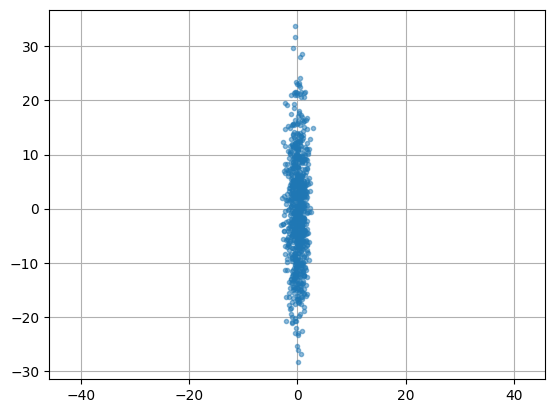

In [6]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]
pts = np.random.multivariate_normal(mean, cov, size=800)

visualize_points(pts).show()

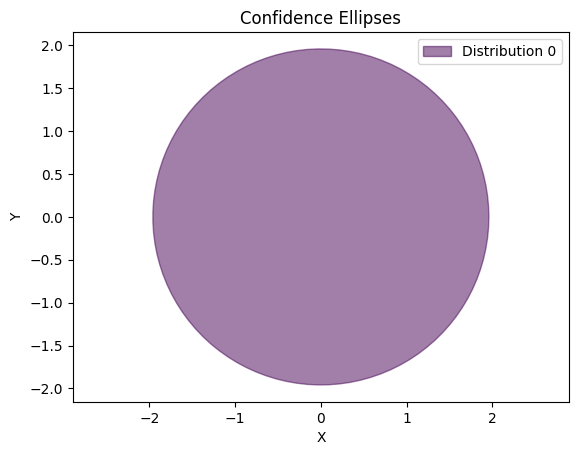

In [7]:
# each row has the values for mutlivariate normal distributions
distributions = np.array([
    [[0, 0], [1, 0], [0, 1]]
])

plot_confidence_ellipses(distributions)[0].show()

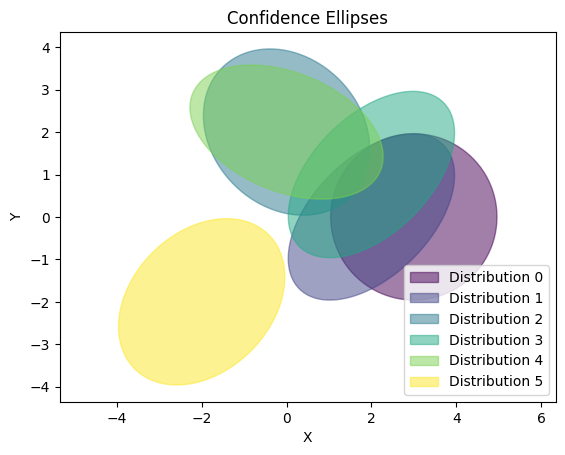

In [8]:
# each row has the values for mutlivariate normal distributions
distributions = np.array([
    [[3, 0], [1, 0], [0, 1]],
    [[2, 0], [1, 0.5], [0.5, 1]],
    [[0, 2], [1, -0.2], [-0.2, 1]],
    [[2, 1], [1, 0.5], [0.5, 1]],
    [[0, 2], [1, -1.2], [-0.2, 1]],
    [[-2, -2], [1, 0.3], [0.3, 1]]
])

plot_confidence_ellipses(distributions)[0].show()

### Points to Distribution


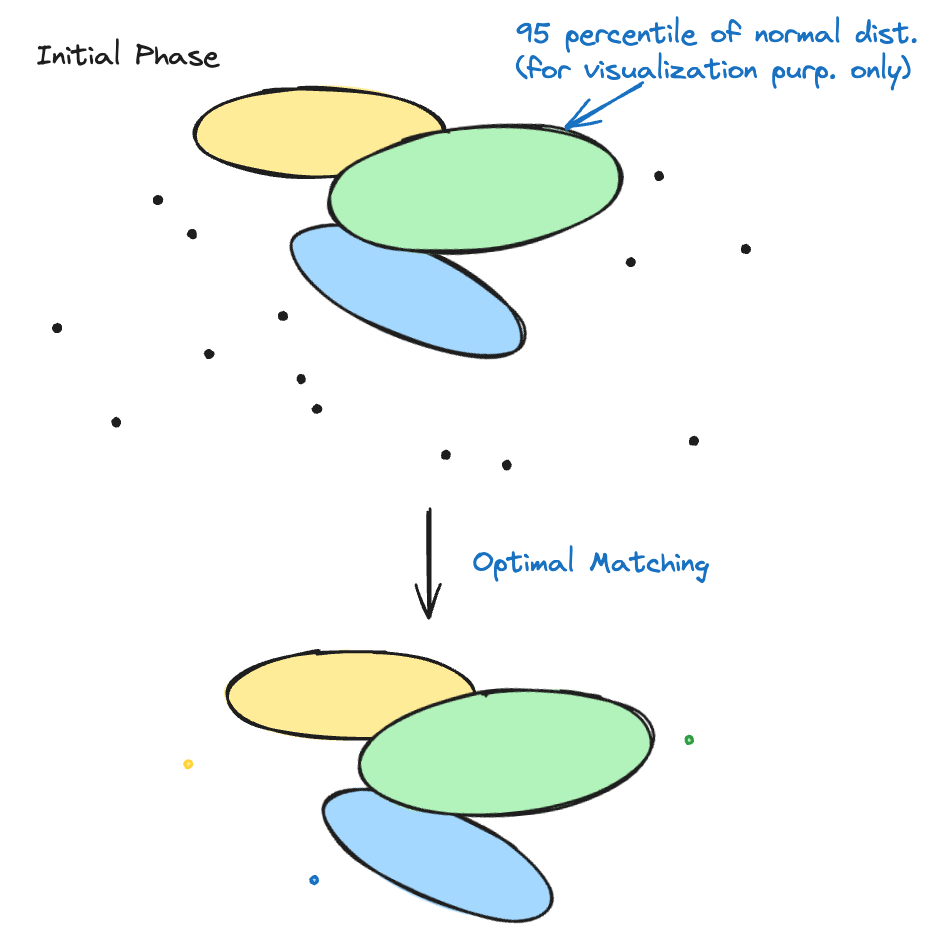
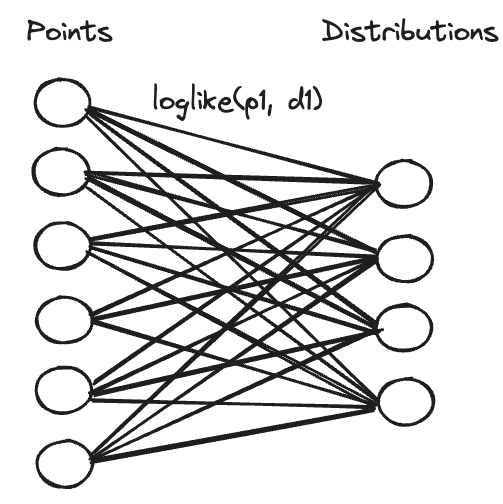

In [9]:
display(HTML(assignment_problem_html))

In [10]:
from scipy.stats import multivariate_normal

def calc_likelihoods_for_distributions_and_points(matrix_dist, matrix_points):
    means = matrix_dist[:, 0]
    covariances = matrix_dist[:, 1:]
    likelihoods = np.array([multivariate_normal(mean=means[i], cov=covariances[i]).pdf(points) for i in range(len(means))])
    
    return likelihoods.T 

In [109]:
def calc_point_indices_to_distributions(distributions, points, treshhold_likelihood = 0):
    if points.shape[0] == 0:
        return np.zeros(distributions.shape[0]) - 1
    
    if points.shape[0] == 1 and distributions.shape[0] == 1:
        likelihood_entries = calc_likelihoods_for_distributions_and_points(distributions, points)
    
        if likelihood_entries < treshhold_likelihood: return np.array([-1])
        return np.array([0])

    likelihoods = calc_likelihoods_for_distributions_and_points(distributions, points)
    sorted_indices = np.argsort(likelihoods, axis=0)
    ranks = np.zeros_like(likelihoods, dtype=int)
    n_rows, n_cols = likelihoods.shape
    ranks[sorted_indices, np.arange(n_cols)] = np.tile(np.arange(n_rows), (n_cols, 1)).T
    
    mask_binary = np.array((n_rows - ranks) <= n_cols, dtype=int)
    cumsum_array = np.cumsum(mask_binary, axis=0)
    
    s = min(n_rows, n_cols)
    extended_likelihood_entries = np.zeros((s+1, n_cols + 1))
    
    mask  = np.array((n_rows - ranks) <= n_cols)
    
    points_to_consider = np.where(np.any(mask, axis=1))[0]
    filtered_points = points[points_to_consider]
    
    likelihood_entries = calc_likelihoods_for_distributions_and_points(distributions, filtered_points)
    likelihood_indicies_to_filter = likelihood_entries < treshhold_likelihood
    # punish points that should be filtered out
    likelihood_entries[likelihood_indicies_to_filter] = 1e-50
    
    inv_percentage_of_likelihood = np.log(likelihood_entries)/ np.sum(np.log(likelihood_entries), axis=0)
    # percentage_of_likelihood = (1 / inv_percentage_of_likelihood) / np.sum( (1 / inv_percentage_of_likelihood), axis=0)
    # percentage_of_likelihood = inv_percentage_of_likelihood
    
    cost_matrix = np.log(inv_percentage_of_likelihood)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    max_index = max(col_ind) + 1
    points_to_distributions = np.zeros(max_index, dtype=row_ind.dtype) - 1
    
    points_to_distributions[col_ind] = row_ind

    # if punished points still come up ahead, set the association to -1
    for point_index, distribution_index in enumerate(col_ind):
        if likelihood_indicies_to_filter[point_index, distribution_index]:
            points_to_distributions[point_index] = -1
    
    return points_to_distributions

In [14]:
def plot_distributions_with_colored_points(distributions, points, points_to_distribution, n_std=1.96):
    fig, ax = plot_confidence_ellipses(distributions, n_std)
    
    # Plot all points in a default color (black)
    ax.plot(points[:, 0], points[:, 1], 'ko', label='All Points')

    # Use the same colormap to get consistent colors
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(distributions)))

    for dist_idx, point_idx in enumerate(points_to_distribution):
        if point_idx == -1: continue
        ax.plot(points[point_idx, 0], points[point_idx, 1], 'o', color=colors[dist_idx], label=f'Point to Distribution {dist_idx}')
    
    ax.legend()
    return plt, ax

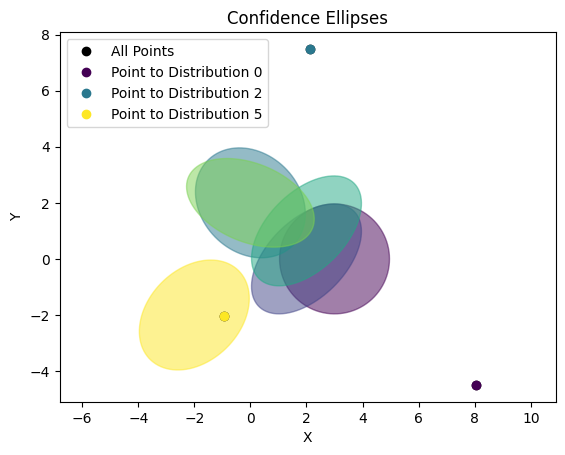

In [108]:
points = np.random.uniform(-10, 10, (3, 2))
points_to_distributions = calc_point_indices_to_distributions(distributions, points, 0)
plot_distributions_with_colored_points(distributions, points, points_to_distributions, n_std=1.96)[0].show()

### Gaussian Processes